# Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-07-12 13:05:41.645404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 13:05:41.745242: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-12 13:05:42.133702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-12 13:05:42.133754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-12 13:05:42.807436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 13:05:42.808223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 13:05:42.808447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 13:05:42.808591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [3]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 10 #was this -- having trouble not forming voxels on surfaces very close to sensor
# show_nth = 3 #test using more points from HD Map
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

# submap = submap[submap[:,2]> -0.9]#remove ground plane (for scan to submap in experiment 1)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

In [4]:
# idx = 400
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
# # fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

# pc1 = np.load(fn1)

# #load ground truth
# # [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# # fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
# gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# # print(gt[idx, 2:])

# offset = 0#for debug 
# rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# # rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# # rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# # rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# # rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# # print(rot_m)

# initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# # pc1 = pc1 @ rot_m
# # rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# # pc1 = pc1 @ rotcorr
# # pc1 += initial_guess[:3]

# Get Ground Truth Poses with code from KitWare pyLiDAR-SLAM library

In [5]:
#load ground truth .csv file
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #debugging possible sign errors
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

<IPython.core.display.Javascript object>


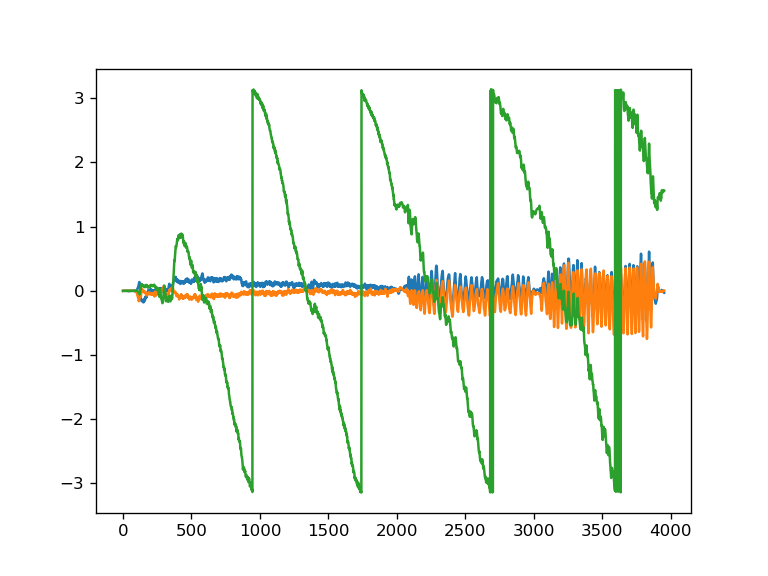

In [6]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

# ax.plot(poses[:,:3,3])
# ax.plot(np.diff(poses[:,:3,3], axis = 0))
poses_euls = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
ax.plot(poses_euls[:,:])

# fwd_vel = np.sqrt(np.diff(poses[:,0,3])**2 + np.diff(poses[:,1,3])**2)
# ax.plot(fwd_vel)

## Regsiter Raw Clouds i, j, and HD Map centered on origin of i 

In [11]:
idx = 2800 #2700 #2650 #2000 - 3000 is the running and swinging loop
# idx = 2400 #very obvious translation distortion
# idx = 2800 #VICET does much better than rigid ICET here!
# idx = 2020 #static start
skip = 1 #10 #how many lidar frames between clouds
# (need to deal with how there are more LIDAR frames than ground truth poses)
offset = 10 #10 #11  #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# # idx = 950 #1080 #950 #fast motion
# # idx = 990 #slow distortion, very accurate solution
# # idx = 530 #pan only -- HD map transformation doesn't work for this part of the dataset but 
# # idx = 280 #from staic(ish) start
# idx = 990 #test for visualization (316 looks really good)
# skip = 1 #30 #how many lidar frames between clouds
# offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# disp.append(Points(pc1, c = '#a65852', r = 3)) #red
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
# disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

# #COLOR SCAN1 POINTS BY ORDER IN CLOUD ~~~~~~~~~~~~~~~~~~~~~~~~~~~
# color = 255*np.linspace(0,1,len(scan1_lidarframe))
# cname = np.array([255-color//2, color, 255-color]).T.tolist()
# # disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))
# disp.append(Points(pc1, c = cname, r = 3, alpha = 1))
# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
# disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

# disp.append(Points(OG_in_hull, c = '#a65852', r = 5)) #red
# disp.append(Points(trans_in_hull, c = '#2c7c94', r = 5)) #blue
# disp.append(Points(pc1[::100,:], c = '#a65852', r = 3)) #red

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Run VICET (12-State ICET)

In [12]:
from linear_corrector import LC
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

max_buffer = 0.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 35, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
        fid = 60, niter = 100, draw = True, mnp = 50, 
        RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

# # # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 25, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
#         fid = 50, niter = 25, draw = True, mnp = 25, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [ 0.14182205 -0.12213042  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.108  -0.1191 -0.0113 -0.0038 -0.0029 -0.    ] 
 [ 0.0115  0.0139  0.0196  0.0002 -0.0025 -0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0818 -0.1158 -0.0209 -0.0071 -0.0054  0.0001] 
 [ 0.0203  0.026   0.0357  0.0005 -0.0044 -0.0004]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0615 -0.115  -0.0284 -0.0101 -0.0076  0.0003] 
 [ 0.0272  0.0421  0.0486  0.001  -0.0057 -0.0006]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0463 -0.1165 -0.0362 -0.0126 -0.0092  0.0005] 
 [ 0.032   0.0619  0.0611  0.0014 -0.007  -0.0008]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0352 -0.1182 -0.0433 -0.015  -0.0105  0.0008] 
 [ 0.0348  0.0821  0.0724  0.0022 -0.008  -0.001 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.027  -0.1203 -0.0493 -0.0169 -0.0116  0.0011] 
 [ 0.0362  0.1024  0.0816  0.0028 -0.0088 -0.001 ]
~~~~

A: 
 [ 0.0456 -0.0571 -0.0587 -0.0284 -0.0119  0.0078] 
 [ 0.0882  0.1995  0.0822  0.0089 -0.0216 -0.0114]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
A: 
 [ 0.0461 -0.0569 -0.0581 -0.0284 -0.0118  0.0079] 
 [ 0.089   0.1999  0.0808  0.0089 -0.0218 -0.0116]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
A: 
 [ 0.0465 -0.0566 -0.0576 -0.0285 -0.0117  0.0079] 
 [ 0.0898  0.2003  0.0794  0.0089 -0.022  -0.0118]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.047  -0.0564 -0.057  -0.0285 -0.0116  0.008 ] 
 [ 0.0906  0.2007  0.0781  0.0088 -0.0222 -0.012 ]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0474 -0.0562 -0.0564 -0.0285 -0.0115  0.0081] 
 [ 0.0914  0.2011  0.0767  0.0088 -0.0224 -0.0122]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0479 -0.0561 -0.0558 -0.0286 -0.0114  0.0081] 
 [ 0.0923  0.2015  0.0754  0.0088 -0.0226 -0.0124]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0483 -0.0559 -0.0552 -0.0286 -0.0113  0.0082] 
 [ 0.0932  0.2019  0.0741  0.0088 -0.0229 -0.0126]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
# # print(dc.Q)
# print(dc.pred_stds)

initial_guess = tf.constant([0.1*np.random.randn(),0.1*np.random.randn(),0.,0.,0.,0.])
it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
       draw = True, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
ViewInteractiveWidget(it.plt.window)

## TODO: remove points from scan1 that lie far outside convex hull of HD Map (so we can calculate proper chamfer distance

In [ ]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# tested = np.random.rand(1000,3)
# cloud  = np.random.rand(50,3)
# print(in_hull(tested,cloud))

# hull_inflation_scale = 1.05 #tight bounds around HD Map-- good for Quad With Dynamics
hull_inflation_scale = 1.125 #-- need wider bounds for Dynamic Spinning Trajectory 
hull = hull_inflation_scale*submap_in_pc1_frame[::100] #downsample and stretch
pc1_in_hull = pc1[np.where( in_hull(pc1, hull) )]

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(pc1, c ='red', r = 3))
disp.append(Points(pc1_in_hull, c = 'blue', r = 3))
# disp.append(Points(hull, c = 'k', alpha = 0.2))
disp.append(Points(submap_in_pc1_frame, c = 'k', r = 1, alpha = 0.2))
plt.show(disp, "Point Cloud 1 inside Convex Hull, Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


## Calculate chamfer distance before and after rectification on single frame

#### From the GitHub README:
Here, dist is the Chamfer distance between source_cloud and target_cloud. Note that Chamfer distance is not bidirectional (and, in stricter parlance, it is not a distance metric).
https://github.com/krrish94/chamferdist/tree/master

In [ ]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

subsample = 10 #downsample to every nth point

# #consider all LIDAR points (outliers cause chamfer distance to be not super useful)
# source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy()[::subsample,:])[None,:,:] #OG scan
# source_cloud_trans = torch.from_numpy(dc.cloud2_tensor.numpy()[::subsample,:])[None,:,:] #transformed scan

#only consdier LIDAR points within convex hull of HD Map + some buffer
hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:] #subsample
OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()

trans_in_hull = dc.cloud2_tensor.numpy()[::subsample,:] #subsample
trans_in_hull = trans_in_hull[np.where( in_hull(trans_in_hull, hull) )]
source_cloud_trans = torch.from_numpy(trans_in_hull)[None,:,:].float() 

target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]

# #downsample LIDAR clouds -- not sure why this doesn't work
# subsample_size = 10_000
# full_OG = dc.cloud2_tensor_OG.numpy()
# new_OG = full_OG[np.random.choice(full_OG.shape[0], subsample_size, replace=False), :]
# source_cloud_OG = torch.from_numpy(new_OG)[None,:,:] #OG scan
# full_trans = dc.cloud2_tensor.numpy()
# new_trans = full_trans[np.random.choice(full_trans.shape[0], subsample_size, replace=False), :]
# source_cloud_trans = torch.from_numpy(new_trans)[None,:,:] #transformed scan
# target_cloud = torch.from_numpy(submap_in_pc1_frame[::1,:3].astype(np.float32))[None,:,:]

dist_forward_OG = chamferDist(source_cloud_OG, target_cloud, reverse = False)
print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
dist_forward_trans = chamferDist(source_cloud_trans, target_cloud, reverse = False)
print("Chamfer Distance after transform: \n:", dist_forward_trans.detach().cpu().item())

# print("\n Normalized OG CD: \n", subsample*dist_forward_OG/len(dc.cloud2_tensor))
# print("\n Normalized transformed CD: \n", subsample*dist_forward_trans/len(dc.cloud2_tensor))

print("\n Normalized OG CD: \n", dist_forward_OG/len(source_cloud_OG))
print("\n Normalized transformed CD: \n", dist_forward_trans/len(source_cloud_trans))

# Generate Scan-to-Submap Transform for 1000 frames of VICET/ ICET in 05

In [16]:
st = time.time()
# runlen = 1000 #was this
# #05 dataset
# # start_idx = 2400 #2000 #one full loop running around the quad
# start_idx = 2020 #static start (was this)

runlen = 200
start_idx = 2700 #2800 #2700

A_hist = np.zeros([runlen, 12]) #VICET
VICET_pred_std_hist = np.zeros([runlen, 12])
X_hist = np.zeros([runlen, 6]) #ICET

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     05
    offset = 10 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    #transform to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
#     seed with noisy initial transform to make things fair
    A0 = np.array([0.01*np.random.randn(), 0.01*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    
    # for experiment #1
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    try:
#         dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 100, 
#                 draw = False, mnp = 50, RM = False, solver = '12_state', 
#                 max_buffer = max_buffer, A0 = A0)    
        dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
            fid = 55, niter = 100, draw = False, mnp = 50, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
        A_hist[idx,:] = dc.A
        VICET_pred_std_hist[idx,:] = dc.pred_stds

        np.save("results/VICET/VICET_05_start_from_2700_v5", A_hist)
#         np.save("results/VICET/VICET_05_start_from_2020", A_hist)

    #     #run ICET ------------------------------------------------------------
        initial_guess = tf.constant([0.01*np.random.randn(),0.01*np.random.randn(),0.,0.,0.,0.])
        it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
        X_hist[idx,:] = it.X

        np.save("results/ICET/ICET_05_start_from_2700_v5", X_hist)
#         np.save("results/ICET/ICET_05_start_from_2020", X_hist)
    
    except:
        pass


 
 Frame # 2700 at 0.0002338886260986328 sec 
 

A0:
 [0.00823717 0.01584623 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0033  0.013   0.0259 -0.0014  0.0004 -0.0004] 
 [-0.0027  0.0243 -0.0135  0.0112  0.0024 -0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0005  0.0097  0.0467 -0.0025  0.0007 -0.0007] 
 [-0.0059  0.0435 -0.0255  0.0201  0.0045 -0.0006]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0005  0.0054  0.0634 -0.0034  0.0008 -0.001 ] 
 [-0.0095  0.0596 -0.0367  0.0271  0.0063 -0.0008]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0011  0.0011  0.0767 -0.0038  0.001  -0.0011] 
 [-0.0125  0.0723 -0.0469  0.0321  0.0078 -0.0009]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0004 -0.0031  0.0875 -0.004   0.0011 -0.0012] 
 [-0.0158  0.0824 -0.0568  0.0356  0.0091 -0.0009]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0009 -0.0072  0.0962 -0.004   0.0012 -0.0013] 
 [-0.0192  0.0908

A: 
 [ 0.0301 -0.0382  0.0937  0.0028 -0.0012 -0.0002] 
 [ 0.0452  0.2354 -0.0772  0.0369  0.0241  0.0006]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
A: 
 [ 0.029  -0.0383  0.0929  0.0029 -0.0013 -0.0003] 
 [ 0.0484  0.2377 -0.0761  0.0369  0.0243  0.0007]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
A: 
 [ 0.028  -0.0385  0.092   0.003  -0.0013 -0.0003] 
 [ 0.0517  0.2401 -0.0749  0.0369  0.0245  0.0007]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.027  -0.0387  0.0911  0.003  -0.0014 -0.0004] 
 [ 0.0549  0.2425 -0.0738  0.0369  0.0247  0.0008]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.026  -0.0389  0.0902  0.003  -0.0015 -0.0004] 
 [ 0.058   0.2449 -0.0726  0.0369  0.025   0.0009]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0251 -0.0391  0.0893  0.0031 -0.0016 -0.0005] 
 [ 0.0611  0.2473 -0.0715  0.0369  0.0252  0.001 ]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0242 -0.0394  0.0884  0.0032 -0.0017 -0.0005] 
 [ 0.0642  0.2498 -0.0703  0.0368  0.0254  0.001 ]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~

A: 
 [ 0.0412 -0.0842  0.0864  0.0026 -0.0065  0.0056] 
 [ 0.0497  0.2211 -0.04    0.0333  0.0296 -0.0101]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0437 -0.0864  0.0882  0.0026 -0.0066  0.0059] 
 [ 0.0505  0.2294 -0.0425  0.0338  0.03   -0.0103]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0459 -0.0882  0.09    0.0026 -0.0068  0.0061] 
 [ 0.0512  0.2371 -0.0452  0.0341  0.0303 -0.0106]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0479 -0.0899  0.0914  0.0026 -0.0069  0.0063] 
 [ 0.0518  0.2443 -0.0474  0.0345  0.0306 -0.0107]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0498 -0.0915  0.0927  0.0026 -0.007   0.0065] 
 [ 0.0524  0.251  -0.0495  0.0348  0.0307 -0.0109]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0514 -0.0929  0.0939  0.0026 -0.0071  0.0066] 
 [ 0.053   0.2574 -0.0516  0.035   0.0309 -0.011 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0528 -0.0941  0.095   0.0025 -0.0071  0.0068] 
 [ 0.0534  0.2634 -0.0536  0.0352  0.0309 -0.0111]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [ 0.0258 -0.0782  0.1406  0.0005 -0.0046  0.0048] 
 [ 0.0457  0.2788 -0.1383  0.0363  0.0254 -0.0034]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
A: 
 [ 0.0253 -0.0777  0.1414  0.0005 -0.0046  0.0048] 
 [ 0.0455  0.2772 -0.1395  0.0363  0.0252 -0.0033]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
A: 
 [ 0.0247 -0.0772  0.1423  0.0004 -0.0045  0.0048] 
 [ 0.0453  0.2757 -0.1407  0.0363  0.025  -0.0032]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0242 -0.0767  0.1432  0.0004 -0.0044  0.0047] 
 [ 0.0452  0.2741 -0.142   0.0363  0.0249 -0.0031]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.0238 -0.0762  0.1441  0.0003 -0.0043  0.0047] 
 [ 0.045   0.2726 -0.1433  0.0363  0.0247 -0.0031]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0233 -0.0757  0.145   0.0003 -0.0043  0.0047] 
 [ 0.0448  0.2711 -0.1447  0.0363  0.0245 -0.003 ]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0229 -0.0753  0.1459  0.0002 -0.0042  0.0046] 
 [ 0.0447  0.2696 -0.146   0.0363  0.0244 -0.0029]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~

A: 
 [-0.0061 -0.0002  0.1147  0.0047 -0.0176 -0.0041] 
 [-0.0341  0.0295 -0.0199  0.0435  0.0352  0.0162]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0057  0.0007  0.1141  0.0047 -0.0179 -0.0042] 
 [-0.0333  0.0294 -0.0185  0.0435  0.0356  0.0165]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0054  0.0015  0.1136  0.0047 -0.0181 -0.0043] 
 [-0.0325  0.0295 -0.0173  0.0436  0.0361  0.0167]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.005   0.0022  0.113   0.0047 -0.0183 -0.0043] 
 [-0.0317  0.0297 -0.0161  0.0437  0.0364  0.0169]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0047  0.0029  0.1126  0.0048 -0.0185 -0.0044] 
 [-0.0308  0.0301 -0.0152  0.0438  0.0368  0.0171]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0043  0.0034  0.1122  0.0048 -0.0187 -0.0045] 
 [-0.0299  0.0307 -0.0143  0.0438  0.0371  0.0173]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.004   0.0039  0.1118  0.0048 -0.0189 -0.0045] 
 [-0.0289  0.0315 -0.0135  0.0439  0.0375  0.0174]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

A: 
 [ 0.0005 -0.007   0.0832  0.006  -0.0227 -0.0043] 
 [0.0453 0.1351 0.0223 0.0449 0.0451 0.0164]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0006 -0.0074  0.083   0.006  -0.0227 -0.0043] 
 [0.0465 0.137  0.0225 0.0449 0.0452 0.0163]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.0008 -0.0077  0.0827  0.006  -0.0228 -0.0042] 
 [0.0477 0.139  0.0227 0.0449 0.0453 0.0163]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0009 -0.0081  0.0825  0.0061 -0.0228 -0.0042] 
 [0.049  0.1409 0.0228 0.0449 0.0453 0.0162]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0011 -0.0085  0.0822  0.0061 -0.0228 -0.0042] 
 [0.0502 0.1429 0.023  0.0449 0.0454 0.0162]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0012 -0.0088  0.082   0.0061 -0.0229 -0.0042] 
 [0.0515 0.1449 0.0232 0.045  0.0455 0.0161]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0013 -0.0092  0.0818  0.0061 -0.0229 -0.0042] 
 [0.0527 0.1468 0.0234 0.045  0.0455 0.0161]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [ 0.0015 -0.0096  0.0815  0.0061 -0.

A: 
 [ 0.0309 -0.0043  0.1025  0.0048 -0.0179 -0.0038] 
 [-0.1323 -0.0001  0.0313  0.0567  0.0399  0.0219]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0315 -0.0049  0.1032  0.0048 -0.0178 -0.0037] 
 [-0.1323  0.0014  0.0298  0.0567  0.0397  0.0219]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0326 -0.0047  0.1037  0.0048 -0.0178 -0.0037] 
 [-0.1328  0.0017  0.0286  0.0566  0.0397  0.022 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0336 -0.0047  0.1043  0.0048 -0.0177 -0.0036] 
 [-0.1333  0.0021  0.0273  0.0565  0.0395  0.0221]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0346 -0.0047  0.1049  0.0048 -0.0177 -0.0036] 
 [-0.1336  0.0028  0.026   0.0564  0.0394  0.0221]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0355 -0.0049  0.1055  0.0048 -0.0176 -0.0035] 
 [-0.1337  0.0038  0.0246  0.0564  0.0393  0.0222]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0363 -0.0052  0.1061  0.0048 -0.0175 -0.0035] 
 [-0.1338  0.005   0.0232  0.0563  0.0392  0.0222]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0054 -0.0204  0.0404  0.002  -0.0005  0.0001] 
 [ 0.0023  0.0163 -0.0334  0.0079  0.0031  0.001 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0064 -0.03    0.071   0.0032 -0.0008  0.0001] 
 [ 0.0015  0.0288 -0.0552  0.0154  0.0055  0.0021]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0093 -0.035   0.0943  0.004  -0.0011 -0.0003] 
 [ 0.0022  0.0319 -0.0699  0.0218  0.0073  0.0039]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0128 -0.0369  0.1116  0.0045 -0.0012 -0.0009] 
 [ 0.003   0.0304 -0.0785  0.0275  0.0087  0.0059]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0163 -0.0375  0.1252  0.0047 -0.0014 -0.0015] 
 [ 0.0034  0.0269 -0.0846  0.0324  0.0099  0.0081]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0195 -0.0366  0.1359  0.0049 -0.0016 -0.0022] 
 [ 0.0031  0.0214 -0.0889  0.0363  0.0109  0.0103]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0234 -0.0343  0.1447  0.005  -0.0017 -0.0029] 
 [ 0.0032  0.0137 -0.0924  0.0396  0.0119  0.0126]
~~~~~~

A: 
 [-0.0057  0.0809  0.1716  0.0053 -0.0105 -0.0169] 
 [-0.1391 -0.2282 -0.0631  0.0554  0.0337  0.0637]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0049  0.081   0.1711  0.0053 -0.0106 -0.0169] 
 [-0.1398 -0.2271 -0.0622  0.0554  0.034   0.0639]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0042  0.081   0.1706  0.0053 -0.0107 -0.0169] 
 [-0.1403 -0.2257 -0.0613  0.0554  0.0342  0.064 ]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0034  0.081   0.1701  0.0053 -0.0108 -0.0169] 
 [-0.1407 -0.2242 -0.0604  0.0555  0.0344  0.0642]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0027  0.081   0.1696  0.0054 -0.0109 -0.0169] 
 [-0.1411 -0.2228 -0.0596  0.0555  0.0347  0.0643]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0019  0.0811  0.1691  0.0054 -0.011  -0.0169] 
 [-0.1415 -0.2214 -0.0587  0.0556  0.0349  0.0645]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0012  0.0809  0.1686  0.0054 -0.0112 -0.0168] 
 [-0.1418 -0.2196 -0.0579  0.0556  0.0351  0.0646]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0053 -0.0192  0.1474  0.0087 -0.007  -0.0019] 
 [-0.024  -0.0098 -0.0437  0.0516  0.0441  0.0063]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0025 -0.0178  0.1465  0.0087 -0.0075 -0.0021] 
 [-0.0315 -0.0141 -0.0391  0.0524  0.0453  0.0069]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0004 -0.0163  0.1455  0.0087 -0.008  -0.0023] 
 [-0.0382 -0.0185 -0.0349  0.053   0.0464  0.0075]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0014 -0.0146  0.1445  0.0087 -0.0085 -0.0025] 
 [-0.0444 -0.023  -0.0309  0.0535  0.0475  0.0081]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0029 -0.0128  0.1434  0.0087 -0.009  -0.0027] 
 [-0.0505 -0.0275 -0.0269  0.054   0.0485  0.0087]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0042 -0.0109  0.1422  0.0087 -0.0094 -0.0029] 
 [-0.0563 -0.0324 -0.0229  0.0545  0.0493  0.0093]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0061 -0.0089  0.1411  0.0087 -0.0098 -0.0031] 
 [-0.0626 -0.0373 -0.0193  0.0548  0.0501  0.0099]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0262  0.0547  0.1386  0.0071 -0.0129 -0.0101] 
 [-0.1317 -0.2249  0.0212  0.0593  0.0559  0.0243]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0262  0.0552  0.1386  0.0071 -0.0129 -0.0101] 
 [-0.1332 -0.2276  0.0214  0.0592  0.0559  0.0243]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0262  0.0556  0.1387  0.0071 -0.0129 -0.0102] 
 [-0.1348 -0.2302  0.0217  0.0592  0.0559  0.0243]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0261  0.0561  0.1387  0.0071 -0.0129 -0.0102] 
 [-0.1365 -0.2329  0.022   0.0593  0.0559  0.0243]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0261  0.0567  0.1387  0.0071 -0.0129 -0.0102] 
 [-0.1381 -0.2356  0.0224  0.0593  0.0559  0.0243]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0259  0.0572  0.1386  0.0071 -0.0129 -0.0103] 
 [-0.1399 -0.2384  0.0228  0.0593  0.0559  0.0243]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0259  0.0578  0.1386  0.007  -0.0129 -0.0103] 
 [-0.1417 -0.2412  0.0231  0.0593  0.0559  0.0243]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0377 -0.0328  0.1649  0.0023 -0.0118 -0.0052] 
 [ 0.0059 -0.0003 -0.0429  0.0566  0.0532  0.0066]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.037  -0.0319  0.165   0.0023 -0.0118 -0.0053] 
 [ 0.0033 -0.0022 -0.0425  0.0567  0.0533  0.0069]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0365 -0.031   0.165   0.0022 -0.0119 -0.0055] 
 [ 0.0011 -0.0039 -0.0421  0.0569  0.0534  0.0072]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0361 -0.0302  0.1651  0.0021 -0.0119 -0.0056] 
 [-0.001  -0.0056 -0.0419  0.057   0.0534  0.0076]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0358 -0.0293  0.1652  0.0021 -0.0119 -0.0058] 
 [-0.0029 -0.0074 -0.0416  0.0571  0.0535  0.0079]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0356 -0.0284  0.1653  0.002  -0.012  -0.0059] 
 [-0.0046 -0.0092 -0.0415  0.0572  0.0535  0.0082]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0355 -0.0275  0.1654  0.002  -0.012  -0.006 ] 
 [-0.0061 -0.0109 -0.0413  0.0572  0.0536  0.0085]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0377 -0.0167  0.1715  0.0011 -0.0113 -0.0088] 
 [-0.0088 -0.0166 -0.0506  0.0579  0.0522  0.0155]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0378 -0.0169  0.1716  0.0011 -0.0113 -0.0088] 
 [-0.0082 -0.0158 -0.0508  0.0578  0.0522  0.0155]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0378 -0.0171  0.1717  0.0011 -0.0113 -0.0088] 
 [-0.0077 -0.0149 -0.0511  0.0578  0.0521  0.0155]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0379 -0.0172  0.1717  0.0012 -0.0113 -0.0088] 
 [-0.0073 -0.0141 -0.0513  0.0578  0.0521  0.0155]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0378 -0.0174  0.1718  0.0012 -0.0113 -0.0088] 
 [-0.0069 -0.0133 -0.0516  0.0578  0.0521  0.0155]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0379 -0.0175  0.1718  0.0012 -0.0113 -0.0088] 
 [-0.0064 -0.0125 -0.0518  0.0578  0.0521  0.0155]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0378 -0.0177  0.1719  0.0012 -0.0112 -0.0088] 
 [-0.0061 -0.0117 -0.0521  0.0578  0.0521  0.0155]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0533 -0.0624  0.1218  0.0012 -0.0147 -0.0013] 
 [-0.0634  0.1308  0.0336  0.0538  0.0365  0.0085]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.054  -0.0628  0.1233  0.0011 -0.0147 -0.0013] 
 [-0.0644  0.1326  0.0308  0.0539  0.0365  0.0088]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0547 -0.0632  0.1247  0.001  -0.0146 -0.0013] 
 [-0.0654  0.1344  0.0281  0.054   0.0364  0.009 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0554 -0.0635  0.1262  0.0009 -0.0146 -0.0013] 
 [-0.0663  0.1361  0.0253  0.0541  0.0364  0.0092]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0563 -0.0639  0.1276  0.0008 -0.0146 -0.0012] 
 [-0.0678  0.1379  0.0225  0.0542  0.0363  0.0095]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0573 -0.0641  0.129   0.0007 -0.0146 -0.0012] 
 [-0.0694  0.1396  0.0197  0.0543  0.0362  0.0098]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0582 -0.0644  0.1303  0.0006 -0.0145 -0.0012] 
 [-0.0709  0.1413  0.0171  0.0543  0.0361  0.01  ]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0123 -0.0054  0.0163  0.0029 -0.0015  0.0006] 
 [ 0.0104  0.0096  0.0004  0.0042  0.0034 -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0095 -0.0105  0.0293  0.0049 -0.0031  0.001 ] 
 [ 0.0167  0.0202  0.0035  0.0089  0.0066 -0.0014]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0058 -0.0162  0.0389  0.0061 -0.0048  0.0014] 
 [ 0.0238  0.0312  0.0113  0.0139  0.0096 -0.002 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0057 -0.0218  0.0457  0.0066 -0.0065  0.0017] 
 [ 0.0259  0.0419  0.0222  0.0194  0.0124 -0.0026]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0044 -0.027   0.0507  0.0069 -0.0082  0.0019] 
 [ 0.0288  0.0518  0.0337  0.0246  0.015  -0.0031]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0018 -0.0317  0.0536  0.0068 -0.0097  0.002 ] 
 [ 0.0326  0.0605  0.0472  0.0296  0.0172 -0.0034]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0016 -0.036   0.0554  0.0066 -0.0111  0.0021] 
 [ 0.0365  0.0683  0.0602  0.0342  0.0192 -0.0036]
~~~~~~

A: 
 [ 0.0265 -0.0934  0.0622 -0.0022 -0.0219  0.0008] 
 [-0.0062  0.2135  0.1515  0.073   0.0332 -0.0015]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0266 -0.0939  0.062  -0.0022 -0.0219  0.0009] 
 [-0.0051  0.2159  0.1517  0.073   0.0332 -0.0015]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0267 -0.0944  0.0618 -0.0022 -0.0219  0.0009] 
 [-0.0039  0.2184  0.1519  0.0731  0.0332 -0.0015]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0268 -0.095   0.0616 -0.0022 -0.0219  0.001 ] 
 [-0.0028  0.2209  0.1522  0.0731  0.0332 -0.0016]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0266 -0.0955  0.0614 -0.0022 -0.0219  0.001 ] 
 [-0.0012  0.2234  0.1524  0.0731  0.0332 -0.0016]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0264 -0.0961  0.0612 -0.0022 -0.0219  0.0011] 
 [ 0.0003  0.226   0.1526  0.0731  0.0331 -0.0016]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0262 -0.0967  0.061  -0.0022 -0.0219  0.0011] 
 [ 0.0019  0.2286  0.1528  0.0732  0.0331 -0.0016]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0336 -0.0639  0.0718 -0.0049 -0.0173 -0.0014] 
 [ 0.0206  0.088   0.1147  0.0737  0.03   -0.0032]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0323 -0.0653  0.0725 -0.0053 -0.0176 -0.0015] 
 [ 0.017   0.0906  0.1176  0.075   0.0303 -0.0032]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.031  -0.0666  0.0731 -0.0056 -0.0178 -0.0017] 
 [ 0.0135  0.0931  0.12    0.0762  0.0305 -0.0033]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0296 -0.0678  0.0737 -0.006  -0.018  -0.0018] 
 [ 0.0102  0.0953  0.122   0.0772  0.0306 -0.0033]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0283 -0.069   0.0742 -0.0063 -0.0182 -0.0019] 
 [ 0.0071  0.0976  0.1237  0.0781  0.0307 -0.0033]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0271 -0.0701  0.0749 -0.0066 -0.0183 -0.002 ] 
 [ 0.0042  0.0998  0.1248  0.0788  0.0307 -0.0033]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0259 -0.0711  0.0755 -0.0069 -0.0184 -0.0021] 
 [ 0.0019  0.102   0.1255  0.0795  0.0307 -0.0033]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.031  -0.0786  0.1131 -0.0104 -0.0143 -0.0048] 
 [ 0.0479  0.1731  0.0507  0.081   0.0216 -0.    ]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0317 -0.0785  0.114  -0.0104 -0.0142 -0.0048] 
 [ 0.0498  0.1739  0.0488  0.081   0.0214 -0.    ]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0324 -0.0784  0.1148 -0.0105 -0.0141 -0.0049] 
 [ 0.0517  0.1746  0.0468  0.0809  0.0213 -0.    ]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0331 -0.0784  0.1157 -0.0105 -0.0141 -0.0049] 
 [ 0.0535  0.1754  0.0448  0.0808  0.0212 -0.    ]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0337 -0.0783  0.1166 -0.0105 -0.014  -0.0049] 
 [0.0554 0.1761 0.0428 0.0807 0.021  0.    ]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0353 -0.0783  0.1175 -0.0105 -0.0139 -0.005 ] 
 [0.0594 0.1769 0.0407 0.0807 0.0209 0.    ]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0366 -0.0782  0.1184 -0.0106 -0.0138 -0.005 ] 
 [0.063  0.1777 0.0386 0.0806 0.0208 0.    ]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0379 -0.

A: 
 [-0.0149 -0.0565  0.1236 -0.0076 -0.0068 -0.    ] 
 [ 0.0134  0.0585  0.0071  0.062   0.0304 -0.0076]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0138 -0.0569  0.1243 -0.0077 -0.0067 -0.    ] 
 [ 0.011   0.0577  0.0058  0.062   0.0302 -0.0078]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0127 -0.0573  0.125  -0.0078 -0.0066 -0.0001] 
 [ 0.0085  0.0569  0.0046  0.062   0.03   -0.008 ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0112 -0.0577  0.1257 -0.0078 -0.0065 -0.0001] 
 [ 0.0056  0.0561  0.0033  0.0619  0.0298 -0.0081]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0098 -0.058   0.1263 -0.0079 -0.0064 -0.0001] 
 [ 0.0028  0.0552  0.0019  0.0618  0.0296 -0.0083]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0084 -0.0583  0.127  -0.0079 -0.0063 -0.0001] 
 [ 0.      0.0542  0.0005  0.0618  0.0294 -0.0084]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.007  -0.0585  0.1276 -0.008  -0.0062 -0.0001] 
 [-0.0027  0.0533 -0.0009  0.0616  0.0292 -0.0086]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0037 -0.0493  0.1518 -0.0092 -0.0015 -0.0027] 
 [-0.0584 -0.0083 -0.0521  0.0582  0.0208 -0.0059]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0034 -0.0491  0.1523 -0.0092 -0.0014 -0.0028] 
 [-0.0586 -0.0094 -0.053   0.0582  0.0207 -0.0059]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.0032 -0.0488  0.1528 -0.0092 -0.0013 -0.0028] 
 [-0.0588 -0.0104 -0.0538  0.0582  0.0206 -0.0058]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0029 -0.0486  0.1533 -0.0092 -0.0013 -0.0028] 
 [-0.0589 -0.0115 -0.0547  0.0581  0.0205 -0.0057]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0026 -0.0483  0.1537 -0.0092 -0.0012 -0.0029] 
 [-0.0591 -0.0125 -0.0555  0.0581  0.0204 -0.0057]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0023 -0.0481  0.1542 -0.0093 -0.0012 -0.0029] 
 [-0.0593 -0.0136 -0.0563  0.0581  0.0203 -0.0056]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.002  -0.0479  0.1547 -0.0093 -0.0011 -0.003 ] 
 [-0.0594 -0.0146 -0.0571  0.0581  0.0201 -0.0055]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0488 -0.0499  0.1011 -0.0051 -0.0027 -0.0024] 
 [-0.1055  0.0328  0.0227  0.0437  0.0287  0.0069]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0495 -0.0501  0.1007 -0.0051 -0.0028 -0.0024] 
 [-0.1072  0.0332  0.0238  0.0439  0.0289  0.0071]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0502 -0.0503  0.1003 -0.0051 -0.003  -0.0025] 
 [-0.1089  0.0336  0.0248  0.044   0.0292  0.0073]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0508 -0.0504  0.0998 -0.0052 -0.0031 -0.0025] 
 [-0.1105  0.034   0.0259  0.0442  0.0294  0.0075]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0514 -0.0506  0.0995 -0.0052 -0.0032 -0.0026] 
 [-0.1121  0.0345  0.0267  0.0444  0.0297  0.0078]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0521 -0.0508  0.0991 -0.0052 -0.0033 -0.0026] 
 [-0.1137  0.0349  0.0276  0.0445  0.0299  0.008 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0527 -0.0509  0.0988 -0.0053 -0.0035 -0.0026] 
 [-0.1153  0.0355  0.0284  0.0447  0.0302  0.0082]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0207 -0.0072  0.0129 -0.0006  0.0006 -0.0003] 
 [ 0.0084 -0.0056  0.0068  0.0039  0.0019  0.001 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0136 -0.005   0.0252 -0.0015  0.0005 -0.0005] 
 [ 0.0142 -0.0114  0.0101  0.008   0.0049  0.002 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.006  -0.0027  0.0352 -0.0021  0.0007 -0.0008] 
 [ 0.0215 -0.0172  0.0139  0.011   0.0064  0.0027]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0002 -0.0007  0.0449 -0.0028  0.0003 -0.001 ] 
 [ 0.0268 -0.0225  0.0146  0.0141  0.0089  0.0034]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0049  0.0012  0.0534 -0.0035 -0.     -0.0012] 
 [ 0.0313 -0.0278  0.0145  0.0169  0.0111  0.004 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0098  0.003   0.0605 -0.0041 -0.0003 -0.0014] 
 [ 0.0355 -0.0329  0.0144  0.0194  0.013   0.0045]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0137  0.0048  0.0668 -0.0046 -0.0005 -0.0016] 
 [ 0.0375 -0.0382  0.0142  0.0216  0.0144  0.005 ]
~~~~~~

A: 
 [-0.0815  0.1133  0.1673 -0.0163 -0.0081 -0.0094] 
 [-0.0604 -0.4278 -0.06    0.0459  0.037   0.0064]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0818  0.1161  0.1672 -0.0163 -0.0082 -0.0095] 
 [-0.0647 -0.438  -0.0586  0.046   0.0372  0.0062]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0823  0.119   0.1669 -0.0164 -0.0082 -0.0097] 
 [-0.0688 -0.4485 -0.0569  0.046   0.0374  0.006 ]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0822  0.1218  0.1667 -0.0164 -0.0083 -0.0098] 
 [-0.0735 -0.4586 -0.0551  0.0461  0.0376  0.0058]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0818  0.1243  0.1664 -0.0165 -0.0084 -0.0098] 
 [-0.0778 -0.4688 -0.0531  0.0463  0.0379  0.0054]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0813  0.127   0.1661 -0.0166 -0.0086 -0.0099] 
 [-0.0822 -0.4794 -0.0509  0.0466  0.0382  0.0049]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.081   0.1295  0.1656 -0.0167 -0.0087 -0.0099] 
 [-0.0865 -0.4899 -0.0485  0.0468  0.0385  0.0044]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.01    0.0225  0.0482 -0.0133 -0.0108 -0.0046] 
 [-0.0081 -0.0622  0.1028  0.0418  0.0161  0.0084]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0042  0.0241  0.0492 -0.0138 -0.0111 -0.0049] 
 [-0.0015 -0.0667  0.105   0.043   0.0164  0.0089]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0018  0.0256  0.0503 -0.0142 -0.0114 -0.0053] 
 [ 0.0053 -0.0712  0.1069  0.0441  0.0167  0.0093]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.008   0.0271  0.0514 -0.0146 -0.0116 -0.0056] 
 [ 0.0125 -0.0759  0.1087  0.0452  0.017   0.0097]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0144  0.0285  0.0526 -0.0151 -0.0118 -0.006 ] 
 [ 0.0199 -0.0806  0.1103  0.0463  0.0173  0.0101]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0209  0.0298  0.0538 -0.0155 -0.012  -0.0063] 
 [ 0.0276 -0.0854  0.1117  0.0473  0.0174  0.0104]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0275  0.0311  0.055  -0.0158 -0.0122 -0.0066] 
 [ 0.0355 -0.0903  0.113   0.0483  0.0176  0.0106]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.8667  0.1443  0.3437 -0.0291 -0.013  -0.0209] 
 [ 1.2376 -0.7838 -0.3203  0.0554  0.0253 -0.0336]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.8645  0.1513  0.3476 -0.0293 -0.0127 -0.0195] 
 [ 1.2588 -0.8317 -0.3257  0.0551  0.0247 -0.0416]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.8594  0.1587  0.3516 -0.0295 -0.0125 -0.018 ] 
 [ 1.2767 -0.88   -0.3336  0.0544  0.0242 -0.0494]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.8565  0.1658  0.3559 -0.0296 -0.0122 -0.0165] 
 [ 1.3029 -0.9284 -0.3449  0.0535  0.0239 -0.0575]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.8532  0.1731  0.3604 -0.0297 -0.0121 -0.015 ] 
 [ 1.3246 -0.977  -0.3584  0.0523  0.0236 -0.0654]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.8487  0.1815  0.3651 -0.0297 -0.0119 -0.0137] 
 [ 1.3506 -1.0278 -0.3738  0.0509  0.0234 -0.073 ]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.8582  0.1896  0.3696 -0.0298 -0.0117 -0.0123] 
 [ 1.3903 -1.0781 -0.3896  0.0495  0.0234 -0.0806]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.3732  0.028  -0.0449 -0.0143 -0.0049 -0.002 ] 
 [-0.5553  0.1163  0.2072  0.0434 -0.0018  0.0482]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.37    0.0319 -0.0448 -0.0144 -0.0051 -0.002 ] 
 [-0.5535  0.1192  0.2086  0.0442 -0.0015  0.0501]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.3671  0.0358 -0.0449 -0.0145 -0.0053 -0.0019] 
 [-0.5517  0.1214  0.2106  0.0451 -0.0013  0.0518]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.3584  0.0391 -0.0443 -0.0146 -0.0056 -0.0019] 
 [-0.5409  0.1242  0.2112  0.0461 -0.0007  0.0536]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.3415  0.0415 -0.042  -0.0149 -0.0061 -0.002 ] 
 [-0.5171  0.1277  0.2081  0.0474  0.0006  0.0552]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.3204  0.0411 -0.0407 -0.0149 -0.0065 -0.0024] 
 [-0.4878  0.134   0.2068  0.0482  0.0014  0.057 ]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.2988  0.0403 -0.0395 -0.0149 -0.0068 -0.0029] 
 [-0.458   0.1404  0.2064  0.0491  0.0021  0.0588]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.6935  0.0353  0.1054 -0.0338 -0.012  -0.0088] 
 [ 1.0681 -0.2748  0.2902  0.1036 -0.02   -0.0143]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.6859  0.0366  0.1032 -0.0335 -0.0099 -0.0082] 
 [ 1.0708 -0.2986  0.3032  0.1017 -0.0272 -0.0198]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.6806  0.0356  0.0982 -0.0329 -0.0071 -0.0077] 
 [ 1.0773 -0.3182  0.3247  0.0986 -0.0367 -0.0256]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.6887  0.0323  0.0948 -0.0323 -0.0042 -0.0071] 
 [ 1.1074 -0.334   0.3391  0.0954 -0.0459 -0.0317]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.7037  0.0317  0.0961 -0.0315 -0.0012 -0.0065] 
 [ 1.1481 -0.3562  0.3393  0.0906 -0.0549 -0.0379]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.7227  0.0288  0.0924 -0.0308  0.0022 -0.0057] 
 [ 1.1951 -0.3752  0.358   0.087  -0.0663 -0.0446]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.7455  0.0246  0.0924 -0.0302  0.006  -0.0047] 
 [ 1.2486 -0.3914  0.3679  0.083  -0.0789 -0.0521]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~

A: 
 [-0.2644  0.0364  0.0311 -0.0182 -0.0201 -0.0121] 
 [0.4455 0.06   0.1578 0.0634 0.0245 0.0462]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.2564  0.03    0.0337 -0.0187 -0.02   -0.0123] 
 [0.4366 0.0585 0.1555 0.0639 0.0242 0.0445]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.2462  0.0248  0.0353 -0.0192 -0.0199 -0.0125] 
 [0.4241 0.0554 0.1543 0.0641 0.0237 0.043 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.2351  0.0205  0.0368 -0.0196 -0.0197 -0.0128] 
 [0.4099 0.0513 0.1524 0.0643 0.0232 0.0417]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.2282  0.0168  0.0382 -0.0201 -0.0196 -0.013 ] 
 [0.4012 0.0468 0.1498 0.0644 0.0227 0.0404]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.2222  0.0134  0.0392 -0.0205 -0.0193 -0.0132] 
 [0.3936 0.0421 0.1478 0.0645 0.0222 0.0391]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.2145  0.0104  0.04   -0.0209 -0.0191 -0.0135] 
 [0.3834 0.0371 0.1456 0.0644 0.0215 0.038 ]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [-0.2056  0.0078  0.0409 -0.0213 -0.

A: 
 [ 0.0566 -0.01   -0.0063 -0.0029 -0.0007  0.0007] 
 [-0.0428  0.0062  0.0439  0.0064  0.002  -0.0012]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0804 -0.0105 -0.0092 -0.004  -0.001   0.0011] 
 [-0.0708  0.0086  0.06    0.0088  0.0027 -0.0017]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.1066 -0.0103 -0.0124 -0.0051 -0.0012  0.0014] 
 [-0.1028  0.0106  0.0736  0.0109  0.0032 -0.0019]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.1356 -0.0094 -0.0159 -0.006  -0.0014  0.0018] 
 [-0.1394  0.0125  0.0854  0.0126  0.0036 -0.0021]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.1677 -0.0078 -0.0199 -0.0068 -0.0015  0.0022] 
 [-0.1807  0.0143  0.0962  0.0142  0.004  -0.0021]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.2001 -0.0055 -0.0247 -0.0075 -0.0016  0.0027] 
 [-0.2234  0.0162  0.1068  0.0155  0.0041 -0.0021]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.232  -0.0027 -0.0296 -0.0081 -0.0016  0.0031] 
 [-0.2664  0.0183  0.1159  0.0165  0.004  -0.0018]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 1.1022  0.3458 -0.351  -0.005  -0.0074 -0.0131] 
 [-2.9875  0.6744  0.9841  0.0748  0.0085  0.2515]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 1.0686  0.3325 -0.346  -0.0054 -0.0082 -0.0146] 
 [-3.0167  0.721   0.9992  0.0776  0.0099  0.2579]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 1.0331  0.3165 -0.3416 -0.006  -0.0089 -0.0162] 
 [-3.0474  0.7702  1.0182  0.0808  0.0113  0.2639]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 1.0001  0.2987 -0.3371 -0.0065 -0.0095 -0.018 ] 
 [-3.0759  0.823   1.038   0.0837  0.0124  0.2702]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.9665  0.2791 -0.3335 -0.0072 -0.01   -0.0198] 
 [-3.1052  0.8785  1.0629  0.0872  0.013   0.2766]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.9353  0.2573 -0.3301 -0.0079 -0.0104 -0.0218] 
 [-3.1322  0.937   1.0886  0.0906  0.0136  0.2831]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.9063  0.2332 -0.3258 -0.0085 -0.0108 -0.024 ] 
 [-3.1572  0.9988  1.1117  0.0936  0.0142  0.2899]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.058  -0.0102  0.0001 -0.0201 -0.0053  0.001 ] 
 [-0.0492  0.0095  0.0837  0.0165  0.0037 -0.0044]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0632 -0.0102  0.0009 -0.0205 -0.0054  0.001 ] 
 [-0.0566  0.0081  0.0816  0.0168  0.0039 -0.0045]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0684 -0.01    0.0017 -0.0209 -0.0055  0.0011] 
 [-0.0643  0.0066  0.0796  0.0172  0.0041 -0.0045]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0741 -0.0097  0.0024 -0.0212 -0.0056  0.0011] 
 [-0.0728  0.005   0.0778  0.0175  0.0042 -0.0044]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0798 -0.0092  0.0029 -0.0215 -0.0057  0.0011] 
 [-0.0815  0.0033  0.0761  0.0177  0.0044 -0.0044]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0855 -0.0086  0.0032 -0.0217 -0.0058  0.0012] 
 [-0.0903  0.0016  0.0747  0.0179  0.0046 -0.0043]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0912 -0.0078  0.0033 -0.0219 -0.0059  0.0012] 
 [-0.0994 -0.0003  0.0737  0.0181  0.0047 -0.0042]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0511  0.0418 -0.0132 -0.0254 -0.0134 -0.0035] 
 [-0.1579 -0.0555  0.1474  0.0345  0.0189  0.0229]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0432  0.041  -0.0105 -0.0255 -0.0132 -0.0036] 
 [-0.1458 -0.0569  0.1437  0.0346  0.0184  0.0229]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.0351  0.0402 -0.0077 -0.0256 -0.0129 -0.0038] 
 [-0.1335 -0.0584  0.1397  0.0346  0.0179  0.0229]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0271  0.0392 -0.0048 -0.0257 -0.0127 -0.004 ] 
 [-0.1209 -0.06    0.1355  0.0346  0.0173  0.0227]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.019   0.0382 -0.0018 -0.0258 -0.0124 -0.0042] 
 [-0.108  -0.0617  0.1311  0.0345  0.0167  0.0226]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0108  0.0371  0.0013 -0.0259 -0.0122 -0.0044] 
 [-0.0949 -0.0635  0.1265  0.0345  0.016   0.0224]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0027  0.0359  0.0044 -0.026  -0.0119 -0.0046] 
 [-0.0817 -0.0654  0.1217  0.0344  0.0153  0.0221]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.13   -0.0281 -0.0038 -0.0271 -0.0053  0.0004] 
 [-0.2088  0.0561  0.0799  0.0181 -0.0143 -0.0026]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.1361 -0.0273 -0.0051 -0.0272 -0.0055  0.0004] 
 [-0.22    0.0573  0.0824  0.0184 -0.0138 -0.0021]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.1424 -0.0264 -0.0068 -0.0272 -0.0058  0.0003] 
 [-0.2315  0.0585  0.0853  0.0187 -0.0133 -0.0015]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1489 -0.0255 -0.0085 -0.0273 -0.006   0.0003] 
 [-0.2434  0.0599  0.0886  0.019  -0.0128 -0.0009]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.1555 -0.0246 -0.0105 -0.0273 -0.0063  0.0003] 
 [-0.2557  0.0616  0.0922  0.0193 -0.0121 -0.0003]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.1624 -0.0237 -0.0126 -0.0274 -0.0066  0.0003] 
 [-0.2684  0.0635  0.0961  0.0197 -0.0114  0.0004]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.1694 -0.0227 -0.0148 -0.0274 -0.0069  0.0003] 
 [-0.2815  0.0657  0.1003  0.0201 -0.0106  0.0011]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.4194 -0.021  -0.1311 -0.0261 -0.0232 -0.0078] 
 [-1.0619  0.5409  0.4271  0.0494  0.0183  0.0939]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.4271 -0.0223 -0.13   -0.0264 -0.0222 -0.008 ] 
 [-1.0911  0.5574  0.4295  0.0499  0.0161  0.0965]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.4354 -0.0233 -0.1289 -0.0267 -0.0212 -0.0082] 
 [-1.121   0.574   0.432   0.0504  0.0139  0.0992]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.4442 -0.0232 -0.1275 -0.027  -0.0202 -0.0083] 
 [-1.1518  0.5899  0.4338  0.0509  0.0118  0.1019]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.4546 -0.0234 -0.1264 -0.0273 -0.0193 -0.0085] 
 [-1.1845  0.6066  0.4362  0.0515  0.0099  0.1046]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.4647 -0.0238 -0.1255 -0.0276 -0.0185 -0.0086] 
 [-1.217   0.6241  0.4391  0.0522  0.0083  0.1075]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.4763 -0.0245 -0.1249 -0.0279 -0.0179 -0.0088] 
 [-1.2508  0.6427  0.4425  0.0529  0.0071  0.1104]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 1.0586  0.1032 -0.2061 -0.0324 -0.009   0.0029] 
 [-1.8891  0.0466  0.4784  0.0376 -0.0307  0.0296]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 1.0327  0.1025 -0.2108 -0.0319 -0.0077  0.0023] 
 [-1.9106  0.075   0.4858  0.0359 -0.033   0.0354]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 1.0087  0.1003 -0.2145 -0.0314 -0.0065  0.0015] 
 [-1.9304  0.1052  0.4946  0.0346 -0.0351  0.0412]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.9862  0.0974 -0.2174 -0.0309 -0.0056  0.0008] 
 [-1.949   0.1361  0.5046  0.0337 -0.0368  0.0469]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.9584  0.0936 -0.22   -0.0304 -0.0046  0.    ] 
 [-1.9724  0.1676  0.5159  0.033  -0.0384  0.0524]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.9306  0.0907 -0.2216 -0.03   -0.0038 -0.0006] 
 [-1.996   0.1969  0.5274  0.0328 -0.0396  0.0576]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.9029  0.0861 -0.2221 -0.0297 -0.0032 -0.0013] 
 [-2.0196  0.2274  0.5387  0.0329 -0.0404  0.0626]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.002  -0.0249 -0.0205 -0.0035 -0.0012 -0.0001] 
 [-0.017   0.004   0.0475  0.0014 -0.0047 -0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0058 -0.0246 -0.0399 -0.0067 -0.002  -0.0002] 
 [-0.0333  0.0076  0.0913  0.003  -0.0089 -0.0022]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.014  -0.025  -0.0552 -0.0094 -0.0027 -0.0002] 
 [-0.0492  0.0126  0.1267  0.0046 -0.0124 -0.0031]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0211 -0.0247 -0.0669 -0.012  -0.0035 -0.0002] 
 [-0.0637  0.016   0.1537  0.0064 -0.0147 -0.0037]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0277 -0.024  -0.0757 -0.0143 -0.0043 -0.0001] 
 [-0.0775  0.0186  0.1742  0.008  -0.0164 -0.0043]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0335 -0.0229 -0.082  -0.0163 -0.005  -0.0001] 
 [-0.09    0.0204  0.1893  0.0094 -0.0176 -0.0046]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0385 -0.0216 -0.0856 -0.018  -0.0057 -0.0001] 
 [-0.101   0.0216  0.1986  0.0108 -0.0183 -0.0049]
~~~~~~

A: 
 [ 0.0542  0.0447 -0.0488 -0.0347 -0.0075 -0.0028] 
 [-0.1587 -0.0057  0.1624  0.0279 -0.0274  0.0032]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0535  0.0452 -0.0483 -0.0347 -0.0074 -0.0028] 
 [-0.1569 -0.0058  0.1611  0.0279 -0.0275  0.0032]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0529  0.0456 -0.0477 -0.0347 -0.0073 -0.0029] 
 [-0.1551 -0.0059  0.16    0.0278 -0.0277  0.0032]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0522  0.046  -0.0472 -0.0347 -0.0072 -0.0029] 
 [-0.1532 -0.006   0.1589  0.0278 -0.0278  0.0032]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0516  0.0464 -0.0466 -0.0348 -0.0072 -0.0029] 
 [-0.1514 -0.006   0.1576  0.0278 -0.0279  0.0031]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0509  0.0467 -0.0461 -0.0348 -0.0071 -0.003 ] 
 [-0.1495 -0.0061  0.1563  0.0277 -0.028   0.0031]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0503  0.0471 -0.0455 -0.0348 -0.0071 -0.003 ] 
 [-0.1477 -0.0061  0.1551  0.0277 -0.0282  0.003 ]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.1191 -0.0146 -0.0664 -0.0252 -0.0097  0.0013] 
 [-0.1827  0.0404  0.1282  0.0066 -0.0054 -0.0061]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1268 -0.0126 -0.067  -0.0256 -0.0097  0.0014] 
 [-0.1935  0.0379  0.1294  0.007  -0.0057 -0.0062]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1344 -0.0105 -0.0671 -0.0261 -0.0097  0.0015] 
 [-0.2044  0.0352  0.1297  0.0074 -0.0059 -0.0063]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.1421 -0.0082 -0.067  -0.0265 -0.0097  0.0015] 
 [-0.2154  0.0323  0.1294  0.0077 -0.0061 -0.0063]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.1498 -0.0057 -0.0669 -0.0268 -0.0097  0.0016] 
 [-0.2264  0.0286  0.1291  0.008  -0.0064 -0.0064]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.1575 -0.003  -0.0667 -0.0271 -0.0097  0.0017] 
 [-0.2375  0.0247  0.1287  0.0083 -0.0066 -0.0064]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.1652 -0.0003 -0.0667 -0.0274 -0.0096  0.0018] 
 [-0.2486  0.0207  0.1286  0.0085 -0.0069 -0.0065]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.3983  0.1758 -0.0839 -0.0272 -0.0022  0.0016] 
 [-0.6008 -0.2926  0.1312  0.0012 -0.0227 -0.0046]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.4018  0.1795 -0.0846 -0.0271 -0.0021  0.0016] 
 [-0.6065 -0.2992  0.132   0.0011 -0.023  -0.0045]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.4046  0.1821 -0.0852 -0.0271 -0.002   0.0015] 
 [-0.6111 -0.3043  0.1328  0.001  -0.0231 -0.0044]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.4079  0.1846 -0.0858 -0.0271 -0.0019  0.0014] 
 [-0.6162 -0.3094  0.1335  0.0009 -0.0233 -0.0043]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.4111  0.1873 -0.0864 -0.0271 -0.0018  0.0014] 
 [-0.6215 -0.3146  0.1342  0.0009 -0.0235 -0.0042]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.4144  0.1899 -0.087  -0.0271 -0.0017  0.0013] 
 [-0.6267 -0.3197  0.1349  0.0008 -0.0237 -0.0042]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.4176  0.1926 -0.0875 -0.027  -0.0016  0.0012] 
 [-0.6318 -0.3253  0.1354  0.0007 -0.0238 -0.0041]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.2078 -0.0203 -0.0666 -0.024  -0.0036  0.0081] 
 [-0.2948  0.1486  0.1198  0.0052 -0.0137 -0.0126]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.2063 -0.0209 -0.0659 -0.0241 -0.0034  0.0082] 
 [-0.291   0.1531  0.1183  0.0052 -0.0141 -0.0126]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.2048 -0.0215 -0.0651 -0.0242 -0.0032  0.0084] 
 [-0.287   0.1577  0.1165  0.0053 -0.0145 -0.0126]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.2032 -0.0222 -0.0642 -0.0242 -0.0031  0.0085] 
 [-0.2828  0.1623  0.1144  0.0052 -0.0148 -0.0127]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.2014 -0.023  -0.0632 -0.0243 -0.0029  0.0087] 
 [-0.2783  0.1671  0.1122  0.0052 -0.0152 -0.0128]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.1995 -0.0239 -0.062  -0.0243 -0.0027  0.0088] 
 [-0.2733  0.1719  0.1096  0.0051 -0.0156 -0.0129]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.1973 -0.0249 -0.0608 -0.0243 -0.0026  0.0089] 
 [-0.2676  0.177   0.107   0.005  -0.0159 -0.013 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.1275 -0.1081 -0.0113 -0.0248  0.0023  0.0115] 
 [-0.0511  0.4484 -0.0066  0.0011 -0.0253 -0.0175]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.1268 -0.1091 -0.0109 -0.0248  0.0023  0.0115] 
 [-0.0482  0.4524 -0.0078  0.001  -0.0255 -0.0174]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.1262 -0.1102 -0.0104 -0.0248  0.0024  0.0115] 
 [-0.0454  0.4565 -0.0089  0.001  -0.0256 -0.0174]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.1257 -0.1111 -0.01   -0.0248  0.0024  0.0115] 
 [-0.0432  0.4605 -0.01    0.0009 -0.0257 -0.0174]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.1252 -0.1121 -0.0094 -0.0248  0.0025  0.0115] 
 [-0.0409  0.4646 -0.0111  0.0009 -0.0258 -0.0174]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.1249 -0.1131 -0.0089 -0.0248  0.0025  0.0115] 
 [-0.0389  0.4685 -0.0122  0.0009 -0.0259 -0.0173]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.1245 -0.114  -0.0084 -0.0248  0.0026  0.0115] 
 [-0.0369  0.4725 -0.0133  0.0008 -0.026  -0.0173]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.1942  0.0631 -0.0073 -0.0261 -0.0011  0.0069] 
 [-0.3065 -0.0395  0.0135  0.0036 -0.0254 -0.0074]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.1896  0.062  -0.0061 -0.0262 -0.001   0.0069] 
 [-0.2995 -0.038   0.0113  0.0035 -0.0256 -0.0075]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.1852  0.0608 -0.005  -0.0262 -0.0009  0.0068] 
 [-0.2926 -0.0365  0.0093  0.0035 -0.0257 -0.0075]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.181   0.0594 -0.0037 -0.0262 -0.0008  0.0067] 
 [-0.2856 -0.0348  0.0068  0.0035 -0.0259 -0.0076]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.1769  0.0579 -0.0023 -0.0263 -0.0008  0.0067] 
 [-0.2787 -0.0331  0.0043  0.0034 -0.026  -0.0078]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.1734  0.0563 -0.0011 -0.0263 -0.0007  0.0067] 
 [-0.2725 -0.0311  0.0021  0.0034 -0.0262 -0.008 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.17    0.0545  0.     -0.0263 -0.0006  0.0066] 
 [-0.2663 -0.0289  0.      0.0034 -0.0263 -0.0082]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0196 -0.0179 -0.0038 -0.0038 -0.0002  0.0001] 
 [-0.0334  0.0035  0.0087 -0.     -0.0053 -0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0401 -0.0179 -0.0073 -0.0069 -0.0006  0.0003] 
 [-0.0662  0.0077  0.0158  0.     -0.009  -0.0022]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.06   -0.0172 -0.0103 -0.0094 -0.001   0.0006] 
 [-0.0975  0.0108  0.0211  0.0001 -0.0116 -0.0033]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0795 -0.0165 -0.0134 -0.0116 -0.0016  0.0009] 
 [-0.1272  0.0141  0.0263  0.0003 -0.0133 -0.0043]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0773 -0.0117 -0.0161 -0.0134 -0.002   0.0008] 
 [-0.13    0.01    0.0308  0.0005 -0.0149 -0.0044]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.076  -0.0084 -0.0184 -0.0149 -0.0023  0.0009] 
 [-0.1316  0.008   0.0351  0.0007 -0.016  -0.0047]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0751 -0.0057 -0.0205 -0.0162 -0.0027  0.001 ] 
 [-0.1327  0.0065  0.0395  0.001  -0.0169 -0.0052]
~~~~~~

A: 
 [ 0.0982  0.0996 -0.0521 -0.0225 -0.0105 -0.0019] 
 [-0.1537 -0.1684  0.1087  0.0066 -0.0099 -0.0118]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0984  0.1007 -0.0525 -0.0225 -0.0105 -0.002 ] 
 [-0.1541 -0.1714  0.1095  0.0066 -0.0097 -0.0119]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0986  0.1019 -0.0529 -0.0225 -0.0106 -0.0021] 
 [-0.1545 -0.1744  0.1102  0.0067 -0.0096 -0.0119]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0989  0.103  -0.0533 -0.0225 -0.0107 -0.0022] 
 [-0.1549 -0.1774  0.1112  0.0068 -0.0095 -0.0119]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0991  0.1041 -0.0537 -0.0225 -0.0107 -0.0023] 
 [-0.1553 -0.1804  0.1121  0.0068 -0.0094 -0.012 ]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0992  0.1054 -0.0541 -0.0225 -0.0108 -0.0024] 
 [-0.1559 -0.1838  0.1131  0.0069 -0.0093 -0.012 ]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0994  0.1066 -0.0545 -0.0225 -0.0109 -0.0026] 
 [-0.1564 -0.1872  0.1141  0.0069 -0.0092 -0.012 ]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0228 -0.0204 -0.0594 -0.0171 -0.0121  0.0062] 
 [ 0.0331  0.0054  0.1281  0.0143 -0.0003 -0.0182]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0248 -0.0233 -0.0579 -0.0174 -0.0125  0.0068] 
 [ 0.0343  0.0081  0.1268  0.0148 -0.     -0.0196]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0267 -0.0262 -0.0565 -0.0177 -0.0128  0.0073] 
 [ 0.0354  0.0107  0.1254  0.0151  0.0003 -0.021 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0285 -0.029  -0.0549 -0.018  -0.0131  0.0078] 
 [ 0.0365  0.013   0.1239  0.0155  0.0005 -0.0224]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0302 -0.0317 -0.0533 -0.0182 -0.0133  0.0083] 
 [ 0.0377  0.0151  0.1224  0.0159  0.0008 -0.0238]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0318 -0.0344 -0.0519 -0.0184 -0.0136  0.0088] 
 [ 0.0389  0.0171  0.1212  0.0163  0.001  -0.0251]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0336 -0.037  -0.0506 -0.0187 -0.0138  0.0093] 
 [ 0.0399  0.0189  0.1201  0.0167  0.0012 -0.0264]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.1054 -0.1197 -0.0227 -0.0202 -0.0132  0.0281] 
 [ 0.0197  0.0614  0.089   0.0177 -0.0037 -0.0725]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.1064 -0.1196 -0.0225 -0.0202 -0.0131  0.0282] 
 [ 0.0176  0.0596  0.0886  0.0176 -0.0039 -0.0727]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.1074 -0.1194 -0.0224 -0.0202 -0.0131  0.0283] 
 [ 0.0154  0.0577  0.0884  0.0175 -0.004  -0.073 ]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.1084 -0.1191 -0.0223 -0.0202 -0.013   0.0284] 
 [ 0.0133  0.0555  0.0881  0.0174 -0.0042 -0.0732]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.1094 -0.1186 -0.022  -0.0201 -0.0129  0.0285] 
 [ 0.0109  0.0531  0.0875  0.0173 -0.0043 -0.0733]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.1103 -0.1179 -0.0218 -0.0201 -0.0128  0.0285] 
 [ 0.0085  0.0503  0.087   0.0172 -0.0045 -0.0734]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.1111 -0.1172 -0.0215 -0.0201 -0.0128  0.0286] 
 [ 0.0062  0.0477  0.0866  0.0171 -0.0046 -0.0735]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0656 -0.0492 -0.0313 -0.0163 -0.0052  0.0131] 
 [ 0.0361 -0.0256  0.0922  0.0152  0.0036 -0.0374]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0675 -0.0516 -0.0308 -0.0164 -0.0051  0.0137] 
 [ 0.0346 -0.0247  0.0918  0.0152  0.0035 -0.0387]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0694 -0.054  -0.0303 -0.0164 -0.0051  0.0142] 
 [ 0.0331 -0.0235  0.0914  0.0152  0.0033 -0.0399]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0714 -0.0566 -0.0298 -0.0164 -0.0051  0.0147] 
 [ 0.0318 -0.022   0.0909  0.0152  0.0032 -0.0412]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0734 -0.0592 -0.0293 -0.0164 -0.005   0.0153] 
 [ 0.0304 -0.0205  0.0903  0.0151  0.003  -0.0425]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0753 -0.0617 -0.0287 -0.0164 -0.005   0.0158] 
 [ 0.029  -0.019   0.0897  0.0151  0.0029 -0.0438]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0773 -0.0642 -0.0282 -0.0164 -0.0049  0.0163] 
 [ 0.0275 -0.0176  0.0892  0.0151  0.0028 -0.045 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.2389 -0.1255 -0.0123 -0.0158 -0.0014  0.0419] 
 [-0.1955  0.0259  0.0651  0.0123 -0.0049 -0.0914]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.2419 -0.1267 -0.012  -0.0158 -0.0013  0.0423] 
 [-0.2012  0.0268  0.0647  0.0122 -0.005  -0.092 ]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.2449 -0.1278 -0.0118 -0.0158 -0.0012  0.0426] 
 [-0.2068  0.0277  0.0643  0.0122 -0.0051 -0.0926]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.2478 -0.1289 -0.0115 -0.0158 -0.0012  0.043 ] 
 [-0.2123  0.0285  0.064   0.0121 -0.0052 -0.0932]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.2506 -0.13   -0.0112 -0.0158 -0.0011  0.0433] 
 [-0.2178  0.0293  0.0636  0.0121 -0.0053 -0.0938]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.2533 -0.131  -0.011  -0.0158 -0.0011  0.0436] 
 [-0.2231  0.0298  0.0633  0.012  -0.0054 -0.0943]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.256  -0.132  -0.0108 -0.0158 -0.001   0.044 ] 
 [-0.2284  0.0303  0.063   0.012  -0.0055 -0.0949]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0952  0.0884  0.0386 -0.0145 -0.0006  0.0025] 
 [-0.1994 -0.2739 -0.0267  0.0016  0.0097 -0.0293]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0973  0.0896  0.0382 -0.0145 -0.0007  0.0025] 
 [-0.2056 -0.277  -0.026   0.0016  0.0098 -0.0295]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0994  0.0908  0.0378 -0.0145 -0.0007  0.0026] 
 [-0.2117 -0.2803 -0.0254  0.0015  0.0099 -0.0296]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.1015  0.0922  0.0375 -0.0144 -0.0008  0.0026] 
 [-0.2179 -0.2836 -0.025   0.0015  0.01   -0.0297]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.1035  0.0935  0.0373 -0.0144 -0.0009  0.0027] 
 [-0.2242 -0.2868 -0.0246  0.0015  0.0102 -0.0297]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.1055  0.0949  0.0369 -0.0144 -0.0009  0.0027] 
 [-0.2306 -0.2905 -0.0241  0.0014  0.0103 -0.0298]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.1074  0.0964  0.0366 -0.0143 -0.001   0.0028] 
 [-0.2369 -0.2945 -0.0235  0.0014  0.0104 -0.0299]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0008  0.0059  0.0045 -0.0024  0.     -0.0002] 
 [-0.0023  0.0015 -0.0008 -0.0014  0.0003 -0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0015  0.0067  0.0095 -0.0048 -0.0002 -0.0003] 
 [-0.0069  0.0007 -0.0032 -0.0018  0.0009 -0.0015]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0035  0.0075  0.0143 -0.0067 -0.0005 -0.0004] 
 [-0.0126  0.0013 -0.0062 -0.002   0.0016 -0.0024]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0064  0.009   0.0185 -0.0083 -0.0008 -0.0006] 
 [-0.0191  0.0018 -0.0096 -0.0022  0.0022 -0.0032]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0102  0.0108  0.0221 -0.0095 -0.0011 -0.0007] 
 [-0.0265  0.0025 -0.0129 -0.0025  0.0028 -0.0039]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0147  0.0132  0.0256 -0.0105 -0.0014 -0.0008] 
 [-0.0346  0.0012 -0.017  -0.0027  0.0034 -0.0044]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.019   0.0164  0.0283 -0.0113 -0.0017 -0.0011] 
 [-0.0427 -0.0016 -0.0202 -0.0029  0.004  -0.0048]
~~~~~~

A: 
 [ 0.2075  0.3214 -0.0136 -0.0143 -0.0087 -0.0176] 
 [-0.3955 -0.1219  0.0087 -0.0022  0.0197  0.0486]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.2022  0.3272 -0.0146 -0.0143 -0.0087 -0.0179] 
 [-0.3829 -0.1276  0.0094 -0.0022  0.0196  0.0491]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.1978  0.3318 -0.0155 -0.0143 -0.0087 -0.0182] 
 [-0.3719 -0.132   0.0103 -0.0021  0.0197  0.0494]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.1993  0.3321 -0.0165 -0.0143 -0.0087 -0.018 ] 
 [-0.3678 -0.1291  0.0114 -0.002   0.0197  0.0489]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.2008  0.3322 -0.0175 -0.0143 -0.0087 -0.0178] 
 [-0.3636 -0.1262  0.0126 -0.0019  0.0197  0.0483]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.2021  0.3322 -0.0184 -0.0143 -0.0087 -0.0176] 
 [-0.3596 -0.1235  0.0136 -0.0019  0.0198  0.0477]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.1978  0.3353 -0.0192 -0.0143 -0.0088 -0.0177] 
 [-0.3494 -0.1268  0.0143 -0.0019  0.0198  0.0477]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0285  0.0424 -0.0485 -0.0156 -0.0155 -0.0051] 
 [-0.1135  0.1167  0.0993  0.0115  0.0116  0.0057]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0314  0.0488 -0.0488 -0.0158 -0.0158 -0.0056] 
 [-0.1213  0.1136  0.0992  0.0118  0.0121  0.0069]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0342  0.0559 -0.0495 -0.0159 -0.0162 -0.0062] 
 [-0.129   0.1093  0.0996  0.0119  0.0125  0.0082]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0367  0.0627 -0.0502 -0.016  -0.0165 -0.0068] 
 [-0.1362  0.1051  0.1002  0.0121  0.013   0.0096]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.039   0.0699 -0.0511 -0.0161 -0.0168 -0.0074] 
 [-0.1432  0.1004  0.1009  0.0123  0.0135  0.0111]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0412  0.0773 -0.0521 -0.0162 -0.0171 -0.0081] 
 [-0.1501  0.0951  0.1018  0.0124  0.0139  0.0126]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0432  0.0848 -0.0532 -0.0162 -0.0173 -0.0087] 
 [-0.1568  0.0896  0.1026  0.0124  0.0144  0.0142]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0527  0.3446 -0.1121 -0.0158 -0.0231 -0.0352] 
 [-0.1818 -0.1619  0.1679  0.0121  0.0251  0.0612]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0523  0.345  -0.1125 -0.0158 -0.0231 -0.0353] 
 [-0.1795 -0.1618  0.1684  0.0121  0.0252  0.0612]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.052   0.3457 -0.1125 -0.0158 -0.0232 -0.0354] 
 [-0.1772 -0.1618  0.1682  0.0121  0.0252  0.0611]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0516  0.3463 -0.1125 -0.0158 -0.0232 -0.0355] 
 [-0.1748 -0.1617  0.1681  0.0121  0.0252  0.061 ]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0515  0.3469 -0.1125 -0.0158 -0.0232 -0.0357] 
 [-0.1727 -0.1618  0.168   0.0122  0.0252  0.0609]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0512  0.3474 -0.1117 -0.0159 -0.0232 -0.0358] 
 [-0.1703 -0.1619  0.1666  0.0122  0.025   0.0608]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0508  0.3479 -0.111  -0.016  -0.0231 -0.0359] 
 [-0.168  -0.162   0.1653  0.0123  0.0248  0.0607]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.382   0.1854 -0.0873 -0.0152 -0.026   0.0032] 
 [-0.907  -0.17    0.1852  0.0261  0.0183  0.0037]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.3973  0.1964 -0.0863 -0.0152 -0.0263  0.0033] 
 [-0.9536 -0.1822  0.1829  0.0262  0.0188  0.0048]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.4176  0.2078 -0.0852 -0.0153 -0.0265  0.0034] 
 [-1.0065 -0.195   0.1802  0.0262  0.0194  0.0059]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.439   0.2199 -0.0841 -0.0153 -0.0267  0.0034] 
 [-1.0618 -0.2088  0.1774  0.0262  0.02    0.0072]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.4602  0.2326 -0.0832 -0.0153 -0.0269  0.0035] 
 [-1.1186 -0.2235  0.175   0.0262  0.0205  0.0085]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.4834  0.2461 -0.0821 -0.0154 -0.0271  0.0035] 
 [-1.1784 -0.239   0.1723  0.0261  0.0211  0.0101]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.5032  0.26   -0.0814 -0.0154 -0.0273  0.0036] 
 [-1.2363 -0.2553  0.1702  0.0261  0.0216  0.0116]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.9815  0.2994 -0.1649 -0.0146 -0.0452  0.0399] 
 [-4.3078 -0.6065  0.2886  0.0486  0.0645 -0.0868]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.976   0.3205 -0.1686 -0.0145 -0.0456  0.0394] 
 [-4.3875 -0.6858  0.2961  0.0491  0.0657 -0.0874]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.9864  0.3293 -0.172  -0.0147 -0.0461  0.0398] 
 [-4.4827 -0.7445  0.3048  0.0501  0.0671 -0.0902]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.9974  0.3337 -0.1758 -0.015  -0.0467  0.0407] 
 [-4.5798 -0.8046  0.3144  0.0514  0.0686 -0.0955]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 1.0083  0.3375 -0.175  -0.0152 -0.0474  0.0417] 
 [-4.6774 -0.8619  0.3141  0.0523  0.0705 -0.1014]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.9969  0.333  -0.161  -0.0153 -0.0482  0.0431] 
 [-4.7553 -0.8963  0.2844  0.0511  0.0724 -0.113 ]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.989   0.3316 -0.1486 -0.0155 -0.0492  0.0439] 
 [-4.8344 -0.9305  0.2581  0.0507  0.0744 -0.1229]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.4291  0.211  -0.0506 -0.0089 -0.0217 -0.0011] 
 [-1.3241 -0.222   0.1013  0.0297  0.0176 -0.02  ]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.4473  0.215  -0.0487 -0.0091 -0.022  -0.0008] 
 [-1.3826 -0.2337  0.098   0.0301  0.0182 -0.0207]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.4662  0.2189 -0.0468 -0.0093 -0.0223 -0.0004] 
 [-1.4438 -0.2457  0.0949  0.0305  0.0188 -0.0217]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.4849  0.2227 -0.0451 -0.0095 -0.0226 -0.    ] 
 [-1.507  -0.2581  0.0922  0.031   0.0194 -0.0228]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.5041  0.2262 -0.0436 -0.0096 -0.0229  0.0004] 
 [-1.5723 -0.2702  0.0896  0.0314  0.0199 -0.0241]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.5243  0.2298 -0.0423 -0.0098 -0.0232  0.0009] 
 [-1.6403 -0.2833  0.0878  0.0318  0.0204 -0.0254]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.545   0.2342 -0.0412 -0.0099 -0.0234  0.0013] 
 [-1.7107 -0.2988  0.0861  0.0322  0.0209 -0.0265]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0125  0.0063 -0.0043 -0.0013 -0.0009 -0.0002] 
 [ 0.0003  0.0065  0.0102  0.0019  0.0023 -0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0163  0.0051 -0.0083 -0.0024 -0.0019 -0.0003] 
 [ 0.0007  0.0119  0.0195  0.0036  0.0046 -0.0023]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0196  0.0041 -0.0116 -0.0033 -0.0028 -0.0005] 
 [ 0.0009  0.0163  0.0276  0.0052  0.0067 -0.0034]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0224  0.0032 -0.0149 -0.0041 -0.0038 -0.0007] 
 [ 0.0012  0.0199  0.0355  0.0067  0.0087 -0.0044]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0249  0.0024 -0.018  -0.0048 -0.0047 -0.0009] 
 [ 0.0015  0.0233  0.0428  0.0082  0.0105 -0.0053]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0271  0.0018 -0.0208 -0.0055 -0.0056 -0.001 ] 
 [ 0.0018  0.0263  0.0494  0.0096  0.0123 -0.0061]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0183 -0.0028 -0.0233 -0.006  -0.0065 -0.0008] 
 [-0.0094  0.0353  0.0555  0.0109  0.014  -0.0078]
~~~~~~

A: 
 [ 0.2577  0.1369  0.0051 -0.0132 -0.0174  0.001 ] 
 [-1.0814 -0.2207  0.0131  0.0302  0.0297 -0.0329]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.263   0.14    0.0059 -0.0133 -0.0174  0.0011] 
 [-1.1094 -0.2303  0.0113  0.0304  0.0297 -0.0336]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.2684  0.1432  0.0067 -0.0133 -0.0174  0.0011] 
 [-1.1378 -0.2405  0.0096  0.0306  0.0298 -0.0343]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.2739  0.1465  0.0074 -0.0135 -0.0175  0.0012] 
 [-1.1666 -0.2513  0.0082  0.0308  0.0299 -0.0351]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.2797  0.1507  0.0083 -0.0136 -0.0176  0.0012] 
 [-1.196  -0.2645  0.0064  0.0311  0.03   -0.0356]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.2863  0.155   0.0094 -0.0137 -0.0177  0.0013] 
 [-1.2265 -0.2774  0.0043  0.0313  0.0301 -0.0361]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.2924  0.1598  0.0104 -0.0138 -0.0178  0.0013] 
 [-1.2569 -0.292   0.0024  0.0316  0.0303 -0.0365]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0373 -0.0018  0.023  -0.0146 -0.0067 -0.0001] 
 [ 0.0153  0.0727 -0.0159  0.0076  0.0092 -0.0113]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0365 -0.0005  0.0228 -0.0146 -0.0069 -0.0003] 
 [ 0.015   0.0717 -0.0158  0.0076  0.0097 -0.0113]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0357  0.0008  0.0224 -0.0147 -0.0072 -0.0004] 
 [ 0.0147  0.0709 -0.0155  0.0076  0.0101 -0.0113]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.035   0.0021  0.0218 -0.0147 -0.0074 -0.0005] 
 [ 0.0144  0.07   -0.0147  0.0077  0.0105 -0.0113]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0343  0.0035  0.0211 -0.0147 -0.0076 -0.0007] 
 [ 0.0139  0.069  -0.0138  0.0077  0.0109 -0.0113]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0337  0.0047  0.0204 -0.0147 -0.0078 -0.0008] 
 [ 0.0135  0.0681 -0.0126  0.0078  0.0113 -0.0113]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0332  0.006   0.0196 -0.0147 -0.0081 -0.0009] 
 [ 0.0131  0.0673 -0.0112  0.0078  0.0117 -0.0113]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0206  0.0322 -0.0431 -0.0132 -0.0172 -0.003 ] 
 [-0.0013  0.0384  0.0986  0.0121  0.0296 -0.0155]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0206  0.0323 -0.0444 -0.0131 -0.0174 -0.003 ] 
 [-0.0014  0.0381  0.1007  0.0121  0.0299 -0.0156]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0205  0.0324 -0.0456 -0.0131 -0.0176 -0.003 ] 
 [-0.0014  0.038   0.1029  0.0121  0.0303 -0.0157]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0204  0.0325 -0.0468 -0.013  -0.0177 -0.003 ] 
 [-0.0015  0.0378  0.105   0.0122  0.0306 -0.0159]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0203  0.0327 -0.0481 -0.013  -0.0179 -0.003 ] 
 [-0.0015  0.0376  0.1071  0.0122  0.031  -0.016 ]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0202  0.0328 -0.0493 -0.0129 -0.0181 -0.003 ] 
 [-0.0016  0.0374  0.1093  0.0123  0.0313 -0.0162]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0201  0.0329 -0.0505 -0.0129 -0.0182 -0.003 ] 
 [-0.0016  0.0373  0.1114  0.0123  0.0317 -0.0163]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0992  0.0974 -0.0271 -0.0168 -0.0159 -0.0146] 
 [ 0.0788 -0.1177  0.0903  0.0147  0.0073  0.0217]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.1069  0.1001 -0.0282 -0.0168 -0.016  -0.0152] 
 [ 0.0955 -0.1234  0.0919  0.0147  0.0074  0.0222]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.1148  0.1025 -0.0293 -0.0167 -0.016  -0.0157] 
 [ 0.1131 -0.1288  0.0937  0.0146  0.0074  0.0226]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.1229  0.1047 -0.0304 -0.0167 -0.0161 -0.0162] 
 [ 0.1316 -0.1339  0.0955  0.0145  0.0075  0.023 ]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.131   0.1067 -0.0316 -0.0167 -0.0162 -0.0167] 
 [ 0.151  -0.1385  0.0974  0.0144  0.0075  0.0233]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.1391  0.1084 -0.0327 -0.0166 -0.0162 -0.0172] 
 [ 0.1712 -0.1428  0.0992  0.0142  0.0076  0.0236]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.1474  0.1099 -0.0338 -0.0165 -0.0163 -0.0177] 
 [ 0.1923 -0.1466  0.1011  0.0141  0.0076  0.0238]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.1649 -0.0659 -0.0757 -0.0116 -0.0202 -0.0023] 
 [ 1.2529  0.1342  0.2306  0.0104  0.0088 -0.0395]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.1538 -0.0719 -0.0764 -0.0116 -0.0203 -0.0012] 
 [ 1.247   0.151   0.2331  0.0106  0.0089 -0.0412]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.1425 -0.0779 -0.077  -0.0116 -0.0203 -0.0001] 
 [ 1.2397  0.1684  0.2353  0.0109  0.0091 -0.0429]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.1314 -0.084  -0.0776 -0.0116 -0.0204  0.0011] 
 [ 1.2314  0.1863  0.2374  0.0112  0.0093 -0.0446]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.1198 -0.0901 -0.0781 -0.0117 -0.0205  0.0022] 
 [ 1.2216  0.2044  0.2393  0.0115  0.0095 -0.0462]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.1103 -0.0963 -0.0787 -0.0117 -0.0206  0.0034] 
 [ 1.2126  0.2236  0.241   0.0118  0.0097 -0.0479]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.1005 -0.1027 -0.0792 -0.0117 -0.0207  0.0046] 
 [ 1.2024  0.2435  0.2427  0.0121  0.0099 -0.0495]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.7439  0.6308 -0.0324 -0.0149 -0.0176 -0.0218] 
 [-1.5822 -0.6977  0.0391  0.0053  0.0133  0.0953]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.741   0.6635 -0.0333 -0.0146 -0.0173 -0.0233] 
 [-1.5986 -0.742   0.0358  0.0043  0.0129  0.0993]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.7866  0.6874 -0.0353 -0.0146 -0.0172 -0.0237] 
 [-1.674  -0.7721  0.0355  0.0038  0.0128  0.1011]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.8297  0.7108 -0.036  -0.0144 -0.0171 -0.0238] 
 [-1.7503 -0.8011  0.0323  0.003   0.0127  0.1022]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.8738  0.7356 -0.0367 -0.0142 -0.0169 -0.024 ] 
 [-1.8309 -0.8324  0.0293  0.0021  0.0126  0.1033]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.9226  0.7618 -0.0373 -0.014  -0.0168 -0.024 ] 
 [-1.9205 -0.8652  0.0264  0.0013  0.0125  0.1043]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.9728  0.7886 -0.038  -0.0138 -0.0167 -0.0237] 
 [-2.0154 -0.8991  0.0236  0.0005  0.0125  0.1047]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0093  0.0005 -0.0118 -0.001  -0.0026 -0.    ] 
 [ 0.0006  0.0045  0.0146 -0.0009  0.0006  0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0079  0.0002 -0.0222 -0.0019 -0.005   0.    ] 
 [ 0.0002  0.0081  0.0281 -0.0013  0.0011  0.0014]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0067  0.     -0.0311 -0.0028 -0.007   0.0001] 
 [-0.0005  0.0106  0.0413 -0.0013  0.0018  0.0019]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0061  0.0001 -0.0387 -0.0037 -0.0088  0.0001] 
 [-0.0016  0.0124  0.0536 -0.0008  0.0025  0.0023]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0073 -0.0001 -0.0451 -0.0045 -0.0104  0.0002] 
 [-0.0046  0.014   0.0653 -0.0001  0.0032  0.0027]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0087 -0.     -0.0507 -0.0053 -0.0117  0.0002] 
 [-0.0079  0.0149  0.0763  0.0008  0.004   0.003 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0101  0.0002 -0.0556 -0.006  -0.013   0.0003] 
 [-0.0113  0.0154  0.0866  0.0019  0.0047  0.0032]
~~~~~~

A: 
 [ 0.0529  0.0751 -0.1337 -0.0126 -0.0295 -0.0072] 
 [-0.1735 -0.0985  0.2643  0.0205  0.0281  0.0251]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0532  0.0762 -0.1344 -0.0126 -0.0296 -0.0074] 
 [-0.1764 -0.1003  0.2653  0.0205  0.0284  0.0256]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0535  0.0773 -0.135  -0.0126 -0.0297 -0.0076] 
 [-0.1792 -0.1021  0.2663  0.0206  0.0286  0.0261]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0536  0.0784 -0.1356 -0.0126 -0.0299 -0.0078] 
 [-0.1819 -0.1039  0.2672  0.0206  0.0289  0.0266]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0536  0.0795 -0.1363 -0.0126 -0.03   -0.0081] 
 [-0.1846 -0.1057  0.2681  0.0206  0.0291  0.0271]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0537  0.0806 -0.1369 -0.0126 -0.0301 -0.0083] 
 [-0.1874 -0.1075  0.2689  0.0206  0.0293  0.0276]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0537  0.0817 -0.1375 -0.0125 -0.0302 -0.0085] 
 [-0.1901 -0.1093  0.2698  0.0206  0.0296  0.0281]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0724  0.0045 -0.0514 -0.01   -0.0096 -0.0002] 
 [-0.1262  0.0177  0.0944  0.0128  0.0069  0.0022]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0782  0.0071 -0.0479 -0.0103 -0.0092 -0.0003] 
 [-0.1384  0.0147  0.0895  0.0131  0.0059  0.0027]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0841  0.0099 -0.0442 -0.0105 -0.0088 -0.0003] 
 [-0.151   0.0111  0.0841  0.0133  0.0049  0.0032]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0901  0.013  -0.0404 -0.0108 -0.0083 -0.0004] 
 [-0.1641  0.0071  0.0784  0.0135  0.0038  0.0037]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0962  0.0164 -0.0364 -0.011  -0.0078 -0.0004] 
 [-0.1776  0.0027  0.0721  0.0136  0.0027  0.0043]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.1024  0.0201 -0.0322 -0.0112 -0.0072 -0.0005] 
 [-0.1915 -0.0021  0.0655  0.0137  0.0015  0.0049]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.1087  0.024  -0.0278 -0.0114 -0.0066 -0.0006] 
 [-0.2056 -0.0074  0.0584  0.0137  0.0002  0.0056]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.3755  0.3749  0.2019 -0.0173  0.0292 -0.0134] 
 [-1.1465 -0.5481 -0.3877 -0.0039 -0.0692  0.0685]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.3757  0.3812  0.2063 -0.0175  0.0297 -0.0136] 
 [-1.165  -0.5589 -0.3961 -0.0039 -0.0704  0.0688]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.3771  0.3878  0.2114 -0.0177  0.0304 -0.0137] 
 [-1.1833 -0.5695 -0.4063 -0.004  -0.0718  0.0691]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.3787  0.394   0.2167 -0.018   0.0312 -0.0139] 
 [-1.2014 -0.5809 -0.4165 -0.004  -0.0734  0.0694]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.3811  0.4001  0.222  -0.0182  0.0319 -0.014 ] 
 [-1.22   -0.5922 -0.4267 -0.0041 -0.0749  0.0696]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.3845  0.404   0.2289 -0.0187  0.0326 -0.0139] 
 [-1.2412 -0.6009 -0.4394 -0.0039 -0.0766  0.0687]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.3881  0.4081  0.2366 -0.0191  0.0336 -0.0137] 
 [-1.2622 -0.612  -0.4537 -0.0039 -0.0787  0.0675]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.657   0.0585  0.0287 -0.0075 -0.0036  0.0032] 
 [-1.1864  0.0515 -0.0206  0.0106  0.0099 -0.0087]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.684   0.0671  0.0304 -0.0077 -0.0037  0.0029] 
 [-1.2645  0.0437 -0.0235  0.0112  0.0102 -0.0074]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.7116  0.0756  0.0318 -0.0079 -0.0038  0.0026] 
 [-1.344   0.0348 -0.0265  0.0118  0.0105 -0.0062]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.7441  0.0829  0.0329 -0.0081 -0.004   0.0026] 
 [-1.4303  0.0271 -0.0292  0.0127  0.0109 -0.0056]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.7825  0.0899  0.0342 -0.0083 -0.0042  0.0026] 
 [-1.5218  0.02   -0.0323  0.0134  0.0112 -0.005 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.826   0.0966  0.0357 -0.0085 -0.0044  0.0028] 
 [-1.6186  0.0132 -0.0354  0.0143  0.0115 -0.0045]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.8654  0.1032  0.0375 -0.0087 -0.0046  0.003 ] 
 [-1.7149  0.0054 -0.0391  0.0152  0.0119 -0.0044]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 1.5222  0.212   0.1043 -0.026  -0.0333  0.0792] 
 [-4.6613 -1.662  -0.3175  0.0868  0.0579 -0.3012]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 1.5242  0.2123  0.1045 -0.0257 -0.0335  0.0803] 
 [-4.6607 -1.6625 -0.3238  0.086   0.0584 -0.3042]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 1.5254  0.2133  0.1044 -0.0254 -0.0337  0.0812] 
 [-4.6604 -1.6626 -0.3293  0.0854  0.0591 -0.3067]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 1.5272  0.2152  0.1041 -0.0252 -0.0339  0.0822] 
 [-4.6599 -1.6626 -0.3344  0.0847  0.0597 -0.3091]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 1.5292  0.2174  0.1034 -0.0249 -0.0341  0.083 ] 
 [-4.6594 -1.6626 -0.3388  0.0841  0.0604 -0.3113]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 1.5306  0.219   0.1026 -0.0246 -0.0343  0.0838] 
 [-4.659  -1.6626 -0.3429  0.0835  0.0611 -0.3135]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 1.5332  0.2219  0.1017 -0.0243 -0.0345  0.0848] 
 [-4.6583 -1.6627 -0.3465  0.0829  0.0618 -0.3158]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.1293 -0.0449  0.0232 -0.0111 -0.0051  0.0093] 
 [-0.5406 -0.0862 -0.01    0.0094  0.0038 -0.0504]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.1351 -0.0449  0.0233 -0.0111 -0.0051  0.0096] 
 [-0.5629 -0.0907 -0.0108  0.0094  0.0037 -0.0514]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.1414 -0.0451  0.0234 -0.011  -0.0051  0.01  ] 
 [-0.5861 -0.0946 -0.0118  0.0096  0.0037 -0.0526]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.1479 -0.0453  0.0235 -0.011  -0.0052  0.0103] 
 [-0.6102 -0.0982 -0.0128  0.0097  0.0038 -0.0538]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.1549 -0.0455  0.0237 -0.0111 -0.0052  0.0107] 
 [-0.6353 -0.1016 -0.0139  0.0099  0.0038 -0.055 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.1623 -0.0458  0.0238 -0.0111 -0.0053  0.0111] 
 [-0.6615 -0.1051 -0.0151  0.01    0.0039 -0.0564]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.1704 -0.0465  0.024  -0.0111 -0.0054  0.0116] 
 [-0.6891 -0.1085 -0.0164  0.0102  0.004  -0.0579]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0053  0.0033  0.0058 -0.0007 -0.0004 -0.0001] 
 [-0.0012  0.0082  0.0001  0.0011  0.0007 -0.0009]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0044  0.0002  0.0108 -0.0013 -0.0008 -0.0002] 
 [-0.0039  0.0163 -0.0003  0.0019  0.0012 -0.0018]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0024 -0.0028  0.0153 -0.0016 -0.001  -0.0002] 
 [-0.0082  0.0244 -0.0019  0.0025  0.0014 -0.0027]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0001 -0.0055  0.0199 -0.0019 -0.0011 -0.0002] 
 [-0.0139  0.0326 -0.0053  0.0027  0.0013 -0.0036]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0024 -0.0077  0.0241 -0.0021 -0.0011 -0.0003] 
 [-0.0199  0.0398 -0.0092  0.0029  0.0011 -0.0045]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0044 -0.0094  0.0282 -0.0022 -0.001  -0.0003] 
 [-0.0262  0.0463 -0.0137  0.003   0.0007 -0.0052]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0059 -0.0105  0.0316 -0.0023 -0.0009 -0.0004] 
 [-0.0324  0.0514 -0.0178  0.0031  0.0004 -0.0058]
~~~~~~

A: 
 [ 0.2462  0.0895  0.0931 -0.0004  0.0025 -0.0142] 
 [-0.9718  0.1132 -0.2138  0.0008 -0.0078  0.0161]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.2397  0.0952  0.0957  0.0002  0.003  -0.0151] 
 [-0.978   0.11   -0.2216 -0.0003 -0.0087  0.0181]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.2476  0.0993  0.0964  0.0006  0.0032 -0.0158] 
 [-1.0042  0.1093 -0.2262 -0.0012 -0.009   0.0196]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.256   0.1042  0.0977  0.001   0.0035 -0.0164] 
 [-1.031   0.1081 -0.232  -0.002  -0.0094  0.0212]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.2505  0.1108  0.1003  0.0013  0.0039 -0.0172] 
 [-1.0365  0.105  -0.2397 -0.0027 -0.0102  0.0231]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.2453  0.1174  0.1022  0.0015  0.0042 -0.018 ] 
 [-1.0417  0.1022 -0.2465 -0.0033 -0.0108  0.0249]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.2407  0.1242  0.103   0.0017  0.0044 -0.0188] 
 [-1.0463  0.0985 -0.2516 -0.0039 -0.0111  0.0267]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.133   0.0393  0.1064 -0.0015  0.001  -0.0047] 
 [-0.3024  0.0299 -0.1281  0.0139 -0.0079  0.0026]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1421  0.0437  0.1068 -0.0016  0.0008 -0.0049] 
 [-0.33    0.0302 -0.1302  0.0144 -0.0075  0.0029]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1513  0.0482  0.1066 -0.0018  0.0005 -0.0051] 
 [-0.3586  0.0305 -0.1314  0.0151 -0.0069  0.0032]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.1633  0.0528  0.1059 -0.002   0.0001 -0.0052] 
 [-0.3907  0.0308 -0.1316  0.0159 -0.0061  0.0036]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.1759  0.0576  0.1052 -0.0021 -0.0003 -0.0054] 
 [-0.4246  0.0306 -0.1323  0.0164 -0.0054  0.004 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.1886  0.0626  0.105  -0.0022 -0.0006 -0.0055] 
 [-0.4595  0.0301 -0.1337  0.017  -0.0049  0.0043]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.2022  0.0677  0.1051 -0.0023 -0.0008 -0.0056] 
 [-0.4962  0.0293 -0.1358  0.0174 -0.0044  0.0048]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.7305  0.4861  0.2474  0.0323  0.0289 -0.0453] 
 [-3.8747  0.238  -0.9529 -0.0799 -0.0493  0.1169]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.7335  0.492   0.2292  0.0336  0.0265 -0.0468] 
 [-3.9249  0.251  -0.9515 -0.0834 -0.0435  0.1197]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.7367  0.5006  0.2138  0.0354  0.0247 -0.0483] 
 [-3.975   0.2628 -0.9549 -0.088  -0.0391  0.1223]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.7368  0.5105  0.2002  0.037   0.023  -0.0498] 
 [-4.0234  0.2753 -0.9598 -0.0919 -0.0351  0.1248]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.7346  0.5213  0.1871  0.0384  0.0211 -0.0513] 
 [-4.0708  0.2875 -0.9635 -0.0952 -0.031   0.1271]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.7334  0.5332  0.1741  0.0396  0.0191 -0.0528] 
 [-4.1191  0.2998 -0.9645 -0.0973 -0.0269  0.1293]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.7305  0.5458  0.1624  0.0405  0.0172 -0.0542] 
 [-4.1659  0.3122 -0.9652 -0.0978 -0.0226  0.1314]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0159  0.0362 -0.0175  0.0045 -0.0209 -0.0124] 
 [-0.0345  0.1001  0.1324  0.049   0.0517  0.0083]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0165  0.0372 -0.0181  0.0046 -0.0211 -0.0125] 
 [-0.0342  0.1029  0.1319  0.049   0.0521  0.0084]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0171  0.0381 -0.0187  0.0046 -0.0213 -0.0127] 
 [-0.0339  0.1057  0.1314  0.0489  0.0525  0.0085]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0177  0.039  -0.0192  0.0046 -0.0215 -0.0129] 
 [-0.0335  0.1085  0.1308  0.0489  0.0528  0.0086]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0182  0.0399 -0.0197  0.0047 -0.0216 -0.013 ] 
 [-0.0332  0.1113  0.1302  0.0488  0.0531  0.0088]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0188  0.041  -0.0201  0.0048 -0.0218 -0.0132] 
 [-0.0328  0.1139  0.1296  0.0486  0.0533  0.0089]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0193  0.0419 -0.0205  0.0049 -0.0219 -0.0133] 
 [-0.0325  0.1167  0.1291  0.0485  0.0536  0.009 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0639  0.0469 -0.0578  0.0086 -0.0263 -0.017 ] 
 [0.1634 0.2294 0.1566 0.0435 0.0639 0.013 ]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0677  0.0463 -0.0586  0.0086 -0.0264 -0.017 ] 
 [0.1709 0.2303 0.158  0.0435 0.0641 0.013 ]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0664  0.0456 -0.0594  0.0087 -0.0265 -0.0171] 
 [0.1716 0.2311 0.1594 0.0435 0.0642 0.0129]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0701  0.045  -0.0602  0.0087 -0.0265 -0.0171] 
 [0.1787 0.232  0.1608 0.0434 0.0643 0.0128]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0737  0.0443 -0.0609  0.0088 -0.0266 -0.0172] 
 [0.1858 0.2328 0.1623 0.0434 0.0645 0.0127]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0771  0.0436 -0.0617  0.0088 -0.0267 -0.0172] 
 [0.1928 0.2335 0.1638 0.0434 0.0646 0.0127]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0804  0.0429 -0.0626  0.0089 -0.0268 -0.0173] 
 [0.1998 0.2341 0.1653 0.0433 0.0647 0.0126]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [-0.0835  0.0422 -0.0634  0.0089 -0.

A: 
 [ 0.0757 -0.0208 -0.0629  0.0148 -0.026  -0.0007] 
 [-0.1405  0.1783  0.1993  0.0415  0.0941 -0.0089]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0781 -0.0186 -0.0659  0.0149 -0.0264 -0.0007] 
 [-0.1524  0.1806  0.2023  0.0416  0.095  -0.0087]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0801 -0.0164 -0.069   0.0149 -0.0267 -0.0006] 
 [-0.1638  0.1827  0.2054  0.0417  0.0959 -0.0084]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0818 -0.0143 -0.072   0.015  -0.0271 -0.0005] 
 [-0.1747  0.1848  0.2084  0.0418  0.0968 -0.0082]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0831 -0.0123 -0.0751  0.0151 -0.0275 -0.0005] 
 [-0.185   0.1866  0.2114  0.0419  0.0978 -0.0079]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0841 -0.0103 -0.0783  0.0152 -0.0279 -0.0005] 
 [-0.1948  0.1883  0.2145  0.042   0.0987 -0.0075]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.0846 -0.0084 -0.0814  0.0153 -0.0282 -0.0005] 
 [-0.204   0.1899  0.2177  0.042   0.0996 -0.0072]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0065 -0.0153  0.0256  0.0027  0.002  -0.    ] 
 [-0.0056  0.0135 -0.0087  0.0042  0.0022 -0.0019]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0007 -0.0165  0.0468  0.0046  0.0033 -0.0001] 
 [-0.0048  0.0238 -0.0169  0.0085  0.0045 -0.0033]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0009 -0.0203  0.064   0.006   0.0042 -0.    ] 
 [-0.0074  0.0355 -0.0243  0.0124  0.0066 -0.0047]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0019 -0.0254  0.0784  0.0071  0.005   0.0002] 
 [-0.0142  0.0471 -0.0323  0.0154  0.0083 -0.0061]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0045 -0.0285  0.1017  0.0087  0.0049  0.0003] 
 [-0.0224  0.0543 -0.0721  0.015   0.0118 -0.007 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0109 -0.033   0.1211  0.0099  0.0048  0.0005] 
 [-0.0346  0.0637 -0.1042  0.0152  0.0148 -0.008 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0181 -0.0367  0.1381  0.0107  0.0045  0.0007] 
 [-0.0483  0.072  -0.1318  0.0157  0.0174 -0.0087]
~~~~~~

A: 
 [-0.0535  0.0209  0.2661  0.0056 -0.0062 -0.0159] 
 [-0.1993  0.0574 -0.3122  0.0372  0.0405  0.0182]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0543  0.022   0.2663  0.0056 -0.0062 -0.0162] 
 [-0.2009  0.056  -0.3128  0.0371  0.0406  0.0187]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.055   0.0231  0.2665  0.0056 -0.0062 -0.0164] 
 [-0.2026  0.0546 -0.3135  0.0371  0.0406  0.0191]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0557  0.0242  0.2668  0.0056 -0.0062 -0.0167] 
 [-0.2042  0.0531 -0.3142  0.037   0.0406  0.0195]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0564  0.0254  0.2672  0.0056 -0.0062 -0.0169] 
 [-0.2059  0.0516 -0.3151  0.037   0.0407  0.0199]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0571  0.0264  0.2674  0.0056 -0.0063 -0.0172] 
 [-0.2075  0.0501 -0.3158  0.0369  0.0407  0.0203]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0578  0.0274  0.2677  0.0056 -0.0063 -0.0174] 
 [-0.2091  0.0487 -0.3164  0.0369  0.0408  0.0207]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0613 -0.0305  0.1193  0.0105 -0.0124 -0.0009] 
 [-0.1085  0.0564 -0.0232  0.0354  0.0425  0.0021]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0674 -0.0288  0.1194  0.0104 -0.0129 -0.001 ] 
 [-0.1221  0.0568 -0.0212  0.0362  0.0434  0.0028]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0733 -0.0269  0.1196  0.0103 -0.0133 -0.0011] 
 [-0.1361  0.0568 -0.0199  0.0369  0.0443  0.0036]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0701 -0.0232  0.1201  0.0103 -0.0137 -0.0014] 
 [-0.1403  0.0541 -0.0195  0.0374  0.045   0.0048]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0671 -0.0196  0.1205  0.0102 -0.014  -0.0017] 
 [-0.1442  0.0512 -0.0193  0.0379  0.0457  0.006 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0645 -0.0161  0.121   0.0102 -0.0144 -0.002 ] 
 [-0.1479  0.0483 -0.0194  0.0382  0.0463  0.0071]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0621 -0.0128  0.1215  0.0101 -0.0147 -0.0023] 
 [-0.1513  0.0453 -0.0194  0.0386  0.0469  0.0082]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0382  0.0988  0.093   0.0113 -0.0208 -0.0156] 
 [-0.2167 -0.042   0.0213  0.038   0.0619  0.0489]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0381  0.1     0.0921  0.0113 -0.0209 -0.0158] 
 [-0.217  -0.0418  0.0226  0.0379  0.0622  0.0494]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.038   0.1011  0.0912  0.0113 -0.021  -0.016 ] 
 [-0.2172 -0.0415  0.0239  0.0379  0.0625  0.0499]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0378  0.1021  0.0903  0.0114 -0.0212 -0.0161] 
 [-0.2174 -0.041   0.0251  0.0379  0.0628  0.0504]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0377  0.1031  0.0894  0.0114 -0.0213 -0.0163] 
 [-0.2176 -0.0406  0.0263  0.0379  0.0632  0.0509]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0377  0.1043  0.0887  0.0114 -0.0215 -0.0165] 
 [-0.2178 -0.0405  0.0272  0.0379  0.0635  0.0514]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0377  0.1055  0.0879  0.0115 -0.0216 -0.0167] 
 [-0.218  -0.0403  0.0281  0.0379  0.0639  0.0519]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0331  0.0484  0.1101  0.008  -0.0179 -0.0111] 
 [-0.2168 -0.1197  0.0547  0.0542  0.0417  0.0276]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0324  0.0513  0.1111  0.0079 -0.018  -0.0115] 
 [-0.2201 -0.1249  0.054   0.0544  0.0418  0.0283]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0317  0.054   0.1119  0.0077 -0.0181 -0.0119] 
 [-0.2232 -0.1299  0.0534  0.0547  0.0419  0.0289]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.031   0.0567  0.1127  0.0076 -0.0181 -0.0123] 
 [-0.2263 -0.1348  0.0528  0.0549  0.0419  0.0296]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0303  0.0592  0.1136  0.0075 -0.0182 -0.0127] 
 [-0.2294 -0.1397  0.0522  0.0551  0.042   0.0302]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0298  0.0618  0.1144  0.0074 -0.0182 -0.013 ] 
 [-0.2324 -0.1447  0.0516  0.0552  0.042   0.0308]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0292  0.0643  0.1152  0.0072 -0.0182 -0.0134] 
 [-0.2353 -0.1495  0.051   0.0554  0.042   0.0315]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0371  0.0834  0.1576  0.0043 -0.017  -0.0288] 
 [-0.3603 -0.3206  0.0023  0.0563  0.0382  0.0531]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0384  0.0834  0.1585  0.0043 -0.017  -0.029 ] 
 [-0.3626 -0.3245  0.0013  0.0562  0.0381  0.0533]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0396  0.0834  0.1592  0.0043 -0.017  -0.0291] 
 [-0.365  -0.3285  0.0004  0.0562  0.0381  0.0535]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0408  0.0833  0.16    0.0042 -0.0169 -0.0293] 
 [-0.3672 -0.3319 -0.0006  0.0561  0.038   0.0537]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0421  0.0832  0.1608  0.0042 -0.0169 -0.0295] 
 [-0.3695 -0.3355 -0.0014  0.0561  0.0379  0.0539]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0432  0.0833  0.1615  0.0042 -0.0169 -0.0297] 
 [-0.3718 -0.3397 -0.0024  0.056   0.0378  0.0541]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0442  0.0835  0.1623  0.0042 -0.0168 -0.0299] 
 [-0.3742 -0.344  -0.0033  0.0559  0.0378  0.0543]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0265 -0.0498  0.1197  0.0066 -0.0168 -0.0007] 
 [0.0113 0.0709 0.0272 0.0657 0.037  0.0109]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0264 -0.0501  0.1203  0.0066 -0.0168 -0.0007] 
 [0.0111 0.0714 0.0264 0.0658 0.037  0.011 ]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0262 -0.0504  0.1208  0.0065 -0.0167 -0.0007] 
 [0.011  0.0719 0.0255 0.0658 0.0369 0.0111]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.026  -0.0507  0.1214  0.0064 -0.0167 -0.0007] 
 [0.0108 0.0723 0.0246 0.0659 0.0368 0.0111]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0258 -0.051   0.122   0.0064 -0.0167 -0.0007] 
 [0.0107 0.0727 0.0238 0.0659 0.0367 0.0112]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0257 -0.0513  0.1225  0.0063 -0.0167 -0.0007] 
 [0.0106 0.0731 0.0229 0.066  0.0366 0.0113]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0255 -0.0516  0.1231  0.0063 -0.0166 -0.0008] 
 [0.0104 0.0735 0.022  0.066  0.0366 0.0114]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0253 -0.0518  0.1236  0.0063 -0.

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0094 -0.0141  0.0364  0.0032 -0.0008  0.0002] 
 [ 0.0021 -0.0015 -0.0373  0.0049  0.0054  0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0093 -0.0148  0.0661  0.0053 -0.0018  0.0003] 
 [ 0.0069 -0.0018 -0.0655  0.0102  0.0101  0.0011]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0098 -0.016   0.0883  0.0067 -0.0027  0.0004] 
 [ 0.0134 -0.0013 -0.0831  0.0154  0.0137  0.0016]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0104 -0.0174  0.1058  0.0077 -0.0035  0.0004] 
 [ 0.0197 -0.0009 -0.0954  0.0202  0.0167  0.002 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0111 -0.0189  0.1194  0.0082 -0.0042  0.0004] 
 [ 0.0264 -0.0001 -0.1026  0.0247  0.0191  0.0024]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0114 -0.0204  0.1299  0.0085 -0.0049  0.0004] 
 [ 0.034   0.0009 -0.1067  0.0288  0.0211  0.0028]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0116 -0.022   0.1374  0.0086 -0.0055  0.0003] 
 [ 0.0415  0.0019 -0.1069  0.0325  0.0225  0.0031]
~~~~~~

A: 
 [-0.0393 -0.0419  0.1705  0.0035 -0.0116 -0.0025] 
 [ 0.2985 -0.0467 -0.0889  0.0603  0.0311 -0.011 ]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0399 -0.0419  0.1706  0.0035 -0.0116 -0.0025] 
 [ 0.302  -0.0486 -0.0892  0.0603  0.0311 -0.0114]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0405 -0.0419  0.1707  0.0035 -0.0116 -0.0026] 
 [ 0.3055 -0.0505 -0.0895  0.0603  0.0311 -0.0119]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0411 -0.0419  0.1709  0.0035 -0.0116 -0.0026] 
 [ 0.3088 -0.0524 -0.0899  0.0603  0.031  -0.0123]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0417 -0.0419  0.171   0.0035 -0.0116 -0.0026] 
 [ 0.3122 -0.0544 -0.0902  0.0603  0.031  -0.0128]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0422 -0.0419  0.1711  0.0035 -0.0116 -0.0026] 
 [ 0.3156 -0.0564 -0.0906  0.0602  0.031  -0.0132]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0428 -0.0419  0.1713  0.0035 -0.0116 -0.0025] 
 [ 0.319  -0.0584 -0.0909  0.0602  0.031  -0.0137]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0386 -0.0088  0.1053  0.0061 -0.0077  0.0036] 
 [-0.0058 -0.0772  0.001   0.047   0.0377 -0.0148]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0393 -0.0074  0.1063  0.0059 -0.0078  0.0036] 
 [-0.0047 -0.0837  0.0014  0.0477  0.0379 -0.0153]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0398 -0.006   0.1073  0.0057 -0.0079  0.0036] 
 [-0.0037 -0.09    0.0014  0.0482  0.0379 -0.0159]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0402 -0.0047  0.1083  0.0056 -0.0079  0.0036] 
 [-0.0026 -0.0962  0.0011  0.0487  0.0379 -0.0165]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0406 -0.0035  0.1094  0.0054 -0.0079  0.0037] 
 [-0.0015 -0.1024  0.0004  0.0491  0.0379 -0.0172]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0409 -0.0022  0.1105  0.0053 -0.0079  0.0037] 
 [-0.0003 -0.1085 -0.0006  0.0494  0.0378 -0.0178]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0411 -0.001   0.1117  0.0051 -0.0079  0.0037] 
 [ 0.001  -0.1147 -0.0017  0.0497  0.0377 -0.0185]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0391  0.025   0.1406  0.0028 -0.007   0.0073] 
 [ 0.0983 -0.3544 -0.0526  0.0493  0.0338 -0.0494]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.039   0.0248  0.1407  0.0028 -0.007   0.0074] 
 [ 0.1004 -0.3573 -0.0529  0.0493  0.0338 -0.05  ]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.0389  0.0246  0.1408  0.0028 -0.007   0.0075] 
 [ 0.1024 -0.3603 -0.0532  0.0493  0.0338 -0.0505]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0388  0.0245  0.1408  0.0028 -0.007   0.0076] 
 [ 0.1045 -0.3633 -0.0535  0.0493  0.0338 -0.051 ]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0386  0.0243  0.1409  0.0028 -0.007   0.0077] 
 [ 0.1066 -0.3661 -0.0537  0.0492  0.0338 -0.0516]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0385  0.0241  0.141   0.0028 -0.007   0.0078] 
 [ 0.1087 -0.369  -0.054   0.0492  0.0338 -0.0521]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0384  0.0238  0.141   0.0028 -0.007   0.0078] 
 [ 0.1108 -0.3717 -0.0542  0.0492  0.0338 -0.0526]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0116 -0.0748  0.1788 -0.     -0.0114 -0.0038] 
 [ 0.1173  0.0466 -0.097   0.0472  0.0288  0.0015]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0125 -0.0767  0.179  -0.0001 -0.0115 -0.0037] 
 [ 0.1203  0.048  -0.0974  0.0473  0.029   0.001 ]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0133 -0.0785  0.1792 -0.0001 -0.0116 -0.0036] 
 [ 0.1231  0.0492 -0.0977  0.0473  0.0291  0.0005]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0141 -0.0803  0.1794 -0.0002 -0.0116 -0.0036] 
 [ 0.126   0.0503 -0.0981  0.0474  0.0292 -0.0001]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.015  -0.0821  0.1796 -0.0002 -0.0117 -0.0035] 
 [ 0.1288  0.0514 -0.0985  0.0475  0.0293 -0.0006]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0158 -0.0838  0.1798 -0.0003 -0.0118 -0.0034] 
 [ 0.1316  0.0524 -0.0989  0.0475  0.0294 -0.0011]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0166 -0.0854  0.18   -0.0003 -0.0118 -0.0033] 
 [ 0.1344  0.0532 -0.0993  0.0476  0.0295 -0.0016]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0386 -0.1688  0.1815  0.     -0.0125  0.0055] 
 [ 0.2724  0.0629 -0.1203  0.0441  0.0307 -0.0418]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0388 -0.1703  0.1815  0.0001 -0.0125  0.0057] 
 [ 0.2742  0.0632 -0.1209  0.044   0.0307 -0.0425]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0389 -0.1717  0.1815  0.0001 -0.0126  0.0058] 
 [ 0.2761  0.0633 -0.1214  0.0439  0.0307 -0.0432]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.039  -0.1731  0.1815  0.0001 -0.0126  0.006 ] 
 [ 0.2779  0.0636 -0.1217  0.0438  0.0307 -0.0439]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0392 -0.1746  0.1815  0.0001 -0.0126  0.0062] 
 [ 0.2797  0.0638 -0.122   0.0437  0.0308 -0.0446]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0394 -0.1759  0.1815  0.0002 -0.0126  0.0063] 
 [ 0.2815  0.0639 -0.1224  0.0436  0.0308 -0.0452]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0395 -0.1773  0.1815  0.0002 -0.0126  0.0065] 
 [ 0.2833  0.0642 -0.1227  0.0436  0.0308 -0.0459]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [-0.0257 -0.0074  0.1108 -0.0044 -0.0163 -0.0101] 
 [-0.0071 -0.1275  0.0721  0.0676  0.0302  0.014 ]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0264 -0.0054  0.1114 -0.0045 -0.0162 -0.0103] 
 [-0.0075 -0.1346  0.0713  0.0677  0.0301  0.0141]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.027  -0.003   0.112  -0.0046 -0.0162 -0.0105] 
 [-0.0081 -0.1421  0.0706  0.0677  0.03    0.0142]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0275 -0.0005  0.1127 -0.0046 -0.0161 -0.0107] 
 [-0.0086 -0.1498  0.0698  0.0678  0.0299  0.0143]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.028   0.0019  0.1133 -0.0047 -0.0161 -0.0108] 
 [-0.0092 -0.1575  0.069   0.0678  0.0298  0.0144]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0284  0.0044  0.1139 -0.0048 -0.016  -0.011 ] 
 [-0.0099 -0.1652  0.0682  0.0678  0.0297  0.0145]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0288  0.0069  0.1146 -0.0048 -0.016  -0.0112] 
 [-0.0106 -0.173   0.0674  0.0678  0.0296  0.0146]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0212  0.0091  0.0319  0.0001 -0.0019 -0.0001] 
 [ 0.      0.0139 -0.025   0.0092  0.0044  0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0249  0.0028  0.0565 -0.0001 -0.0036 -0.0004] 
 [ 0.0075  0.0257 -0.0404  0.0175  0.0078  0.0004]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0338 -0.0031  0.0776 -0.0005 -0.0052 -0.0008] 
 [ 0.0211  0.0362 -0.0528  0.0248  0.0107  0.0008]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0487 -0.0087  0.0935 -0.0009 -0.0064 -0.0013] 
 [ 0.0421  0.0455 -0.0585  0.0312  0.0127  0.0012]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0694 -0.0142  0.1058 -0.0013 -0.0075 -0.0018] 
 [ 0.0707  0.0538 -0.0609  0.0366  0.0143  0.0016]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0959 -0.0194  0.1152 -0.0017 -0.0083 -0.0025] 
 [ 0.1075  0.0599 -0.0601  0.0412  0.0155  0.002 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.1287 -0.0246  0.1222 -0.0019 -0.009  -0.0033] 
 [ 0.1531  0.0648 -0.0573  0.045   0.0163  0.0024]
~~~~~~

A: 
 [-0.5612 -0.7065  0.1253 -0.0043 -0.0206  0.0213] 
 [ 2.3029  0.2391 -0.2864  0.0358  0.0453 -0.2631]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.5537 -0.711   0.1242 -0.004  -0.0206  0.0221] 
 [ 2.3104  0.2377 -0.2924  0.0346  0.0457 -0.2671]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.5467 -0.7152  0.1233 -0.0038 -0.0206  0.023 ] 
 [ 2.3172  0.2356 -0.2982  0.0333  0.046  -0.271 ]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.539  -0.7178  0.1221 -0.0035 -0.0206  0.0237] 
 [ 2.3244  0.2318 -0.3024  0.0322  0.0462 -0.2745]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.5311 -0.7198  0.1208 -0.0033 -0.0206  0.0244] 
 [ 2.3315  0.2274 -0.3059  0.0311  0.0464 -0.2776]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.5239 -0.7215  0.1195 -0.003  -0.0206  0.0251] 
 [ 2.3379  0.2226 -0.3092  0.0301  0.0465 -0.2807]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.5175 -0.7235  0.1182 -0.0028 -0.0206  0.0258] 
 [ 2.3436  0.2185 -0.3128  0.0291  0.0467 -0.2839]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.1359 -0.0335  0.0497 -0.0008  0.0023  0.0041] 
 [-0.13    0.0682  0.0727  0.041   0.0162 -0.0067]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1351 -0.0326  0.0508 -0.001   0.0022  0.004 ] 
 [-0.1307  0.0685  0.0729  0.0418  0.0164 -0.0062]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1343 -0.0317  0.052  -0.0012  0.0022  0.0039] 
 [-0.1314  0.0688  0.0728  0.0425  0.0166 -0.0057]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.1335 -0.0307  0.0531 -0.0014  0.0021  0.0038] 
 [-0.1321  0.069   0.0725  0.0432  0.0168 -0.0052]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.1327 -0.0298  0.0543 -0.0016  0.002   0.0038] 
 [-0.1327  0.0691  0.0719  0.0438  0.0169 -0.0048]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.132  -0.0288  0.0555 -0.0018  0.0019  0.0037] 
 [-0.1333  0.0693  0.0713  0.0444  0.017  -0.0043]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.1312 -0.0279  0.0567 -0.002   0.0019  0.0036] 
 [-0.134   0.0695  0.0703  0.0449  0.0172 -0.0039]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.1237  0.0086  0.1119 -0.0064  0.0045  0.0024] 
 [-0.1373  0.0909 -0.0159  0.0514  0.011   0.0081]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.1241  0.0087  0.1125 -0.0064  0.0046  0.0025] 
 [-0.1367  0.0924 -0.0172  0.0514  0.0108  0.008 ]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.1247  0.0083  0.1133 -0.0064  0.0047  0.0027] 
 [-0.1359  0.095  -0.019   0.0512  0.0106  0.0077]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.1251  0.0084  0.1139 -0.0064  0.0048  0.0028] 
 [-0.1354  0.0965 -0.0202  0.0512  0.0104  0.0076]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.1255  0.0085  0.1145 -0.0064  0.0049  0.0029] 
 [-0.1348  0.098  -0.0217  0.0512  0.0103  0.0075]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.1261  0.0081  0.1154 -0.0064  0.005   0.0031] 
 [-0.134   0.1005 -0.0238  0.051   0.0101  0.0072]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.1265  0.0082  0.116  -0.0064  0.0051  0.0031] 
 [-0.1335  0.102  -0.0252  0.051   0.0099  0.0072]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0027 -0.0476  0.1193 -0.0033  0.0016 -0.0019] 
 [ 0.101   0.0297 -0.0525  0.0183  0.0241  0.0038]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0021 -0.0491  0.1195 -0.0033  0.0016 -0.0018] 
 [ 0.1027  0.0316 -0.053   0.0183  0.0241  0.0036]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0015 -0.0505  0.1197 -0.0033  0.0016 -0.0018] 
 [ 0.1044  0.0335 -0.0536  0.0184  0.0242  0.0034]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0008 -0.052   0.1199 -0.0034  0.0016 -0.0018] 
 [ 0.1061  0.0353 -0.0541  0.0184  0.0242  0.0032]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0002 -0.0534  0.1201 -0.0034  0.0015 -0.0018] 
 [ 0.1078  0.0371 -0.0546  0.0184  0.0242  0.003 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0004 -0.0548  0.1203 -0.0034  0.0015 -0.0017] 
 [ 0.1095  0.0389 -0.0551  0.0184  0.0242  0.0028]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0011 -0.0562  0.1205 -0.0034  0.0015 -0.0017] 
 [ 0.1111  0.0406 -0.0556  0.0184  0.0242  0.0027]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0194 -0.1301  0.1213 -0.0023  0.002   0.0016] 
 [ 0.1737  0.1474 -0.0725  0.0142  0.024  -0.0087]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0197 -0.1311  0.1213 -0.0023  0.002   0.0016] 
 [ 0.1744  0.1489 -0.0725  0.0141  0.024  -0.0088]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0199 -0.1322  0.1212 -0.0023  0.002   0.0016] 
 [ 0.175   0.1505 -0.0725  0.0141  0.0241 -0.0089]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0202 -0.1332  0.1211 -0.0023  0.002   0.0017] 
 [ 0.1758  0.152  -0.0725  0.0141  0.0241 -0.009 ]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0204 -0.1342  0.121  -0.0023  0.002   0.0017] 
 [ 0.1764  0.1536 -0.0725  0.014   0.0241 -0.0091]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0207 -0.135   0.1208 -0.0023  0.0019  0.0017] 
 [ 0.1771  0.1548 -0.072   0.0141  0.0242 -0.0091]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.021  -0.136   0.1208 -0.0023  0.0019  0.0017] 
 [ 0.1777  0.1563 -0.0721  0.014   0.0242 -0.0092]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0722  0.0224  0.0919 -0.0088  0.0029 -0.0008] 
 [-0.0371 -0.0926 -0.0401  0.0131  0.0229  0.0042]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0719  0.0234  0.0917 -0.0088  0.0028 -0.0008] 
 [-0.0374 -0.0942 -0.0397  0.0132  0.023   0.0042]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0716  0.0244  0.0916 -0.0088  0.0028 -0.0008] 
 [-0.0377 -0.0957 -0.0391  0.0132  0.0231  0.0043]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0713  0.0253  0.0914 -0.0088  0.0027 -0.0008] 
 [-0.0379 -0.0972 -0.0386  0.0133  0.0232  0.0043]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0711  0.0262  0.0913 -0.0088  0.0026 -0.0008] 
 [-0.0381 -0.0987 -0.0381  0.0134  0.0233  0.0044]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0795  0.0269  0.0911 -0.0089  0.0026 -0.0007] 
 [-0.0486 -0.1002 -0.0373  0.0135  0.0235  0.0043]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.079   0.0281  0.0908 -0.0089  0.0025 -0.0007] 
 [-0.049  -0.1018 -0.0368  0.0136  0.0235  0.0044]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0079 -0.0018  0.0156 -0.0014  0.0001 -0.0003] 
 [-0.001  -0.0042 -0.0024  0.0025  0.0021  0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0123 -0.001   0.0287 -0.0026  0.0001 -0.0005] 
 [-0.0021 -0.0079 -0.0053  0.0047  0.0038  0.0013]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0165 -0.0008  0.0403 -0.0036  0.0003 -0.0006] 
 [-0.0031 -0.0103 -0.0099  0.0064  0.005   0.0017]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0205 -0.0004  0.05   -0.0045  0.0004 -0.0008] 
 [-0.0044 -0.0125 -0.0146  0.0078  0.0059  0.0021]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0245  0.0002  0.0574 -0.0053  0.0004 -0.0009] 
 [-0.0061 -0.015  -0.0168  0.0091  0.0068  0.0025]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0282  0.001   0.0637 -0.006   0.0003 -0.001 ] 
 [-0.008  -0.0177 -0.019   0.0103  0.0075  0.0028]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0312  0.0018  0.0689 -0.0066  0.0003 -0.0012] 
 [-0.0094 -0.0201 -0.0211  0.0113  0.008   0.0031]
~~~~~~

A: 
 [ 0.0844  0.0853  0.1004 -0.0115  0.001  -0.0045] 
 [-0.1011 -0.1671 -0.0493  0.0181  0.0079  0.0123]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0851  0.0868  0.1004 -0.0115  0.001  -0.0046] 
 [-0.1025 -0.1697 -0.0493  0.0181  0.0079  0.0124]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0857  0.0883  0.1004 -0.0116  0.001  -0.0046] 
 [-0.1039 -0.1724 -0.0492  0.0181  0.0079  0.0125]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0863  0.0898  0.1005 -0.0116  0.0011 -0.0047] 
 [-0.1054 -0.1749 -0.0492  0.0181  0.0079  0.0126]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0868  0.0913  0.1004 -0.0116  0.0011 -0.0047] 
 [-0.1067 -0.1775 -0.0491  0.0181  0.0078  0.0127]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0874  0.0928  0.1005 -0.0116  0.0011 -0.0047] 
 [-0.1082 -0.1801 -0.0491  0.0181  0.0078  0.0128]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.088   0.0943  0.1004 -0.0116  0.0011 -0.0048] 
 [-0.1095 -0.1826 -0.049   0.0182  0.0078  0.0129]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0367 -0.007   0.0493 -0.0113 -0.0058 -0.0004] 
 [0.0266 0.0188 0.019  0.0272 0.014  0.0047]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0361 -0.0069  0.0496 -0.0115 -0.0059 -0.0004] 
 [0.0283 0.0184 0.0192 0.0277 0.0143 0.0049]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0355 -0.0068  0.0497 -0.0116 -0.0061 -0.0005] 
 [0.03   0.018  0.0193 0.0281 0.0146 0.005 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0347 -0.0067  0.05   -0.0118 -0.0062 -0.0005] 
 [0.0315 0.0169 0.019  0.0286 0.015  0.0051]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0338 -0.0065  0.0503 -0.012  -0.0064 -0.0006] 
 [0.0333 0.0158 0.0187 0.0289 0.0154 0.0052]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0329 -0.0063  0.0505 -0.0121 -0.0066 -0.0006] 
 [0.0351 0.0145 0.0186 0.0293 0.0157 0.0052]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0319 -0.0061  0.0507 -0.0122 -0.0067 -0.0007] 
 [0.0369 0.0132 0.0184 0.0296 0.016  0.0052]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.031  -0.0059  0.0509 -0.0124 -0.

A: 
 [-0.0088  0.0258  0.0495 -0.0148 -0.0123 -0.0032] 
 [ 0.1622 -0.2409  0.0156  0.0321  0.0282 -0.0181]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0099  0.0274  0.0496 -0.0148 -0.0125 -0.0032] 
 [ 0.1664 -0.2513  0.0149  0.032   0.0286 -0.0191]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0109  0.029   0.0496 -0.0149 -0.0126 -0.0033] 
 [ 0.1706 -0.262   0.0142  0.0319  0.0289 -0.0201]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0118  0.0307  0.0495 -0.0149 -0.0127 -0.0033] 
 [ 0.1749 -0.2731  0.0136  0.0318  0.0292 -0.0211]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0127  0.0325  0.0496 -0.015  -0.0128 -0.0033] 
 [ 0.1793 -0.2852  0.0127  0.0318  0.0295 -0.0222]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0137  0.0345  0.0496 -0.0151 -0.013  -0.0034] 
 [ 0.1837 -0.2978  0.0118  0.0317  0.0298 -0.0234]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0145  0.0365  0.0495 -0.0151 -0.0131 -0.0034] 
 [ 0.1878 -0.3106  0.0116  0.0316  0.0301 -0.0246]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0087  0.0035  0.0434 -0.0099 -0.0048 -0.001 ] 
 [ 0.1268 -0.1076  0.0106  0.0355  0.0127 -0.006 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0091  0.0032  0.0439 -0.01   -0.0048 -0.0008] 
 [ 0.1279 -0.1101  0.0096  0.0355  0.0126 -0.0068]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0095  0.0029  0.0443 -0.01   -0.0048 -0.0006] 
 [ 0.1289 -0.1125  0.0085  0.0355  0.0126 -0.0076]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.01    0.0026  0.0448 -0.0101 -0.0048 -0.0005] 
 [ 0.1299 -0.1151  0.0074  0.0355  0.0126 -0.0084]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0104  0.0023  0.0452 -0.0102 -0.0047 -0.0003] 
 [ 0.1309 -0.1177  0.0063  0.0355  0.0125 -0.0092]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0108  0.0019  0.0456 -0.0102 -0.0047 -0.0001] 
 [ 0.132  -0.12    0.0052  0.0354  0.0124 -0.01  ]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0113  0.0015  0.0461 -0.0103 -0.0047  0.0001] 
 [ 0.133  -0.1224  0.004   0.0354  0.0124 -0.0109]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0341 -0.0152  0.0719 -0.0088 -0.0022  0.0086] 
 [ 0.1705 -0.2526 -0.0855  0.0219  0.0084 -0.0497]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0345 -0.0156  0.0723 -0.0088 -0.0022  0.0087] 
 [ 0.1713 -0.2546 -0.0869  0.0216  0.0083 -0.0504]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.0349 -0.0159  0.0726 -0.0087 -0.0021  0.0088] 
 [ 0.1719 -0.2567 -0.0883  0.0214  0.0082 -0.051 ]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0352 -0.0162  0.0729 -0.0087 -0.002   0.009 ] 
 [ 0.1726 -0.2588 -0.0896  0.0211  0.0082 -0.0516]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0355 -0.0165  0.0732 -0.0087 -0.002   0.0091] 
 [ 0.1733 -0.261  -0.091   0.0209  0.0081 -0.0522]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0358 -0.0168  0.0736 -0.0086 -0.002   0.0092] 
 [ 0.174  -0.2632 -0.0925  0.0206  0.0081 -0.0528]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0361 -0.017   0.074  -0.0086 -0.0019  0.0093] 
 [ 0.1747 -0.2654 -0.0939  0.0204  0.008  -0.0534]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0051 -0.0598  0.0423 -0.0125 -0.004   0.005 ] 
 [ 0.1642  0.0881 -0.034   0.0227  0.0286 -0.0154]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0052 -0.0619  0.0436 -0.0128 -0.0043  0.0051] 
 [ 0.1651  0.0906 -0.0359  0.0231  0.0291 -0.016 ]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0052 -0.0639  0.0448 -0.013  -0.0045  0.0053] 
 [ 0.1661  0.093  -0.0378  0.0236  0.0297 -0.0165]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0053 -0.066   0.046  -0.0133 -0.0048  0.0054] 
 [ 0.1672  0.0952 -0.0396  0.024   0.0302 -0.0171]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0054 -0.0681  0.0471 -0.0135 -0.0051  0.0055] 
 [ 0.1683  0.0976 -0.0414  0.0245  0.0307 -0.0176]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0054 -0.0703  0.0482 -0.0138 -0.0053  0.0056] 
 [ 0.1698  0.1001 -0.0431  0.025   0.0312 -0.0182]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0053 -0.0726  0.0493 -0.014  -0.0056  0.0057] 
 [ 0.1713  0.1028 -0.0448  0.0254  0.0316 -0.0187]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0178 -0.0019  0.0047 -0.0025 -0.0002  0.0001] 
 [0.0016 0.0103 0.0056 0.0002 0.0012 0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0214 -0.0044  0.0103 -0.0047 -0.0003  0.0002] 
 [0.0052 0.0195 0.0061 0.0004 0.0021 0.0014]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0242 -0.0069  0.0154 -0.0066 -0.0005  0.0003] 
 [0.0102 0.0285 0.0046 0.0009 0.0032 0.0021]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0264 -0.0095  0.0186 -0.0083 -0.0007  0.0003] 
 [0.0159 0.0376 0.0062 0.0014 0.0037 0.0027]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0279 -0.0122  0.0216 -0.0097 -0.0009  0.0003] 
 [0.0221 0.0465 0.0061 0.0019 0.0043 0.0034]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0289 -0.0147  0.0245 -0.0108 -0.0011  0.0002] 
 [0.0286 0.0546 0.0044 0.0023 0.005  0.004 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0294 -0.017   0.0274 -0.0119 -0.0014  0.0002] 
 [0.0351 0.062  0.0014 0.0028 0.0057 0.0046]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0296

A: 
 [ 0.0398 -0.0005  0.0345 -0.0164 -0.0081  0.0045] 
 [ 0.1602 -0.1135 -0.0542 -0.0003  0.0215 -0.0267]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0403  0.0003  0.0341 -0.0164 -0.0082  0.0047] 
 [ 0.1614 -0.119  -0.0541 -0.0005  0.0216 -0.0276]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0408  0.0012  0.0337 -0.0163 -0.0082  0.0048] 
 [ 0.1627 -0.1246 -0.054  -0.0007  0.0217 -0.0285]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0413  0.0021  0.0333 -0.0162 -0.0082  0.005 ] 
 [ 0.164  -0.1306 -0.0541 -0.0011  0.0217 -0.0295]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0418  0.003   0.0329 -0.0162 -0.0083  0.0052] 
 [ 0.1653 -0.1364 -0.0539 -0.0014  0.0218 -0.0304]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0423  0.0039  0.0324 -0.0161 -0.0083  0.0053] 
 [ 0.1666 -0.1421 -0.0539 -0.0018  0.0218 -0.0313]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0428  0.005   0.032  -0.016  -0.0083  0.0055] 
 [ 0.1686 -0.1486 -0.0538 -0.0021  0.0218 -0.0324]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0158 -0.0693 -0.0052 -0.0186 -0.0146  0.0005] 
 [ 0.0398  0.1596  0.0483  0.005   0.0053 -0.0007]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0145 -0.0759 -0.0032 -0.0189 -0.0151  0.0002] 
 [ 0.0434  0.1741  0.0439  0.0051  0.006  -0.0002]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0127 -0.0832 -0.0016 -0.0191 -0.0156 -0.0001] 
 [0.0476 0.1897 0.0405 0.0052 0.0067 0.0004]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0105 -0.0902 -0.0001 -0.0193 -0.016  -0.0004] 
 [0.0522 0.2048 0.0374 0.0054 0.0073 0.001 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.008  -0.0971  0.0015 -0.0196 -0.0164 -0.0008] 
 [0.0571 0.2198 0.0344 0.0056 0.008  0.0016]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0053 -0.1039  0.003  -0.0197 -0.0168 -0.0011] 
 [0.0619 0.2347 0.0317 0.0058 0.0086 0.0022]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0023 -0.1108  0.0043 -0.0199 -0.0172 -0.0014] 
 [0.0673 0.2495 0.0294 0.006  0.0092 0.0028]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0008 -0.1175  0.0055

A: 
 [-0.0984 -0.2976  0.0181 -0.0231 -0.0278 -0.0063] 
 [0.2765 0.6284 0.0157 0.0151 0.0289 0.0039]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0988 -0.2999  0.018  -0.023  -0.0279 -0.0064] 
 [0.2782 0.6324 0.0156 0.0151 0.0291 0.0037]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0983 -0.2988  0.0184 -0.0231 -0.0281 -0.0061] 
 [0.2798 0.6302 0.0146 0.0151 0.0294 0.003 ]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0986 -0.3011  0.0182 -0.023  -0.0282 -0.0061] 
 [0.2813 0.6342 0.0146 0.015  0.0296 0.0028]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.098  -0.3001  0.0185 -0.023  -0.0283 -0.0058] 
 [0.2827 0.6321 0.0137 0.015  0.0298 0.002 ]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0981 -0.3025  0.0181 -0.023  -0.0284 -0.0058] 
 [0.2841 0.6362 0.0141 0.015  0.03   0.0018]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0984 -0.3049  0.0177 -0.023  -0.0284 -0.0058] 
 [0.2858 0.6403 0.0145 0.0149 0.0301 0.0015]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.0979 -0.3038  0.0179 -0.023  -0.

A: 
 [ 0.0214 -0.0642 -0.0527 -0.0209 -0.0158  0.0025] 
 [ 0.0383  0.0853  0.1266  0.0159 -0.0132 -0.0242]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0206 -0.0651 -0.052  -0.021  -0.0156  0.0025] 
 [ 0.041   0.086   0.1251  0.0159 -0.0137 -0.0246]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.02   -0.0659 -0.0513 -0.0211 -0.0154  0.0026] 
 [ 0.0436  0.0867  0.1235  0.0159 -0.0141 -0.025 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0193 -0.0668 -0.0505 -0.0212 -0.0153  0.0026] 
 [ 0.0461  0.0873  0.1218  0.0159 -0.0145 -0.0254]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0186 -0.0676 -0.0498 -0.0213 -0.0151  0.0026] 
 [ 0.0487  0.0879  0.1202  0.0159 -0.0149 -0.0257]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.018  -0.0684 -0.0489 -0.0215 -0.0149  0.0027] 
 [ 0.0511  0.0884  0.1185  0.016  -0.0152 -0.0261]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0174 -0.0692 -0.048  -0.0216 -0.0147  0.0027] 
 [ 0.0534  0.0889  0.1165  0.016  -0.0156 -0.0265]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.0018 -0.1109  0.0023 -0.0247 -0.0083  0.0042] 
 [ 0.1234  0.1585  0.0096  0.0134 -0.0288 -0.0373]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.002  -0.1116  0.0031 -0.0247 -0.0082  0.0042] 
 [ 0.1243  0.1601  0.008   0.0134 -0.029  -0.0374]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0023 -0.1124  0.0038 -0.0248 -0.0081  0.0042] 
 [ 0.1252  0.1617  0.0064  0.0133 -0.0291 -0.0375]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0025 -0.1131  0.0046 -0.0248 -0.0081  0.0043] 
 [ 0.126   0.1632  0.0049  0.0133 -0.0293 -0.0377]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0027 -0.1138  0.0053 -0.0249 -0.008   0.0043] 
 [ 0.1268  0.1648  0.0034  0.0133 -0.0294 -0.0378]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0029 -0.1145  0.0061 -0.0249 -0.0079  0.0043] 
 [ 0.1276  0.1663  0.0019  0.0133 -0.0296 -0.0379]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0031 -0.1152  0.0068 -0.0249 -0.0078  0.0043] 
 [ 0.1285  0.1678  0.0004  0.0132 -0.0297 -0.038 ]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~

A: 
 [-0.0001  0.001  -0.0057 -0.0333 -0.0131 -0.0014] 
 [-0.0127 -0.1064  0.0545  0.0317 -0.0128 -0.0275]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0003  0.0017 -0.0046 -0.0333 -0.013  -0.0013] 
 [-0.0114 -0.1103  0.0512  0.0314 -0.0131 -0.0282]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0007  0.0024 -0.0035 -0.0333 -0.0128 -0.0012] 
 [-0.01   -0.1142  0.048   0.031  -0.0133 -0.029 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0012  0.0028 -0.0023 -0.0333 -0.0127 -0.001 ] 
 [-0.0074 -0.1179  0.0445  0.0305 -0.0136 -0.0301]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0018  0.0031 -0.0012 -0.0332 -0.0126 -0.0008] 
 [-0.0051 -0.1215  0.0413  0.0301 -0.0138 -0.0311]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0023  0.0035 -0.0002 -0.0332 -0.0124 -0.0007] 
 [-0.0024 -0.1254  0.0381  0.0297 -0.0141 -0.0322]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.0028  0.0042  0.0006 -0.0331 -0.0123 -0.0005] 
 [-0.0002 -0.1298  0.0355  0.0293 -0.0143 -0.0332]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0083 -0.0043 -0.014  -0.0031 -0.0003 -0.0019] 
 [-0.0214  0.0007  0.0295  0.0008 -0.0034  0.0041]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0098 -0.0046 -0.0261 -0.006  -0.0004 -0.0034] 
 [-0.0365  0.0043  0.0551  0.0019 -0.0063  0.0071]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0108 -0.0054 -0.0348 -0.0084 -0.0007 -0.0044] 
 [-0.0458  0.0073  0.0729  0.0029 -0.0082  0.0091]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0115 -0.0063 -0.0405 -0.0106 -0.001  -0.0052] 
 [-0.0514  0.01    0.0845  0.004  -0.0094  0.0105]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0119 -0.0079 -0.0445 -0.0126 -0.0014 -0.0057] 
 [-0.054   0.0131  0.0928  0.0052 -0.0101  0.0114]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0119 -0.0094 -0.0474 -0.0143 -0.0017 -0.0062] 
 [-0.0544  0.0156  0.0987  0.0062 -0.0106  0.0119]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0117 -0.0109 -0.0493 -0.0157 -0.0021 -0.0065] 
 [-0.0536  0.0178  0.1025  0.0071 -0.0109  0.0122]
~~~~~~

A: 
 [-0.0303  0.0908 -0.025  -0.0295 -0.0053 -0.019 ] 
 [ 0.0163 -0.2832  0.0628  0.0182 -0.0095  0.0132]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0303  0.0941 -0.0246 -0.0295 -0.0053 -0.0192] 
 [ 0.016  -0.2918  0.0621  0.0182 -0.0096  0.0131]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0304  0.0975 -0.0242 -0.0296 -0.0053 -0.0194] 
 [ 0.0156 -0.3004  0.0613  0.0182 -0.0096  0.0131]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0305  0.1009 -0.0239 -0.0297 -0.0053 -0.0196] 
 [ 0.0153 -0.309   0.0607  0.0182 -0.0097  0.0131]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0306  0.1043 -0.0235 -0.0297 -0.0052 -0.0197] 
 [ 0.015  -0.3177  0.0601  0.0182 -0.0097  0.013 ]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0306  0.1077 -0.0233 -0.0298 -0.0052 -0.0199] 
 [ 0.0146 -0.3263  0.0597  0.0182 -0.0098  0.013 ]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0306  0.111  -0.023  -0.0298 -0.0052 -0.0201] 
 [ 0.0144 -0.3348  0.0592  0.0182 -0.0099  0.0128]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0242 -0.0174 -0.0188 -0.0187 -0.0038 -0.0004] 
 [-0.0914  0.0716  0.0115 -0.0042 -0.002   0.0006]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.024  -0.0177 -0.0188 -0.019  -0.0039 -0.0004] 
 [-0.0895  0.072   0.0113 -0.004  -0.0017  0.0003]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0238 -0.0181 -0.0191 -0.0193 -0.0041 -0.0004] 
 [-0.0875  0.0723  0.0116 -0.0037 -0.0015  0.    ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0236 -0.0185 -0.0192 -0.0195 -0.0042 -0.0004] 
 [-0.0854  0.0727  0.0114 -0.0035 -0.0013 -0.0002]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0233 -0.0189 -0.0191 -0.0197 -0.0043 -0.0005] 
 [-0.0834  0.0731  0.0111 -0.0034 -0.0011 -0.0005]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0229 -0.0193 -0.0192 -0.0199 -0.0044 -0.0005] 
 [-0.0813  0.0735  0.0109 -0.0033 -0.0009 -0.0008]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0225 -0.0197 -0.0192 -0.02   -0.0045 -0.0005] 
 [-0.0793  0.074   0.0109 -0.0031 -0.0008 -0.001 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0006 -0.0426 -0.0224 -0.0217 -0.0047 -0.001 ] 
 [ 0.0122  0.1391  0.0123 -0.0018 -0.0011 -0.01  ]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0009 -0.0431 -0.0223 -0.0217 -0.0047 -0.001 ] 
 [ 0.0135  0.1407  0.0119 -0.0018 -0.0011 -0.0101]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0011 -0.0435 -0.0222 -0.0217 -0.0047 -0.001 ] 
 [ 0.0148  0.1423  0.0115 -0.0018 -0.0011 -0.0102]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0014 -0.0439 -0.0221 -0.0217 -0.0047 -0.001 ] 
 [ 0.0161  0.1439  0.0112 -0.0018 -0.0011 -0.0103]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0017 -0.0443 -0.022  -0.0217 -0.0047 -0.001 ] 
 [ 0.0173  0.1455  0.0109 -0.0018 -0.0011 -0.0104]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.002  -0.0447 -0.022  -0.0217 -0.0047 -0.001 ] 
 [ 0.0186  0.1471  0.0108 -0.0018 -0.0011 -0.0105]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0022 -0.0451 -0.0219 -0.0217 -0.0047 -0.001 ] 
 [ 0.0198  0.1487  0.0106 -0.0018 -0.0011 -0.0106]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0134 -0.0106 -0.0334 -0.0287  0.0062  0.0058] 
 [ 0.1809 -0.0453  0.033  -0.0052 -0.0389 -0.0397]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0132 -0.0096 -0.031  -0.0288  0.0064  0.0058] 
 [ 0.1828 -0.0492  0.028  -0.0054 -0.0394 -0.0402]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.013  -0.0086 -0.0287 -0.0289  0.0067  0.0058] 
 [ 0.1843 -0.0529  0.0235 -0.0055 -0.04   -0.0406]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0128 -0.0075 -0.0265 -0.0291  0.0069  0.0057] 
 [ 0.1856 -0.0566  0.0191 -0.0056 -0.0406 -0.0409]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0126 -0.0064 -0.0243 -0.0292  0.0072  0.0057] 
 [ 0.1869 -0.0601  0.0148 -0.0057 -0.0412 -0.0412]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0124 -0.0053 -0.0221 -0.0294  0.0074  0.0057] 
 [ 0.1882 -0.0638  0.0105 -0.0057 -0.0418 -0.0415]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0123 -0.0043 -0.0199 -0.0295  0.0076  0.0056] 
 [ 0.1899 -0.0672  0.006  -0.0058 -0.0423 -0.0419]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0024  0.0655  0.0914 -0.0362  0.0213  0.0023] 
 [ 0.2328 -0.2616 -0.2179 -0.009  -0.0714 -0.0485]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0021  0.0665  0.0932 -0.0363  0.0216  0.0022] 
 [ 0.2339 -0.265  -0.2214 -0.009  -0.072  -0.0487]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.0019  0.0676  0.095  -0.0365  0.0219  0.0022] 
 [ 0.2348 -0.2684 -0.2248 -0.009  -0.0727 -0.0489]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0016  0.0687  0.0967 -0.0366  0.0222  0.0021] 
 [ 0.2358 -0.2719 -0.2283 -0.009  -0.0733 -0.049 ]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0013  0.0698  0.0984 -0.0368  0.0225  0.0021] 
 [ 0.2368 -0.2753 -0.2316 -0.0089 -0.0739 -0.0491]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.001   0.0709  0.1002 -0.0369  0.0228  0.002 ] 
 [ 0.2377 -0.2788 -0.235  -0.0089 -0.0746 -0.0493]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0008  0.072   0.1019 -0.0371  0.0231  0.002 ] 
 [ 0.2384 -0.2823 -0.2385 -0.0089 -0.0752 -0.0494]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0614 -0.0817  0.0096 -0.0301 -0.003   0.0194] 
 [ 0.1563  0.1562 -0.0548 -0.0046 -0.0336 -0.06  ]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0616 -0.0831  0.0108 -0.0301 -0.0029  0.0195] 
 [ 0.1577  0.1591 -0.0571 -0.0047 -0.0339 -0.0605]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0617 -0.0844  0.0118 -0.0301 -0.0027  0.0197] 
 [ 0.1591  0.1619 -0.0591 -0.0048 -0.0342 -0.0609]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0618 -0.0857  0.0128 -0.0301 -0.0026  0.0199] 
 [ 0.1604  0.1646 -0.0613 -0.0049 -0.0345 -0.0613]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0619 -0.087   0.0139 -0.0301 -0.0024  0.02  ] 
 [ 0.1617  0.1674 -0.0634 -0.005  -0.0348 -0.0617]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0621 -0.0882  0.0149 -0.0301 -0.0023  0.0202] 
 [ 0.1629  0.1701 -0.0653 -0.0051 -0.0351 -0.062 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0622 -0.0894  0.0158 -0.0302 -0.0022  0.0203] 
 [ 0.1642  0.1727 -0.0672 -0.0052 -0.0353 -0.0624]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0014 -0.0081 -0.0273 -0.0034 -0.0013  0.0003] 
 [ 0.0114  0.0079  0.0334 -0.0004 -0.0022  0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0002 -0.0078 -0.0486 -0.0064 -0.0026  0.0004] 
 [ 0.0094  0.0129  0.0604 -0.0004 -0.0037  0.0005]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0021 -0.0091 -0.0625 -0.0089 -0.0039  0.0007] 
 [ 0.0086  0.0203  0.0783 -0.0004 -0.0047  0.0002]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0051 -0.0113 -0.072  -0.0113 -0.0052  0.0011] 
 [ 0.0076  0.0283  0.0908 -0.0001 -0.0051 -0.0003]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0083 -0.0133 -0.0782 -0.0132 -0.0065  0.0016] 
 [ 0.0073  0.0348  0.0994  0.0001 -0.0053 -0.001 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0114 -0.015  -0.0819 -0.0149 -0.0076  0.0019] 
 [ 0.0056  0.0423  0.1049  0.0004 -0.0053 -0.0012]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0147 -0.017  -0.0841 -0.0162 -0.0087  0.0023] 
 [ 0.0052  0.0492  0.1088  0.0007 -0.0052 -0.0017]
~~~~~~

A: 
 [ 0.1054 -0.0064 -0.0735 -0.0239 -0.021   0.0157] 
 [-0.0268  0.0995  0.1118  0.008   0.0059 -0.0295]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.1057 -0.0054 -0.0739 -0.0239 -0.021   0.0157] 
 [-0.0268  0.0986  0.1125  0.008   0.006  -0.0296]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.106  -0.0044 -0.0744 -0.0239 -0.0211  0.0157] 
 [-0.0268  0.0978  0.1133  0.008   0.0061 -0.0296]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.1062 -0.0035 -0.0749 -0.0239 -0.0211  0.0156] 
 [-0.0267  0.0971  0.1141  0.0081  0.0062 -0.0297]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.1064 -0.0027 -0.0753 -0.0239 -0.0212  0.0156] 
 [-0.0266  0.0964  0.1149  0.0081  0.0063 -0.0297]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.1066 -0.0018 -0.0758 -0.0238 -0.0212  0.0156] 
 [-0.0265  0.0957  0.1157  0.0081  0.0064 -0.0297]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.1068 -0.0011 -0.0763 -0.0238 -0.0213  0.0155] 
 [-0.0262  0.095   0.1164  0.0081  0.0065 -0.0298]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0289  0.0475 -0.0548 -0.0182 -0.0112  0.002 ] 
 [ 0.1207 -0.05    0.0798  0.0085 -0.007   0.0002]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0303  0.0496 -0.0538 -0.0184 -0.0114  0.002 ] 
 [ 0.1209 -0.0537  0.0789  0.0088 -0.007   0.0001]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0315  0.0517 -0.0527 -0.0186 -0.0115  0.002 ] 
 [ 0.1208 -0.0574  0.0778  0.009  -0.007   0.0001]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0327  0.0536 -0.0515 -0.0188 -0.0117  0.002 ] 
 [ 0.1203 -0.0609  0.0765  0.0092 -0.007   0.0001]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0338  0.0555 -0.0503 -0.019  -0.0118  0.002 ] 
 [ 0.1196 -0.0643  0.0752  0.0094 -0.0071  0.0001]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0348  0.0573 -0.0491 -0.0192 -0.0119  0.002 ] 
 [ 0.1189 -0.0677  0.0737  0.0096 -0.0072  0.0002]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0357  0.059  -0.0479 -0.0193 -0.0119  0.002 ] 
 [ 0.118  -0.0709  0.0722  0.0098 -0.0073  0.0002]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0264  0.1027  0.     -0.023  -0.0073 -0.0022] 
 [ 0.1058 -0.1845 -0.0024  0.0114 -0.0192  0.0068]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.026   0.1033  0.0006 -0.0231 -0.0072 -0.0022] 
 [ 0.1059 -0.1863 -0.0034  0.0114 -0.0194  0.0069]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.0255  0.1039  0.0012 -0.0231 -0.0071 -0.0023] 
 [ 0.1059 -0.1882 -0.0042  0.0114 -0.0196  0.0071]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0251  0.1045  0.0017 -0.0232 -0.007  -0.0024] 
 [ 0.106  -0.1901 -0.005   0.0114 -0.0198  0.0072]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0246  0.1051  0.0022 -0.0232 -0.0069 -0.0025] 
 [ 0.106  -0.1919 -0.0058  0.0114 -0.0201  0.0074]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0242  0.1057  0.0028 -0.0232 -0.0068 -0.0026] 
 [ 0.1061 -0.1938 -0.0069  0.0114 -0.0202  0.0075]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0237  0.1063  0.0034 -0.0233 -0.0067 -0.0027] 
 [ 0.1062 -0.1957 -0.0079  0.0114 -0.0204  0.0077]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.1551  0.3029  0.0162 -0.02    0.0036  0.0148] 
 [-0.0424 -0.5655 -0.0298  0.007  -0.0146 -0.0479]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.1658  0.3148  0.0199 -0.0202  0.004   0.0166] 
 [-0.0614 -0.5687 -0.0365  0.0069 -0.0156 -0.0496]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.1802  0.3308  0.025  -0.0204  0.0045  0.0189] 
 [-0.0878 -0.5734 -0.046   0.0069 -0.0169 -0.0513]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1951  0.3462  0.03   -0.0207  0.0051  0.0211] 
 [-0.1143 -0.5779 -0.0555  0.0069 -0.0183 -0.0531]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.2104  0.3613  0.0349 -0.021   0.0058  0.0231] 
 [-0.1405 -0.5822 -0.0652  0.007  -0.0197 -0.0546]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.2289  0.3819  0.045  -0.0216  0.0068  0.0257] 
 [-0.1719 -0.5896 -0.0835  0.0073 -0.022  -0.0564]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.2484  0.4036  0.0572 -0.0224  0.0079  0.0284] 
 [-0.2046 -0.5983 -0.1052  0.0079 -0.0247 -0.0581]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.6962  0.9576 -0.1972 -0.0129  0.0014  0.0805] 
 [-0.5618 -1.5423  0.2865  0.003  -0.0044 -0.1603]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.6948  0.9519 -0.1979 -0.0128  0.0012  0.0808] 
 [-0.5541 -1.542   0.2898  0.003  -0.004  -0.1619]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.6933  0.9463 -0.1983 -0.0127  0.0009  0.0812] 
 [-0.5466 -1.5417  0.2926  0.003  -0.0036 -0.1636]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.6922  0.9413 -0.1985 -0.0126  0.0007  0.0816] 
 [-0.5397 -1.5414  0.295   0.003  -0.0032 -0.1652]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.6948  0.9406 -0.197  -0.0126  0.0006  0.0824] 
 [-0.5403 -1.5422  0.295   0.0031 -0.0031 -0.1669]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.6937  0.9353 -0.1973 -0.0125  0.0004  0.0829] 
 [-0.533  -1.5419  0.2973  0.0031 -0.0029 -0.1686]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.6956  0.9339 -0.1972 -0.0125  0.0003  0.0837] 
 [-0.5329 -1.5423  0.2991  0.0032 -0.0027 -0.1702]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [-0.0017  0.0645  0.0416 -0.0169 -0.0041 -0.0011] 
 [ 0.1211 -0.1294 -0.0556 -0.0035  0.0032 -0.0261]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0013  0.0647  0.0415 -0.0169 -0.0041 -0.001 ] 
 [ 0.1219 -0.1291 -0.0555 -0.0035  0.0032 -0.0264]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0009  0.0648  0.0414 -0.0169 -0.0041 -0.0009] 
 [ 0.1225 -0.1288 -0.0554 -0.0035  0.0031 -0.0267]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0004  0.0649  0.0414 -0.0169 -0.004  -0.0008] 
 [ 0.1231 -0.1286 -0.0553 -0.0035  0.0031 -0.0269]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.      0.0651  0.0413 -0.0169 -0.004  -0.0007] 
 [ 0.1237 -0.1283 -0.0553 -0.0035  0.003  -0.0272]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0004  0.0652  0.0412 -0.0169 -0.004  -0.0006] 
 [ 0.1242 -0.1281 -0.0552 -0.0035  0.0029 -0.0274]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0008  0.0652  0.0412 -0.0169 -0.004  -0.0005] 
 [ 0.1249 -0.1279 -0.0551 -0.0034  0.0029 -0.0277]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0038  0.0303  0.0028 -0.0023 -0.001  -0.0006] 
 [ 0.0003 -0.0024 -0.0025 -0.0001  0.0001 -0.0018]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0032  0.0334  0.0052 -0.0043 -0.002  -0.0009] 
 [ 0.0041 -0.0031 -0.0047  0.0001  0.0004 -0.0041]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0026  0.036   0.0068 -0.006  -0.003  -0.0011] 
 [ 0.009  -0.004  -0.0065  0.0003  0.0008 -0.0065]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0031  0.0407  0.008  -0.0074 -0.0039 -0.0015] 
 [ 0.0153 -0.0087 -0.0072  0.0008  0.0012 -0.0082]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0035  0.0444  0.0088 -0.0086 -0.0047 -0.0017] 
 [ 0.0237 -0.0125 -0.0074  0.0012  0.0015 -0.0102]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0038  0.0477  0.0096 -0.0097 -0.0055 -0.0019] 
 [ 0.0323 -0.0163 -0.0075  0.0017  0.0019 -0.0122]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0042  0.0511  0.0101 -0.0105 -0.0061 -0.002 ] 
 [ 0.0419 -0.0206 -0.0073  0.0021  0.0021 -0.0142]
~~~~~~

A: 
 [ 0.0116 -0.046   0.0271 -0.0146 -0.0098  0.0114] 
 [ 0.2051  0.0887 -0.0095  0.0066 -0.0008 -0.0671]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0108 -0.0481  0.0277 -0.0146 -0.0098  0.0115] 
 [ 0.2063  0.0916 -0.0102  0.0066 -0.0008 -0.0672]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0101 -0.0502  0.0282 -0.0146 -0.0098  0.0115] 
 [ 0.2074  0.0943 -0.0108  0.0066 -0.0008 -0.0673]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0094 -0.0521  0.0288 -0.0146 -0.0098  0.0115] 
 [ 0.2086  0.0968 -0.0115  0.0067 -0.0009 -0.0674]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0086 -0.054   0.0292 -0.0146 -0.0098  0.0116] 
 [ 0.2098  0.0993 -0.0119  0.0067 -0.0009 -0.0675]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0079 -0.0558  0.0296 -0.0146 -0.0098  0.0116] 
 [ 0.211   0.1017 -0.0123  0.0067 -0.001  -0.0676]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0071 -0.0576  0.0301 -0.0146 -0.0098  0.0116] 
 [ 0.2123  0.1039 -0.0128  0.0067 -0.001  -0.0677]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0251  0.005  -0.0654 -0.0117 -0.0151  0.006 ] 
 [ 0.1002  0.0658  0.124   0.0176  0.0085 -0.0501]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0255  0.0032 -0.0658 -0.0119 -0.0157  0.0064] 
 [ 0.1074  0.0665  0.1262  0.0182  0.0089 -0.052 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0258  0.0014 -0.066  -0.0121 -0.0161  0.0067] 
 [ 0.1141  0.0671  0.1283  0.0188  0.0093 -0.0537]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.026  -0.0002 -0.0662 -0.0123 -0.0166  0.007 ] 
 [ 0.1203  0.0677  0.1303  0.0193  0.0097 -0.0553]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0262 -0.0018 -0.0664 -0.0125 -0.017   0.0072] 
 [ 0.1257  0.0682  0.1324  0.0198  0.01   -0.0567]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0263 -0.0033 -0.0666 -0.0126 -0.0174  0.0074] 
 [ 0.1307  0.0685  0.1344  0.0203  0.0103 -0.058 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0264 -0.0045 -0.0667 -0.0127 -0.0177  0.0077] 
 [ 0.1351  0.0689  0.1362  0.0207  0.0106 -0.0592]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0215 -0.0273 -0.0688 -0.0148 -0.0238  0.0096] 
 [ 0.1777  0.0696  0.1736  0.0291  0.0175 -0.0711]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0213 -0.0274 -0.0689 -0.0148 -0.0239  0.0096] 
 [ 0.1778  0.0696  0.1738  0.0291  0.0175 -0.0711]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.0211 -0.0274 -0.069  -0.0148 -0.0239  0.0095] 
 [ 0.1781  0.0696  0.174   0.0292  0.0176 -0.0711]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.021  -0.0275 -0.069  -0.0148 -0.024   0.0095] 
 [ 0.1783  0.0696  0.1742  0.0292  0.0177 -0.0711]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0208 -0.0276 -0.0691 -0.0148 -0.024   0.0095] 
 [ 0.1785  0.0697  0.1744  0.0292  0.0177 -0.0711]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0207 -0.0276 -0.0692 -0.0148 -0.024   0.0095] 
 [ 0.1787  0.0697  0.1746  0.0292  0.0178 -0.0711]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0206 -0.0277 -0.0694 -0.0148 -0.0241  0.0095] 
 [ 0.1789  0.0697  0.1749  0.0293  0.0179 -0.0711]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.1112  0.0215 -0.0347 -0.0089 -0.016  -0.0099] 
 [ 0.629   0.0182  0.1011  0.0169  0.0101 -0.024 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.1129  0.021  -0.0358 -0.0088 -0.0162 -0.0101] 
 [ 0.6367  0.0225  0.1034  0.0171  0.0103 -0.024 ]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.1139  0.0205 -0.037  -0.0088 -0.0164 -0.0103] 
 [ 0.6397  0.0265  0.1057  0.0172  0.0105 -0.024 ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.1149  0.0201 -0.0381 -0.0088 -0.0166 -0.0104] 
 [ 0.6427  0.0305  0.1079  0.0174  0.0108 -0.024 ]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.1156  0.0196 -0.0393 -0.0088 -0.0168 -0.0105] 
 [ 0.6445  0.0344  0.11    0.0176  0.0111 -0.024 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.1164  0.0191 -0.0404 -0.0089 -0.0169 -0.0107] 
 [ 0.6461  0.0383  0.1123  0.0178  0.0113 -0.024 ]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.1175  0.0187 -0.0416 -0.0089 -0.0171 -0.0108] 
 [ 0.6498  0.0421  0.1146  0.0181  0.0116 -0.024 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.1381 -0.0096 -0.0897 -0.0088 -0.0236 -0.0154] 
 [ 0.5971  0.2599  0.1757  0.0237  0.024  -0.0151]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.1387 -0.0103 -0.0904 -0.0088 -0.0237 -0.0155] 
 [ 0.5989  0.2653  0.1761  0.0237  0.0242 -0.0148]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.1392 -0.0111 -0.0911 -0.0087 -0.0238 -0.0156] 
 [ 0.6004  0.2708  0.1765  0.0237  0.0244 -0.0144]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.1397 -0.0119 -0.0917 -0.0087 -0.0239 -0.0157] 
 [ 0.6012  0.2765  0.1767  0.0237  0.0247 -0.014 ]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.1401 -0.0127 -0.0923 -0.0087 -0.024  -0.0158] 
 [ 0.6017  0.2824  0.1769  0.0237  0.0249 -0.0137]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.1405 -0.0136 -0.093  -0.0087 -0.024  -0.0159] 
 [ 0.6006  0.2885  0.1773  0.0237  0.0251 -0.0132]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.1408 -0.0145 -0.0937 -0.0086 -0.0241 -0.016 ] 
 [ 0.5992  0.2948  0.1775  0.0237  0.0254 -0.0128]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0051 -0.0637  0.0091 -0.0067 -0.0069  0.009 ] 
 [ 0.1472  0.1218  0.0466  0.021   0.0104 -0.0583]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0047 -0.0635  0.0095 -0.0067 -0.007   0.0089] 
 [ 0.148   0.122   0.0465  0.0212  0.0106 -0.0583]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0044 -0.0632  0.0099 -0.0068 -0.0072  0.0088] 
 [ 0.1488  0.1223  0.0464  0.0214  0.0108 -0.0582]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.004  -0.0631  0.0102 -0.0069 -0.0073  0.0087] 
 [ 0.1495  0.1225  0.0463  0.0216  0.011  -0.0582]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0035 -0.0629  0.0106 -0.0069 -0.0075  0.0086] 
 [ 0.1504  0.1227  0.0463  0.0218  0.0112 -0.0581]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0031 -0.0627  0.011  -0.007  -0.0076  0.0085] 
 [ 0.1512  0.1229  0.0462  0.022   0.0114 -0.058 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0026 -0.0626  0.0113 -0.0071 -0.0078  0.0084] 
 [ 0.1521  0.1232  0.0462  0.0222  0.0116 -0.0579]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0046  0.0093  0.007   0.0005  0.0002 -0.0015] 
 [ 0.0005 -0.0097  0.0023  0.0016  0.0033  0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0015  0.0198  0.012   0.0008  0.0001 -0.0029] 
 [ 0.0016 -0.0199  0.0049  0.0031  0.0064  0.0008]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0071  0.0303  0.0155  0.0009 -0.0002 -0.0043] 
 [ 0.0058 -0.0318  0.0076  0.0046  0.0091  0.0007]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0122  0.0404  0.0181  0.0009 -0.0006 -0.0055] 
 [ 0.011  -0.0439  0.0097  0.0058  0.0115  0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0174  0.0511  0.0194  0.0008 -0.0012 -0.007 ] 
 [ 0.0153 -0.0322  0.0143  0.0074  0.0138  0.0001]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0219  0.0605  0.0195  0.0007 -0.0019 -0.0083] 
 [ 0.0207 -0.0218  0.0189  0.009   0.016  -0.0001]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0258  0.0691  0.0192  0.0006 -0.0025 -0.0095] 
 [ 0.0275 -0.0132  0.0224  0.0103  0.0179 -0.0004]
~~~~~~

A: 
 [-0.004   0.2001  0.0269  0.0003 -0.0139 -0.0116] 
 [ 0.0407 -0.4511  0.0679  0.0181  0.033  -0.0297]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0029  0.204   0.0273  0.0003 -0.0139 -0.0117] 
 [ 0.0346 -0.4687  0.0694  0.0181  0.0328 -0.03  ]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0017  0.2082  0.0277  0.0003 -0.0139 -0.0117] 
 [ 0.0284 -0.4862  0.0707  0.0181  0.0327 -0.0304]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0005  0.2125  0.028   0.0002 -0.0139 -0.0117] 
 [ 0.0223 -0.5041  0.0723  0.0181  0.0325 -0.0307]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0007  0.2169  0.0283  0.0002 -0.0138 -0.0118] 
 [ 0.0162 -0.5222  0.0737  0.0181  0.0323 -0.0311]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0019  0.2213  0.0285  0.0002 -0.0138 -0.0118] 
 [ 0.0099 -0.5406  0.0753  0.0182  0.0322 -0.0316]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0055  0.2168  0.0287  0.0001 -0.0138 -0.0105] 
 [ 0.0118 -0.5484  0.0773  0.0183  0.0321 -0.0353]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0145 -0.0855  0.0959 -0.0034 -0.0067  0.008 ] 
 [ 0.1804  0.2008 -0.0431  0.0314  0.0164 -0.0397]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0162 -0.0896  0.0966 -0.0037 -0.0066  0.0082] 
 [ 0.186   0.2048 -0.0431  0.0323  0.0159 -0.0409]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0177 -0.0935  0.0972 -0.0039 -0.0066  0.0085] 
 [ 0.1913  0.2086 -0.043   0.0328  0.0157 -0.0421]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0191 -0.0972  0.0977 -0.0041 -0.0066  0.0087] 
 [ 0.196   0.2118 -0.0429  0.0332  0.0155 -0.0432]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0201 -0.0995  0.0981 -0.0034 -0.0072  0.0089] 
 [ 0.1998  0.2139 -0.0429  0.0323  0.0168 -0.0441]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0216 -0.1033  0.0987 -0.0037 -0.0071  0.009 ] 
 [ 0.2039  0.2172 -0.0429  0.0329  0.0163 -0.0451]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.023  -0.1068  0.0991 -0.004  -0.007   0.0092] 
 [ 0.2078  0.2203 -0.0428  0.0335  0.0159 -0.0459]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0622 -0.2065  0.1105 -0.004  -0.0082  0.0141] 
 [ 0.2782  0.2672 -0.0403  0.0352  0.015  -0.0691]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0626 -0.2077  0.1107 -0.004  -0.0081  0.0142] 
 [ 0.2787  0.2669 -0.0401  0.0352  0.0149 -0.0695]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0629 -0.2088  0.1109 -0.0041 -0.0081  0.0143] 
 [ 0.2793  0.2667 -0.04    0.0353  0.0148 -0.0698]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0633 -0.21    0.111  -0.0041 -0.0081  0.0143] 
 [ 0.2798  0.2664 -0.0399  0.0354  0.0147 -0.0701]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0636 -0.2111  0.1112 -0.0042 -0.008   0.0144] 
 [ 0.2803  0.2662 -0.0397  0.0356  0.0145 -0.0704]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.064  -0.2123  0.1114 -0.0043 -0.008   0.0145] 
 [ 0.2807  0.2659 -0.0396  0.0357  0.0144 -0.0707]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0639 -0.2127  0.1116 -0.0036 -0.0084  0.0146] 
 [ 0.2805  0.2658 -0.0396  0.0347  0.0154 -0.0709]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0088 -0.0985  0.0903  0.001  -0.0177  0.0147] 
 [ 0.2182  0.1033  0.0229  0.0513  0.0232 -0.0522]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0088 -0.0998  0.0906  0.0009 -0.0177  0.0149] 
 [ 0.2183  0.1027  0.0231  0.0515  0.0231 -0.0528]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0088 -0.1012  0.0909  0.0009 -0.0177  0.0151] 
 [ 0.2184  0.1022  0.0233  0.0516  0.023  -0.0533]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0088 -0.1024  0.0911  0.0008 -0.0177  0.0153] 
 [ 0.2183  0.1017  0.0235  0.0517  0.0229 -0.0538]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0088 -0.1036  0.0913  0.0008 -0.0177  0.0154] 
 [ 0.2182  0.1012  0.0237  0.0518  0.0229 -0.0542]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0088 -0.1047  0.0915  0.0008 -0.0177  0.0156] 
 [ 0.2181  0.1008  0.0239  0.0518  0.0228 -0.0547]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0088 -0.1056  0.0917  0.0007 -0.0177  0.0157] 
 [ 0.2179  0.1004  0.024   0.0519  0.0228 -0.0551]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0079 -0.127   0.0949  0.0002 -0.017   0.0187] 
 [ 0.211   0.0918  0.0271  0.0529  0.0207 -0.0638]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0079 -0.1272  0.0949  0.0002 -0.017   0.0187] 
 [ 0.211   0.0917  0.0271  0.0529  0.0207 -0.0639]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0079 -0.1274  0.095   0.0002 -0.017   0.0188] 
 [ 0.211   0.0916  0.0271  0.0529  0.0207 -0.064 ]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0079 -0.1276  0.095   0.0002 -0.017   0.0188] 
 [ 0.211   0.0915  0.0271  0.0529  0.0207 -0.0641]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0079 -0.1278  0.0951  0.0002 -0.017   0.0188] 
 [ 0.211   0.0915  0.0272  0.0529  0.0206 -0.0642]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0079 -0.1279  0.0951  0.0002 -0.017   0.0188] 
 [ 0.2111  0.0914  0.0272  0.0529  0.0206 -0.0642]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0079 -0.1281  0.0951  0.0002 -0.017   0.0188] 
 [ 0.2111  0.0914  0.0272  0.0529  0.0206 -0.0643]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0225 -0.0832  0.0974  0.0075 -0.0282  0.0135] 
 [ 0.1443  0.0491  0.0333  0.0611  0.0416 -0.0245]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0224 -0.0835  0.0978  0.0074 -0.0282  0.0135] 
 [ 0.1442  0.0498  0.0327  0.0612  0.0415 -0.0245]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0223 -0.0838  0.0983  0.0074 -0.0282  0.0135] 
 [ 0.1441  0.0505  0.032   0.0612  0.0415 -0.0244]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0221 -0.084   0.0987  0.0074 -0.0282  0.0135] 
 [ 0.144   0.0511  0.0313  0.0612  0.0415 -0.0244]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.022  -0.0843  0.0991  0.0073 -0.0282  0.0135] 
 [ 0.144   0.0518  0.0307  0.0613  0.0414 -0.0243]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0219 -0.0845  0.0995  0.0073 -0.0282  0.0135] 
 [ 0.1439  0.0524  0.03    0.0613  0.0414 -0.0242]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0217 -0.0848  0.0999  0.0073 -0.0282  0.0135] 
 [ 0.1439  0.0531  0.0294  0.0613  0.0413 -0.0242]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0078 -0.017  -0.002   0.0031 -0.0022  0.0033] 
 [ 0.0484  0.0254  0.0328  0.0109  0.007  -0.0074]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0145 -0.0419 -0.0109  0.0029 -0.0048  0.0059] 
 [ 0.0889  0.054   0.0779  0.0258  0.0141 -0.0131]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.018  -0.0587 -0.0155  0.0034 -0.0071  0.0075] 
 [ 0.121   0.0718  0.1098  0.0367  0.0197 -0.0166]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0207 -0.0733 -0.0165  0.0041 -0.0091  0.0089] 
 [ 0.1476  0.0874  0.1313  0.045   0.0244 -0.0198]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0219 -0.0837 -0.0138  0.0051 -0.011   0.0099] 
 [ 0.1686  0.0976  0.1423  0.0508  0.0284 -0.0219]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0223 -0.0909 -0.0087  0.0061 -0.0129  0.0106] 
 [ 0.1842  0.1039  0.1468  0.0552  0.032  -0.0232]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0216 -0.0938 -0.0043  0.007  -0.0146  0.0107] 
 [ 0.1952  0.1039  0.1512  0.0587  0.0349 -0.0236]
~~~~~~

A: 
 [-0.0032 -0.0953  0.0356  0.0109 -0.0288  0.0067] 
 [ 0.2157  0.1094  0.1557  0.0759  0.0564 -0.0117]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0032 -0.0952  0.0352  0.0109 -0.0289  0.0067] 
 [ 0.2156  0.1094  0.1565  0.0759  0.0565 -0.0118]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0032 -0.0952  0.0347  0.0109 -0.029   0.0067] 
 [ 0.2155  0.1094  0.1573  0.076   0.0566 -0.0118]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0032 -0.0951  0.0343  0.0109 -0.0291  0.0067] 
 [ 0.2154  0.1094  0.158   0.076   0.0568 -0.0118]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0031 -0.095   0.0339  0.0109 -0.0291  0.0067] 
 [ 0.2153  0.1095  0.1588  0.076   0.0569 -0.0118]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0031 -0.0949  0.0335  0.011  -0.0292  0.0067] 
 [ 0.2152  0.1095  0.1596  0.076   0.057  -0.0118]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.003  -0.0949  0.033   0.011  -0.0292  0.0067] 
 [ 0.2151  0.1095  0.1604  0.0761  0.0572 -0.0118]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0371 -0.0255  0.1173  0.0109 -0.0108 -0.0022] 
 [ 0.1769 -0.0592 -0.0147  0.0504  0.043  -0.0173]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0379 -0.0246  0.118   0.0107 -0.0111 -0.0023] 
 [ 0.1816 -0.0648 -0.0121  0.0516  0.0434 -0.0183]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0387 -0.0238  0.1187  0.0105 -0.0113 -0.0023] 
 [ 0.1858 -0.0701 -0.01    0.0527  0.0438 -0.0192]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0394 -0.023   0.1195  0.0103 -0.0115 -0.0023] 
 [ 0.1897 -0.0752 -0.0084  0.0536  0.0442 -0.0202]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.04   -0.0222  0.1203  0.0102 -0.0117 -0.0024] 
 [ 0.1929 -0.0803 -0.007   0.0545  0.0445 -0.0211]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0406 -0.0215  0.121   0.01   -0.0119 -0.0024] 
 [ 0.196  -0.0852 -0.0058  0.0552  0.0447 -0.022 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0411 -0.0208  0.1217  0.0098 -0.012  -0.0024] 
 [ 0.1988 -0.0898 -0.0049  0.0559  0.045  -0.0229]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0522 -0.0234  0.1491  0.0067 -0.0122 -0.0013] 
 [ 0.2706 -0.173  -0.0348  0.0611  0.0426 -0.0466]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0522 -0.0237  0.1495  0.0067 -0.0122 -0.0012] 
 [ 0.2709 -0.1731 -0.0356  0.0611  0.0425 -0.0467]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0522 -0.024   0.1499  0.0067 -0.0121 -0.0012] 
 [ 0.2712 -0.1732 -0.0364  0.0611  0.0424 -0.0469]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0521 -0.0243  0.1504  0.0067 -0.0121 -0.0011] 
 [ 0.2714 -0.1731 -0.0373  0.0611  0.0423 -0.047 ]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0521 -0.0246  0.1508  0.0067 -0.012  -0.0011] 
 [ 0.2716 -0.1731 -0.0381  0.061   0.0422 -0.0472]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0521 -0.0249  0.1513  0.0066 -0.012  -0.001 ] 
 [ 0.272  -0.173  -0.039   0.061   0.0421 -0.0473]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0521 -0.0252  0.1517  0.0066 -0.0119 -0.001 ] 
 [ 0.2723 -0.1729 -0.0399  0.061   0.042  -0.0475]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0178 -0.0932  0.2106  0.002  -0.0112  0.0041] 
 [ 0.1896  0.0094 -0.1392  0.0485  0.0308 -0.0311]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0177 -0.0956  0.21    0.0021 -0.0113  0.0044] 
 [ 0.193   0.0104 -0.138   0.0485  0.0309 -0.0325]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0176 -0.0981  0.2093  0.0021 -0.0114  0.0048] 
 [ 0.1961  0.0115 -0.1368  0.0485  0.031  -0.0338]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0175 -0.1007  0.2087  0.0022 -0.0115  0.0051] 
 [ 0.1992  0.013  -0.1356  0.0484  0.0311 -0.0352]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0173 -0.1034  0.208   0.0022 -0.0115  0.0055] 
 [ 0.2023  0.0148 -0.1344  0.0484  0.0313 -0.0365]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0171 -0.1061  0.2073  0.0022 -0.0116  0.0059] 
 [ 0.2053  0.0168 -0.1333  0.0484  0.0314 -0.0379]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0168 -0.109   0.2066  0.0023 -0.0117  0.0063] 
 [ 0.2082  0.0193 -0.1321  0.0484  0.0315 -0.0392]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0483 -0.3154  0.1791  0.0054 -0.0147  0.0362] 
 [ 0.2527  0.4572 -0.1055  0.0473  0.0364 -0.0972]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.051  -0.3171  0.1786  0.0054 -0.0148  0.0369] 
 [ 0.2509  0.4649 -0.1051  0.0473  0.0364 -0.098 ]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.0538 -0.319   0.1781  0.0055 -0.0148  0.0376] 
 [ 0.2488  0.4727 -0.1045  0.0473  0.0365 -0.0987]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0567 -0.3208  0.1775  0.0056 -0.0148  0.0383] 
 [ 0.2465  0.4805 -0.1039  0.0473  0.0365 -0.0994]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0597 -0.3224  0.1769  0.0056 -0.0148  0.0389] 
 [ 0.244   0.488  -0.1033  0.0474  0.0365 -0.1001]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0627 -0.3239  0.1764  0.0057 -0.0149  0.0396] 
 [ 0.2412  0.4954 -0.1028  0.0474  0.0366 -0.1008]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0658 -0.3253  0.1758  0.0058 -0.0149  0.0403] 
 [ 0.2383  0.5026 -0.1021  0.0474  0.0366 -0.1014]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [-0.0088 -0.0583  0.1526  0.0027 -0.0141  0.0006] 
 [ 0.1817 -0.1427 -0.026   0.0487  0.0329 -0.0395]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0084 -0.0583  0.1523  0.0027 -0.0141  0.0008] 
 [ 0.1833 -0.1457 -0.0255  0.0486  0.033  -0.0405]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0079 -0.0585  0.152   0.0028 -0.0142  0.001 ] 
 [ 0.1849 -0.1484 -0.025   0.0486  0.033  -0.0414]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0075 -0.0588  0.1517  0.0028 -0.0142  0.0012] 
 [ 0.1865 -0.1509 -0.0246  0.0485  0.0331 -0.0423]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0069 -0.0595  0.1515  0.0028 -0.0142  0.0014] 
 [ 0.1882 -0.1524 -0.0244  0.0485  0.0332 -0.0433]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0064 -0.0601  0.1513  0.0028 -0.0143  0.0017] 
 [ 0.1897 -0.154  -0.0242  0.0484  0.0332 -0.0443]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0059 -0.0608  0.1512  0.0028 -0.0143  0.0019] 
 [ 0.1913 -0.1554 -0.0241  0.0483  0.0333 -0.0453]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0058 -0.001   0.0402  0.0044  0.     -0.0002] 
 [-0.0047  0.0088 -0.0463  0.0008  0.0042  0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0039 -0.0035  0.0664  0.0074 -0.0003 -0.0005] 
 [-0.0091  0.0202 -0.0659  0.0035  0.0076  0.0007]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0034 -0.0073  0.0841  0.0092 -0.001  -0.0007] 
 [-0.0131  0.0313 -0.07    0.0076  0.0108  0.0007]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0035 -0.0114  0.0945  0.0104 -0.002  -0.001 ] 
 [-0.0166  0.0418 -0.0622  0.0124  0.0137  0.0007]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0039 -0.0156  0.1002  0.0111 -0.003  -0.0012] 
 [-0.0194  0.0495 -0.0483  0.0174  0.0163  0.0004]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0043 -0.0196  0.1022  0.0113 -0.0041 -0.0014] 
 [-0.0215  0.0565 -0.0295  0.0227  0.0186  0.0001]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0044 -0.0238  0.1032  0.0111 -0.0049 -0.0016] 
 [-0.0226  0.0628 -0.0113  0.028   0.0202 -0.0003]
~~~~~~

A: 
 [-0.029   0.0209  0.1653  0.0022 -0.0083 -0.0049] 
 [ 0.1651 -0.2155 -0.0416  0.0554  0.0241 -0.0451]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0289  0.0241  0.1657  0.0022 -0.0082 -0.0049] 
 [ 0.1689 -0.2283 -0.043   0.0552  0.024  -0.0462]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0287  0.0274  0.1661  0.0022 -0.0082 -0.0048] 
 [ 0.1728 -0.2412 -0.0442  0.0551  0.0239 -0.0475]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0284  0.0308  0.1665  0.0022 -0.0081 -0.0048] 
 [ 0.1767 -0.2545 -0.0455  0.0549  0.0239 -0.0487]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0281  0.0342  0.1668  0.0022 -0.0081 -0.0047] 
 [ 0.1805 -0.2677 -0.0466  0.0547  0.0238 -0.0499]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0277  0.0377  0.1671  0.0022 -0.0081 -0.0047] 
 [ 0.1844 -0.2811 -0.0477  0.0545  0.0237 -0.0511]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0274  0.0412  0.1673  0.0022 -0.008  -0.0046] 
 [ 0.1884 -0.2949 -0.0486  0.0543  0.0237 -0.0524]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0139 -0.0278  0.1361  0.0037  0.0062 -0.0021] 
 [ 0.0625  0.0076 -0.0311  0.0431  0.0262 -0.0013]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0135 -0.0294  0.1376  0.0035  0.006  -0.0022] 
 [ 0.0639  0.007  -0.0319  0.0441  0.0269 -0.0018]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0132 -0.0309  0.1387  0.0032  0.0058 -0.0023] 
 [ 0.0652  0.0064 -0.0323  0.0449  0.0275 -0.0023]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0128 -0.0323  0.1397  0.003   0.0056 -0.0023] 
 [ 0.0665  0.0057 -0.0327  0.0456  0.0281 -0.0029]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0124 -0.0336  0.1404  0.0028  0.0055 -0.0023] 
 [ 0.0678  0.0048 -0.0329  0.0461  0.0286 -0.0034]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.012  -0.0348  0.141   0.0026  0.0053 -0.0024] 
 [ 0.0692  0.0037 -0.033   0.0466  0.0291 -0.004 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0115 -0.036   0.1415  0.0024  0.0051 -0.0024] 
 [ 0.0708  0.0024 -0.0331  0.047   0.0296 -0.0046]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0015 -0.0631  0.1242  0.0024  0.0001  0.0017] 
 [ 0.1448 -0.0853 -0.0063  0.0463  0.0409 -0.0387]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0019 -0.0633  0.1238  0.0025  0.0001  0.0019] 
 [ 0.1456 -0.0873 -0.0059  0.0462  0.041  -0.0394]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.0023 -0.0634  0.1234  0.0025 -0.      0.002 ] 
 [ 0.1464 -0.0893 -0.0055  0.0461  0.0412 -0.0401]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0026 -0.0636  0.123   0.0025 -0.0001  0.0022] 
 [ 0.1476 -0.0913 -0.0052  0.046   0.0413 -0.0409]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.003  -0.0638  0.1226  0.0026 -0.0002  0.0024] 
 [ 0.1487 -0.0934 -0.0047  0.0459  0.0415 -0.0416]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0034 -0.064   0.1222  0.0026 -0.0002  0.0025] 
 [ 0.1499 -0.0955 -0.0044  0.0458  0.0417 -0.0424]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0037 -0.0642  0.1217  0.0027 -0.0003  0.0027] 
 [ 0.151  -0.0976 -0.0039  0.0457  0.0418 -0.0431]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0505 -0.0875  0.1603  0.0021  0.002   0.0016] 
 [ 0.0495  0.1773 -0.0824  0.0244  0.0327  0.0008]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0502 -0.0891  0.1595  0.0021  0.0019  0.0016] 
 [ 0.0504  0.1809 -0.0807  0.0245  0.0329  0.0008]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0498 -0.0908  0.1588  0.0022  0.0018  0.0016] 
 [ 0.0514  0.1846 -0.0791  0.0246  0.0331  0.0008]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0495 -0.0924  0.1581  0.0022  0.0017  0.0016] 
 [ 0.0524  0.1881 -0.0775  0.0246  0.0333  0.0008]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0491 -0.094   0.1573  0.0022  0.0016  0.0016] 
 [ 0.0533  0.1917 -0.076   0.0247  0.0334  0.0008]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0488 -0.0956  0.1567  0.0022  0.0015  0.0016] 
 [ 0.0543  0.1953 -0.0746  0.0247  0.0336  0.0008]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0484 -0.0972  0.1559  0.0023  0.0014  0.0016] 
 [ 0.0551  0.1988 -0.0731  0.0248  0.0337  0.0008]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0357 -0.1566  0.1327  0.0034 -0.0012  0.0024] 
 [ 0.0866  0.3444 -0.0269  0.0261  0.0387  0.0019]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0355 -0.1574  0.1324  0.0034 -0.0012  0.0025] 
 [ 0.0869  0.3464 -0.0264  0.0261  0.0387  0.0019]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.0354 -0.1581  0.1322  0.0034 -0.0012  0.0025] 
 [ 0.0873  0.3485 -0.026   0.0261  0.0388  0.002 ]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0353 -0.1589  0.132   0.0034 -0.0013  0.0025] 
 [ 0.0875  0.3504 -0.0256  0.0261  0.0388  0.002 ]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0352 -0.1596  0.1318  0.0034 -0.0013  0.0025] 
 [ 0.0877  0.3524 -0.0251  0.0261  0.0389  0.0021]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0352 -0.1603  0.1316  0.0034 -0.0013  0.0025] 
 [ 0.0879  0.3544 -0.0247  0.0262  0.0389  0.0022]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0351 -0.161   0.1313  0.0034 -0.0013  0.0025] 
 [ 0.0881  0.3563 -0.0242  0.0262  0.0389  0.0022]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0105 -0.0916  0.1431 -0.0076  0.0022 -0.0001] 
 [ 0.1177  0.1766 -0.0793  0.0238  0.0303 -0.    ]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0102 -0.0928  0.1431 -0.0076  0.0022 -0.    ] 
 [ 0.1192  0.1788 -0.0795  0.0238  0.0303 -0.0003]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.01   -0.094   0.1432 -0.0076  0.0022  0.    ] 
 [ 0.1207  0.181  -0.0799  0.0238  0.0304 -0.0005]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0097 -0.0951  0.1433 -0.0077  0.0022  0.0001] 
 [ 0.1222  0.1831 -0.0803  0.0237  0.0304 -0.0007]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0095 -0.0963  0.1433 -0.0077  0.0021  0.0002] 
 [ 0.1236  0.1852 -0.0806  0.0237  0.0305 -0.001 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0093 -0.0975  0.1433 -0.0077  0.0021  0.0002] 
 [ 0.125   0.1873 -0.0808  0.0237  0.0305 -0.0012]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0091 -0.0986  0.1433 -0.0077  0.0021  0.0003] 
 [ 0.1264  0.1893 -0.0809  0.0237  0.0305 -0.0014]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0067 -0.0037  0.0154 -0.0006 -0.0005 -0.0008] 
 [0.0137 0.009  0.0101 0.0031 0.0031 0.0021]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.007  -0.0073  0.0272 -0.0011 -0.001  -0.0015] 
 [0.0249 0.0168 0.0193 0.0059 0.0059 0.004 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0072 -0.0105  0.0362 -0.0016 -0.0015 -0.0022] 
 [0.0359 0.0231 0.028  0.0083 0.0082 0.0056]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0075 -0.0133  0.0429 -0.002  -0.0019 -0.0027] 
 [0.0457 0.0283 0.0364 0.0105 0.0101 0.007 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0079 -0.0158  0.0477 -0.0024 -0.0024 -0.0032] 
 [0.0548 0.0329 0.0449 0.0125 0.0118 0.0081]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0083 -0.0181  0.051  -0.0027 -0.0028 -0.0037] 
 [0.0631 0.0369 0.0534 0.0142 0.0131 0.0091]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0089 -0.0201  0.0533 -0.003  -0.0031 -0.0041] 
 [0.0709 0.0402 0.061  0.0157 0.0142 0.0099]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0096

A: 
 [-0.0139 -0.0379  0.0157 -0.0046 -0.0122 -0.0021] 
 [ 0.1776 -0.0131  0.1821  0.0268  0.0319 -0.0078]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0137 -0.038   0.0152 -0.0045 -0.0123 -0.002 ] 
 [ 0.1784 -0.0144  0.1828  0.0267  0.032  -0.0082]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0135 -0.0381  0.0146 -0.0045 -0.0123 -0.0019] 
 [ 0.1793 -0.0157  0.1835  0.0266  0.0321 -0.0086]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0134 -0.0383  0.0141 -0.0045 -0.0124 -0.0018] 
 [ 0.1801 -0.0169  0.1843  0.0265  0.0322 -0.009 ]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0132 -0.0384  0.0134 -0.0044 -0.0124 -0.0017] 
 [ 0.1811 -0.0184  0.1853  0.0265  0.0323 -0.0094]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0131 -0.0385  0.0128 -0.0044 -0.0125 -0.0016] 
 [ 0.182  -0.0199  0.1862  0.0264  0.0324 -0.0098]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0129 -0.0386  0.0122 -0.0043 -0.0125 -0.0016] 
 [ 0.1829 -0.0214  0.1872  0.0263  0.0325 -0.0102]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0073 -0.0093  0.0616 -0.0154 -0.0071 -0.004 ] 
 [0.1134 0.0804 0.0258 0.0266 0.011  0.0124]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0074 -0.0114  0.0624 -0.0157 -0.0073 -0.0039] 
 [0.1168 0.0846 0.0247 0.027  0.0113 0.0122]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0075 -0.0134  0.0634 -0.0159 -0.0074 -0.0037] 
 [0.12   0.0887 0.0229 0.0274 0.0116 0.0118]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0077 -0.0155  0.0643 -0.0161 -0.0076 -0.0036] 
 [0.1229 0.0927 0.0211 0.0277 0.0118 0.0114]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0078 -0.0175  0.0651 -0.0163 -0.0077 -0.0034] 
 [0.1258 0.0966 0.0191 0.028  0.0121 0.011 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0079 -0.0195  0.0659 -0.0164 -0.0079 -0.0032] 
 [0.1284 0.1004 0.0173 0.0282 0.0123 0.0105]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0081 -0.0215  0.0667 -0.0165 -0.008  -0.0031] 
 [0.1307 0.1042 0.0155 0.0284 0.0124 0.0101]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0083 -0.0235  0.0674 -0.0166 -0.

A: 
 [ 0.0033 -0.124   0.0924 -0.0173 -0.0055  0.002 ] 
 [ 0.1906  0.321  -0.0534  0.026   0.0071 -0.0001]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0027 -0.1259  0.0929 -0.0173 -0.0054  0.002 ] 
 [ 0.1916  0.3259 -0.0542  0.0261  0.007   0.    ]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.0021 -0.1277  0.0933 -0.0174 -0.0054  0.002 ] 
 [ 0.1926  0.3306 -0.055   0.0261  0.0069  0.0002]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0016 -0.1296  0.0938 -0.0174 -0.0053  0.002 ] 
 [ 0.1936  0.3353 -0.0558  0.0261  0.0067  0.0003]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.001  -0.1314  0.0942 -0.0174 -0.0053  0.002 ] 
 [ 0.1946  0.3401 -0.0566  0.0262  0.0066  0.0005]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0004 -0.1332  0.0947 -0.0174 -0.0052  0.002 ] 
 [ 0.1957  0.3447 -0.0574  0.0263  0.0065  0.0006]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0002 -0.1349  0.0952 -0.0175 -0.0052  0.002 ] 
 [ 0.1968  0.3493 -0.0583  0.0263  0.0064  0.0008]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0115 -0.1109  0.038  -0.0158 -0.0086 -0.0029] 
 [ 0.1311  0.3294  0.0461  0.0368 -0.0058  0.024 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0105 -0.113   0.0384 -0.0159 -0.0086 -0.003 ] 
 [ 0.1326  0.3353  0.046   0.0372 -0.0059  0.0244]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0095 -0.115   0.0388 -0.016  -0.0086 -0.0031] 
 [ 0.134   0.3411  0.0458  0.0374 -0.006   0.0248]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0085 -0.1171  0.0392 -0.0161 -0.0086 -0.0032] 
 [ 0.1353  0.3467  0.0455  0.0377 -0.0061  0.0252]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0074 -0.119   0.0396 -0.0162 -0.0085 -0.0033] 
 [ 0.1367  0.352   0.0452  0.038  -0.0061  0.0256]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0064 -0.1208  0.04   -0.0163 -0.0085 -0.0034] 
 [ 0.1381  0.357   0.0449  0.0382 -0.0062  0.026 ]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0054 -0.1226  0.0404 -0.0164 -0.0085 -0.0035] 
 [ 0.1395  0.3618  0.0447  0.0384 -0.0063  0.0263]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0203 -0.1593  0.0576 -0.018  -0.0078 -0.0056] 
 [ 0.1777  0.4592  0.0178  0.0415 -0.008   0.0321]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0205 -0.1596  0.0578 -0.018  -0.0078 -0.0056] 
 [ 0.178   0.4599  0.0173  0.0415 -0.008   0.0321]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0207 -0.1598  0.058  -0.018  -0.0078 -0.0056] 
 [ 0.1783  0.4606  0.017   0.0415 -0.008   0.0322]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0208 -0.16    0.0582 -0.018  -0.0078 -0.0056] 
 [ 0.1785  0.4613  0.0166  0.0415 -0.008   0.0322]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.021  -0.1602  0.0583 -0.018  -0.0077 -0.0056] 
 [ 0.1788  0.4619  0.0162  0.0415 -0.0081  0.0322]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0211 -0.1604  0.0585 -0.018  -0.0077 -0.0056] 
 [ 0.1791  0.4626  0.0159  0.0415 -0.0081  0.0322]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0212 -0.1607  0.0587 -0.018  -0.0077 -0.0057] 
 [ 0.1793  0.4632  0.0155  0.0415 -0.0081  0.0323]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0469 -0.0071  0.0107 -0.0158 -0.0019 -0.0007] 
 [0.0518 0.1874 0.0438 0.0257 0.0003 0.013 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0466 -0.0084  0.0113 -0.0158 -0.0019 -0.0007] 
 [0.0525 0.1908 0.0427 0.0258 0.0002 0.0131]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0462 -0.0096  0.012  -0.0159 -0.0018 -0.0008] 
 [0.0533 0.1941 0.0416 0.0259 0.0001 0.0132]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0458 -0.0109  0.0126 -0.016  -0.0018 -0.0008] 
 [ 0.054   0.1974  0.0406  0.0259 -0.      0.0133]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0455 -0.0121  0.0132 -0.016  -0.0017 -0.0008] 
 [ 0.0547  0.2005  0.0397  0.026  -0.0001  0.0133]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0451 -0.0133  0.0138 -0.0161 -0.0017 -0.0008] 
 [ 0.0555  0.2036  0.0387  0.026  -0.0002  0.0134]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.0448 -0.0145  0.0143 -0.0161 -0.0016 -0.0008] 
 [ 0.0562  0.2066  0.0376  0.0261 -0.0003  0.0135]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [ 0.0444 -0.

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.019  -0.0065  0.0015 -0.0017 -0.0003  0.0002] 
 [-0.0098  0.0022  0.0151  0.003   0.0004 -0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0243 -0.008   0.0031 -0.0032 -0.0006  0.0004] 
 [-0.0171  0.0044  0.0268  0.0056  0.0008 -0.001 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0288 -0.0094  0.0048 -0.0045 -0.0009  0.0005] 
 [-0.0223  0.0064  0.0356  0.0077  0.0012 -0.0014]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0324 -0.0107  0.0064 -0.0057 -0.0012  0.0006] 
 [-0.0261  0.0083  0.0423  0.0096  0.0015 -0.0017]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0354 -0.0119  0.0079 -0.0067 -0.0014  0.0007] 
 [-0.0287  0.0101  0.0473  0.0112  0.0017 -0.0021]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0378 -0.013   0.0095 -0.0076 -0.0017  0.0008] 
 [-0.0304  0.0116  0.0506  0.0126  0.0021 -0.0024]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0398 -0.0141  0.011  -0.0084 -0.0019  0.0009] 
 [-0.0314  0.0132  0.0528  0.0137  0.0023 -0.0027]
~~~~~~

A: 
 [ 0.042  -0.0619  0.0488 -0.0144 -0.0034  0.0009] 
 [ 0.0121  0.1027 -0.0062  0.0181  0.0029 -0.0088]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0417 -0.0626  0.0491 -0.0144 -0.0034  0.0009] 
 [ 0.0128  0.1045 -0.0069  0.018   0.0029 -0.0088]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0415 -0.0633  0.0493 -0.0144 -0.0034  0.0009] 
 [ 0.0134  0.1064 -0.0075  0.018   0.0029 -0.0088]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0412 -0.064   0.0496 -0.0145 -0.0033  0.0009] 
 [ 0.0141  0.1083 -0.0082  0.018   0.0029 -0.0088]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.041  -0.0647  0.0501 -0.0145 -0.0033  0.0009] 
 [ 0.0147  0.1102 -0.0095  0.018   0.0029 -0.0088]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0408 -0.0654  0.0505 -0.0145 -0.0033  0.0009] 
 [ 0.0152  0.1121 -0.0108  0.018   0.0029 -0.0088]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0406 -0.0661  0.051  -0.0145 -0.0033  0.0009] 
 [ 0.0158  0.114  -0.0119  0.0179  0.0029 -0.0088]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0297 -0.0338  0.0456 -0.0082  0.0032 -0.0006] 
 [-0.0317  0.0638  0.0052  0.0163 -0.0087 -0.0036]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0289 -0.0363  0.0474 -0.0084  0.0033 -0.0007] 
 [-0.0296  0.068   0.002   0.0164 -0.0089 -0.0037]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0281 -0.0387  0.0492 -0.0086  0.0034 -0.0008] 
 [-0.0274  0.0722 -0.0012  0.0165 -0.0092 -0.0038]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0273 -0.041   0.0509 -0.0087  0.0035 -0.0009] 
 [-0.0252  0.0764 -0.0043  0.0165 -0.0094 -0.0038]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0264 -0.0434  0.0525 -0.0089  0.0036 -0.0009] 
 [-0.0229  0.0805 -0.0074  0.0166 -0.0096 -0.0039]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0255 -0.0457  0.0541 -0.009   0.0037 -0.001 ] 
 [-0.0207  0.0846 -0.0104  0.0166 -0.0098 -0.004 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0248 -0.048   0.0556 -0.0091  0.0038 -0.001 ] 
 [-0.0186  0.0886 -0.0133  0.0166 -0.0101 -0.004 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.01   -0.1248  0.0869 -0.0114  0.0051 -0.0027] 
 [ 0.0659  0.2352 -0.077   0.0167 -0.0127 -0.0076]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0104 -0.1258  0.0871 -0.0114  0.0051 -0.0027] 
 [ 0.0669  0.2373 -0.0775  0.0167 -0.0127 -0.0076]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0108 -0.1267  0.0874 -0.0114  0.0051 -0.0027] 
 [ 0.0679  0.2394 -0.078   0.0167 -0.0127 -0.0077]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0111 -0.1276  0.0876 -0.0114  0.0051 -0.0027] 
 [ 0.0688  0.2415 -0.0786  0.0166 -0.0128 -0.0077]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0115 -0.1285  0.0879 -0.0114  0.0051 -0.0027] 
 [ 0.0698  0.2435 -0.0791  0.0166 -0.0128 -0.0078]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0118 -0.1293  0.0881 -0.0114  0.0051 -0.0027] 
 [ 0.0707  0.2456 -0.0796  0.0166 -0.0128 -0.0078]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0121 -0.1302  0.0883 -0.0114  0.0052 -0.0027] 
 [ 0.0716  0.2476 -0.0801  0.0166 -0.0128 -0.0079]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.036  -0.016  -0.0281 -0.0188 -0.0114  0.0005] 
 [-0.0593 -0.0333  0.1779  0.0424  0.0081 -0.0152]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0352 -0.017  -0.027  -0.0189 -0.0113  0.0004] 
 [-0.0574 -0.0323  0.1758  0.0425  0.0079 -0.0154]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0345 -0.018  -0.0259 -0.0191 -0.0112  0.0003] 
 [-0.0555 -0.0313  0.1736  0.0425  0.0077 -0.0155]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0337 -0.0189 -0.0247 -0.0192 -0.0112  0.0003] 
 [-0.0536 -0.0302  0.1713  0.0426  0.0076 -0.0156]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.033  -0.0199 -0.0235 -0.0193 -0.0111  0.0002] 
 [-0.0517 -0.0292  0.1689  0.0427  0.0074 -0.0157]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0322 -0.0209 -0.0222 -0.0195 -0.011   0.0001] 
 [-0.0498 -0.0281  0.1664  0.0427  0.0072 -0.0159]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0316 -0.0218 -0.0209 -0.0196 -0.0109  0.0001] 
 [-0.0482 -0.027   0.1639  0.0428  0.007  -0.016 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0095 -0.0529  0.0325 -0.0217 -0.006  -0.0019] 
 [ 0.0036  0.0395  0.0441  0.0387 -0.0018 -0.0165]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0093 -0.0533  0.0332 -0.0217 -0.006  -0.0019] 
 [ 0.0042  0.0407  0.0426  0.0387 -0.0019 -0.0165]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.009  -0.0537  0.0338 -0.0217 -0.0059 -0.002 ] 
 [ 0.0048  0.0419  0.0413  0.0386 -0.002  -0.0165]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0088 -0.0541  0.0344 -0.0217 -0.0059 -0.002 ] 
 [ 0.0053  0.0431  0.0399  0.0386 -0.0021 -0.0165]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0086 -0.0545  0.035  -0.0217 -0.0058 -0.002 ] 
 [ 0.0058  0.0443  0.0386  0.0385 -0.0022 -0.0165]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0084 -0.0548  0.0355 -0.0217 -0.0058 -0.002 ] 
 [ 0.0063  0.0455  0.0372  0.0385 -0.0023 -0.0165]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0082 -0.0552  0.0361 -0.0218 -0.0057 -0.002 ] 
 [ 0.0067  0.0466  0.0359  0.0384 -0.0024 -0.0165]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0474 -0.      0.0146 -0.0267 -0.0041  0.0027] 
 [-0.0537 -0.0702  0.0353  0.0268 -0.0164 -0.0216]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0472  0.0002  0.0157 -0.0268 -0.004   0.0027] 
 [-0.053  -0.071   0.0329  0.0268 -0.0166 -0.0217]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.047   0.0004  0.0168 -0.0268 -0.0039  0.0027] 
 [-0.0525 -0.0716  0.0304  0.0267 -0.0168 -0.0218]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0469  0.0006  0.0178 -0.0269 -0.0038  0.0026] 
 [-0.052  -0.0722  0.0281  0.0266 -0.0169 -0.0219]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0468  0.0008  0.0188 -0.0269 -0.0038  0.0026] 
 [-0.0515 -0.0728  0.0259  0.0266 -0.0171 -0.022 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0466  0.001   0.0197 -0.027  -0.0037  0.0026] 
 [-0.051  -0.0733  0.0239  0.0265 -0.0172 -0.022 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0465  0.0012  0.0206 -0.027  -0.0036  0.0026] 
 [-0.0505 -0.0739  0.022   0.0265 -0.0174 -0.0221]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0319  0.0193 -0.0206 -0.0034  0.      0.0003] 
 [-0.0176  0.0121  0.0506  0.0017 -0.0038 -0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0389  0.0133 -0.0366 -0.0064 -0.      0.0008] 
 [-0.027   0.0249  0.0885  0.0031 -0.0065 -0.0026]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0437  0.0079 -0.0479 -0.009  -0.0002  0.0012] 
 [-0.0312  0.0365  0.1152  0.0043 -0.0084 -0.004 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0471  0.0035 -0.0553 -0.0113 -0.0006  0.0016] 
 [-0.0317  0.0457  0.1327  0.0056 -0.0095 -0.0053]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0495 -0.0016 -0.0598 -0.0135 -0.0011  0.0021] 
 [-0.0299  0.0564  0.1438  0.0069 -0.0101 -0.0065]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0513 -0.0066 -0.0627 -0.0154 -0.0016  0.0025] 
 [-0.0263  0.0671  0.1514  0.0082 -0.0104 -0.0077]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0524 -0.0109 -0.0643 -0.0171 -0.0021  0.0028] 
 [-0.0226  0.0765  0.1557  0.0094 -0.0105 -0.0086]
~~~~~~

A: 
 [ 0.0384 -0.15   -0.0486 -0.0272 -0.0066  0.0086] 
 [ 0.0868  0.4169  0.1143  0.0167 -0.0061 -0.0196]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0381 -0.1517 -0.0485 -0.0272 -0.0067  0.0086] 
 [ 0.0879  0.4214  0.114   0.0167 -0.006  -0.0196]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0379 -0.1534 -0.0484 -0.0272 -0.0067  0.0087] 
 [ 0.0889  0.4258  0.1137  0.0167 -0.006  -0.0197]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0377 -0.155  -0.0483 -0.0271 -0.0067  0.0087] 
 [ 0.0899  0.4301  0.1134  0.0167 -0.006  -0.0197]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0374 -0.1566 -0.0481 -0.0271 -0.0067  0.0088] 
 [ 0.0909  0.4344  0.1132  0.0167 -0.006  -0.0198]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0372 -0.1581 -0.048  -0.0271 -0.0067  0.0089] 
 [ 0.0918  0.4386  0.1129  0.0167 -0.006  -0.0199]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.037  -0.1597 -0.0479 -0.0271 -0.0067  0.0089] 
 [ 0.0928  0.4428  0.1126  0.0167 -0.006  -0.0199]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0097 -0.1427 -0.0279 -0.0246  0.0018  0.003 ] 
 [ 0.061   0.3081  0.0483 -0.003  -0.0218 -0.0056]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0087 -0.1485 -0.0238 -0.0251  0.0021  0.0034] 
 [ 0.0686  0.3193  0.0393 -0.003  -0.0227 -0.0065]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0078 -0.1541 -0.0198 -0.0256  0.0025  0.0037] 
 [ 0.0758  0.3301  0.0307 -0.0029 -0.0236 -0.0075]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0071 -0.1594 -0.0157 -0.026   0.0028  0.0041] 
 [ 0.0824  0.3403  0.0218 -0.0029 -0.0244 -0.0084]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0065 -0.1645 -0.0115 -0.0264  0.0032  0.0044] 
 [ 0.0885  0.3502  0.0128 -0.0029 -0.0252 -0.0093]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0059 -0.1695 -0.0074 -0.0267  0.0035  0.0047] 
 [ 0.0942  0.3598  0.004  -0.0029 -0.026  -0.0102]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0055 -0.1742 -0.0035 -0.027   0.0038  0.0051] 
 [ 0.0994  0.369  -0.0043 -0.003  -0.0266 -0.0112]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0541 -0.3385  0.0474 -0.0273  0.0074  0.026 ] 
 [ 0.1657  0.7129 -0.1231 -0.0101 -0.0344 -0.0541]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0557 -0.3397  0.0471 -0.0273  0.0074  0.0264] 
 [ 0.165   0.7164 -0.1228 -0.0103 -0.0344 -0.0547]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.0573 -0.3408  0.0468 -0.0272  0.0074  0.0268] 
 [ 0.1642  0.7197 -0.1226 -0.0104 -0.0345 -0.0553]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0589 -0.3418  0.0465 -0.0271  0.0075  0.0272] 
 [ 0.1635  0.7229 -0.1224 -0.0105 -0.0345 -0.0559]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0604 -0.3428  0.0462 -0.0271  0.0075  0.0276] 
 [ 0.1627  0.726  -0.1223 -0.0106 -0.0345 -0.0565]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.062  -0.3436  0.046  -0.027   0.0075  0.0279] 
 [ 0.1616  0.7289 -0.1221 -0.0108 -0.0345 -0.0571]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0636 -0.3444  0.0457 -0.0269  0.0075  0.0283] 
 [ 0.1605  0.7317 -0.1219 -0.0109 -0.0345 -0.0577]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0011 -0.0407  0.0309 -0.0311 -0.0004 -0.0038] 
 [ 0.0364  0.1319 -0.0694 -0.0038 -0.0314  0.0112]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0006 -0.0414  0.0324 -0.0311 -0.0003 -0.0038] 
 [ 0.0371  0.1338 -0.0723 -0.0038 -0.0315  0.0113]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0002 -0.0421  0.0336 -0.0312 -0.0003 -0.0038] 
 [ 0.0379  0.1357 -0.0748 -0.0039 -0.0316  0.0114]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0003 -0.0429  0.0348 -0.0313 -0.0002 -0.0039] 
 [ 0.0385  0.1375 -0.0771 -0.0039 -0.0316  0.0115]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0007 -0.0436  0.0357 -0.0313 -0.0002 -0.0039] 
 [ 0.0392  0.1393 -0.079  -0.0039 -0.0317  0.0115]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0011 -0.0443  0.0366 -0.0314 -0.0001 -0.0039] 
 [ 0.0398  0.1411 -0.0807 -0.0039 -0.0317  0.0116]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0014 -0.045   0.0374 -0.0314 -0.0001 -0.004 ] 
 [ 0.0403  0.1429 -0.0822 -0.0039 -0.0318  0.0116]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0141 -0.0771  0.047  -0.0318  0.0003 -0.0046] 
 [ 0.0642  0.2269 -0.0991 -0.0036 -0.0325  0.0136]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0143 -0.0776  0.0471 -0.0318  0.0003 -0.0045] 
 [ 0.0647  0.2285 -0.0992 -0.0036 -0.0325  0.0136]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0144 -0.0782  0.0471 -0.0318  0.0003 -0.0045] 
 [ 0.0651  0.23   -0.0994 -0.0036 -0.0325  0.0136]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0146 -0.0788  0.0472 -0.0318  0.0003 -0.0045] 
 [ 0.0655  0.2315 -0.0994 -0.0036 -0.0325  0.0136]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0148 -0.0793  0.0472 -0.0318  0.0003 -0.0045] 
 [ 0.066   0.233  -0.0995 -0.0036 -0.0325  0.0136]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0149 -0.0799  0.0473 -0.0318  0.0003 -0.0045] 
 [ 0.0664  0.2345 -0.0996 -0.0036 -0.0326  0.0136]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0151 -0.0804  0.0474 -0.0318  0.0003 -0.0045] 
 [ 0.0668  0.236  -0.0997 -0.0036 -0.0326  0.0136]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0112 -0.1031 -0.0754 -0.0288 -0.0145  0.0025] 
 [ 0.069   0.3661  0.1148  0.0079 -0.013   0.0013]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0107 -0.1038 -0.0758 -0.0288 -0.0145  0.0025] 
 [ 0.0703  0.3687  0.1155  0.0079 -0.013   0.0013]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0101 -0.1045 -0.0763 -0.0287 -0.0145  0.0025] 
 [ 0.0715  0.3713  0.1162  0.0079 -0.0131  0.0014]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0096 -0.1052 -0.0768 -0.0287 -0.0144  0.0024] 
 [ 0.0726  0.3738  0.1169  0.0079 -0.0131  0.0015]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0091 -0.1058 -0.0772 -0.0287 -0.0144  0.0024] 
 [ 0.0737  0.3762  0.1176  0.0079 -0.0132  0.0015]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0086 -0.1064 -0.0777 -0.0287 -0.0144  0.0023] 
 [ 0.0747  0.3786  0.1183  0.0079 -0.0132  0.0016]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0081 -0.107  -0.0782 -0.0287 -0.0144  0.0023] 
 [ 0.0757  0.3809  0.119   0.0079 -0.0132  0.0017]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0037 -0.0012 -0.0382 -0.0038 -0.0013  0.0001] 
 [ 0.0082  0.0114  0.0686  0.0017 -0.0048 -0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0016 -0.0016 -0.0671 -0.0072 -0.0026  0.0001] 
 [ 0.0144  0.0227  0.1185  0.0032 -0.0083 -0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0004 -0.0045 -0.0876 -0.0101 -0.0039  0.0002] 
 [ 0.0192  0.0389  0.1525  0.0044 -0.0106 -0.0002]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0022 -0.0078 -0.1018 -0.0127 -0.0052  0.0002] 
 [ 0.0241  0.0548  0.1746  0.0056 -0.0119 -0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0036 -0.0108 -0.1116 -0.0149 -0.0065  0.0002] 
 [ 0.0284  0.0703  0.1886  0.0065 -0.0127  0.0001]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0049 -0.0145 -0.117  -0.0168 -0.0077  0.0003] 
 [ 0.0314  0.0863  0.1955  0.0073 -0.013   0.0004]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0059 -0.018  -0.12   -0.0184 -0.0089  0.0003] 
 [ 0.0351  0.1012  0.1984  0.008  -0.013   0.0006]
~~~~~~

A: 
 [-0.0117 -0.0762 -0.0667 -0.0298 -0.0144 -0.0024] 
 [ 0.1093  0.3768  0.0833  0.0143 -0.0151  0.0128]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0121 -0.0767 -0.066  -0.0299 -0.0143 -0.0025] 
 [ 0.1101  0.379   0.0818  0.0143 -0.0152  0.013 ]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0125 -0.0771 -0.0653 -0.0299 -0.0142 -0.0025] 
 [ 0.1109  0.3811  0.0803  0.0143 -0.0154  0.0131]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0129 -0.0776 -0.0646 -0.0299 -0.0141 -0.0025] 
 [ 0.1117  0.3833  0.0788  0.0143 -0.0155  0.0132]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0133 -0.078  -0.0639 -0.0299 -0.0141 -0.0026] 
 [ 0.1125  0.3854  0.0773  0.0143 -0.0157  0.0133]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0137 -0.0785 -0.0631 -0.03   -0.014  -0.0026] 
 [ 0.1134  0.3875  0.0759  0.0143 -0.0158  0.0134]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.014  -0.0789 -0.0624 -0.03   -0.0139 -0.0027] 
 [ 0.1142  0.3895  0.0744  0.0143 -0.016   0.0135]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0338  0.0699 -0.1051 -0.0208 -0.0109  0.0012] 
 [ 0.0554 -0.0923  0.1455  0.0059 -0.0057  0.001 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0346  0.0704 -0.103  -0.0212 -0.0111  0.0011] 
 [ 0.0544 -0.0914  0.142   0.0062 -0.0057  0.0014]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0352  0.0709 -0.1009 -0.0215 -0.0112  0.001 ] 
 [ 0.0536 -0.0904  0.1386  0.0065 -0.0058  0.0018]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0357  0.0714 -0.099  -0.0219 -0.0113  0.0009] 
 [ 0.053  -0.0892  0.1353  0.0068 -0.0059  0.0022]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0359  0.0717 -0.097  -0.0221 -0.0114  0.0008] 
 [ 0.0526 -0.088   0.132   0.007  -0.0061  0.0026]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.036   0.0719 -0.095  -0.0224 -0.0114  0.0007] 
 [ 0.0523 -0.0865  0.1287  0.0072 -0.0063  0.003 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.036   0.0721 -0.0932 -0.0226 -0.0114  0.0005] 
 [ 0.052  -0.0849  0.1257  0.0073 -0.0065  0.0035]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0098  0.0621 -0.0359 -0.0265 -0.006  -0.008 ] 
 [ 0.0737 -0.0267  0.0218  0.0089 -0.0185  0.0242]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0105  0.062  -0.0354 -0.0266 -0.0059 -0.0081] 
 [ 0.0742 -0.0265  0.0208  0.0089 -0.0187  0.0245]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0113  0.0619 -0.0348 -0.0266 -0.0059 -0.0082] 
 [ 0.0747 -0.0263  0.0198  0.0089 -0.0188  0.0247]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0121  0.0619 -0.0343 -0.0266 -0.0058 -0.0084] 
 [ 0.0752 -0.0262  0.0189  0.0089 -0.0189  0.025 ]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0128  0.0619 -0.0338 -0.0266 -0.0057 -0.0085] 
 [ 0.0757 -0.0262  0.0179  0.0089 -0.0191  0.0252]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0135  0.0619 -0.0333 -0.0267 -0.0057 -0.0086] 
 [ 0.0761 -0.0261  0.017   0.0089 -0.0192  0.0254]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0142  0.062  -0.0328 -0.0267 -0.0056 -0.0087] 
 [ 0.0765 -0.0261  0.0162  0.0089 -0.0193  0.0257]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0765  0.0887 -0.0388 -0.0175 -0.0004  0.0061] 
 [ 0.0406 -0.085   0.0191 -0.0084 -0.012  -0.0169]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0775  0.0891 -0.0392 -0.0176 -0.0002  0.0062] 
 [ 0.0407 -0.0849  0.0196 -0.0083 -0.0122 -0.0171]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0784  0.0894 -0.0396 -0.0177 -0.0001  0.0063] 
 [ 0.0409 -0.0848  0.0199 -0.0082 -0.0124 -0.0174]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0793  0.0897 -0.0399 -0.0177  0.      0.0064] 
 [ 0.0411 -0.0846  0.02   -0.0082 -0.0126 -0.0177]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0801  0.0899 -0.0401 -0.0178  0.0001  0.0066] 
 [ 0.0414 -0.0844  0.0202 -0.0081 -0.0128 -0.018 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0808  0.09   -0.0403 -0.0178  0.0002  0.0067] 
 [ 0.0418 -0.0842  0.0202 -0.0081 -0.013  -0.0183]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0814  0.09   -0.0404 -0.0179  0.0003  0.0068] 
 [ 0.0422 -0.084   0.0201 -0.008  -0.0131 -0.0186]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0877  0.0616 -0.0271 -0.019   0.003   0.0107] 
 [ 0.0805 -0.0673  0.0011 -0.0074 -0.0192 -0.0307]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0875  0.0608 -0.0268 -0.019   0.003   0.0107] 
 [ 0.0817 -0.0668  0.0006 -0.0074 -0.0192 -0.0309]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.0872  0.06   -0.0264 -0.019   0.0031  0.0108] 
 [ 0.0828 -0.0663  0.0002 -0.0074 -0.0193 -0.031 ]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0869  0.0591 -0.0261 -0.019   0.0031  0.0108] 
 [ 0.0841 -0.0658 -0.0003 -0.0074 -0.0194 -0.0312]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0866  0.0582 -0.0257 -0.0191  0.0031  0.0108] 
 [ 0.0855 -0.0652 -0.0008 -0.0074 -0.0195 -0.0314]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0861  0.0572 -0.0253 -0.0191  0.0032  0.0108] 
 [ 0.0869 -0.0645 -0.0013 -0.0074 -0.0196 -0.0315]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0858  0.0563 -0.025  -0.0191  0.0032  0.0108] 
 [ 0.0882 -0.064  -0.0018 -0.0074 -0.0197 -0.0317]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [-0.0397  0.0064  0.0355 -0.0224  0.0032  0.    ] 
 [ 0.1918 -0.0405 -0.0588 -0.0099 -0.0048 -0.0348]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0396  0.0063  0.0355 -0.0224  0.0032  0.0001] 
 [ 0.1932 -0.0402 -0.0589 -0.0099 -0.0049 -0.0351]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0394  0.0062  0.0356 -0.0224  0.0032  0.0002] 
 [ 0.1944 -0.04   -0.0589 -0.0099 -0.005  -0.0354]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0392  0.0062  0.0357 -0.0224  0.0033  0.0003] 
 [ 0.1955 -0.0398 -0.059  -0.0099 -0.0051 -0.0357]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0391  0.0061  0.0358 -0.0224  0.0033  0.0004] 
 [ 0.1965 -0.0396 -0.059  -0.0099 -0.0052 -0.036 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.039   0.0061  0.0358 -0.0224  0.0033  0.0004] 
 [ 0.1975 -0.0394 -0.0591 -0.0099 -0.0052 -0.0362]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0389  0.0061  0.0359 -0.0224  0.0033  0.0005] 
 [ 0.1984 -0.0392 -0.0591 -0.0098 -0.0053 -0.0364]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0045 -0.0061  0.0067 -0.0039 -0.0011 -0.0004] 
 [-0.0082 -0.0013  0.0103  0.0016 -0.0008 -0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0034 -0.0039  0.0109 -0.0073 -0.002  -0.0008] 
 [-0.0143  0.0016  0.0174  0.0027 -0.0014 -0.0005]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0017 -0.007   0.0129 -0.0103 -0.0027 -0.0009] 
 [-0.018   0.0136  0.0247  0.0036 -0.002  -0.0013]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0003 -0.0122  0.0141 -0.0128 -0.0032 -0.001 ] 
 [-0.0193  0.0274  0.0304  0.0042 -0.0026 -0.0021]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0006 -0.0141  0.014  -0.0149 -0.0036 -0.0012] 
 [-0.0186  0.0325  0.0361  0.0049 -0.0031 -0.0027]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.001  -0.0163  0.0137 -0.0167 -0.0039 -0.0014] 
 [-0.017   0.0375  0.0401  0.0055 -0.0034 -0.0033]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0004 -0.0231  0.014  -0.018  -0.0041 -0.0012] 
 [-0.0147  0.0525  0.0396  0.0053 -0.0036 -0.0044]
~~~~~~

A: 
 [ 0.001  -0.128   0.043  -0.0177 -0.0071  0.0072] 
 [ 0.1549  0.4149 -0.0777 -0.0105  0.0022 -0.0334]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0017 -0.1281  0.0428 -0.0177 -0.0071  0.0073] 
 [ 0.1553  0.4174 -0.0777 -0.0104  0.0023 -0.0337]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0024 -0.1282  0.0427 -0.0177 -0.0072  0.0075] 
 [ 0.1558  0.4197 -0.0776 -0.0104  0.0023 -0.0339]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0031 -0.1283  0.0425 -0.0177 -0.0072  0.0076] 
 [ 0.1563  0.4221 -0.0776 -0.0103  0.0024 -0.0342]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0037 -0.1285  0.0424 -0.0177 -0.0072  0.0077] 
 [ 0.1567  0.4244 -0.0776 -0.0103  0.0024 -0.0344]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0043 -0.1286  0.0422 -0.0177 -0.0073  0.0078] 
 [ 0.1571  0.4266 -0.0775 -0.0103  0.0025 -0.0346]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0049 -0.1287  0.042  -0.0177 -0.0073  0.0079] 
 [ 0.1574  0.4288 -0.0774 -0.0102  0.0025 -0.0349]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [ 0.0067 -0.1004  0.0016 -0.0129  0.0011  0.0129] 
 [ 0.1953 -0.0117  0.0349 -0.0054 -0.0184 -0.0744]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0064 -0.103  -0.0001 -0.0131  0.0013  0.0133] 
 [ 0.2004 -0.0122  0.0403 -0.0051 -0.0191 -0.0768]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.006  -0.105  -0.0016 -0.0132  0.0014  0.0136] 
 [ 0.2043 -0.0126  0.0452 -0.0048 -0.0198 -0.079 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0057 -0.1065 -0.003  -0.0133  0.0015  0.0139] 
 [ 0.2069 -0.013   0.0496 -0.0046 -0.0204 -0.0808]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0054 -0.1077 -0.0041 -0.0134  0.0016  0.0141] 
 [ 0.209  -0.0134  0.0532 -0.0043 -0.0209 -0.0825]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0052 -0.109  -0.0047 -0.0135  0.0016  0.0144] 
 [ 0.2119 -0.0136  0.0557 -0.0042 -0.0214 -0.0842]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0049 -0.1098 -0.0057 -0.0136  0.0017  0.0146] 
 [ 0.2137 -0.0138  0.059  -0.004  -0.0218 -0.0856]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.012  -0.0472 -0.013  -0.0151 -0.0001  0.0095] 
 [ 0.2375  0.0156  0.0627  0.0003 -0.0222 -0.0805]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0122 -0.0458 -0.0131 -0.0151 -0.0001  0.0093] 
 [ 0.2376  0.0162  0.0623  0.0004 -0.0222 -0.0801]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0125 -0.0444 -0.0131 -0.0151 -0.0001  0.0092] 
 [ 0.2378  0.0168  0.0618  0.0004 -0.0222 -0.0797]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0128 -0.043  -0.0132 -0.0151 -0.0001  0.009 ] 
 [ 0.2378  0.0174  0.0614  0.0005 -0.0222 -0.0793]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0131 -0.0415 -0.0133 -0.0152 -0.0002  0.0089] 
 [ 0.2378  0.018   0.0612  0.0005 -0.0222 -0.0788]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0135 -0.0401 -0.0133 -0.0152 -0.0002  0.0087] 
 [ 0.2379  0.0186  0.0608  0.0006 -0.0222 -0.0784]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0138 -0.0388 -0.0133 -0.0152 -0.0002  0.0085] 
 [ 0.238   0.0192  0.0603  0.0006 -0.0221 -0.0779]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0214  0.0507 -0.0491 -0.0072 -0.0108 -0.0012] 
 [ 0.1699  0.0107  0.1111  0.0112  0.0066 -0.0497]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0208  0.0505 -0.0503 -0.0072 -0.0109 -0.0011] 
 [ 0.1708  0.0124  0.1128  0.0113  0.0067 -0.0502]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0202  0.0502 -0.0515 -0.0071 -0.011  -0.0009] 
 [ 0.1716  0.0142  0.1145  0.0113  0.0069 -0.0506]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0196  0.0498 -0.0526 -0.0071 -0.0111 -0.0008] 
 [ 0.1722  0.0161  0.1162  0.0113  0.007  -0.051 ]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0189  0.0494 -0.0537 -0.007  -0.0112 -0.0007] 
 [ 0.1727  0.018   0.1178  0.0113  0.0071 -0.0514]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0183  0.0489 -0.0548 -0.007  -0.0112 -0.0006] 
 [ 0.1731  0.0201  0.1194  0.0114  0.0072 -0.0517]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0176  0.0483 -0.0559 -0.007  -0.0113 -0.0004] 
 [ 0.1734  0.0223  0.1209  0.0114  0.0074 -0.0521]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0025 -0.0111 -0.1035 -0.0048 -0.0147  0.0047] 
 [ 0.1616  0.1786  0.1812  0.011   0.0166 -0.059 ]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0028 -0.0123 -0.1044 -0.0048 -0.0147  0.0048] 
 [ 0.1615  0.1817  0.1823  0.011   0.0168 -0.059 ]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.003  -0.0135 -0.1054 -0.0047 -0.0148  0.0048] 
 [ 0.1613  0.1848  0.1834  0.011   0.0171 -0.0591]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0032 -0.0146 -0.1063 -0.0047 -0.0149  0.0049] 
 [ 0.161   0.1879  0.1846  0.011   0.0173 -0.0591]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0035 -0.0159 -0.1072 -0.0047 -0.015   0.005 ] 
 [ 0.1606  0.1916  0.1856  0.011   0.0175 -0.0591]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0037 -0.0171 -0.1081 -0.0046 -0.0151  0.005 ] 
 [ 0.1602  0.1952  0.1867  0.011   0.0177 -0.0591]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0041 -0.0182 -0.109  -0.0046 -0.0152  0.0051] 
 [ 0.1598  0.198   0.1878  0.011   0.018  -0.0592]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [-0.0101 -0.0992  0.0537 -0.0084 -0.0065  0.0094] 
 [ 0.1999  0.1932 -0.032   0.0194  0.0117 -0.0621]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0097 -0.1013  0.0533 -0.0085 -0.0064  0.0097] 
 [ 0.2018  0.1973 -0.0312  0.0196  0.0115 -0.0629]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0093 -0.1034  0.0529 -0.0085 -0.0064  0.0099] 
 [ 0.2036  0.2013 -0.0305  0.0197  0.0114 -0.0636]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0088 -0.1055  0.0526 -0.0086 -0.0063  0.0102] 
 [ 0.2055  0.2053 -0.0299  0.0199  0.0112 -0.0643]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0084 -0.1076  0.0524 -0.0086 -0.0063  0.0104] 
 [ 0.2072  0.2093 -0.0294  0.02    0.0111 -0.0651]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.008  -0.1096  0.0523 -0.0087 -0.0063  0.0107] 
 [ 0.209   0.2132 -0.0292  0.0201  0.0109 -0.0658]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0076 -0.1116  0.0522 -0.0087 -0.0062  0.0109] 
 [ 0.2108  0.2171 -0.0291  0.0202  0.0108 -0.0664]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0048 -0.0198  0.0172 -0.0018 -0.0008  0.0007] 
 [ 0.0148  0.0134 -0.0135  0.0029  0.0026 -0.0064]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0044 -0.0231  0.0307 -0.0032 -0.0016  0.0016] 
 [ 0.0299  0.0269 -0.0243  0.0053  0.0046 -0.0125]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0038 -0.027   0.0417 -0.0043 -0.0023  0.0024] 
 [ 0.0448  0.0403 -0.0333  0.0072  0.0063 -0.0182]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0042 -0.0291  0.0504 -0.0052 -0.003   0.0031] 
 [ 0.0589  0.0503 -0.0404  0.0087  0.0077 -0.023 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0043 -0.0316  0.0573 -0.0059 -0.0036  0.0037] 
 [ 0.0724  0.06   -0.0461  0.01    0.0088 -0.0273]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0042 -0.0347  0.0628 -0.0064 -0.0041  0.0045] 
 [ 0.0858  0.07   -0.0507  0.0111  0.0097 -0.0316]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0037 -0.0386  0.067  -0.007  -0.0046  0.0052] 
 [ 0.098   0.0808 -0.0541  0.0121  0.0103 -0.0357]
~~~~~~

A: 
 [-0.0093 -0.0746  0.0915 -0.0095 -0.0063  0.0097] 
 [ 0.1706  0.1933 -0.0893  0.018   0.0079 -0.0595]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0095 -0.0744  0.0918 -0.0095 -0.0063  0.0096] 
 [ 0.1706  0.1934 -0.0899  0.018   0.0078 -0.0594]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0097 -0.0743  0.0922 -0.0096 -0.0062  0.0096] 
 [ 0.1706  0.1936 -0.0906  0.018   0.0077 -0.0593]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0098 -0.0741  0.0926 -0.0096 -0.0062  0.0095] 
 [ 0.1706  0.1938 -0.0913  0.018   0.0077 -0.0592]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.01   -0.074   0.0929 -0.0096 -0.0062  0.0095] 
 [ 0.1706  0.1939 -0.092   0.018   0.0076 -0.0591]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0102 -0.0738  0.0933 -0.0096 -0.0062  0.0095] 
 [ 0.1706  0.1941 -0.0926  0.018   0.0076 -0.059 ]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0104 -0.0737  0.0937 -0.0096 -0.0061  0.0094] 
 [ 0.1706  0.1943 -0.0933  0.018   0.0075 -0.0589]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0108  0.0006 -0.0196  0.0014 -0.0167 -0.0002] 
 [ 0.0354 -0.0026  0.1065  0.0187  0.0143 -0.0248]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0094 -0.0033 -0.0185  0.0015 -0.0172  0.0003] 
 [ 0.0361  0.0042  0.1065  0.019   0.0149 -0.0267]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0078 -0.0078 -0.0172  0.0016 -0.0178  0.0009] 
 [ 0.0365  0.0121  0.1059  0.0192  0.0154 -0.0287]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0064 -0.012  -0.0157  0.0017 -0.0183  0.0015] 
 [ 0.037   0.0195  0.1046  0.0193  0.0159 -0.0304]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0051 -0.0159 -0.0137  0.0019 -0.0187  0.0021] 
 [ 0.0376  0.0265  0.1025  0.0193  0.0163 -0.0321]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0039 -0.0197 -0.0113  0.0021 -0.0191  0.0026] 
 [ 0.0381  0.0333  0.0995  0.0192  0.0167 -0.0336]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0028 -0.0234 -0.0088  0.0023 -0.0195  0.0031] 
 [ 0.0386  0.0399  0.0964  0.0191  0.017  -0.0351]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0022 -0.0892  0.064   0.0047 -0.0231  0.0095] 
 [ 0.0318  0.2204 -0.0245  0.0172  0.0191 -0.0466]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0016 -0.0896  0.0648  0.0046 -0.0231  0.0094] 
 [ 0.0321  0.2228 -0.0262  0.0173  0.019  -0.0463]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.001  -0.0901  0.0656  0.0046 -0.0231  0.0094] 
 [ 0.0324  0.2251 -0.0278  0.0173  0.019  -0.0461]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0004 -0.0905  0.0664  0.0045 -0.023   0.0093] 
 [ 0.0327  0.2274 -0.0295  0.0174  0.0189 -0.0458]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0002 -0.091   0.0672  0.0045 -0.023   0.0092] 
 [ 0.0331  0.2297 -0.0311  0.0174  0.0188 -0.0455]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0008 -0.0914  0.068   0.0044 -0.023   0.0091] 
 [ 0.0335  0.2319 -0.0328  0.0175  0.0188 -0.0452]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0014 -0.0917  0.0689  0.0044 -0.0229  0.009 ] 
 [ 0.034   0.234  -0.0346  0.0175  0.0187 -0.0449]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0224  0.0167 -0.0454  0.0037 -0.0294 -0.003 ] 
 [ 0.0522 -0.0701  0.2227  0.0484  0.0322 -0.0057]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0229  0.0152 -0.0453  0.0035 -0.0295 -0.003 ] 
 [ 0.0531 -0.0655  0.2228  0.0489  0.0323 -0.0053]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0233  0.0137 -0.0452  0.0033 -0.0296 -0.003 ] 
 [ 0.0535 -0.0607  0.223   0.0493  0.0324 -0.0049]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0237  0.0123 -0.0451  0.0031 -0.0296 -0.0031] 
 [ 0.0538 -0.0559  0.2232  0.0497  0.0324 -0.0045]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.024   0.0108 -0.0451  0.0029 -0.0296 -0.0032] 
 [ 0.0538 -0.0512  0.2233  0.0501  0.0325 -0.0041]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0245  0.0093 -0.0451  0.0027 -0.0297 -0.0032] 
 [ 0.0538 -0.0463  0.2234  0.0505  0.0325 -0.0037]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0248  0.0078 -0.0452  0.0025 -0.0297 -0.0033] 
 [ 0.0535 -0.0414  0.2235  0.0509  0.0326 -0.0033]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0497 -0.016  -0.0495 -0.0052 -0.0288 -0.0093] 
 [0.0521 0.1047 0.2241 0.0655 0.0321 0.0162]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0501 -0.016  -0.0496 -0.0053 -0.0288 -0.0095] 
 [0.0524 0.1064 0.2241 0.0657 0.0321 0.0165]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0506 -0.016  -0.0497 -0.0055 -0.0287 -0.0096] 
 [0.0532 0.1081 0.2241 0.0659 0.0321 0.0169]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0512 -0.016  -0.0498 -0.0056 -0.0287 -0.0097] 
 [0.054  0.1097 0.2241 0.0661 0.032  0.0172]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0517 -0.0158 -0.0499 -0.0057 -0.0287 -0.0099] 
 [0.0548 0.1109 0.2241 0.0663 0.032  0.0175]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0523 -0.0155 -0.05   -0.0058 -0.0287 -0.01  ] 
 [0.0556 0.1121 0.224  0.0665 0.032  0.0178]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0528 -0.0153 -0.0501 -0.0059 -0.0286 -0.0101] 
 [0.0563 0.1132 0.224  0.0667 0.0319 0.0181]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [-0.0533 -0.015  -0.0501 -0.006  -0.

A: 
 [-0.0095 -0.1297  0.0325  0.0041 -0.0251  0.0128] 
 [ 0.1919  0.3259  0.0814  0.0699  0.0279 -0.0249]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0098 -0.1291  0.0334  0.004  -0.0251  0.0127] 
 [ 0.192   0.3262  0.0798  0.0699  0.0278 -0.0247]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0101 -0.1285  0.0343  0.004  -0.0251  0.0126] 
 [ 0.1922  0.3266  0.0781  0.07    0.0278 -0.0245]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0104 -0.1279  0.0353  0.004  -0.0251  0.0126] 
 [ 0.1923  0.3269  0.0764  0.07    0.0277 -0.0242]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0107 -0.1274  0.0362  0.0039 -0.025   0.0125] 
 [ 0.1924  0.3272  0.0747  0.07    0.0276 -0.024 ]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.011  -0.1268  0.0371  0.0039 -0.025   0.0124] 
 [ 0.1925  0.3275  0.0731  0.07    0.0276 -0.0238]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0113 -0.1263  0.0379  0.0039 -0.025   0.0123] 
 [ 0.1925  0.3278  0.0715  0.07    0.0275 -0.0236]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0013 -0.0251  0.0231  0.0055 -0.002   0.0014] 
 [ 0.0328  0.048  -0.0266  0.0013  0.0058 -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0029 -0.0465  0.0429  0.0103 -0.0034  0.0018] 
 [ 0.0627  0.0971 -0.0492  0.0026  0.01    0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0058 -0.0629  0.0582  0.014  -0.0047  0.0017] 
 [ 0.0771  0.1432 -0.0657  0.0045  0.0137  0.0025]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0076 -0.0796  0.0587  0.0163 -0.0064  0.0018] 
 [ 0.0928  0.1863 -0.0572  0.0089  0.0178  0.0042]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.008  -0.0951  0.0541  0.0181 -0.0079  0.0018] 
 [ 0.1045  0.2285 -0.0425  0.0131  0.0215  0.0061]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0064 -0.1064  0.0471  0.0194 -0.0092  0.0016] 
 [ 0.1178  0.2639 -0.0247  0.0174  0.0248  0.008 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0043 -0.1161  0.0389  0.0204 -0.0106  0.0014] 
 [ 0.1288  0.2968 -0.0057  0.0215  0.0279  0.01  ]
~~~~~~

A: 
 [-0.0264 -0.0787  0.0289  0.015  -0.0233 -0.0067] 
 [0.1917 0.3674 0.1053 0.0666 0.0498 0.0396]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0269 -0.0792  0.0307  0.0149 -0.0232 -0.0067] 
 [0.1924 0.3674 0.1025 0.0666 0.0495 0.0396]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0274 -0.0797  0.0324  0.0148 -0.0231 -0.0067] 
 [0.1932 0.3675 0.0998 0.0666 0.0492 0.0396]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0278 -0.0801  0.0341  0.0148 -0.023  -0.0067] 
 [0.1939 0.3676 0.0971 0.0667 0.0489 0.0396]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0283 -0.0805  0.0357  0.0147 -0.0228 -0.0067] 
 [0.1946 0.3676 0.0944 0.0667 0.0487 0.0397]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [-0.0287 -0.0809  0.0374  0.0146 -0.0227 -0.0067] 
 [0.1953 0.3677 0.0918 0.0667 0.0484 0.0397]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [-0.0291 -0.0813  0.039   0.0146 -0.0226 -0.0067] 
 [0.196  0.3677 0.0892 0.0667 0.0481 0.0397]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
A: 
 [-0.0295 -0.0817  0.0406  0.0145 -0.

A: 
 [ 0.0075 -0.0928  0.2403  0.0098 -0.0022  0.0038] 
 [ 0.0616  0.1557 -0.2502  0.0477  0.0314 -0.0075]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0071 -0.0953  0.2385  0.0097 -0.0025  0.0038] 
 [ 0.0625  0.1607 -0.2454  0.0485  0.032  -0.0076]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0067 -0.0977  0.2367  0.0097 -0.0029  0.0038] 
 [ 0.0634  0.1657 -0.2408  0.0493  0.0326 -0.0077]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0061 -0.0999  0.2349  0.0097 -0.0032  0.0038] 
 [ 0.0642  0.1703 -0.2363  0.0501  0.0331 -0.0078]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0055 -0.1019  0.2331  0.0097 -0.0034  0.0037] 
 [ 0.0649  0.1748 -0.2318  0.0508  0.0337 -0.0077]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0048 -0.1034  0.2314  0.0096 -0.0037  0.0036] 
 [ 0.0656  0.1782 -0.2275  0.0514  0.0342 -0.0077]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0041 -0.1049  0.2298  0.0096 -0.004   0.0035] 
 [ 0.0663  0.1819 -0.2235  0.052   0.0346 -0.0076]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [-0.0275 -0.1159  0.1981  0.0098 -0.0092 -0.0014] 
 [ 0.1118  0.2817 -0.157   0.0582  0.0447 -0.0007]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0278 -0.1151  0.1979  0.0098 -0.0092 -0.0015] 
 [ 0.1122  0.2821 -0.1568  0.0582  0.0447 -0.0006]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0282 -0.1144  0.1978  0.0098 -0.0093 -0.0016] 
 [ 0.1127  0.2825 -0.1566  0.0583  0.0448 -0.0004]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0285 -0.1137  0.1976  0.0098 -0.0093 -0.0017] 
 [ 0.1132  0.2828 -0.1563  0.0583  0.0448 -0.0002]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0289 -0.1129  0.1975  0.0098 -0.0093 -0.0018] 
 [ 0.1136  0.2832 -0.1561  0.0583  0.0449 -0.0001]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.0292 -0.1122  0.1974  0.0098 -0.0094 -0.0018] 
 [ 0.114   0.2835 -0.156   0.0583  0.045   0.0001]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
A: 
 [-0.0295 -0.1114  0.1973  0.0098 -0.0094 -0.0019] 
 [ 0.1145  0.2838 -0.1559  0.0583  0.045   0.0003]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~

A: 
 [-0.0194  0.1613  0.2286  0.0042 -0.0069 -0.0193] 
 [-0.0339 -0.1841 -0.1716  0.0443  0.0391  0.038 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0195  0.1691  0.2284  0.0041 -0.007  -0.0198] 
 [-0.0362 -0.1942 -0.1702  0.0446  0.0393  0.0389]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0196  0.1771  0.2282  0.0039 -0.0071 -0.0203] 
 [-0.0387 -0.2045 -0.1689  0.0448  0.0394  0.0399]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0195  0.1851  0.2281  0.0038 -0.0072 -0.0208] 
 [-0.0412 -0.215  -0.1676  0.0451  0.0395  0.0408]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0193  0.1933  0.2279  0.0037 -0.0072 -0.0212] 
 [-0.044  -0.2254 -0.1664  0.0453  0.0396  0.0417]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.019   0.2017  0.2276  0.0037 -0.0073 -0.0217] 
 [-0.0467 -0.2364 -0.1651  0.0455  0.0396  0.0426]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0188  0.2102  0.2274  0.0036 -0.0073 -0.0222] 
 [-0.0494 -0.2476 -0.164   0.0456  0.0397  0.0435]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

A: 
 [ 0.0873  0.7652  0.1969  0.0019 -0.0078 -0.0394] 
 [-0.3012 -1.0505 -0.0861  0.0477  0.0409  0.0757]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0892  0.7738  0.1963  0.0019 -0.0078 -0.0398] 
 [-0.3068 -1.0633 -0.0846  0.0477  0.0409  0.0765]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0903  0.7822  0.1958  0.0019 -0.0078 -0.0403] 
 [-0.3114 -1.076  -0.0831  0.0478  0.0409  0.0774]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [ 0.0911  0.7893  0.1952  0.0018 -0.0078 -0.0409] 
 [-0.3157 -1.0871 -0.0816  0.0478  0.0409  0.0783]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [ 0.0917  0.7965  0.1947  0.0018 -0.0078 -0.0414] 
 [-0.3199 -1.0982 -0.0801  0.0479  0.0409  0.0793]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [ 0.0922  0.8036  0.1943  0.0017 -0.0078 -0.042 ] 
 [-0.324  -1.1092 -0.0788  0.0479  0.0409  0.0803]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
A: 
 [ 0.0929  0.8108  0.1939  0.0017 -0.0079 -0.0426] 
 [-0.3283 -1.1203 -0.0776  0.048   0.041   0.0813]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~

A: 
 [ 0.0135 -0.1729  0.1585  0.0073 -0.0145  0.0078] 
 [ 0.1109  0.2651 -0.0353  0.044   0.0402 -0.0201]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0133 -0.1747  0.1586  0.0072 -0.0144  0.0078] 
 [ 0.1115  0.2696 -0.0361  0.0441  0.0399 -0.02  ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0133 -0.1765  0.1607  0.0072 -0.0144  0.0078] 
 [ 0.1118  0.2743 -0.0402  0.044   0.0399 -0.02  ]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0132 -0.1782  0.1626  0.0072 -0.0144  0.0078] 
 [ 0.1122  0.2789 -0.0438  0.0439  0.0398 -0.0199]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.013  -0.1796  0.1624  0.0071 -0.0143  0.0078] 
 [ 0.1127  0.2827 -0.044   0.044   0.0396 -0.0198]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [ 0.0129 -0.1812  0.1642  0.0071 -0.0143  0.0079] 
 [ 0.1131  0.287  -0.0476  0.0438  0.0395 -0.0198]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
A: 
 [ 0.0129 -0.1826  0.1658  0.0071 -0.0142  0.0078] 
 [ 0.1128  0.2912 -0.0509  0.0438  0.0394 -0.0196]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~

A: 
 [ 0.0004 -0.03    0.0832  0.0102 -0.0043  0.0017] 
 [ 0.0385  0.0098 -0.0287  0.0131  0.014  -0.0073]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0019 -0.0362  0.0896  0.011  -0.0056  0.0019] 
 [ 0.0427  0.0121 -0.0197  0.0172  0.0167 -0.0086]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0031 -0.0421  0.0932  0.0115 -0.0069  0.002 ] 
 [ 0.0464  0.0146 -0.0085  0.0211  0.0193 -0.0098]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.004  -0.0477  0.0942  0.0117 -0.0079  0.0022] 
 [ 0.0497  0.0168  0.0046  0.025   0.0214 -0.0111]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0048 -0.0532  0.0939  0.0118 -0.0088  0.0024] 
 [ 0.0523  0.0196  0.0176  0.0285  0.0233 -0.0123]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0058 -0.0595  0.0937  0.0119 -0.0095  0.0028] 
 [ 0.0566  0.024   0.0281  0.0313  0.0249 -0.0141]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0067 -0.0656  0.0929  0.012  -0.0102  0.0032] 
 [ 0.0604  0.0288  0.0381  0.0338  0.0263 -0.0158]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [-0.0243 -0.2865  0.1401  0.0088 -0.0129  0.0086] 
 [ 0.1775  0.4489 -0.0183  0.0487  0.03   -0.039 ]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0255 -0.2888  0.1409  0.0088 -0.0129  0.0085] 
 [ 0.179   0.4552 -0.0199  0.0488  0.03   -0.0387]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0268 -0.2911  0.1417  0.0087 -0.0129  0.0084] 
 [ 0.1807  0.4614 -0.0214  0.0489  0.0299 -0.0383]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.028  -0.2933  0.1425  0.0086 -0.0129  0.0082] 
 [ 0.1823  0.4676 -0.0229  0.0489  0.0299 -0.038 ]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0293 -0.2955  0.1433  0.0085 -0.0129  0.0081] 
 [ 0.1837  0.4737 -0.0244  0.049   0.0299 -0.0376]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [-0.0306 -0.2976  0.144   0.0085 -0.0129  0.0079] 
 [ 0.1852  0.4796 -0.0258  0.0491  0.0298 -0.0372]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [-0.0318 -0.2996  0.1448  0.0084 -0.0128  0.0078] 
 [ 0.1865  0.4855 -0.0273  0.0492  0.0298 -0.0369]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~

A: 
 [ 0.0015 -0.0566  0.1548  0.004  -0.01   -0.0024] 
 [ 0.0151  0.0619 -0.0565  0.0479  0.0314 -0.0031]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.     -0.0611  0.1547  0.0037 -0.0101 -0.0024] 
 [ 0.0195  0.0682 -0.0524  0.0492  0.0312 -0.0037]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0016 -0.0663  0.1546  0.0033 -0.0102 -0.0025] 
 [ 0.0235  0.0766 -0.0492  0.0503  0.031  -0.0041]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0033 -0.0714  0.1547  0.003  -0.0102 -0.0025] 
 [ 0.0277  0.0849 -0.0466  0.0514  0.0309 -0.0045]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.005  -0.0764  0.1548  0.0027 -0.0103 -0.0026] 
 [ 0.032   0.0934 -0.0446  0.0522  0.0308 -0.0049]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0068 -0.0842  0.1551  0.0024 -0.0104 -0.0027] 
 [ 0.0346  0.1105 -0.0434  0.053   0.0307 -0.0049]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0088 -0.0918  0.1555  0.0021 -0.0104 -0.0028] 
 [ 0.0381  0.127  -0.0424  0.0537  0.0306 -0.005 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [-0.0857 -0.2729  0.1791 -0.0011 -0.0097 -0.0049] 
 [ 0.2075  0.5461 -0.0902  0.0591  0.0282 -0.0058]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0863 -0.274   0.1794 -0.0011 -0.0097 -0.0049] 
 [ 0.209   0.5491 -0.091   0.0591  0.0282 -0.0058]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0869 -0.2752  0.1798 -0.0011 -0.0097 -0.0049] 
 [ 0.2103  0.5521 -0.0918  0.0591  0.0281 -0.0057]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0872 -0.2765  0.18   -0.0011 -0.0096 -0.005 ] 
 [ 0.2114  0.5553 -0.0924  0.0591  0.028  -0.0057]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0876 -0.2778  0.1803 -0.0011 -0.0095 -0.005 ] 
 [ 0.2125  0.5583 -0.0931  0.0591  0.0279 -0.0057]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0881 -0.279   0.1805 -0.0012 -0.0095 -0.005 ] 
 [ 0.2136  0.5613 -0.0938  0.0591  0.0278 -0.0056]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0886 -0.2801  0.1808 -0.0012 -0.0094 -0.0051] 
 [ 0.2147  0.5642 -0.0945  0.059   0.0277 -0.0056]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~

A: 
 [-0.0022 -0.188   0.143   0.0012 -0.0064  0.0003] 
 [ 0.0923  0.3925 -0.0405  0.0494  0.0302 -0.0042]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0038 -0.1921  0.1437  0.001  -0.0064  0.0002] 
 [ 0.0955  0.4008 -0.0413  0.0496  0.03   -0.0041]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0055 -0.196   0.1444  0.0009 -0.0063  0.0002] 
 [ 0.0987  0.4088 -0.0421  0.0498  0.0298 -0.0041]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0071 -0.1998  0.1451  0.0008 -0.0063  0.0001] 
 [ 0.1019  0.4167 -0.0431  0.05    0.0297 -0.004 ]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0087 -0.2035  0.1457  0.0007 -0.0063  0.    ] 
 [ 0.105   0.4243 -0.044   0.0501  0.0296 -0.004 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0102 -0.2071  0.1463  0.0006 -0.0062 -0.    ] 
 [ 0.1081  0.4317 -0.045   0.0503  0.0294 -0.0039]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0118 -0.2106  0.147   0.0005 -0.0062 -0.0001] 
 [ 0.1111  0.4389 -0.046   0.0504  0.0293 -0.0038]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.0651 -0.3062  0.1626 -0.0011 -0.0056 -0.0029] 
 [ 0.2101  0.62   -0.0767  0.0522  0.0281 -0.0016]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0657 -0.307   0.1627 -0.0011 -0.0056 -0.0029] 
 [ 0.2111  0.6214 -0.077   0.0522  0.0281 -0.0016]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0662 -0.3078  0.1629 -0.0012 -0.0056 -0.0029] 
 [ 0.2122  0.6227 -0.0773  0.0522  0.0281 -0.0016]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0668 -0.3086  0.163  -0.0012 -0.0056 -0.003 ] 
 [ 0.2132  0.624  -0.0776  0.0522  0.0281 -0.0016]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0674 -0.3094  0.1632 -0.0012 -0.0056 -0.003 ] 
 [ 0.2142  0.6252 -0.0779  0.0522  0.0281 -0.0016]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.068  -0.3101  0.1633 -0.0012 -0.0056 -0.003 ] 
 [ 0.2152  0.6264 -0.0782  0.0522  0.028  -0.0016]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0685 -0.3108  0.1635 -0.0012 -0.0056 -0.0031] 
 [ 0.2162  0.6275 -0.0785  0.0522  0.028  -0.0016]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~

A: 
 [-0.017  -0.1434  0.1239 -0.002  -0.0018 -0.0024] 
 [ 0.0856  0.3186 -0.0105  0.0413  0.0262  0.0021]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0179 -0.1447  0.125  -0.002  -0.0018 -0.0025] 
 [ 0.0872  0.322  -0.0126  0.0413  0.026   0.0023]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0188 -0.1461  0.126  -0.0021 -0.0017 -0.0026] 
 [ 0.0887  0.3254 -0.0146  0.0414  0.0258  0.0024]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0197 -0.1474  0.1271 -0.0022 -0.0016 -0.0027] 
 [ 0.0903  0.3286 -0.0166  0.0414  0.0257  0.0026]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0207 -0.1486  0.1281 -0.0023 -0.0015 -0.0027] 
 [ 0.0919  0.3317 -0.0186  0.0414  0.0255  0.0027]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.0216 -0.1498  0.1293 -0.0024 -0.0014 -0.0028] 
 [ 0.0934  0.3347 -0.0208  0.0414  0.0253  0.0028]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0224 -0.151   0.1304 -0.0024 -0.0013 -0.0029] 
 [ 0.095   0.3376 -0.0229  0.0415  0.0252  0.003 ]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0039 -0.009   0.0297 -0.0007 -0.0006 -0.0001] 
 [ 0.0169  0.01   -0.0211  0.0053  0.0035  0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0002 -0.0118  0.0522 -0.0012 -0.0011  0.0002] 
 [ 0.0242  0.0132 -0.0336  0.01    0.0061 -0.0007]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0034 -0.0132  0.0685 -0.0015 -0.0017  0.0003] 
 [ 0.0284  0.014  -0.0396  0.0138  0.0086 -0.0011]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.004  -0.0159  0.082  -0.0018 -0.0024  0.0001] 
 [ 0.0325  0.019  -0.0449  0.0169  0.0108 -0.0006]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0057 -0.0182  0.0923 -0.0021 -0.0029 -0.    ] 
 [ 0.0353  0.0231 -0.0474  0.0196  0.0125 -0.0005]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0076 -0.02    0.1004 -0.0023 -0.0034 -0.0001] 
 [ 0.0366  0.0261 -0.0483  0.0219  0.0139 -0.0004]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0095 -0.0214  0.1068 -0.0025 -0.0038 -0.0002] 
 [ 0.0369  0.0286 -0.0485  0.0239  0.0151 -0.0003]
~~~~~~

A: 
 [ 0.0158  0.007   0.1507 -0.0062 -0.0039 -0.0049] 
 [ 0.0241  0.0005 -0.0699  0.0356  0.0147  0.008 ]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0159  0.0083  0.1509 -0.0063 -0.0039 -0.005 ] 
 [ 0.0238 -0.0016 -0.0702  0.0356  0.0147  0.0081]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0159  0.0096  0.1511 -0.0063 -0.0039 -0.0051] 
 [ 0.0235 -0.0037 -0.0706  0.0357  0.0147  0.0082]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.016   0.0109  0.1514 -0.0063 -0.0039 -0.0051] 
 [ 0.0231 -0.0059 -0.0709  0.0357  0.0147  0.0083]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0161  0.0123  0.1516 -0.0063 -0.0039 -0.0052] 
 [ 0.0227 -0.008  -0.0712  0.0357  0.0147  0.0084]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0162  0.0136  0.1518 -0.0064 -0.0039 -0.0053] 
 [ 0.0224 -0.0101 -0.0715  0.0357  0.0146  0.0085]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0163  0.0149  0.152  -0.0064 -0.0039 -0.0053] 
 [ 0.022  -0.0123 -0.0717  0.0358  0.0146  0.0086]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0431 -0.0385  0.0279 -0.0005 -0.005  -0.0057] 
 [0.1705 0.125  0.1149 0.0236 0.0059 0.0177]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0439 -0.0404  0.0272 -0.0006 -0.0052 -0.0058] 
 [0.1723 0.1319 0.1186 0.0244 0.006  0.0182]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0446 -0.0423  0.0266 -0.0008 -0.0053 -0.0059] 
 [0.1738 0.1386 0.1218 0.0251 0.0061 0.0187]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0453 -0.0441  0.0262 -0.0009 -0.0054 -0.006 ] 
 [0.1751 0.1453 0.1246 0.0258 0.0062 0.0191]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0461 -0.0459  0.026  -0.0011 -0.0056 -0.0061] 
 [0.1763 0.1521 0.1266 0.0265 0.0062 0.0195]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0468 -0.0478  0.026  -0.0013 -0.0057 -0.0062] 
 [0.1771 0.1589 0.1283 0.0271 0.0063 0.02  ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0474 -0.0496  0.0261 -0.0014 -0.0058 -0.0062] 
 [0.1782 0.1653 0.1296 0.0277 0.0063 0.0204]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.048  -0.0514  0.0265 -0.0016 -0.

A: 
 [-0.0476 -0.1117  0.0977 -0.0082 -0.006  -0.0059] 
 [0.187  0.3548 0.0062 0.0373 0.0045 0.0249]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0477 -0.1123  0.0988 -0.0083 -0.0059 -0.0059] 
 [0.1869 0.3568 0.0041 0.0373 0.0044 0.025 ]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0478 -0.1129  0.0998 -0.0083 -0.0059 -0.0059] 
 [0.1868 0.3586 0.0021 0.0373 0.0043 0.0251]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.048  -0.1136  0.1008 -0.0084 -0.0058 -0.006 ] 
 [0.1867 0.3606 0.0001 0.0373 0.0041 0.0252]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0481 -0.1143  0.1018 -0.0084 -0.0058 -0.006 ] 
 [ 0.1866  0.3627 -0.0018  0.0373  0.004   0.0254]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0483 -0.115   0.1028 -0.0085 -0.0057 -0.0061] 
 [ 0.1865  0.3648 -0.0037  0.0373  0.0039  0.0255]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0485 -0.1158  0.1037 -0.0085 -0.0056 -0.0061] 
 [ 0.1865  0.3668 -0.0054  0.0374  0.0038  0.0257]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.0487 -0.1165  

A: 
 [ 0.0511 -0.0347  0.0796 -0.0067 -0.0107  0.0046] 
 [0.0894 0.1568 0.0087 0.0403 0.0017 0.003 ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0506 -0.0358  0.08   -0.0067 -0.0107  0.0046] 
 [0.0897 0.1604 0.0081 0.0404 0.0016 0.0033]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0501 -0.0368  0.0804 -0.0068 -0.0106  0.0045] 
 [0.09   0.1638 0.0077 0.0405 0.0015 0.0035]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0496 -0.0378  0.0808 -0.0068 -0.0106  0.0045] 
 [0.0902 0.1672 0.0072 0.0406 0.0014 0.0038]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0491 -0.0388  0.0811 -0.0069 -0.0106  0.0044] 
 [0.0905 0.1706 0.0069 0.0408 0.0013 0.0041]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0486 -0.0398  0.0814 -0.0069 -0.0105  0.0043] 
 [0.0909 0.1739 0.0066 0.0409 0.0012 0.0043]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0481 -0.0408  0.0817 -0.0069 -0.0105  0.0043] 
 [0.0912 0.1771 0.0064 0.041  0.0011 0.0046]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0476 -0.0417  0.0819 -0.007  -0.

A: 
 [ 0.0194 -0.0857  0.0864 -0.0081 -0.01    0.0011] 
 [ 0.121   0.2866  0.0073  0.0442 -0.0003  0.0136]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.019  -0.0864  0.0865 -0.0081 -0.01    0.001 ] 
 [ 0.1216  0.2879  0.0073  0.0442 -0.0003  0.0137]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0185 -0.0872  0.0865 -0.0081 -0.01    0.0009] 
 [ 0.1221  0.2893  0.0073  0.0443 -0.0003  0.0138]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [ 0.0181 -0.0879  0.0865 -0.0081 -0.01    0.0009] 
 [ 0.1227  0.2905  0.0073  0.0443 -0.0003  0.014 ]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [ 0.0176 -0.0886  0.0866 -0.0082 -0.0099  0.0008] 
 [ 0.1233  0.2918  0.0072  0.0443 -0.0003  0.0141]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [ 0.0171 -0.0893  0.0867 -0.0082 -0.0099  0.0007] 
 [ 0.1238  0.2931  0.0072  0.0444 -0.0003  0.0142]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
A: 
 [ 0.0166 -0.0899  0.0867 -0.0082 -0.0099  0.0007] 
 [ 0.1245  0.2943  0.0071  0.0444 -0.0003  0.0143]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~

A: 
 [-0.0388 -0.1779  0.0441 -0.0053 -0.0072 -0.0057] 
 [0.2061 0.5167 0.082  0.054  0.0054 0.0343]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.0388 -0.1781  0.0458 -0.0054 -0.0071 -0.0057] 
 [0.2059 0.5169 0.0785 0.0539 0.0051 0.0344]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0388 -0.1782  0.0474 -0.0055 -0.0069 -0.0057] 
 [0.2057 0.5168 0.0751 0.0539 0.0049 0.0344]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [-0.0388 -0.1783  0.049  -0.0055 -0.0068 -0.0057] 
 [0.2055 0.5168 0.0717 0.0538 0.0046 0.0344]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
A: 
 [-0.0388 -0.1784  0.0506 -0.0056 -0.0066 -0.0057] 
 [0.2053 0.5168 0.0684 0.0538 0.0043 0.0345]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
A: 
 [-0.0388 -0.1785  0.0521 -0.0057 -0.0065 -0.0057] 
 [0.2051 0.5168 0.0653 0.0537 0.0041 0.0345]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
A: 
 [-0.0388 -0.1786  0.0536 -0.0057 -0.0064 -0.0057] 
 [0.2049 0.5167 0.0622 0.0537 0.0038 0.0345]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
A: 
 [-0.0388 -0.1787  0.0551 -0.0058 -0.

A: 
 [-0.0107 -0.0672  0.0467  0.0046  0.0043 -0.0023] 
 [ 0.0746  0.1629 -0.0402  0.0063  0.0082  0.0119]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0112 -0.076   0.0494  0.0046  0.0041 -0.0027] 
 [ 0.0778  0.1882 -0.0395  0.0082  0.0096  0.0136]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0118 -0.0838  0.0509  0.0046  0.004  -0.0031] 
 [ 0.0802  0.2105 -0.0377  0.0099  0.0107  0.0152]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0126 -0.0906  0.0516  0.0046  0.0039 -0.0034] 
 [ 0.0825  0.2297 -0.0353  0.0114  0.0116  0.0165]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0136 -0.0969  0.0507  0.0045  0.0038 -0.0037] 
 [ 0.0847  0.247  -0.0294  0.013   0.0124  0.0177]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0148 -0.1026  0.0486  0.0044  0.0036 -0.004 ] 
 [ 0.0871  0.2624 -0.0206  0.0147  0.0129  0.0187]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0163 -0.1074  0.0467  0.0044  0.0035 -0.0043] 
 [ 0.0899  0.2748 -0.0137  0.0161  0.0134  0.0195]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [-0.0624 -0.19    0.0614 -0.0049 -0.0001 -0.0098] 
 [0.1598 0.4473 0.0155 0.0423 0.0183 0.0267]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [-0.0626 -0.1902  0.0624 -0.005  -0.     -0.0098] 
 [0.16   0.448  0.0136 0.0424 0.0182 0.0267]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [-0.0628 -0.1905  0.0633 -0.0051  0.     -0.0098] 
 [0.1602 0.4487 0.0118 0.0424 0.0181 0.0268]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
A: 
 [-0.0629 -0.1907  0.0643 -0.0052  0.0001 -0.0099] 
 [0.1605 0.4493 0.01   0.0424 0.018  0.0268]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
A: 
 [-0.0631 -0.191   0.0652 -0.0052  0.0001 -0.0099] 
 [0.1607 0.45   0.0083 0.0425 0.018  0.0269]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
A: 
 [-0.0632 -0.1912  0.0661 -0.0053  0.0001 -0.0099] 
 [0.1609 0.4506 0.0067 0.0425 0.0179 0.0269]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
A: 
 [-0.0634 -0.1915  0.067  -0.0054  0.0002 -0.01  ] 
 [0.161  0.4515 0.0051 0.0426 0.0178 0.027 ]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
A: 
 [-0.0635 -0.1917  0.0678 -0.0055  0.

A: 
 [-0.0172 -0.1439  0.0451 -0.0033  0.0007 -0.0018] 
 [0.0963 0.367  0.0488 0.0221 0.0145 0.0125]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0179 -0.1465  0.0455 -0.0034  0.0007 -0.0018] 
 [0.0984 0.3728 0.0488 0.0224 0.0146 0.0125]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0186 -0.1491  0.0459 -0.0035  0.0006 -0.0018] 
 [0.1003 0.3785 0.0488 0.0226 0.0146 0.0124]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0193 -0.1516  0.0463 -0.0037  0.0006 -0.0018] 
 [0.1021 0.3839 0.0487 0.0229 0.0146 0.0124]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.02   -0.154   0.0468 -0.0038  0.0005 -0.0018] 
 [0.1039 0.3892 0.0484 0.0231 0.0147 0.0123]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0205 -0.1565  0.0472 -0.0039  0.0005 -0.0018] 
 [0.1056 0.3946 0.0481 0.0234 0.0147 0.0122]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0211 -0.1588  0.0477 -0.004   0.0005 -0.0018] 
 [0.1073 0.3997 0.0476 0.0236 0.0147 0.0121]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0217 -0.1611  0.0482 -0.0041  0.

A: 
 [-0.0498 -0.2099  0.0844 -0.0087  0.0031 -0.0042] 
 [ 0.155   0.4995 -0.0128  0.0289  0.0092  0.0149]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.05   -0.2101  0.0849 -0.0088  0.0031 -0.0042] 
 [ 0.1552  0.4999 -0.0137  0.029   0.0091  0.0149]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
A: 
 [-0.0502 -0.2103  0.0854 -0.0088  0.0032 -0.0042] 
 [ 0.1554  0.5002 -0.0145  0.029   0.009   0.015 ]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
A: 
 [-0.0504 -0.2105  0.0859 -0.0089  0.0032 -0.0043] 
 [ 0.1556  0.5006 -0.0153  0.0291  0.009   0.015 ]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
A: 
 [-0.0506 -0.2107  0.0863 -0.0089  0.0032 -0.0043] 
 [ 0.1558  0.5009 -0.016   0.0291  0.0089  0.015 ]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
A: 
 [-0.0507 -0.2109  0.0868 -0.0089  0.0032 -0.0043] 
 [ 0.1559  0.5013 -0.0168  0.0292  0.0089  0.0151]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
A: 
 [-0.0509 -0.2111  0.0873 -0.009   0.0033 -0.0043] 
 [ 0.1561  0.5016 -0.0175  0.0292  0.0089  0.0151]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~

A: 
 [-0.0246 -0.1011  0.0322 -0.0043 -0.0024 -0.0113] 
 [0.1183 0.2965 0.0845 0.0207 0.0104 0.0242]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0255 -0.1025  0.0323 -0.0044 -0.0024 -0.0114] 
 [0.1197 0.2993 0.0851 0.021  0.0105 0.0243]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0263 -0.1039  0.0324 -0.0045 -0.0025 -0.0115] 
 [0.121  0.3022 0.0857 0.0212 0.0106 0.0245]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.0272 -0.1052  0.0324 -0.0046 -0.0025 -0.0116] 
 [0.1224 0.3048 0.086  0.0214 0.0106 0.0246]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.0281 -0.1064  0.0325 -0.0047 -0.0025 -0.0117] 
 [0.1239 0.3073 0.0862 0.0215 0.0106 0.0247]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.029  -0.1076  0.0327 -0.0047 -0.0025 -0.0118] 
 [0.1251 0.3098 0.086  0.0215 0.0107 0.0248]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0298 -0.1086  0.0328 -0.0047 -0.0026 -0.0118] 
 [0.1263 0.312  0.086  0.0216 0.0107 0.0248]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0304 -0.1096  0.0331 -0.0048 -0.

A: 
 [-0.0282 -0.0815  0.0466 -0.0088 -0.002  -0.0112] 
 [0.1341 0.2712 0.0766 0.0289 0.0084 0.0221]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.15305714 0.09699556 0.0248418  0.00244042 0.0033117  0.0013429 ], shape=(6,), dtype=float32)

 
 Frame # 2827 at 1731.5076994895935 sec 
 

A0:
 [-0.00858114  0.01471368  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0078  0.0158  0.0041  0.0008  0.0004 -0.0004] 
 [ 0.0056 -0.0164  0.0124  0.0008 -0.0008 -0.0014]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0068  0.0162  0.0068  0.0014  0.0009 -0.0006] 
 [ 0.0108 -0.0295  0.0241  0.0017 -0.0022 -0.0027]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0063  0.0115  0.0253  0.001   0.0021 -0.0008] 
 [ 0.0147 -0.0293 -0.0034  0.0031 -0.0046 -0.0037]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0049  0.0074  0.0271  0.0012 

A: 
 [-0.036  -0.2447  0.0558 -0.0067  0.0026  0.0011] 
 [ 0.1461  0.4545  0.0077  0.0246 -0.0085 -0.0238]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
A: 
 [-0.0366 -0.2472  0.0558 -0.0067  0.0026  0.0012] 
 [ 0.1478  0.4596  0.0077  0.0247 -0.0084 -0.0239]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
A: 
 [-0.0372 -0.2496  0.0557 -0.0067  0.0026  0.0012] 
 [ 0.1495  0.4645  0.0078  0.0247 -0.0084 -0.0241]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
A: 
 [-0.0378 -0.252   0.0557 -0.0068  0.0026  0.0012] 
 [ 0.1511  0.4693  0.0078  0.0247 -0.0084 -0.0242]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
A: 
 [-0.0384 -0.2544  0.0556 -0.0068  0.0026  0.0012] 
 [ 0.1527  0.4741  0.0079  0.0248 -0.0084 -0.0243]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.039  -0.2564  0.0555 -0.0068  0.0026  0.0012] 
 [ 0.1543  0.4779  0.0081  0.0248 -0.0084 -0.0244]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0396 -0.2584  0.0555 -0.0068  0.0026  0.0012] 
 [ 0.1559  0.4817  0.0083  0.0248 -0.0084 -0.0246]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~

A: 
 [ 0.0154 -0.0737 -0.025  -0.0023  0.0028 -0.0018] 
 [ 0.0103  0.1315  0.1333  0.0197  0.0025 -0.002 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0138 -0.0793 -0.0266 -0.0026  0.0029 -0.0019] 
 [ 0.0137  0.143   0.1389  0.0208  0.0025 -0.0021]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0119 -0.0845 -0.0277 -0.0029  0.0029 -0.002 ] 
 [ 0.0175  0.1538  0.1431  0.0218  0.0025 -0.0022]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.01   -0.0895 -0.0284 -0.0032  0.0029 -0.0021] 
 [ 0.0214  0.1643  0.1464  0.0227  0.0025 -0.0023]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0082 -0.0956 -0.0287 -0.0035  0.003  -0.0021] 
 [ 0.0252  0.1776  0.1483  0.0234  0.0024 -0.0025]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0063 -0.1013 -0.0288 -0.0038  0.0031 -0.0021] 
 [ 0.029   0.1901  0.1497  0.0242  0.0024 -0.0026]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0044 -0.1069 -0.0287 -0.004   0.0031 -0.0022] 
 [ 0.0327  0.2025  0.1507  0.0248  0.0023 -0.0027]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [-0.0457 -0.2653  0.0335 -0.0139  0.0045 -0.0037] 
 [ 0.1452  0.5501  0.0542  0.0383 -0.0016 -0.0059]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
A: 
 [-0.0461 -0.2663  0.0344 -0.014   0.0046 -0.0037] 
 [ 0.1462  0.5523  0.0524  0.0383 -0.0018 -0.0059]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
A: 
 [-0.0465 -0.2673  0.0354 -0.0141  0.0047 -0.0037] 
 [ 0.1471  0.5545  0.0506  0.0384 -0.0019 -0.0059]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
A: 
 [-0.0468 -0.2684  0.0364 -0.0142  0.0047 -0.0038] 
 [ 0.148   0.5567  0.0487  0.0385 -0.002  -0.0059]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
A: 
 [-0.0472 -0.2693  0.0374 -0.0143  0.0048 -0.0038] 
 [ 0.1489  0.5589  0.0469  0.0385 -0.0021 -0.0059]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0476 -0.2703  0.0383 -0.0143  0.0048 -0.0038] 
 [ 0.1498  0.561   0.0451  0.0386 -0.0022 -0.0059]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0479 -0.2712  0.0393 -0.0144  0.0049 -0.0038] 
 [ 0.1507  0.563   0.0432  0.0387 -0.0023 -0.006 ]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~

A: 
 [-0.0031 -0.1179  0.0528 -0.0124  0.0042 -0.0043] 
 [ 0.1082  0.3976 -0.0031  0.0099  0.0076  0.0354]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0035 -0.1177  0.0533 -0.0125  0.0042 -0.0044] 
 [ 0.1094  0.3965 -0.004   0.0101  0.0076  0.0355]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0039 -0.1175  0.0538 -0.0126  0.0043 -0.0044] 
 [ 0.1104  0.3953 -0.0049  0.0102  0.0076  0.0354]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0043 -0.1173  0.0543 -0.0127  0.0043 -0.0044] 
 [ 0.1114  0.3942 -0.0058  0.0104  0.0076  0.0354]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0045 -0.117   0.0548 -0.0128  0.0043 -0.0044] 
 [ 0.1122  0.393  -0.0067  0.0105  0.0075  0.0354]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0048 -0.1168  0.0553 -0.0128  0.0043 -0.0045] 
 [ 0.1129  0.3918 -0.0076  0.0106  0.0075  0.0353]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0049 -0.1166  0.0558 -0.0129  0.0043 -0.0045] 
 [ 0.1135  0.3907 -0.0086  0.0107  0.0075  0.0353]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

A: 
 [-0.0055 -0.1158  0.0672 -0.0137  0.005  -0.0043] 
 [ 0.1186  0.3748 -0.0347  0.0105  0.0064  0.0336]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
A: 
 [-0.0055 -0.1159  0.0673 -0.0137  0.005  -0.0043] 
 [ 0.1186  0.3748 -0.0348  0.0105  0.0064  0.0336]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
A: 
 [-0.0055 -0.1159  0.0673 -0.0137  0.005  -0.0043] 
 [ 0.1186  0.3749 -0.0349  0.0105  0.0064  0.0336]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
A: 
 [-0.0055 -0.116   0.0674 -0.0137  0.005  -0.0043] 
 [ 0.1186  0.3749 -0.035   0.0105  0.0064  0.0336]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
A: 
 [-0.0055 -0.116   0.0674 -0.0137  0.005  -0.0043] 
 [ 0.1186  0.3749 -0.0351  0.0105  0.0064  0.0336]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0055 -0.116   0.0674 -0.0137  0.005  -0.0043] 
 [ 0.1186  0.375  -0.0352  0.0104  0.0064  0.0336]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0056 -0.1161  0.0675 -0.0137  0.005  -0.0043] 
 [ 0.1187  0.375  -0.0353  0.0104  0.0064  0.0336]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~

A: 
 [ 0.0045 -0.0936  0.0387 -0.0239  0.0051 -0.0026] 
 [ 0.0806  0.2097 -0.0312  0.005  -0.0112  0.0015]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0039 -0.095   0.0397 -0.024   0.0052 -0.0026] 
 [ 0.0818  0.2133 -0.0333  0.005  -0.0113  0.0015]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0032 -0.0964  0.0407 -0.0241  0.0053 -0.0027] 
 [ 0.083   0.2168 -0.0353  0.005  -0.0115  0.0015]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0026 -0.0978  0.0416 -0.0241  0.0054 -0.0027] 
 [ 0.0842  0.2203 -0.0372  0.005  -0.0117  0.0015]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0021 -0.0991  0.0425 -0.0242  0.0055 -0.0028] 
 [ 0.0853  0.2237 -0.0389  0.005  -0.0118  0.0015]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0015 -0.1004  0.0433 -0.0243  0.0056 -0.0028] 
 [ 0.0864  0.2271 -0.0406  0.005  -0.012   0.0015]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.001  -0.1017  0.0442 -0.0243  0.0057 -0.0028] 
 [ 0.0875  0.2305 -0.0423  0.005  -0.0121  0.0015]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [-0.0071 -0.1387  0.0632 -0.0264  0.0071 -0.0023] 
 [ 0.117   0.3404 -0.0743  0.0068 -0.0148 -0.0008]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
A: 
 [-0.0071 -0.1391  0.0634 -0.0265  0.0071 -0.0023] 
 [ 0.1172  0.3417 -0.0746  0.0069 -0.0148 -0.0008]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
A: 
 [-0.007  -0.1395  0.0636 -0.0265  0.0071 -0.0023] 
 [ 0.1174  0.343  -0.0749  0.0069 -0.0149 -0.0009]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.08262834  0.13234587  0.00818515 -0.02029139 -0.00046583 -0.00201694], shape=(6,), dtype=float32)

 
 Frame # 2831 at 1787.0490021705627 sec 
 

A0:
 [ 0.0166845 -0.0294933  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.       ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0193 -0.0401 -0.0157 -0.003  -0.0015 -0.0009] 
 [-0.0074  0.0204  0.0408  0.0016 -0.0018  0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.021  -0.05   -0.0289 -0.00

A: 
 [-0.0292 -0.1735  0.0206 -0.0257  0.0006 -0.0068] 
 [ 0.1324  0.3713 -0.012   0.0053 -0.0315  0.0114]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
A: 
 [-0.0297 -0.1746  0.0213 -0.0257  0.0006 -0.0069] 
 [ 0.1332  0.3742 -0.0129  0.0054 -0.0315  0.0115]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
A: 
 [-0.0302 -0.1756  0.022  -0.0258  0.0006 -0.0069] 
 [ 0.1339  0.3771 -0.0138  0.0056 -0.0316  0.0116]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
A: 
 [-0.0307 -0.1766  0.0227 -0.0259  0.0006 -0.007 ] 
 [ 0.1347  0.3798 -0.0148  0.0057 -0.0316  0.0117]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
A: 
 [-0.0312 -0.1776  0.0235 -0.026   0.0006 -0.0071] 
 [ 0.1354  0.3826 -0.0159  0.0058 -0.0317  0.0118]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
A: 
 [-0.0316 -0.1786  0.0242 -0.0261  0.0006 -0.0071] 
 [ 0.136   0.3853 -0.0169  0.006  -0.0317  0.0119]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
A: 
 [-0.032  -0.1795  0.0249 -0.0262  0.0007 -0.0072] 
 [ 0.1366  0.388  -0.0179  0.0061 -0.0318  0.012 ]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~

A: 
 [ 0.0274 -0.0303 -0.1088 -0.0202 -0.0076 -0.0023] 
 [ 0.0217  0.1396  0.2689  0.0193 -0.0234  0.0061]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0275 -0.0321 -0.109  -0.021  -0.0081 -0.0023] 
 [ 0.0261  0.1489  0.2694  0.02   -0.0237  0.0067]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0274 -0.0336 -0.1086 -0.0218 -0.0085 -0.0024] 
 [ 0.0305  0.1572  0.2684  0.0205 -0.0239  0.0071]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0271 -0.0351 -0.1078 -0.0225 -0.0088 -0.0024] 
 [ 0.0348  0.1648  0.2664  0.0209 -0.0241  0.0076]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.027  -0.0362 -0.1068 -0.0231 -0.0091 -0.0024] 
 [ 0.0386  0.1713  0.2639  0.0213 -0.0243  0.0079]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0269 -0.0373 -0.1053 -0.0236 -0.0094 -0.0024] 
 [ 0.0422  0.1772  0.2603  0.0217 -0.0244  0.0082]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0265 -0.0385 -0.1037 -0.0241 -0.0096 -0.0025] 
 [ 0.0457  0.1829  0.2565  0.022  -0.0245  0.0085]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [-0.0112 -0.0939 -0.0253 -0.0302 -0.0047 -0.0068] 
 [ 0.1223  0.3433  0.0889  0.022  -0.0357  0.0158]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
A: 
 [-0.0117 -0.0946 -0.0242 -0.0302 -0.0046 -0.0069] 
 [ 0.1229  0.3449  0.0866  0.0219 -0.0359  0.0159]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
A: 
 [-0.0122 -0.0953 -0.0231 -0.0303 -0.0045 -0.007 ] 
 [ 0.1235  0.3466  0.0845  0.0219 -0.036   0.016 ]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
A: 
 [-0.0126 -0.0959 -0.0221 -0.0303 -0.0044 -0.007 ] 
 [ 0.124   0.3481  0.0824  0.0219 -0.0362  0.0161]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
A: 
 [-0.013  -0.0965 -0.0211 -0.0303 -0.0043 -0.0071] 
 [ 0.1246  0.3496  0.0804  0.0219 -0.0364  0.0162]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
A: 
 [-0.0134 -0.0972 -0.0202 -0.0304 -0.0042 -0.0071] 
 [ 0.1251  0.3511  0.0784  0.0218 -0.0366  0.0163]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
A: 
 [-0.0139 -0.0979 -0.0192 -0.0304 -0.0041 -0.0072] 
 [ 0.1257  0.3525  0.0764  0.0218 -0.0367  0.0164]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~

A: 
 [-0.0126 -0.0821 -0.0515 -0.0241 -0.0106 -0.0115] 
 [ 0.0796  0.3355  0.1337  0.0232 -0.0204  0.0426]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0129 -0.0826 -0.0506 -0.0244 -0.0107 -0.0115] 
 [ 0.0804  0.3376  0.1329  0.0237 -0.0205  0.0427]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0131 -0.083  -0.0497 -0.0247 -0.0107 -0.0116] 
 [ 0.081   0.3395  0.1321  0.0242 -0.0206  0.0429]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0133 -0.0834 -0.0489 -0.025  -0.0107 -0.0116] 
 [ 0.0817  0.3413  0.1315  0.0247 -0.0208  0.043 ]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0134 -0.0837 -0.0481 -0.0252 -0.0107 -0.0116] 
 [ 0.0822  0.343   0.1309  0.0251 -0.021   0.043 ]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0135 -0.084  -0.0474 -0.0254 -0.0106 -0.0116] 
 [ 0.0827  0.3445  0.1303  0.0255 -0.0212  0.0431]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0136 -0.0842 -0.0467 -0.0256 -0.0106 -0.0116] 
 [ 0.0832  0.346   0.1297  0.0259 -0.0214  0.0432]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [-0.0117 -0.0853 -0.0243 -0.0277 -0.0075 -0.0106] 
 [ 0.0931  0.3757  0.091   0.0276 -0.0287  0.0419]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.0116 -0.0853 -0.0239 -0.0277 -0.0075 -0.0106] 
 [ 0.093   0.3759  0.09    0.0275 -0.0288  0.0419]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
A: 
 [-0.0116 -0.0853 -0.0235 -0.0277 -0.0074 -0.0105] 
 [ 0.093   0.376   0.089   0.0274 -0.0289  0.0419]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
A: 
 [-0.0115 -0.0853 -0.0231 -0.0277 -0.0073 -0.0105] 
 [ 0.0929  0.3762  0.088   0.0274 -0.029   0.0419]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
A: 
 [-0.0114 -0.0852 -0.0227 -0.0277 -0.0073 -0.0105] 
 [ 0.0929  0.3763  0.087   0.0273 -0.0291  0.0419]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
A: 
 [-0.0113 -0.0852 -0.0223 -0.0277 -0.0072 -0.0105] 
 [ 0.0928  0.3765  0.086   0.0272 -0.0292  0.0419]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
A: 
 [-0.0113 -0.0852 -0.0219 -0.0277 -0.0072 -0.0105] 
 [ 0.0928  0.3766  0.085   0.0272 -0.0293  0.0419]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~

A: 
 [-0.0179 -0.0994 -0.0756 -0.0246 -0.0033 -0.0104] 
 [ 0.1042  0.3589  0.1566  0.0216 -0.0169  0.0386]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0184 -0.1004 -0.0746 -0.0246 -0.0032 -0.0104] 
 [ 0.1048  0.3614  0.1542  0.0214 -0.017   0.0387]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0189 -0.1014 -0.0736 -0.0246 -0.0031 -0.0104] 
 [ 0.1054  0.3637  0.1519  0.0213 -0.0171  0.0388]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0194 -0.1023 -0.0727 -0.0246 -0.003  -0.0105] 
 [ 0.106   0.366   0.1496  0.0212 -0.0172  0.0389]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.02   -0.1032 -0.0718 -0.0246 -0.0029 -0.0105] 
 [ 0.1065  0.3681  0.1475  0.021  -0.0173  0.0391]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.0205 -0.104  -0.0709 -0.0246 -0.0028 -0.0106] 
 [ 0.107   0.3702  0.1454  0.0209 -0.0174  0.0392]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.0208 -0.1048 -0.0701 -0.0246 -0.0028 -0.0106] 
 [ 0.1073  0.3722  0.1434  0.0208 -0.0175  0.0393]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [-0.0267 -0.1221 -0.0459 -0.0253 -0.001  -0.0113] 
 [ 0.1133  0.4141  0.0922  0.0193 -0.0202  0.0407]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [-0.0267 -0.1222 -0.0457 -0.0253 -0.001  -0.0113] 
 [ 0.1132  0.4144  0.0916  0.0193 -0.0203  0.0407]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
A: 
 [-0.0268 -0.1223 -0.0454 -0.0253 -0.0009 -0.0113] 
 [ 0.1132  0.4147  0.091   0.0193 -0.0203  0.0407]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
A: 
 [-0.0268 -0.1224 -0.0451 -0.0254 -0.0009 -0.0113] 
 [ 0.1133  0.415   0.0904  0.0193 -0.0204  0.0408]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
A: 
 [-0.0268 -0.1224 -0.0448 -0.0254 -0.0009 -0.0113] 
 [ 0.1133  0.4152  0.0898  0.0193 -0.0204  0.0408]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.1971753   0.09402902 -0.061491   -0.01769736 -0.00837     0.00669193], shape=(6,), dtype=float32)

 
 Frame # 2835 at 1842.8984925746918 sec 
 

A0:
 [0.00087215 0.0168349  0.         0.         0.       

A: 
 [-0.0213 -0.1342 -0.0035 -0.0275  0.0039 -0.0074] 
 [ 0.0775  0.3628  0.001   0.0101 -0.0206  0.0171]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [-0.0212 -0.1341 -0.0025 -0.0275  0.004  -0.0074] 
 [ 0.0772  0.3633 -0.0014  0.01   -0.0208  0.0171]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
A: 
 [-0.0211 -0.1341 -0.0015 -0.0275  0.0041 -0.0074] 
 [ 0.077   0.3638 -0.0036  0.0099 -0.0209  0.0171]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
A: 
 [-0.021  -0.1339 -0.0007 -0.0276  0.0042 -0.0074] 
 [ 0.0768  0.3641 -0.0056  0.0099 -0.0211  0.0171]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
A: 
 [-0.021  -0.1338  0.0002 -0.0276  0.0043 -0.0074] 
 [ 0.0767  0.3644 -0.0075  0.0098 -0.0213  0.0171]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
A: 
 [-0.0209 -0.1337  0.001  -0.0276  0.0044 -0.0074] 
 [ 0.0766  0.3647 -0.0093  0.0097 -0.0214  0.0171]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
A: 
 [-0.0208 -0.1336  0.0017 -0.0276  0.0045 -0.0074] 
 [ 0.0764  0.3649 -0.0109  0.0096 -0.0216  0.0171]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~

A: 
 [ 0.0232  0.0669 -0.0713 -0.0117 -0.0034 -0.0039] 
 [-0.0009 -0.0729  0.132  -0.0054 -0.013   0.0083]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0248  0.0798 -0.0746 -0.0127 -0.0038 -0.0041] 
 [-0.0004 -0.0953  0.1372 -0.0053 -0.0132  0.0089]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0266  0.0922 -0.077  -0.0137 -0.0043 -0.0043] 
 [-0.0002 -0.1169  0.1411 -0.0051 -0.0133  0.0094]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0284  0.1034 -0.0788 -0.0147 -0.0047 -0.0044] 
 [-0.0008 -0.135   0.144  -0.0048 -0.0132  0.0097]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0302  0.1134 -0.0802 -0.0156 -0.0052 -0.0044] 
 [-0.0014 -0.1514  0.1464 -0.0043 -0.0132  0.01  ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0317  0.1231 -0.0809 -0.0165 -0.0056 -0.0045] 
 [-0.0021 -0.1674  0.1475 -0.0036 -0.0129  0.0103]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0331  0.1325 -0.0815 -0.0173 -0.0061 -0.0046] 
 [-0.0029 -0.1831  0.1485 -0.003  -0.0126  0.0106]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.1453  1.0185 -0.0928 -0.0262 -0.0067 -0.0026] 
 [-0.1857 -1.7862  0.1368  0.0044 -0.0151  0.0077]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [ 0.1475  1.041  -0.0936 -0.0262 -0.0066 -0.0027] 
 [-0.1902 -1.8275  0.1372  0.0043 -0.0153  0.0078]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [ 0.1495  1.0631 -0.0943 -0.0262 -0.0065 -0.0028] 
 [-0.1947 -1.8685  0.1376  0.0043 -0.0155  0.008 ]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
A: 
 [ 0.1517  1.0855 -0.095  -0.0263 -0.0065 -0.0028] 
 [-0.1992 -1.9098  0.1379  0.0042 -0.0156  0.0081]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
A: 
 [ 0.1533  1.1058 -0.0956 -0.0263 -0.0064 -0.003 ] 
 [-0.2029 -1.9479  0.138   0.0042 -0.0157  0.0083]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
A: 
 [ 0.155   1.1262 -0.0962 -0.0263 -0.0064 -0.0031] 
 [-0.2066 -1.9863  0.1382  0.0041 -0.0158  0.0084]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
A: 
 [ 0.1558  1.1427 -0.0968 -0.0264 -0.0063 -0.0034] 
 [-0.2085 -2.0192  0.1384  0.0041 -0.0159  0.0086]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~

A: 
 [-0.0176 -0.3148 -0.0864 -0.0188 -0.0103 -0.0059] 
 [ 0.0765  0.5906  0.1635  0.0024 -0.0138 -0.0026]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0188 -0.3161 -0.0845 -0.0191 -0.0099 -0.006 ] 
 [ 0.0792  0.5963  0.1598  0.0025 -0.0147 -0.0025]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0198 -0.3166 -0.0825 -0.0194 -0.0094 -0.006 ] 
 [ 0.0815  0.6007  0.1559  0.0026 -0.0157 -0.0024]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0209 -0.3172 -0.0804 -0.0196 -0.009  -0.006 ] 
 [ 0.0836  0.6053  0.1518  0.0027 -0.0166 -0.0023]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0221 -0.318  -0.0783 -0.0199 -0.0086 -0.0061] 
 [ 0.0856  0.6099  0.1475  0.0027 -0.0175 -0.002 ]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0231 -0.319  -0.0761 -0.0201 -0.0082 -0.0061] 
 [ 0.0875  0.6147  0.143   0.0027 -0.0183 -0.0018]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0241 -0.3197 -0.0739 -0.0203 -0.0078 -0.0062] 
 [ 0.0894  0.6191  0.1385  0.0027 -0.019  -0.0017]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [-0.0297 -0.2879 -0.0059 -0.0244 -0.0025 -0.0073] 
 [ 0.0963  0.6578  0.0052  0.0037 -0.0303  0.003 ]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0296 -0.2869 -0.0052 -0.0244 -0.0024 -0.0073] 
 [ 0.0961  0.6572  0.0038  0.0037 -0.0304  0.003 ]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0295 -0.2859 -0.0045 -0.0245 -0.0024 -0.0073] 
 [ 0.0959  0.6566  0.0025  0.0038 -0.0305  0.0031]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.0293 -0.2848 -0.0038 -0.0245 -0.0024 -0.0073] 
 [ 0.0956  0.6558  0.0012  0.0038 -0.0305  0.0031]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
A: 
 [-0.0291 -0.2838 -0.0031 -0.0245 -0.0023 -0.0073] 
 [ 0.0953  0.6551 -0.      0.0038 -0.0306  0.0031]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
A: 
 [-0.029  -0.2827 -0.0024 -0.0246 -0.0023 -0.0073] 
 [ 0.0951  0.6543 -0.0013  0.0039 -0.0307  0.0031]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
A: 
 [-0.0288 -0.2816 -0.0017 -0.0246 -0.0023 -0.0073] 
 [ 0.0948  0.6535 -0.0026  0.0039 -0.0308  0.0032]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~

A: 
 [ 0.0098  0.1059 -0.0573 -0.0195 -0.0057 -0.0068] 
 [ 0.0257  0.0563  0.0815  0.01   -0.02   -0.0225]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0107  0.1078 -0.0563 -0.0196 -0.0056 -0.0067] 
 [ 0.0257  0.0576  0.0798  0.0103 -0.0203 -0.0226]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0116  0.1096 -0.0552 -0.0198 -0.0055 -0.0066] 
 [ 0.0257  0.0588  0.0781  0.0105 -0.0206 -0.0227]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0125  0.1114 -0.0542 -0.02   -0.0054 -0.0065] 
 [ 0.0256  0.06    0.0765  0.0107 -0.021  -0.0229]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0134  0.1131 -0.0532 -0.0201 -0.0053 -0.0064] 
 [ 0.0256  0.0612  0.0748  0.0109 -0.0213 -0.0231]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0141  0.1147 -0.0522 -0.0203 -0.0051 -0.0063] 
 [ 0.0257  0.0622  0.0732  0.0111 -0.0216 -0.0233]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0148  0.1161 -0.0512 -0.0204 -0.005  -0.0062] 
 [ 0.0257  0.0633  0.0716  0.0113 -0.022  -0.0234]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

A: 
 [ 0.0161  0.1371 -0.0195 -0.0236 -0.0012 -0.0067] 
 [ 0.0326  0.079   0.0171  0.0147 -0.0311 -0.0222]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [ 0.016   0.1371 -0.0192 -0.0236 -0.0012 -0.0067] 
 [ 0.0326  0.079   0.0166  0.0147 -0.0312 -0.0221]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [ 0.0159  0.1372 -0.0189 -0.0236 -0.0011 -0.0067] 
 [ 0.0327  0.079   0.0161  0.0147 -0.0312 -0.0221]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [ 0.0158  0.1372 -0.0187 -0.0236 -0.0011 -0.0067] 
 [ 0.0328  0.0791  0.0156  0.0147 -0.0313 -0.0221]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
A: 
 [ 0.0158  0.1372 -0.0184 -0.0236 -0.0011 -0.0067] 
 [ 0.0328  0.0791  0.0151  0.0147 -0.0313 -0.0221]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
A: 
 [ 0.0157  0.1372 -0.0182 -0.0236 -0.001  -0.0068] 
 [ 0.0329  0.0791  0.0147  0.0147 -0.0314 -0.022 ]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
A: 
 [ 0.0156  0.1372 -0.018  -0.0237 -0.001  -0.0068] 
 [ 0.033   0.0792  0.0142  0.0147 -0.0314 -0.022 ]
iter 0
iter 1
iter 2
iter 3
iter 4


A: 
 [ 0.0169  0.0292  0.0189 -0.0231  0.0076 -0.0006] 
 [ 0.0212  0.1506 -0.0484  0.0116 -0.0205 -0.0216]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0167  0.0301  0.0192 -0.0231  0.0076 -0.0006] 
 [ 0.0218  0.1511 -0.0492  0.0116 -0.0206 -0.0216]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.0165  0.031   0.0195 -0.0231  0.0077 -0.0007] 
 [ 0.0224  0.1516 -0.0499  0.0117 -0.0208 -0.0215]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [ 0.0163  0.0319  0.0198 -0.0232  0.0078 -0.0007] 
 [ 0.023   0.1521 -0.0506  0.0117 -0.0209 -0.0215]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
A: 
 [ 0.0162  0.0327  0.02   -0.0232  0.0078 -0.0007] 
 [ 0.0236  0.1526 -0.0512  0.0117 -0.0211 -0.0215]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
A: 
 [ 0.016   0.0335  0.0203 -0.0232  0.0079 -0.0008] 
 [ 0.0242  0.1531 -0.0518  0.0117 -0.0212 -0.0214]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
A: 
 [ 0.0159  0.0343  0.0205 -0.0233  0.008  -0.0008] 
 [ 0.0247  0.1535 -0.0523  0.0118 -0.0213 -0.0214]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~

A: 
 [ 0.0182  0.0585 -0.0083 -0.0147  0.0016 -0.0042] 
 [ 0.0049 -0.0177  0.0357 -0.001  -0.0029  0.0113]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.019   0.0626 -0.0051 -0.016   0.0016 -0.0047] 
 [ 0.0052 -0.0186  0.0288 -0.0014 -0.0027  0.0126]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0197  0.0665 -0.0014 -0.017   0.0016 -0.005 ] 
 [ 0.005  -0.0186  0.021  -0.0021 -0.0025  0.0138]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0202  0.0694  0.0023 -0.0178  0.0016 -0.0054] 
 [ 0.0049 -0.0176  0.0124 -0.0027 -0.0024  0.0148]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0206  0.0718  0.0058 -0.0184  0.0017 -0.0057] 
 [ 0.0045 -0.0161  0.0041 -0.0034 -0.0023  0.0158]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0209  0.0735  0.009  -0.0189  0.0017 -0.006 ] 
 [ 0.0034 -0.0127 -0.004  -0.0041 -0.0023  0.0168]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0209  0.075   0.0117 -0.0193  0.0018 -0.0063] 
 [ 0.0028 -0.0097 -0.0113 -0.0047 -0.0023  0.0178]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0124  0.0967  0.0417 -0.0223  0.0044 -0.0096] 
 [ 0.0199  0.0436 -0.0849 -0.0068 -0.0067  0.0257]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0123  0.0969  0.0418 -0.0224  0.0045 -0.0096] 
 [ 0.0201  0.0442 -0.0852 -0.0068 -0.0067  0.0257]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0123  0.0971  0.042  -0.0224  0.0045 -0.0096] 
 [ 0.0203  0.0447 -0.0856 -0.0068 -0.0068  0.0257]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [ 0.0123  0.0973  0.0421 -0.0224  0.0045 -0.0096] 
 [ 0.0205  0.0453 -0.086  -0.0068 -0.0068  0.0257]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [ 0.0123  0.0975  0.0423 -0.0224  0.0045 -0.0096] 
 [ 0.0207  0.0458 -0.0863 -0.0068 -0.0068  0.0257]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
A: 
 [ 0.0123  0.0977  0.0424 -0.0224  0.0045 -0.0096] 
 [ 0.0209  0.0463 -0.0866 -0.0068 -0.0069  0.0257]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
A: 
 [ 0.0124  0.0978  0.0426 -0.0224  0.0046 -0.0096] 
 [ 0.021   0.0469 -0.087  -0.0067 -0.0069  0.0257]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~

A: 
 [-0.0341 -0.0755  0.0301 -0.0276  0.0012 -0.008 ] 
 [ 0.0529  0.2353 -0.0198 -0.0037 -0.0097  0.0139]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0356 -0.0851  0.0337 -0.0275  0.0012 -0.008 ] 
 [ 0.0571  0.2528 -0.0288 -0.0048 -0.0097  0.0137]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.037  -0.0932  0.0371 -0.0274  0.0013 -0.0081] 
 [ 0.061   0.2681 -0.0374 -0.0058 -0.0096  0.0136]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0383 -0.1001  0.0403 -0.0272  0.0014 -0.008 ] 
 [ 0.0646  0.2813 -0.0456 -0.0068 -0.0096  0.0133]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0394 -0.1063  0.0433 -0.027   0.0015 -0.0079] 
 [ 0.0678  0.2936 -0.0532 -0.0077 -0.0096  0.0131]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0405 -0.1118  0.046  -0.0268  0.0016 -0.0079] 
 [ 0.0707  0.3045 -0.0601 -0.0086 -0.0096  0.0129]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0415 -0.1163  0.0483 -0.0266  0.0017 -0.0078] 
 [ 0.0733  0.3137 -0.0663 -0.0095 -0.0096  0.0128]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [-0.0523 -0.1715  0.0481 -0.0239  0.0018 -0.0073] 
 [ 0.0984  0.4516 -0.0879 -0.0164 -0.0073  0.0122]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0524 -0.1717  0.0478 -0.0239  0.0018 -0.0073] 
 [ 0.0985  0.4523 -0.0875 -0.0164 -0.0072  0.0121]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0524 -0.1718  0.0475 -0.0239  0.0018 -0.0073] 
 [ 0.0986  0.453  -0.087  -0.0164 -0.0072  0.0121]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0525 -0.1719  0.0472 -0.0239  0.0017 -0.0074] 
 [ 0.0988  0.4537 -0.0866 -0.0164 -0.0071  0.0121]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0525 -0.172   0.0469 -0.0239  0.0017 -0.0074] 
 [ 0.0989  0.4544 -0.0861 -0.0164 -0.0071  0.0121]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.0525 -0.172   0.0466 -0.0239  0.0017 -0.0074] 
 [ 0.099   0.455  -0.0857 -0.0164 -0.007   0.0121]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
A: 
 [-0.0526 -0.1721  0.0463 -0.0239  0.0017 -0.0074] 
 [ 0.0991  0.4556 -0.0852 -0.0164 -0.007   0.0121]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~

A: 
 [-0.0124  0.0516 -0.029  -0.0183 -0.0068 -0.0092] 
 [ 0.0757  0.181   0.0133 -0.0128 -0.0128  0.0252]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0126  0.0518 -0.029  -0.0183 -0.0067 -0.0093] 
 [ 0.0761  0.1811  0.013  -0.0129 -0.0129  0.0252]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0128  0.052  -0.029  -0.0183 -0.0066 -0.0093] 
 [ 0.0764  0.1813  0.0126 -0.0129 -0.013   0.0252]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0129  0.0522 -0.0291 -0.0183 -0.0066 -0.0093] 
 [ 0.0768  0.1814  0.0124 -0.0129 -0.0131  0.0252]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0131  0.0524 -0.0291 -0.0183 -0.0066 -0.0093] 
 [ 0.0771  0.1815  0.0121 -0.013  -0.0132  0.0252]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0132  0.0526 -0.0291 -0.0183 -0.0065 -0.0094] 
 [ 0.0773  0.1816  0.0119 -0.013  -0.0132  0.0253]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0134  0.0528 -0.0291 -0.0183 -0.0065 -0.0094] 
 [ 0.0776  0.1817  0.0117 -0.013  -0.0133  0.0253]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

A: 
 [-0.0147  0.0542 -0.026  -0.0185 -0.0061 -0.0096] 
 [ 0.0798  0.1829  0.0053 -0.0129 -0.0141  0.0255]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0147  0.0542 -0.0259 -0.0185 -0.0061 -0.0096] 
 [ 0.0798  0.1829  0.0052 -0.0129 -0.0141  0.0255]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0147  0.0542 -0.0258 -0.0185 -0.0061 -0.0096] 
 [ 0.0798  0.1829  0.005  -0.0129 -0.0141  0.0255]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0148  0.0542 -0.0258 -0.0185 -0.0061 -0.0096] 
 [ 0.0798  0.1829  0.0049 -0.0129 -0.0141  0.0255]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0148  0.0542 -0.0257 -0.0185 -0.0061 -0.0096] 
 [ 0.0798  0.1829  0.0048 -0.0129 -0.0141  0.0255]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [-0.0148  0.0542 -0.0256 -0.0185 -0.0061 -0.0096] 
 [ 0.0798  0.1829  0.0047 -0.0129 -0.0141  0.0256]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
A: 
 [-0.0148  0.0542 -0.0255 -0.0185 -0.0061 -0.0096] 
 [ 0.0798  0.1829  0.0046 -0.0129 -0.0142  0.0255]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~

A: 
 [ 0.0415  0.1128 -0.1978 -0.0117 -0.0161  0.0021] 
 [ 0.0196  0.0745  0.2828 -0.0029  0.0093 -0.0001]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0416  0.1132 -0.1975 -0.0118 -0.0162  0.0021] 
 [ 0.0194  0.0748  0.2824 -0.0027  0.0094 -0.    ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0417  0.1135 -0.1973 -0.0119 -0.0163  0.002 ] 
 [ 0.0192  0.075   0.2822 -0.0025  0.0095  0.    ]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0418  0.1138 -0.1972 -0.012  -0.0164  0.002 ] 
 [ 0.019   0.0752  0.2822 -0.0023  0.0096  0.0001]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.0418  0.114  -0.1972 -0.0121 -0.0164  0.002 ] 
 [ 0.0188  0.0754  0.2822 -0.0022  0.0097  0.0002]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [ 0.0419  0.1143 -0.1971 -0.0122 -0.0165  0.002 ] 
 [ 0.0186  0.0756  0.2823 -0.002   0.0098  0.0002]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
A: 
 [ 0.042   0.1145 -0.1971 -0.0123 -0.0165  0.002 ] 
 [ 0.0183  0.0757  0.2825 -0.0019  0.0098  0.0003]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~

A: 
 [ 0.013   0.0202 -0.0074 -0.0071 -0.0055  0.0029] 
 [ 0.0873  0.0091  0.0274  0.0028 -0.0023 -0.0053]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0136  0.024  -0.0111 -0.0081 -0.006   0.0033] 
 [ 0.0997  0.0098  0.0339  0.0031 -0.0031 -0.0059]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0144  0.0275 -0.0147 -0.009  -0.0063  0.0036] 
 [ 0.1094  0.0105  0.0401  0.0034 -0.0038 -0.0063]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0151  0.0306 -0.018  -0.0098 -0.0066  0.0038] 
 [ 0.1172  0.0112  0.0456  0.0036 -0.0045 -0.0066]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0156  0.0335 -0.0212 -0.0105 -0.0068  0.004 ] 
 [ 0.1241  0.0119  0.0506  0.0038 -0.0051 -0.0067]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0162  0.0359 -0.0242 -0.011  -0.0068  0.0041] 
 [ 0.1291  0.0126  0.0549  0.004  -0.0056 -0.0067]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0168  0.0382 -0.0267 -0.0115 -0.0069  0.0042] 
 [ 0.1329  0.0134  0.0585  0.0043 -0.0061 -0.0067]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0153  0.0934 -0.0373 -0.0151 -0.0043 -0.0002] 
 [ 0.1116  0.0565  0.0477  0.006  -0.012   0.0101]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0152  0.094  -0.0369 -0.0151 -0.0043 -0.0003] 
 [ 0.1107  0.0571  0.0466  0.006  -0.012   0.0105]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.015   0.0947 -0.0364 -0.0151 -0.0043 -0.0004] 
 [ 0.1098  0.0577  0.0456  0.006  -0.012   0.0108]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0149  0.0953 -0.0359 -0.0152 -0.0043 -0.0005] 
 [ 0.109   0.0583  0.0445  0.006  -0.012   0.0112]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0147  0.0959 -0.0354 -0.0152 -0.0043 -0.0006] 
 [ 0.1082  0.0589  0.0434  0.006  -0.012   0.0116]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [ 0.0146  0.0965 -0.0349 -0.0152 -0.0043 -0.0007] 
 [ 0.1073  0.0595  0.0421  0.006  -0.0119  0.012 ]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [ 0.0145  0.0971 -0.0344 -0.0152 -0.0043 -0.0008] 
 [ 0.1064  0.0601  0.0409  0.006  -0.0119  0.0123]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~

A: 
 [-0.0255  0.072   0.0106 -0.0106  0.002  -0.0092] 
 [ 0.0639  0.0281 -0.0284 -0.0082 -0.0026  0.0151]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0256  0.0734  0.0104 -0.0107  0.0021 -0.0093] 
 [ 0.0641  0.029  -0.0297 -0.0083 -0.0027  0.0153]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0257  0.0748  0.0103 -0.0107  0.0022 -0.0094] 
 [ 0.0642  0.0299 -0.0309 -0.0085 -0.0028  0.0155]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0258  0.0762  0.0101 -0.0107  0.0023 -0.0095] 
 [ 0.0642  0.0308 -0.032  -0.0086 -0.003   0.0156]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0258  0.0774  0.0099 -0.0107  0.0023 -0.0095] 
 [ 0.0644  0.0317 -0.0328 -0.0088 -0.0031  0.0158]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0258  0.0787  0.0097 -0.0107  0.0024 -0.0096] 
 [ 0.0645  0.0325 -0.0337 -0.0089 -0.0032  0.0159]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0258  0.0799  0.0096 -0.0108  0.0025 -0.0096] 
 [ 0.0645  0.0333 -0.0345 -0.0089 -0.0033  0.0161]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [-0.0245  0.1195  0.011  -0.0112  0.0038 -0.0109] 
 [ 0.0604  0.0601 -0.0586 -0.0092 -0.0054  0.0215]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0245  0.1199  0.0111 -0.0112  0.0038 -0.0109] 
 [ 0.0603  0.0604 -0.059  -0.0092 -0.0054  0.0216]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0245  0.1203  0.0112 -0.0112  0.0038 -0.011 ] 
 [ 0.0603  0.0607 -0.0594 -0.0092 -0.0054  0.0217]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0245  0.1207  0.0113 -0.0112  0.0038 -0.011 ] 
 [ 0.0602  0.0609 -0.0598 -0.0093 -0.0054  0.0217]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0245  0.121   0.0114 -0.0112  0.0038 -0.011 ] 
 [ 0.0601  0.0612 -0.0602 -0.0093 -0.0054  0.0218]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0245  0.1214  0.0115 -0.0112  0.0038 -0.011 ] 
 [ 0.06    0.0615 -0.0606 -0.0093 -0.0054  0.0218]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0245  0.1218  0.0116 -0.0112  0.0039 -0.011 ] 
 [ 0.0599  0.0617 -0.061  -0.0093 -0.0054  0.0219]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~

A: 
 [-0.0264  0.0324  0.0805 -0.0071  0.0029 -0.0079] 
 [ 0.031   0.056  -0.1192 -0.0148 -0.0004 -0.0005]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0261  0.0337  0.0803 -0.007   0.003  -0.0078] 
 [ 0.0313  0.0569 -0.1202 -0.0151 -0.0005 -0.0007]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0258  0.035   0.0803 -0.007   0.003  -0.0078] 
 [ 0.0317  0.0577 -0.1214 -0.0153 -0.0005 -0.0009]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0255  0.0362  0.0802 -0.0069  0.003  -0.0078] 
 [ 0.0321  0.0585 -0.1225 -0.0155 -0.0006 -0.0011]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0253  0.0374  0.0802 -0.0068  0.003  -0.0077] 
 [ 0.0326  0.0592 -0.1237 -0.0156 -0.0006 -0.0012]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.025   0.0387  0.0801 -0.0068  0.0031 -0.0077] 
 [ 0.0329  0.06   -0.1247 -0.0158 -0.0007 -0.0014]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0248  0.0403  0.08   -0.0067  0.0031 -0.0076] 
 [ 0.033   0.0611 -0.126  -0.0161 -0.0008 -0.0015]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.019   0.083   0.0753 -0.0072  0.0027 -0.0071] 
 [ 0.0448  0.0885 -0.1316 -0.0138 -0.0012 -0.0044]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.019   0.0833  0.0758 -0.0071  0.0026 -0.0071] 
 [ 0.045   0.0887 -0.1327 -0.0139 -0.0011 -0.0044]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0189  0.0837  0.0752 -0.0072  0.0027 -0.0071] 
 [ 0.0452  0.0889 -0.1316 -0.0138 -0.0011 -0.0045]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0189  0.0841  0.0757 -0.0071  0.0026 -0.0071] 
 [ 0.0454  0.0891 -0.1329 -0.0139 -0.0011 -0.0045]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0189  0.0845  0.0751 -0.0072  0.0026 -0.0071] 
 [ 0.0456  0.0893 -0.1317 -0.0138 -0.0011 -0.0046]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0188  0.0848  0.0745 -0.0072  0.0026 -0.0071] 
 [ 0.0458  0.0895 -0.1307 -0.0137 -0.0012 -0.0046]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0188  0.0852  0.074  -0.0072  0.0027 -0.0071] 
 [ 0.046   0.0897 -0.1299 -0.0136 -0.0012 -0.0047]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~

A: 
 [ 0.0197  0.0587  0.0026 -0.015   0.0004  0.0027] 
 [ 0.0184  0.0344  0.0028  0.007  -0.0085 -0.0296]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0201  0.0607  0.0021 -0.015   0.0005  0.0029] 
 [ 0.0208  0.0355  0.0026  0.007  -0.0089 -0.0304]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0205  0.0626  0.0017 -0.015   0.0006  0.0031] 
 [ 0.0231  0.0365  0.0024  0.007  -0.0091 -0.0312]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0209  0.0644  0.0013 -0.015   0.0007  0.0032] 
 [ 0.0252  0.0375  0.0022  0.007  -0.0094 -0.032 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0213  0.0661  0.0009 -0.0149  0.0007  0.0034] 
 [ 0.0271  0.0384  0.0021  0.007  -0.0096 -0.0326]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0217  0.0677  0.0005 -0.0149  0.0007  0.0035] 
 [ 0.029   0.0393  0.0019  0.007  -0.0097 -0.0333]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.022   0.0693  0.0002 -0.0148  0.0006  0.0036] 
 [ 0.0308  0.0402  0.0017  0.007  -0.0097 -0.0338]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.004  -0.0063 -0.0022  0.0001 -0.0011 -0.0008] 
 [-0.0043  0.0013  0.0076  0.0004 -0.     -0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0025 -0.0048 -0.0044  0.0003 -0.0021 -0.0013] 
 [-0.007   0.0025  0.0143  0.0007  0.0001 -0.0006]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0023 -0.0015 -0.0063  0.0005 -0.003  -0.0018] 
 [-0.0061  0.0045  0.0199  0.001   0.0002 -0.0015]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0023  0.0016 -0.0089  0.0007 -0.0038 -0.0022] 
 [-0.0051  0.0063  0.0256  0.0012  0.0003 -0.0022]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0023  0.0048 -0.0116  0.0008 -0.0045 -0.0026] 
 [-0.0038  0.0082  0.031   0.0014  0.0004 -0.0029]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0022  0.0079 -0.0126  0.0011 -0.0051 -0.0028] 
 [-0.0022  0.01    0.0337  0.0015  0.0004 -0.0037]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.002   0.0105 -0.0119  0.0015 -0.0057 -0.0028] 
 [-0.0001  0.0115  0.0341  0.0014  0.0005 -0.0047]
~~~~~~

A: 
 [ 0.0115  0.0774 -0.0578  0.0076 -0.0148  0.0015] 
 [ 0.0502  0.0484  0.108   0.0028  0.0082 -0.0279]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0115  0.0782 -0.0564  0.0077 -0.0149  0.0014] 
 [ 0.0502  0.049   0.1051  0.0025  0.0083 -0.0278]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0115  0.079  -0.0578  0.0077 -0.015   0.0014] 
 [ 0.0502  0.0495  0.1071  0.0026  0.0085 -0.0278]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0114  0.0797 -0.0591  0.0077 -0.015   0.0014] 
 [ 0.0502  0.05    0.1092  0.0028  0.0086 -0.0277]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0115  0.0805 -0.0603  0.0077 -0.0151  0.0013] 
 [ 0.0501  0.0505  0.111   0.0029  0.0087 -0.0276]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0115  0.0812 -0.059   0.0078 -0.0152  0.0013] 
 [ 0.05    0.0511  0.1082  0.0026  0.0089 -0.0275]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0114  0.0819 -0.0602  0.0078 -0.0152  0.0013] 
 [ 0.0499  0.0516  0.1102  0.0027  0.009  -0.0274]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.027  -0.206  -0.0302  0.0061 -0.0145  0.0037] 
 [ 0.0937  0.3035  0.1079  0.022   0.0133 -0.0445]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0274 -0.2052 -0.032   0.0063 -0.0147  0.0039] 
 [ 0.0958  0.3038  0.112   0.0223  0.0133 -0.0457]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0275 -0.2044 -0.033   0.0065 -0.0149  0.0042] 
 [ 0.0977  0.3041  0.1147  0.0226  0.0133 -0.0467]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0275 -0.2034 -0.0335  0.0067 -0.0151  0.0044] 
 [ 0.0992  0.3045  0.1167  0.0229  0.0132 -0.0477]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0273 -0.2025 -0.0335  0.0069 -0.0153  0.0046] 
 [ 0.1004  0.305   0.1179  0.0232  0.0132 -0.0487]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0271 -0.2015 -0.0329  0.007  -0.0155  0.0048] 
 [ 0.1015  0.3055  0.1182  0.0234  0.0132 -0.0496]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0268 -0.2005 -0.0319  0.0072 -0.0158  0.005 ] 
 [ 0.1025  0.306   0.1177  0.0236  0.0132 -0.0503]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0299 -0.1529  0.0416  0.0061 -0.0169  0.0058] 
 [ 0.1259  0.3322  0.0071  0.0277  0.008  -0.054 ]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.03   -0.1521  0.0424  0.0061 -0.0169  0.0058] 
 [ 0.1258  0.3327  0.0055  0.0277  0.0078 -0.0538]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0301 -0.1512  0.0431  0.006  -0.0168  0.0057] 
 [ 0.1255  0.3333  0.0041  0.0278  0.0077 -0.0536]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0302 -0.1503  0.0438  0.0059 -0.0168  0.0057] 
 [ 0.1253  0.3339  0.0026  0.0279  0.0075 -0.0534]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0302 -0.1495  0.0445  0.0058 -0.0167  0.0056] 
 [ 0.1252  0.3345  0.0012  0.028   0.0074 -0.0532]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0303 -0.1486  0.0453  0.0057 -0.0167  0.0056] 
 [ 0.1251  0.3351 -0.0004  0.0281  0.0073 -0.053 ]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0305 -0.1477  0.0461  0.0056 -0.0166  0.0055] 
 [ 0.1254  0.3356 -0.0021  0.0281  0.0071 -0.0528]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0502 -0.4261 -0.0916 -0.0015 -0.0073  0.0011] 
 [ 0.1236  0.8141  0.1951  0.0602  0.0164 -0.0258]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0509 -0.4233 -0.0851 -0.002  -0.0077  0.0007] 
 [ 0.1226  0.8164  0.1862  0.0611  0.0166 -0.0246]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0517 -0.4205 -0.0809 -0.0028 -0.008   0.0004] 
 [ 0.1222  0.8183  0.1829  0.0628  0.0167 -0.0236]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0525 -0.4178 -0.0766 -0.0035 -0.0083  0.    ] 
 [ 0.1218  0.8202  0.1792  0.0643  0.0168 -0.0226]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0534 -0.4152 -0.0715 -0.0042 -0.0087 -0.0003] 
 [ 0.1215  0.8221  0.1735  0.0657  0.0169 -0.0215]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0541 -0.4102 -0.066  -0.0048 -0.009  -0.0006] 
 [ 0.121   0.8197  0.167   0.067   0.017  -0.0204]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0548 -0.4056 -0.0598 -0.0054 -0.0094 -0.001 ] 
 [ 0.1205  0.8177  0.1589  0.0681  0.0172 -0.0193]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0802 -0.2404  0.1781 -0.0034 -0.0107 -0.0057] 
 [ 0.1511  0.597  -0.2347  0.0507  0.0108 -0.0054]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0801 -0.2395  0.1787 -0.0034 -0.0106 -0.0057] 
 [ 0.1512  0.5951 -0.2354  0.0507  0.0106 -0.0055]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.08   -0.2385  0.1791 -0.0033 -0.0105 -0.0057] 
 [ 0.1514  0.5932 -0.2361  0.0506  0.0105 -0.0056]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0799 -0.2376  0.1796 -0.0033 -0.0104 -0.0057] 
 [ 0.1516  0.5915 -0.2368  0.0505  0.0103 -0.0057]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0798 -0.2368  0.18   -0.0033 -0.0104 -0.0056] 
 [ 0.1515  0.5897 -0.2373  0.0505  0.0102 -0.0058]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0797 -0.2359  0.1803 -0.0033 -0.0103 -0.0056] 
 [ 0.1515  0.588  -0.2378  0.0504  0.01   -0.0059]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0795 -0.235   0.1807 -0.0033 -0.0102 -0.0056] 
 [ 0.1514  0.5863 -0.2382  0.0504  0.0099 -0.0059]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [-0.0262  0.1025  0.1584 -0.0022 -0.0035 -0.004 ] 
 [ 0.1067  0.0375 -0.1612  0.0414  0.0154 -0.0086]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0262  0.1026  0.1584 -0.0022 -0.0035 -0.004 ] 
 [ 0.1065  0.0377 -0.1612  0.0414  0.0154 -0.0085]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0263  0.1028  0.1584 -0.0022 -0.0035 -0.0041] 
 [ 0.1062  0.0378 -0.1612  0.0414  0.0155 -0.0084]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0263  0.103   0.1583 -0.0022 -0.0035 -0.0041] 
 [ 0.106   0.038  -0.1613  0.0414  0.0155 -0.0083]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0264  0.1031  0.1583 -0.0022 -0.0036 -0.0041] 
 [ 0.1058  0.0381 -0.1613  0.0414  0.0156 -0.0082]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0264  0.1033  0.1582 -0.0022 -0.0036 -0.0042] 
 [ 0.1056  0.0383 -0.1613  0.0414  0.0156 -0.008 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0264  0.1034  0.1582 -0.0022 -0.0036 -0.0042] 
 [ 0.1055  0.0384 -0.1614  0.0414  0.0157 -0.0079]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0089 -0.0447  0.0742 -0.0005  0.0024  0.    ] 
 [ 0.028   0.0596 -0.1017  0.0022 -0.0034 -0.0024]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0025 -0.083   0.131  -0.0006  0.0038  0.0002] 
 [ 0.0538  0.1219 -0.1783  0.004  -0.0051 -0.0049]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0037 -0.1185  0.1702 -0.0002  0.0046  0.0003] 
 [ 0.0765  0.1796 -0.2288  0.005  -0.0053 -0.0072]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0093 -0.1364  0.2019  0.0003  0.0049  0.0003] 
 [ 0.094   0.2093 -0.2698  0.0058 -0.005  -0.0085]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0144 -0.1572  0.2154  0.0008  0.0051  0.0005] 
 [ 0.1097  0.2437 -0.2845  0.0065 -0.004  -0.0101]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0192 -0.1738  0.2271  0.0013  0.0053  0.0006] 
 [ 0.1229  0.272  -0.297   0.0071 -0.0033 -0.0112]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0238 -0.1902  0.2406  0.0017  0.0053  0.0004] 
 [ 0.1311  0.3065 -0.3133  0.0075 -0.0028 -0.0109]
~~~~~~

A: 
 [-0.0605 -0.2005  0.302  -0.0029 -0.0027 -0.0048] 
 [ 0.1685  0.4625 -0.3602  0.0311  0.0121  0.0064]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0605 -0.2001  0.3021 -0.003  -0.0028 -0.0048] 
 [ 0.1685  0.4627 -0.3602  0.0312  0.0121  0.0064]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0606 -0.1998  0.3021 -0.0031 -0.0028 -0.0048] 
 [ 0.1685  0.463  -0.3602  0.0314  0.0121  0.0065]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0606 -0.1994  0.3021 -0.0032 -0.0028 -0.0048] 
 [ 0.1685  0.4632 -0.3601  0.0316  0.0121  0.0066]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0605 -0.1991  0.3022 -0.0033 -0.0028 -0.0048] 
 [ 0.1684  0.4635 -0.3601  0.0317  0.0121  0.0066]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0605 -0.1987  0.3022 -0.0034 -0.0028 -0.0049] 
 [ 0.1683  0.4637 -0.3601  0.0319  0.0121  0.0067]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0605 -0.1984  0.3023 -0.0034 -0.0028 -0.0049] 
 [ 0.1683  0.464  -0.36    0.0321  0.0121  0.0068]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0349 -0.132   0.0987  0.0189 -0.004   0.0005] 
 [ 0.1544  0.3628 -0.0928  0.001   0.0236 -0.0094]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0351 -0.1305  0.0967  0.019  -0.0046  0.0004] 
 [ 0.1547  0.3649 -0.0867  0.002   0.0246 -0.009 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0353 -0.1286  0.0955  0.0192 -0.0053  0.0003] 
 [ 0.1546  0.3661 -0.0818  0.0029  0.0256 -0.0086]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0353 -0.1244  0.0944  0.0192 -0.0059  0.0002] 
 [ 0.154   0.3641 -0.0768  0.0039  0.0267 -0.0081]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0352 -0.1212  0.0931  0.0193 -0.0066  0.0001] 
 [ 0.1531  0.3631 -0.0714  0.005   0.0277 -0.0076]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0351 -0.1183  0.0917  0.0193 -0.0073 -0.    ] 
 [ 0.1522  0.3624 -0.0658  0.006   0.0287 -0.0072]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0349 -0.1159  0.0901  0.0192 -0.0079 -0.0002] 
 [ 0.1512  0.3621 -0.0598  0.0072  0.0297 -0.0068]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0314 -0.095   0.0552  0.015  -0.0199 -0.0022] 
 [ 0.1262  0.3708  0.0474  0.0276  0.0477 -0.0016]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0314 -0.095   0.0548  0.015  -0.0199 -0.0022] 
 [ 0.1261  0.3708  0.048   0.0276  0.0478 -0.0016]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0314 -0.0949  0.0545  0.0151 -0.02   -0.0022] 
 [ 0.126   0.3708  0.0485  0.0276  0.0479 -0.0016]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0314 -0.0948  0.0542  0.0151 -0.02   -0.0022] 
 [ 0.1259  0.3708  0.049   0.0276  0.0479 -0.0016]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0313 -0.0948  0.0538  0.0151 -0.02   -0.0022] 
 [ 0.1259  0.3708  0.0496  0.0276  0.048  -0.0016]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0313 -0.0947  0.0535  0.0151 -0.02   -0.0022] 
 [ 0.1258  0.3708  0.0501  0.0276  0.0481 -0.0016]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0313 -0.0947  0.0531  0.0151 -0.0201 -0.0022] 
 [ 0.1257  0.3709  0.0506  0.0276  0.0481 -0.0016]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0044  0.0804  0.0026  0.0146 -0.0106 -0.0003] 
 [0.0774 0.0539 0.1434 0.0415 0.0392 0.0084]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0039  0.0818  0.0046  0.0148 -0.0111 -0.0004] 
 [0.076  0.0549 0.1413 0.0416 0.0399 0.0088]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0035  0.0832  0.0066  0.0149 -0.0116 -0.0005] 
 [0.0747 0.0559 0.1392 0.0416 0.0405 0.0091]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0032  0.0845  0.0084  0.015  -0.0121 -0.0006] 
 [0.0736 0.0568 0.1372 0.0416 0.0411 0.0094]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0029  0.0857  0.0102  0.0151 -0.0125 -0.0007] 
 [0.0726 0.0577 0.1353 0.0416 0.0416 0.0096]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0025  0.0868  0.012   0.0152 -0.0129 -0.0007] 
 [0.0716 0.0586 0.1333 0.0416 0.0422 0.0099]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0022  0.0879  0.0136  0.0152 -0.0133 -0.0008] 
 [0.0707 0.0594 0.1315 0.0416 0.0427 0.0101]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0019  0.089   0.0152  0.0153 -0.

A: 
 [ 0.0031  0.1054  0.0434  0.0159 -0.0195 -0.0019] 
 [0.0585 0.0719 0.0954 0.0422 0.0508 0.0133]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0031  0.1054  0.0436  0.0158 -0.0196 -0.0019] 
 [0.0584 0.0719 0.0952 0.0422 0.0508 0.0133]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0031  0.1054  0.0437  0.0158 -0.0196 -0.0019] 
 [0.0584 0.072  0.095  0.0422 0.0508 0.0133]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0031  0.1055  0.0439  0.0158 -0.0196 -0.0019] 
 [0.0584 0.072  0.0948 0.0422 0.0508 0.0134]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0031  0.1055  0.044   0.0158 -0.0196 -0.0019] 
 [0.0584 0.072  0.0946 0.0422 0.0508 0.0134]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [ 0.0031  0.1055  0.0441  0.0158 -0.0196 -0.0019] 
 [0.0584 0.072  0.0944 0.0423 0.0508 0.0134]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [ 0.0031  0.1055  0.0443  0.0158 -0.0196 -0.0019] 
 [0.0584 0.072  0.0942 0.0423 0.0508 0.0134]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [ 0.0031  0.1056  0.0444  0.0158 -0.

A: 
 [ 0.0056  0.0277  0.027   0.0238 -0.0168 -0.0014] 
 [0.037  0.1013 0.1131 0.0376 0.0512 0.0313]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0057  0.0277  0.0263  0.0236 -0.0172 -0.0014] 
 [0.0367 0.1013 0.1164 0.0383 0.0517 0.0313]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0057  0.0277  0.0257  0.0234 -0.0176 -0.0015] 
 [0.0363 0.1013 0.1196 0.039  0.0523 0.0313]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0058  0.0277  0.0252  0.0232 -0.018  -0.0015] 
 [0.0359 0.1013 0.1225 0.0397 0.0528 0.0313]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0058  0.0278  0.0246  0.0229 -0.0183 -0.0016] 
 [0.0356 0.1014 0.1254 0.0404 0.0533 0.0313]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0059  0.0278  0.0241  0.0227 -0.0187 -0.0016] 
 [0.0353 0.1014 0.1282 0.041  0.0538 0.0313]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.006   0.0278  0.0237  0.0226 -0.019  -0.0017] 
 [0.035  0.1014 0.1307 0.0416 0.0543 0.0313]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [ 0.006   0.0279  0.0233  0.0224 -0.

A: 
 [-0.0261  0.0646  0.1815  0.0125  0.0016 -0.0067] 
 [ 0.0549 -0.0378 -0.2741 -0.0065  0.019   0.0299]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0292  0.0694  0.2075  0.0148  0.002  -0.0075] 
 [ 0.0638 -0.0358 -0.3132 -0.008   0.0217  0.0333]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0314  0.0731  0.228   0.0167  0.002  -0.0083] 
 [ 0.0708 -0.0343 -0.3436 -0.009   0.0242  0.0361]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0323  0.0758  0.2428  0.0181  0.002  -0.0089] 
 [ 0.0757 -0.0332 -0.3636 -0.0091  0.0265  0.0382]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0324  0.0777  0.2535  0.0191  0.0019 -0.0093] 
 [ 0.0788 -0.0324 -0.3769 -0.009   0.0284  0.0399]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.032   0.079   0.2599  0.0199  0.0017 -0.0097] 
 [ 0.0806 -0.0318 -0.3828 -0.0083  0.0303  0.0412]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0314  0.0796  0.2622  0.0205  0.0013 -0.01  ] 
 [ 0.0815 -0.0314 -0.3814 -0.0072  0.0321  0.0423]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [-0.0279  0.0689  0.1334  0.0078 -0.0128 -0.012 ] 
 [ 0.0757 -0.0361 -0.0027  0.0556  0.054   0.0439]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0278  0.0691  0.1342  0.0077 -0.0128 -0.012 ] 
 [ 0.0759 -0.036  -0.0035  0.0558  0.0539  0.0438]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0278  0.0693  0.1349  0.0076 -0.0128 -0.012 ] 
 [ 0.0761 -0.0359 -0.0043  0.056   0.0538  0.0438]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0277  0.0695  0.1358  0.0075 -0.0128 -0.012 ] 
 [ 0.0763 -0.0359 -0.0053  0.0562  0.0538  0.0437]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0277  0.0697  0.1366  0.0074 -0.0128 -0.012 ] 
 [ 0.0765 -0.0358 -0.0064  0.0563  0.0537  0.0437]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [-0.0276  0.0699  0.1372  0.0073 -0.0128 -0.012 ] 
 [ 0.0767 -0.0357 -0.0073  0.0565  0.0536  0.0436]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [-0.0276  0.0701  0.1379  0.0072 -0.0127 -0.0119] 
 [ 0.0768 -0.0356 -0.0082  0.0566  0.0535  0.0436]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~

A: 
 [ 0.0117  0.0493  0.253   0.0127 -0.0009 -0.0016] 
 [ 0.0385  0.0174 -0.3072  0.0088  0.0393  0.0201]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0119  0.0494  0.2505  0.0125 -0.001  -0.0017] 
 [ 0.0373  0.0176 -0.2996  0.01    0.0395  0.0204]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0121  0.0494  0.2479  0.0123 -0.0011 -0.0018] 
 [ 0.0364  0.0177 -0.2918  0.0113  0.0396  0.0207]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0121  0.0494  0.2451  0.0121 -0.0013 -0.0018] 
 [ 0.0358  0.0177 -0.2835  0.0125  0.0398  0.0209]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0119  0.0492  0.2422  0.0118 -0.0014 -0.0019] 
 [ 0.0354  0.0177 -0.2751  0.0138  0.0399  0.0211]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0118  0.049   0.2394  0.0116 -0.0016 -0.002 ] 
 [ 0.0352  0.0177 -0.2667  0.0151  0.04    0.0212]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0115  0.0488  0.2366  0.0113 -0.0017 -0.0021] 
 [ 0.0351  0.0176 -0.2585  0.0163  0.0401  0.0214]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [ 0.0092  0.043   0.1845  0.0054 -0.0066 -0.0019] 
 [ 0.0392  0.0154 -0.105   0.039   0.0445  0.0197]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0092  0.043   0.1843  0.0054 -0.0066 -0.0019] 
 [ 0.0392  0.0154 -0.1044  0.0391  0.0446  0.0197]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0092  0.043   0.1841  0.0054 -0.0067 -0.0019] 
 [ 0.0392  0.0154 -0.1039  0.0391  0.0446  0.0197]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0092  0.043   0.184   0.0054 -0.0067 -0.0019] 
 [ 0.0392  0.0154 -0.1034  0.0391  0.0447  0.0197]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0092  0.043   0.1838  0.0054 -0.0068 -0.0019] 
 [ 0.0392  0.0154 -0.103   0.0392  0.0448  0.0197]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [ 0.0092  0.043   0.1836  0.0054 -0.0068 -0.0019] 
 [ 0.0392  0.0154 -0.1025  0.0392  0.0448  0.0197]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [ 0.0092  0.043   0.1835  0.0054 -0.0068 -0.0019] 
 [ 0.0391  0.0154 -0.1021  0.0393  0.0449  0.0197]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~

A: 
 [-0.0144 -0.0741  0.1674  0.0056 -0.01   -0.0079] 
 [ 0.0984  0.2139 -0.0859  0.0359  0.0274  0.0252]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0144 -0.0742  0.1668  0.0054 -0.0102 -0.0078] 
 [ 0.0989  0.2138 -0.0837  0.0363  0.0276  0.025 ]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0144 -0.0743  0.1664  0.0053 -0.0103 -0.0078] 
 [ 0.0995  0.2137 -0.0818  0.0367  0.0277  0.0249]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0144 -0.0744  0.1661  0.0052 -0.0104 -0.0078] 
 [ 0.1     0.2137 -0.0803  0.0371  0.0278  0.0247]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0144 -0.0745  0.1659  0.005  -0.0105 -0.0078] 
 [ 0.1005  0.2136 -0.0791  0.0375  0.0279  0.0246]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0143 -0.0746  0.1658  0.0049 -0.0106 -0.0077] 
 [ 0.1009  0.2136 -0.0782  0.0378  0.028   0.0244]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0143 -0.0746  0.1658  0.0048 -0.0107 -0.0077] 
 [ 0.1014  0.2136 -0.0775  0.038   0.0281  0.0243]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.0144 -0.0698  0.1866  0.0024 -0.0093 -0.0072] 
 [ 0.1119  0.2162 -0.1128  0.0405  0.024   0.0223]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0143 -0.0696  0.1868  0.0024 -0.0092 -0.0071] 
 [ 0.112   0.2163 -0.1133  0.0405  0.024   0.0223]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0143 -0.0695  0.1871  0.0024 -0.0092 -0.0071] 
 [ 0.112   0.2163 -0.1137  0.0405  0.0239  0.0222]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0143 -0.0694  0.1873  0.0024 -0.0092 -0.0071] 
 [ 0.1121  0.2164 -0.1142  0.0405  0.0239  0.0222]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0143 -0.0693  0.1875  0.0023 -0.0092 -0.0071] 
 [ 0.1121  0.2164 -0.1146  0.0405  0.0238  0.0222]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0143 -0.0692  0.1877  0.0023 -0.0092 -0.0071] 
 [ 0.1121  0.2165 -0.1151  0.0405  0.0238  0.0222]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0143 -0.069   0.1879  0.0023 -0.0091 -0.0071] 
 [ 0.1122  0.2166 -0.1155  0.0405  0.0237  0.0222]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~

A: 
 [-0.0053 -0.0092  0.1407  0.0048 -0.0127 -0.0063] 
 [ 0.0853 -0.0119 -0.0301  0.0543  0.0173  0.0103]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0052 -0.0099  0.1391  0.0046 -0.013  -0.0062] 
 [ 0.086  -0.0114 -0.0254  0.0549  0.0177  0.01  ]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0049 -0.0105  0.1375  0.0045 -0.0133 -0.0062] 
 [ 0.0867 -0.0108 -0.021   0.0555  0.018   0.0097]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0047 -0.0112  0.1361  0.0044 -0.0135 -0.0061] 
 [ 0.0874 -0.0102 -0.017   0.056   0.0183  0.0095]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0045 -0.0119  0.1348  0.0042 -0.0137 -0.006 ] 
 [ 0.088  -0.0095 -0.0134  0.0565  0.0186  0.0092]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.0043 -0.0126  0.1337  0.0041 -0.0139 -0.006 ] 
 [ 0.0885 -0.0087 -0.0102  0.057   0.0189  0.009 ]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0041 -0.0133  0.1326  0.004  -0.0141 -0.0059] 
 [ 0.089  -0.0078 -0.0073  0.0574  0.0192  0.0087]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

A: 
 [-0.0151 -0.0417  0.1076  0.0081 -0.0008 -0.0019] 
 [ 0.0222  0.0505 -0.1786 -0.0071  0.0051  0.005 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0206 -0.0487  0.1395  0.0111 -0.0004 -0.0025] 
 [ 0.0285  0.061  -0.2267 -0.0085  0.0052  0.0057]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0235 -0.0546  0.1612  0.0134 -0.0002 -0.0029] 
 [ 0.0325  0.0681 -0.2557 -0.0084  0.0054  0.0059]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0245 -0.0593  0.1738  0.015   0.0001 -0.0032] 
 [ 0.0348  0.0722 -0.2673 -0.0071  0.0053  0.0058]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0246 -0.0635  0.1798  0.0162  0.0002 -0.0035] 
 [ 0.0365  0.0754 -0.2666 -0.0049  0.0052  0.0055]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0243 -0.0675  0.1815  0.0169  0.0002 -0.0037] 
 [ 0.0379  0.0783 -0.2581 -0.0022  0.0051  0.0051]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0237 -0.0712  0.1813  0.0173  0.     -0.0039] 
 [ 0.039   0.0812 -0.2477  0.0008  0.0053  0.0047]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [-0.0142 -0.0833  0.0936  0.0029 -0.0178 -0.0032] 
 [ 0.0855  0.0807  0.0682  0.0711  0.0257 -0.0125]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0141 -0.0828  0.0945  0.0029 -0.0177 -0.0032] 
 [ 0.086   0.0811  0.0665  0.0711  0.0256 -0.0127]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.014  -0.0824  0.0953  0.0028 -0.0177 -0.0032] 
 [ 0.0865  0.0815  0.0648  0.0711  0.0255 -0.0128]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0139 -0.0819  0.0962  0.0028 -0.0177 -0.0031] 
 [ 0.0869  0.0818  0.0631  0.0711  0.0254 -0.013 ]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0138 -0.0814  0.0971  0.0027 -0.0177 -0.0031] 
 [ 0.0872  0.0822  0.0614  0.0711  0.0254 -0.0131]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0136 -0.0809  0.098   0.0027 -0.0176 -0.0031] 
 [ 0.0876  0.0825  0.0597  0.0711  0.0253 -0.0133]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0135 -0.0804  0.0988  0.0026 -0.0176 -0.003 ] 
 [ 0.0879  0.0829  0.058   0.0711  0.0252 -0.0134]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0249 -0.0664  0.1303  0.0165  0.0071 -0.0044] 
 [ 0.078   0.0788 -0.115   0.0166  0.0033  0.0053]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.024  -0.0665  0.1309  0.016   0.0069 -0.0043] 
 [ 0.0781  0.0761 -0.1147  0.0186  0.0038  0.0048]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0232 -0.0667  0.1312  0.0155  0.0066 -0.0043] 
 [ 0.0781  0.0739 -0.1139  0.0206  0.0042  0.0042]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0224 -0.0668  0.1312  0.015   0.0063 -0.0042] 
 [ 0.0781  0.0714 -0.1123  0.0226  0.0047  0.0037]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0217 -0.0667  0.1309  0.0145  0.006  -0.0041] 
 [ 0.078   0.0687 -0.1102  0.0245  0.0052  0.0031]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.021  -0.0665  0.1306  0.014   0.0057 -0.004 ] 
 [ 0.0779  0.0661 -0.1079  0.0265  0.0057  0.0026]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0204 -0.0664  0.1302  0.0135  0.0053 -0.0039] 
 [ 0.0779  0.0636 -0.1055  0.0283  0.0062  0.0021]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.005  -0.2575  0.1305 -0.0004 -0.0017 -0.0009] 
 [ 0.0661  0.4923 -0.0545  0.0672  0.014  -0.007 ]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0051 -0.26    0.1306 -0.0005 -0.0018 -0.0009] 
 [ 0.0664  0.4978 -0.0545  0.0674  0.0141 -0.0071]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0052 -0.2625  0.1307 -0.0006 -0.0018 -0.0009] 
 [ 0.0668  0.5034 -0.0544  0.0675  0.0141 -0.0071]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0053 -0.265   0.1307 -0.0007 -0.0018 -0.0009] 
 [ 0.0671  0.5088 -0.0544  0.0677  0.0141 -0.0072]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0055 -0.2673  0.1307 -0.0007 -0.0018 -0.0009] 
 [ 0.0674  0.514  -0.0543  0.0678  0.0141 -0.0072]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0056 -0.2696  0.1307 -0.0008 -0.0018 -0.0009] 
 [ 0.0678  0.5189 -0.0542  0.0679  0.0141 -0.0073]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0057 -0.2718  0.1307 -0.0008 -0.0018 -0.0009] 
 [ 0.0682  0.5237 -0.0542  0.0681  0.0141 -0.0073]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [ 0.0035 -0.0761  0.0832  0.0148  0.0067  0.0015] 
 [ 0.0664  0.2893 -0.0074  0.0147  0.0186  0.0172]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.003  -0.0763  0.0819  0.0146  0.0063  0.0013] 
 [ 0.0661  0.289  -0.004   0.0158  0.0193  0.0174]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0024 -0.0767  0.0806  0.0143  0.006   0.0012] 
 [ 0.0659  0.2887 -0.0003  0.0168  0.0199  0.0176]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0018 -0.077   0.0794  0.0141  0.0057  0.001 ] 
 [0.0657 0.2883 0.0033 0.0179 0.0206 0.0178]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0011 -0.0774  0.0782  0.0138  0.0053  0.0009] 
 [0.0657 0.2879 0.007  0.019  0.0213 0.018 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0003 -0.0778  0.0771  0.0136  0.005   0.0007] 
 [0.0657 0.2875 0.0106 0.02   0.0219 0.0182]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0004 -0.0782  0.0759  0.0133  0.0046  0.0005] 
 [0.0658 0.287  0.0148 0.0211 0.0225 0.0184]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0013 -0.0787  

A: 
 [-0.0126 -0.102   0.0825  0.0029 -0.0037 -0.0022] 
 [0.1048 0.2651 0.0539 0.0457 0.0338 0.0136]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0119 -0.1016  0.0829  0.0029 -0.0037 -0.0021] 
 [0.1046 0.2646 0.0529 0.0457 0.0337 0.0133]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0112 -0.1011  0.0833  0.0029 -0.0037 -0.0019] 
 [0.1045 0.2639 0.0519 0.0456 0.0335 0.0129]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0104 -0.1006  0.0838  0.0028 -0.0036 -0.0017] 
 [0.1043 0.2633 0.0509 0.0456 0.0334 0.0126]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0097 -0.1001  0.0842  0.0028 -0.0035 -0.0016] 
 [0.1041 0.2627 0.0498 0.0456 0.0333 0.0123]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0089 -0.0995  0.0846  0.0028 -0.0035 -0.0014] 
 [0.1038 0.2621 0.0487 0.0455 0.0331 0.0119]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.008  -0.0989  0.0851  0.0028 -0.0034 -0.0012] 
 [0.1035 0.2615 0.0476 0.0455 0.033  0.0116]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [-0.0072 -0.0983  0.0855  0.0028 -0.

A: 
 [ 0.0035 -0.0574  0.1347 -0.0029 -0.0012 -0.0033] 
 [ 0.0833  0.2865 -0.0783  0.0291  0.0213  0.0261]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0034 -0.0573  0.1335 -0.0029 -0.0014 -0.0033] 
 [ 0.0836  0.2862 -0.0748  0.0295  0.0215  0.0261]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0033 -0.0571  0.1323 -0.003  -0.0015 -0.0034] 
 [ 0.0839  0.286  -0.0715  0.0298  0.0217  0.0261]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0032 -0.057   0.1311 -0.0031 -0.0017 -0.0034] 
 [ 0.0842  0.2857 -0.0683  0.0301  0.0219  0.0261]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0031 -0.0569  0.13   -0.0031 -0.0019 -0.0034] 
 [ 0.0845  0.2854 -0.0653  0.0304  0.0221  0.0261]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.003  -0.0568  0.1291 -0.0032 -0.002  -0.0034] 
 [ 0.0848  0.2851 -0.0625  0.0307  0.0223  0.0261]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.0029 -0.0566  0.1281 -0.0032 -0.0022 -0.0034] 
 [ 0.0852  0.2847 -0.0598  0.031   0.0225  0.0261]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.009  -0.0044  0.0191  0.      0.0009  0.0005] 
 [ 0.0109  0.0431 -0.0092  0.0013 -0.0013  0.0036]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0061 -0.0097  0.0346  0.0002  0.0017  0.001 ] 
 [ 0.0196  0.0775 -0.0181  0.0022 -0.0027  0.0067]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0018 -0.0133  0.0475  0.0004  0.0025  0.0016] 
 [ 0.0254  0.1047 -0.0265  0.0029 -0.0039  0.0087]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0009 -0.0166  0.0588  0.0007  0.0029  0.0017] 
 [ 0.0331  0.1264 -0.036   0.0033 -0.0044  0.0112]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0007 -0.0195  0.0688  0.001   0.0031  0.0016] 
 [ 0.0397  0.1445 -0.0451  0.0037 -0.0047  0.0136]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0009 -0.022   0.0775  0.0012  0.0031  0.0013] 
 [ 0.0456  0.1585 -0.0538  0.0041 -0.0048  0.0158]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.001  -0.0237  0.0849  0.0014  0.0032  0.0011] 
 [ 0.0503  0.1689 -0.0614  0.0046 -0.0049  0.0176]
~~~~~~

A: 
 [-0.0126 -0.0922  0.0867 -0.0081 -0.0041 -0.0016] 
 [0.1123 0.3006 0.016  0.0387 0.0069 0.0184]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0126 -0.0929  0.0862 -0.0082 -0.0042 -0.0016] 
 [0.1128 0.3018 0.0174 0.0389 0.0071 0.0183]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0127 -0.0936  0.0857 -0.0082 -0.0043 -0.0016] 
 [0.1133 0.303  0.0187 0.0391 0.0073 0.0182]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0128 -0.0942  0.0852 -0.0083 -0.0044 -0.0016] 
 [0.1139 0.3039 0.02   0.0393 0.0074 0.0181]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0128 -0.0947  0.0848 -0.0084 -0.0045 -0.0016] 
 [0.1144 0.3048 0.0212 0.0395 0.0076 0.018 ]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0129 -0.0953  0.0844 -0.0084 -0.0046 -0.0016] 
 [0.115  0.3057 0.0224 0.0397 0.0078 0.0179]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.013  -0.0958  0.084  -0.0085 -0.0047 -0.0016] 
 [0.1155 0.3065 0.0235 0.0398 0.0079 0.0178]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [-0.0131 -0.0963  0.0836 -0.0085 -0.

A: 
 [-0.038  -0.0153 -0.007   0.0007 -0.0056 -0.0074] 
 [0.1425 0.1425 0.174  0.0292 0.0035 0.0323]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0375 -0.0178 -0.0083  0.0005 -0.0058 -0.0073] 
 [0.1436 0.1478 0.1778 0.0302 0.0037 0.032 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.037  -0.0204 -0.0096  0.0003 -0.006  -0.0072] 
 [0.1446 0.1531 0.1813 0.0311 0.004  0.0317]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0365 -0.023  -0.0107  0.0001 -0.0062 -0.0072] 
 [0.1455 0.1583 0.1847 0.032  0.0042 0.0314]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.036  -0.0256 -0.0118 -0.0001 -0.0063 -0.0071] 
 [0.1463 0.1636 0.1877 0.0328 0.0044 0.0311]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0356 -0.0282 -0.0126 -0.0004 -0.0065 -0.007 ] 
 [0.147  0.1688 0.1903 0.0336 0.0046 0.0308]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0351 -0.0308 -0.0132 -0.0006 -0.0067 -0.0069] 
 [0.1477 0.1741 0.1926 0.0343 0.0048 0.0304]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0347 -0.0333 -0.0138 -0.0008 -0.

A: 
 [-0.0175 -0.0858  0.0079 -0.0068 -0.0099 -0.0039] 
 [0.1472 0.288  0.1668 0.0458 0.0084 0.0219]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0174 -0.0857  0.0084 -0.0069 -0.0099 -0.0039] 
 [0.1469 0.288  0.1659 0.0458 0.0084 0.0219]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0173 -0.0855  0.0089 -0.0069 -0.0099 -0.0039] 
 [0.1467 0.2878 0.1649 0.0458 0.0083 0.0219]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0172 -0.0853  0.0093 -0.0069 -0.0099 -0.0039] 
 [0.1464 0.2877 0.164  0.0459 0.0083 0.0218]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0171 -0.0851  0.0097 -0.007  -0.0099 -0.0038] 
 [0.1462 0.2875 0.1633 0.0459 0.0083 0.0218]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.017  -0.0848  0.0101 -0.007  -0.0098 -0.0038] 
 [0.146  0.2872 0.1626 0.0459 0.0082 0.0218]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
A: 
 [-0.0169 -0.0846  0.0105 -0.007  -0.0098 -0.0038] 
 [0.1458 0.287  0.1619 0.0459 0.0082 0.0218]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
A: 
 [-0.0169 -0.0843  0.0109 -0.0071 -0.

A: 
 [-0.0195 -0.0267  0.0775 -0.003   0.0049 -0.0037] 
 [ 0.1457  0.1744 -0.0108  0.0378 -0.0023  0.0312]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0191 -0.0267  0.0787 -0.0032  0.0048 -0.0037] 
 [ 0.1449  0.1741 -0.0126  0.0382 -0.0021  0.0311]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0187 -0.0268  0.0798 -0.0034  0.0047 -0.0037] 
 [ 0.1441  0.1738 -0.0142  0.0386 -0.0019  0.031 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0184 -0.0268  0.0808 -0.0036  0.0046 -0.0037] 
 [ 0.1434  0.1735 -0.0157  0.039  -0.0017  0.0309]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0181 -0.0268  0.0818 -0.0038  0.0045 -0.0037] 
 [ 0.1428  0.1733 -0.0172  0.0393 -0.0015  0.0308]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0178 -0.0268  0.0827 -0.004   0.0044 -0.0037] 
 [ 0.1423  0.1731 -0.0185  0.0397 -0.0014  0.0308]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0176 -0.0268  0.0836 -0.0042  0.0044 -0.0037] 
 [ 0.1418  0.173  -0.0198  0.04   -0.0013  0.0307]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

A: 
 [-0.0157 -0.0299  0.1078 -0.0084  0.0041 -0.0035] 
 [ 0.142   0.1821 -0.0574  0.0459 -0.0007  0.0284]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0157 -0.0298  0.108  -0.0084  0.0042 -0.0035] 
 [ 0.1421  0.1821 -0.058   0.046  -0.0007  0.0283]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0157 -0.0298  0.1083 -0.0084  0.0042 -0.0035] 
 [ 0.1423  0.1821 -0.0585  0.046  -0.0008  0.0283]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0157 -0.0298  0.1085 -0.0085  0.0042 -0.0034] 
 [ 0.1424  0.1821 -0.0591  0.046  -0.0008  0.0282]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0158 -0.0298  0.1088 -0.0085  0.0042 -0.0034] 
 [ 0.1426  0.1821 -0.0596  0.046  -0.0008  0.0282]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [-0.0158 -0.0297  0.1091 -0.0085  0.0042 -0.0034] 
 [ 0.1427  0.1821 -0.0601  0.046  -0.0008  0.0282]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
A: 
 [-0.0158 -0.0297  0.1093 -0.0085  0.0042 -0.0034] 
 [ 0.1429  0.1821 -0.0606  0.046  -0.0009  0.0281]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~

A: 
 [-0.0238 -0.134  -0.0286 -0.0003  0.0007 -0.0028] 
 [0.1447 0.3203 0.1784 0.0238 0.0202 0.0158]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.023  -0.1353 -0.0283 -0.0006  0.0004 -0.0027] 
 [0.1439 0.3229 0.1787 0.0243 0.0205 0.0156]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0222 -0.1364 -0.0279 -0.0008  0.0002 -0.0026] 
 [0.1431 0.3254 0.1789 0.0248 0.0208 0.0153]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.0214 -0.1376 -0.0274 -0.001   0.     -0.0025] 
 [0.1424 0.3278 0.1789 0.0252 0.0211 0.0151]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0206 -0.1386 -0.0269 -0.0013 -0.0001 -0.0024] 
 [0.1416 0.3301 0.1787 0.0257 0.0214 0.0148]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [-0.0198 -0.1397 -0.0263 -0.0015 -0.0003 -0.0022] 
 [0.1409 0.3324 0.1784 0.0262 0.0216 0.0145]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
A: 
 [-0.019  -0.1407 -0.0257 -0.0017 -0.0005 -0.0021] 
 [0.1402 0.3345 0.1781 0.0266 0.0218 0.0143]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
A: 
 [-0.0183 -0.1416 -0.0251 -0.0019 -0.

A: 
 [ 0.0036 -0.0156  0.0315 -0.0044 -0.0011 -0.0002] 
 [ 0.0938  0.027  -0.0015  0.0021  0.0093  0.0088]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0044 -0.0063  0.0395 -0.0046 -0.001  -0.0001] 
 [ 0.1027  0.004  -0.0188  0.0013  0.0099  0.0089]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.005   0.0059  0.0483 -0.0048 -0.0008  0.    ] 
 [ 0.1108 -0.0271 -0.0399  0.0002  0.0103  0.0088]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0066  0.0373  0.0639 -0.0046 -0.0005  0.0005] 
 [ 0.1203 -0.1115 -0.0819 -0.0023  0.011   0.0067]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0075  0.0803  0.0836 -0.0043 -0.      0.0011] 
 [ 0.1317 -0.2292 -0.137  -0.006   0.0118  0.0038]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0066  0.1198  0.102  -0.004   0.0005  0.0013] 
 [ 0.1436 -0.337  -0.1889 -0.0096  0.0123  0.0019]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0048  0.1538  0.1194 -0.0037  0.0012  0.0014] 
 [ 0.1542 -0.429  -0.2384 -0.0131  0.0124  0.0009]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [-0.0121  0.3972  0.3144  0.0039  0.0268 -0.0048] 
 [ 0.0689 -0.9433 -0.678  -0.0595 -0.0331  0.0415]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0134  0.4025  0.3156  0.004   0.027  -0.0048] 
 [ 0.0709 -0.9565 -0.6811 -0.06   -0.0334  0.0417]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0145  0.4066  0.3169  0.0041  0.0271 -0.0049] 
 [ 0.0726 -0.9665 -0.6844 -0.0605 -0.0337  0.042 ]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [-0.0153  0.4107  0.3178  0.0043  0.0273 -0.0049] 
 [ 0.074  -0.9766 -0.687  -0.061  -0.034   0.0422]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [-0.0162  0.4152  0.3186  0.0044  0.0275 -0.005 ] 
 [ 0.0754 -0.9878 -0.6895 -0.0615 -0.0344  0.0424]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
A: 
 [-0.0171  0.4196  0.3193  0.0045  0.0277 -0.005 ] 
 [ 0.0768 -0.9988 -0.6914 -0.0619 -0.0347  0.0426]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
A: 
 [-0.0179  0.4238  0.3199  0.0046  0.0279 -0.0051] 
 [ 0.0782 -1.0095 -0.6929 -0.0623 -0.035   0.0428]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~

A: 
 [ 0.0268 -0.1046 -0.0463 -0.0116 -0.0085 -0.0045] 
 [0.0524 0.2909 0.176  0.0171 0.0032 0.0212]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0268 -0.1071 -0.0468 -0.0118 -0.0088 -0.0046] 
 [0.0542 0.2953 0.1782 0.0177 0.0034 0.0211]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0268 -0.1094 -0.0471 -0.0121 -0.0091 -0.0046] 
 [0.0559 0.2994 0.1802 0.0183 0.0037 0.0211]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0269 -0.1116 -0.0474 -0.0123 -0.0094 -0.0047] 
 [0.0576 0.3032 0.1819 0.0189 0.004  0.021 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0269 -0.1135 -0.0475 -0.0126 -0.0097 -0.0047] 
 [0.0594 0.3063 0.1833 0.0195 0.0043 0.0209]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.027  -0.1153 -0.0477 -0.0129 -0.01   -0.0048] 
 [0.0611 0.3092 0.1847 0.0201 0.0046 0.0207]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0271 -0.117  -0.0478 -0.0131 -0.0103 -0.0048] 
 [0.0628 0.3119 0.1861 0.0206 0.0049 0.0205]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0273 -0.1186 -0.0479 -0.0134 -0.

A: 
 [ 0.0408 -0.1584 -0.0402 -0.0194 -0.017  -0.0026] 
 [0.0869 0.3857 0.1866 0.0327 0.0147 0.0087]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [ 0.0408 -0.1586 -0.0402 -0.0194 -0.017  -0.0026] 
 [0.0871 0.3862 0.1867 0.0327 0.0147 0.0085]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [ 0.0409 -0.1588 -0.0403 -0.0194 -0.017  -0.0026] 
 [0.0873 0.3867 0.1868 0.0327 0.0148 0.0084]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [ 0.041  -0.1589 -0.0404 -0.0194 -0.017  -0.0025] 
 [0.0874 0.3871 0.1868 0.0327 0.0148 0.0083]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
A: 
 [ 0.0411 -0.1591 -0.0404 -0.0194 -0.0171 -0.0025] 
 [0.0876 0.3876 0.1869 0.0327 0.0149 0.0082]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
A: 
 [ 0.0411 -0.1592 -0.0405 -0.0194 -0.0171 -0.0025] 
 [0.0878 0.388  0.187  0.0327 0.0149 0.008 ]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
A: 
 [ 0.0412 -0.1594 -0.0405 -0.0194 -0.0171 -0.0024] 
 [0.088  0.3884 0.1869 0.0327 0.015  0.0079]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
A: 
 [ 0.0413 -0.1595 -0.0405 -0.0194 -0.

A: 
 [-0.0216  0.0235 -0.064  -0.0175 -0.0056 -0.0079] 
 [ 0.121   0.0003  0.1757  0.0261 -0.0192  0.0044]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0217  0.0247 -0.0625 -0.0176 -0.0056 -0.0078] 
 [ 0.1227 -0.0009  0.1725  0.0261 -0.0192  0.004 ]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0218  0.0258 -0.061  -0.0177 -0.0057 -0.0077] 
 [ 0.1242 -0.002   0.1692  0.0261 -0.0191  0.0036]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0218  0.027  -0.0595 -0.0178 -0.0057 -0.0075] 
 [ 0.1257 -0.003   0.166   0.0262 -0.0191  0.0032]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0218  0.0282 -0.058  -0.0179 -0.0057 -0.0074] 
 [ 0.1271 -0.004   0.1628  0.0262 -0.0191  0.0027]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0217  0.0293 -0.0564 -0.0181 -0.0057 -0.0073] 
 [ 0.1283 -0.0049  0.1595  0.0262 -0.019   0.0023]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0217  0.0305 -0.0549 -0.0182 -0.0057 -0.0072] 
 [ 0.1295 -0.0058  0.1563  0.0262 -0.019   0.0019]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

A: 
 [-0.0062  0.002  -0.0056 -0.022  -0.006  -0.0039] 
 [ 0.1248  0.126   0.0633  0.027  -0.0195 -0.009 ]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0061  0.0017 -0.0051 -0.0221 -0.006  -0.0038] 
 [ 0.1246  0.1276  0.0624  0.027  -0.0196 -0.0091]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.006   0.0013 -0.0046 -0.0221 -0.0059 -0.0038] 
 [ 0.1244  0.1291  0.0615  0.0271 -0.0196 -0.0092]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [-0.0058  0.0009 -0.0041 -0.0222 -0.0059 -0.0038] 
 [ 0.1243  0.1307  0.0606  0.0271 -0.0196 -0.0093]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
A: 
 [-0.0057  0.0005 -0.0036 -0.0222 -0.0059 -0.0038] 
 [ 0.1241  0.1322  0.0598  0.0271 -0.0197 -0.0094]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
A: 
 [-0.0056  0.0001 -0.0032 -0.0223 -0.0059 -0.0038] 
 [ 0.124   0.1337  0.059   0.0271 -0.0197 -0.0094]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
A: 
 [-0.0055 -0.0002 -0.0027 -0.0223 -0.0059 -0.0037] 
 [ 0.1238  0.1351  0.0582  0.0271 -0.0197 -0.0095]
iter 0
iter 1
iter 2
iter 3
iter 4


A: 
 [-0.0054 -0.0775 -0.0715 -0.0283 -0.0144 -0.0067] 
 [ 0.0899  0.2647  0.2022  0.0386 -0.0129 -0.0121]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.0052 -0.0769 -0.0696 -0.0285 -0.0144 -0.0066] 
 [ 0.0901  0.2647  0.1985  0.0387 -0.0129 -0.0124]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0049 -0.0763 -0.0679 -0.0286 -0.0144 -0.0065] 
 [ 0.0903  0.2648  0.195   0.0387 -0.0129 -0.0127]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [-0.0047 -0.0757 -0.0662 -0.0288 -0.0144 -0.0065] 
 [ 0.0904  0.2648  0.1915  0.0388 -0.013  -0.0129]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
A: 
 [-0.0045 -0.0751 -0.0645 -0.0289 -0.0143 -0.0064] 
 [ 0.0904  0.2649  0.1881  0.0389 -0.013  -0.0132]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
A: 
 [-0.0042 -0.0745 -0.0629 -0.029  -0.0143 -0.0063] 
 [ 0.0905  0.265   0.1848  0.0389 -0.0131 -0.0134]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
A: 
 [-0.004  -0.0739 -0.0613 -0.0292 -0.0143 -0.0063] 
 [ 0.0905  0.265   0.1817  0.0389 -0.0131 -0.0137]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~

A: 
 [ 0.0249 -0.1537 -0.0924 -0.0204 -0.0035 -0.0045] 
 [-0.0167  0.3363  0.1841  0.0223 -0.0017  0.0042]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0267 -0.1671 -0.0991 -0.0225 -0.0043 -0.0046] 
 [-0.0182  0.3643  0.199   0.0244 -0.0014  0.0041]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0285 -0.1782 -0.104  -0.0244 -0.0051 -0.0047] 
 [-0.0193  0.3876  0.2109  0.0262 -0.001   0.004 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0301 -0.1868 -0.1075 -0.0261 -0.0059 -0.0047] 
 [-0.0202  0.4059  0.2204  0.0277 -0.0006  0.0038]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0315 -0.1944 -0.1104 -0.0276 -0.0067 -0.0046] 
 [-0.0206  0.4222  0.2293  0.0292 -0.0003  0.0035]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0328 -0.2005 -0.1127 -0.0289 -0.0075 -0.0046] 
 [-0.0204  0.4349  0.2373  0.0305 -0.      0.0031]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.034  -0.2058 -0.114  -0.0301 -0.0083 -0.0045] 
 [-0.0198  0.4459  0.2431  0.0317  0.0003  0.0028]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0404 -0.2245 -0.0985 -0.0351 -0.0107 -0.0035] 
 [ 0.0292  0.4759  0.226   0.026  -0.0067 -0.0017]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0403 -0.2243 -0.0982 -0.035  -0.0106 -0.0035] 
 [ 0.0295  0.4754  0.2251  0.0258 -0.0069 -0.0017]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0401 -0.2241 -0.0979 -0.035  -0.0105 -0.0035] 
 [ 0.0299  0.475   0.2242  0.0256 -0.007  -0.0017]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [ 0.04   -0.2239 -0.0976 -0.0349 -0.0104 -0.0035] 
 [ 0.0302  0.4745  0.2233  0.0255 -0.0072 -0.0017]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [ 0.0399 -0.2237 -0.0973 -0.0349 -0.0103 -0.0035] 
 [ 0.0305  0.4741  0.2223  0.0253 -0.0074 -0.0017]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
A: 
 [ 0.0397 -0.2235 -0.097  -0.0349 -0.0102 -0.0035] 
 [ 0.0308  0.4738  0.2213  0.0251 -0.0076 -0.0017]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
A: 
 [ 0.0396 -0.2233 -0.0966 -0.0348 -0.0101 -0.0035] 
 [ 0.031   0.4734  0.2203  0.025  -0.0077 -0.0017]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~

A: 
 [ 0.0124 -0.0533 -0.0649 -0.0402 -0.0127 -0.0075] 
 [ 0.0268  0.1766  0.1361  0.0327 -0.0002  0.0123]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0116 -0.0494 -0.0648 -0.0403 -0.0127 -0.0074] 
 [ 0.0297  0.1729  0.1368  0.032  -0.0008  0.0122]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0108 -0.0465 -0.0645 -0.0403 -0.0127 -0.0073] 
 [ 0.0322  0.1722  0.1366  0.0313 -0.0013  0.0122]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0101 -0.0436 -0.0641 -0.0402 -0.0127 -0.0073] 
 [ 0.0345  0.1715  0.1361  0.0305 -0.0018  0.0123]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0093 -0.0407 -0.0638 -0.0401 -0.0126 -0.0072] 
 [ 0.0368  0.1702  0.1355  0.0297 -0.0023  0.0123]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0086 -0.0381 -0.0636 -0.0399 -0.0125 -0.0072] 
 [ 0.0388  0.1699  0.1348  0.0289 -0.0028  0.0123]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0079 -0.0358 -0.0634 -0.0398 -0.0124 -0.0072] 
 [ 0.0407  0.1703  0.1343  0.0281 -0.0033  0.0124]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [-0.0221  0.0435 -0.0517 -0.0309 -0.0014 -0.0078] 
 [ 0.1044  0.1169  0.0788 -0.0005 -0.0268  0.0135]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0222  0.0441 -0.051  -0.0309 -0.0013 -0.0078] 
 [ 0.1045  0.1166  0.0773 -0.0006 -0.0269  0.0135]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0223  0.0447 -0.0504 -0.0309 -0.0012 -0.0078] 
 [ 0.1046  0.1163  0.0758 -0.0007 -0.0271  0.0134]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0224  0.0453 -0.0497 -0.0309 -0.0011 -0.0078] 
 [ 0.1047  0.116   0.0743 -0.0008 -0.0273  0.0134]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0225  0.0458 -0.0491 -0.0309 -0.001  -0.0078] 
 [ 0.1048  0.1157  0.0728 -0.0009 -0.0274  0.0134]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
A: 
 [-0.0226  0.0464 -0.0484 -0.0309 -0.0009 -0.0077] 
 [ 0.1048  0.1155  0.0713 -0.0009 -0.0276  0.0134]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
A: 
 [-0.0227  0.0469 -0.0477 -0.0309 -0.0008 -0.0077] 
 [ 0.1049  0.1153  0.0698 -0.001  -0.0277  0.0134]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~

A: 
 [ 0.076  -0.3692 -0.0695 -0.0418 -0.0188 -0.0031] 
 [-0.0179  0.7331  0.1803  0.0341 -0.0091 -0.0034]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0758 -0.3666 -0.0665 -0.0419 -0.0186 -0.0031] 
 [-0.0177  0.7289  0.1744  0.0337 -0.0095 -0.0034]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0758 -0.3632 -0.0637 -0.0419 -0.0184 -0.003 ] 
 [-0.0176  0.7234  0.1686  0.0333 -0.01   -0.0034]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0758 -0.3598 -0.061  -0.042  -0.0181 -0.0029] 
 [-0.0176  0.7178  0.1629  0.0329 -0.0105 -0.0034]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0758 -0.3566 -0.0582 -0.042  -0.0179 -0.0029] 
 [-0.0175  0.7126  0.1571  0.0325 -0.011  -0.0033]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0757 -0.3535 -0.0556 -0.042  -0.0177 -0.0029] 
 [-0.0175  0.7076  0.1514  0.0321 -0.0115 -0.0033]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0755 -0.35   -0.053  -0.042  -0.0174 -0.0029] 
 [-0.0175  0.7021  0.1458  0.0317 -0.012  -0.0031]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

A: 
 [ 0.0505 -0.2282 -0.0046 -0.0342 -0.0014 -0.0037] 
 [ 0.0002  0.504  -0.0072  0.0003 -0.039   0.0044]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0499 -0.2271 -0.0052 -0.034  -0.0012 -0.0038] 
 [ 0.0005  0.5023 -0.0068  0.0001 -0.0393  0.0046]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0494 -0.2262 -0.0057 -0.0339 -0.001  -0.0038] 
 [ 0.001   0.501  -0.0064 -0.0001 -0.0395  0.0047]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [ 0.0491 -0.2263 -0.0062 -0.0338 -0.0009 -0.0038] 
 [ 0.0019  0.5011 -0.0062 -0.0004 -0.0397  0.0046]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [ 0.0488 -0.2264 -0.0066 -0.0337 -0.0007 -0.0037] 
 [ 0.0026  0.5012 -0.006  -0.0006 -0.0399  0.0045]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
A: 
 [ 0.0485 -0.2265 -0.007  -0.0336 -0.0006 -0.0037] 
 [ 0.0033  0.5012 -0.0058 -0.0008 -0.0401  0.0044]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
A: 
 [ 0.0482 -0.2266 -0.0074 -0.0335 -0.0005 -0.0037] 
 [ 0.004   0.5013 -0.0056 -0.0009 -0.0403  0.0044]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~

A: 
 [ 0.0233 -0.2622 -0.0721 -0.0294 -0.0085 -0.0087] 
 [ 0.0335  0.5616  0.1305  0.0118 -0.0327  0.0153]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0231 -0.2613 -0.0709 -0.0295 -0.0084 -0.0086] 
 [ 0.0337  0.5603  0.1279  0.0117 -0.0329  0.0152]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.023  -0.2604 -0.0696 -0.0295 -0.0083 -0.0086] 
 [ 0.0339  0.5589  0.1254  0.0117 -0.0331  0.0152]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0228 -0.2594 -0.0685 -0.0295 -0.0082 -0.0086] 
 [ 0.0341  0.5575  0.1228  0.0116 -0.0334  0.0152]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [ 0.0227 -0.2584 -0.0673 -0.0296 -0.008  -0.0086] 
 [ 0.0342  0.5561  0.1204  0.0115 -0.0336  0.0152]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [ 0.0226 -0.2574 -0.066  -0.0296 -0.0079 -0.0086] 
 [ 0.0343  0.5545  0.1174  0.0114 -0.0338  0.0152]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
A: 
 [ 0.0225 -0.2564 -0.0648 -0.0296 -0.0078 -0.0086] 
 [ 0.0344  0.5531  0.1146  0.0112 -0.0339  0.0152]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~

A: 
 [ 0.0122  0.0394 -0.0575 -0.0112 -0.0058 -0.0006] 
 [ 0.0133  0.0118  0.0915  0.0065 -0.0111  0.0067]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0121  0.0465 -0.0674 -0.0133 -0.0068 -0.0008] 
 [ 0.0168  0.0123  0.1081  0.0082 -0.0128  0.008 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0116  0.0527 -0.0758 -0.015  -0.0076 -0.0009] 
 [ 0.0204  0.0129  0.1218  0.0096 -0.0142  0.0092]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0107  0.0578 -0.0831 -0.0166 -0.0082 -0.001 ] 
 [ 0.0241  0.0142  0.1342  0.0108 -0.0157  0.0101]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0095  0.0614 -0.0895 -0.0179 -0.0088 -0.0011] 
 [ 0.0277  0.0167  0.1453  0.0119 -0.017   0.011 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0086  0.0645 -0.0949 -0.019  -0.0093 -0.0011] 
 [ 0.0308  0.0196  0.1551  0.0128 -0.018   0.0116]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0075  0.0671 -0.0997 -0.02   -0.0097 -0.0011] 
 [ 0.0338  0.0221  0.164   0.0138 -0.0187  0.0121]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0016  0.0027 -0.1514 -0.0233 -0.0129 -0.002 ] 
 [ 0.0489  0.2114  0.2697  0.0189 -0.0218  0.0146]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0018  0.0015 -0.152  -0.0233 -0.013  -0.002 ] 
 [ 0.0488  0.2137  0.2711  0.019  -0.0217  0.0146]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.002   0.0003 -0.1526 -0.0233 -0.013  -0.002 ] 
 [ 0.0487  0.2158  0.2725  0.0191 -0.0216  0.0145]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0022 -0.0009 -0.1532 -0.0233 -0.0131 -0.002 ] 
 [ 0.0485  0.218   0.2739  0.0191 -0.0215  0.0145]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0024 -0.0021 -0.1538 -0.0233 -0.0131 -0.0021] 
 [ 0.0484  0.2201  0.2753  0.0192 -0.0215  0.0145]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [ 0.0025 -0.0032 -0.1543 -0.0233 -0.0132 -0.0021] 
 [ 0.0483  0.2221  0.2766  0.0193 -0.0214  0.0145]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [ 0.0026 -0.0043 -0.1549 -0.0233 -0.0132 -0.0021] 
 [ 0.0482  0.2241  0.2779  0.0194 -0.0213  0.0145]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~

A: 
 [ 0.0286 -0.0975 -0.0922 -0.0202 -0.0072 -0.0084] 
 [ 0.0278  0.3577  0.1563  0.0197 -0.0155  0.0415]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.029  -0.0987 -0.0924 -0.0202 -0.0072 -0.0085] 
 [ 0.0257  0.3604  0.1558  0.0196 -0.0156  0.042 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0294 -0.0997 -0.0924 -0.0202 -0.0072 -0.0086] 
 [ 0.0237  0.3625  0.1551  0.0194 -0.0157  0.0425]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0297 -0.1007 -0.0924 -0.0202 -0.0071 -0.0087] 
 [ 0.0219  0.3644  0.1543  0.0193 -0.0158  0.0429]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0299 -0.1017 -0.0923 -0.0202 -0.0071 -0.0088] 
 [ 0.0202  0.3662  0.1535  0.0191 -0.0159  0.0432]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0302 -0.1026 -0.0922 -0.0202 -0.0071 -0.0089] 
 [ 0.0185  0.3678  0.1527  0.019  -0.016   0.0435]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0304 -0.1035 -0.092  -0.0202 -0.007  -0.009 ] 
 [ 0.0171  0.3692  0.1519  0.0188 -0.0161  0.0438]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [ 0.037  -0.1391 -0.0827 -0.0192 -0.0045 -0.0096] 
 [-0.0035  0.4109  0.1225  0.0143 -0.0195  0.0465]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0371 -0.1395 -0.0825 -0.0192 -0.0045 -0.0096] 
 [-0.0037  0.4115  0.1221  0.0143 -0.0196  0.0465]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0372 -0.14   -0.0823 -0.0192 -0.0045 -0.0096] 
 [-0.0038  0.412   0.1217  0.0142 -0.0196  0.0465]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0372 -0.1405 -0.0822 -0.0192 -0.0044 -0.0096] 
 [-0.0039  0.4126  0.1213  0.0142 -0.0196  0.0466]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0373 -0.1409 -0.082  -0.0192 -0.0044 -0.0096] 
 [-0.0041  0.4131  0.1209  0.0142 -0.0197  0.0466]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [ 0.0374 -0.1413 -0.0818 -0.0191 -0.0044 -0.0096] 
 [-0.0042  0.4136  0.1205  0.0141 -0.0197  0.0466]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [ 0.0375 -0.1418 -0.0816 -0.0191 -0.0043 -0.0096] 
 [-0.0043  0.4141  0.1201  0.0141 -0.0198  0.0466]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~

A: 
 [ 0.0027 -0.09   -0.0181 -0.0233  0.0108 -0.0035] 
 [ 0.0409  0.345   0.0087  0.0093 -0.0271  0.0084]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0024 -0.0897 -0.0161 -0.0233  0.0112 -0.0034] 
 [ 0.0412  0.3441  0.0037  0.0089 -0.0276  0.0083]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0022 -0.0894 -0.014  -0.0233  0.0115 -0.0034] 
 [ 0.0415  0.343  -0.0014  0.0086 -0.0282  0.0083]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.002  -0.089  -0.0119 -0.0233  0.0118 -0.0034] 
 [ 0.0418  0.3419 -0.0065  0.0083 -0.0287  0.0083]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0018 -0.0886 -0.0097 -0.0233  0.0121 -0.0034] 
 [ 0.0421  0.3407 -0.0117  0.0079 -0.0292  0.0083]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0016 -0.0882 -0.0074 -0.0233  0.0124 -0.0034] 
 [ 0.0424  0.3395 -0.017   0.0076 -0.0296  0.0083]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0014 -0.0878 -0.0052 -0.0233  0.0127 -0.0034] 
 [ 0.0427  0.3382 -0.0222  0.0072 -0.0301  0.0083]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [ 0.0006 -0.0948  0.0993 -0.0265  0.0209 -0.0031] 
 [ 0.0435  0.328  -0.228   0.0014 -0.0461  0.0091]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0007 -0.0953  0.101  -0.0266  0.0211 -0.0031] 
 [ 0.0434  0.3284 -0.231   0.0014 -0.0464  0.0091]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0008 -0.0958  0.1027 -0.0267  0.0212 -0.0031] 
 [ 0.0433  0.3289 -0.234   0.0015 -0.0466  0.0091]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0009 -0.0963  0.1043 -0.0268  0.0213 -0.0031] 
 [ 0.0432  0.3293 -0.237   0.0015 -0.0469  0.0091]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.001  -0.0968  0.106  -0.0269  0.0214 -0.0031] 
 [ 0.043   0.3298 -0.2399  0.0015 -0.0472  0.0091]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [ 0.0012 -0.0973  0.1077 -0.027   0.0215 -0.0031] 
 [ 0.0429  0.3303 -0.2429  0.0015 -0.0474  0.0091]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [ 0.0013 -0.0978  0.1094 -0.0271  0.0216 -0.0031] 
 [ 0.0428  0.3308 -0.2459  0.0015 -0.0477  0.0091]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~

A: 
 [-0.0308  0.1153 -0.0101 -0.018  -0.006  -0.0064] 
 [ 0.0552  0.0735 -0.0025 -0.0075 -0.0023  0.0163]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0309  0.1152 -0.0094 -0.018  -0.0059 -0.0064] 
 [ 0.0553  0.0736 -0.004  -0.0076 -0.0025  0.0163]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0309  0.115  -0.0088 -0.018  -0.0058 -0.0064] 
 [ 0.0554  0.0736 -0.0054 -0.0077 -0.0026  0.0163]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0309  0.1149 -0.0082 -0.018  -0.0057 -0.0064] 
 [ 0.0554  0.0736 -0.0067 -0.0077 -0.0028  0.0163]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0309  0.1148 -0.0077 -0.018  -0.0057 -0.0064] 
 [ 0.0554  0.0735 -0.0079 -0.0078 -0.0029  0.0163]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.0309  0.1147 -0.0071 -0.018  -0.0056 -0.0063] 
 [ 0.0555  0.0735 -0.009  -0.0079 -0.0031  0.0163]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0309  0.1146 -0.0067 -0.018  -0.0055 -0.0063] 
 [ 0.0555  0.0735 -0.0101 -0.0079 -0.0032  0.0163]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0014  0.0306 -0.0281 -0.0014 -0.0018 -0.0015] 
 [ 0.0077  0.0144  0.052  -0.0008  0.0009  0.0021]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.005   0.048  -0.0485 -0.0027 -0.0034 -0.0026] 
 [ 0.0143  0.0263  0.088  -0.0016  0.0015  0.0036]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0082  0.0624 -0.0644 -0.0038 -0.0047 -0.0034] 
 [ 0.0195  0.0362  0.1147 -0.0023  0.0019  0.0044]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0111  0.0744 -0.0772 -0.0047 -0.0059 -0.0041] 
 [ 0.0236  0.0444  0.1347 -0.003   0.0023  0.005 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0137  0.0842 -0.0873 -0.0055 -0.0069 -0.0045] 
 [ 0.0269  0.0512  0.1495 -0.0037  0.0025  0.0053]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0161  0.0923 -0.0954 -0.0062 -0.0077 -0.0049] 
 [ 0.0297  0.0568  0.1606 -0.0042  0.0027  0.0054]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0182  0.099  -0.102  -0.0067 -0.0084 -0.0051] 
 [ 0.032   0.0615  0.1689 -0.0047  0.0028  0.0054]
~~~~~~

A: 
 [-0.0322  0.1172 -0.0291 -0.0145 -0.0047 -0.0049] 
 [ 0.0524  0.0769  0.0189 -0.0063 -0.0139  0.0043]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0322  0.1171 -0.0281 -0.0146 -0.0047 -0.0049] 
 [ 0.0524  0.0769  0.0174 -0.0062 -0.014   0.0043]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0323  0.1171 -0.0272 -0.0147 -0.0046 -0.0049] 
 [ 0.0525  0.0769  0.016  -0.0062 -0.0142  0.0044]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0323  0.117  -0.0264 -0.0147 -0.0046 -0.0049] 
 [ 0.0525  0.0769  0.0146 -0.0061 -0.0143  0.0044]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0323  0.117  -0.0255 -0.0148 -0.0045 -0.0049] 
 [ 0.0525  0.0769  0.0133 -0.0061 -0.0144  0.0044]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0324  0.1169 -0.0247 -0.0148 -0.0045 -0.0049] 
 [ 0.0526  0.0768  0.012  -0.006  -0.0146  0.0044]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0324  0.1169 -0.0238 -0.0149 -0.0044 -0.0049] 
 [ 0.0526  0.0768  0.0107 -0.006  -0.0147  0.0044]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0303  0.0992 -0.0486 -0.0152 -0.0085 -0.0077] 
 [ 0.0206  0.0613  0.1011  0.011  -0.0019  0.0001]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0305  0.1012 -0.0488 -0.0152 -0.0086 -0.0077] 
 [ 0.0211  0.0628  0.1     0.0108 -0.0018 -0.0003]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0308  0.1031 -0.0489 -0.0152 -0.0088 -0.0076] 
 [ 0.0217  0.0641  0.0988  0.0105 -0.0018 -0.0008]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.031   0.1048 -0.049  -0.0152 -0.0089 -0.0075] 
 [ 0.0222  0.0652  0.0977  0.0103 -0.0018 -0.0012]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0312  0.1063 -0.0491 -0.0152 -0.009  -0.0074] 
 [ 0.0227  0.0663  0.0966  0.01   -0.0017 -0.0016]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0313  0.1077 -0.0491 -0.0152 -0.009  -0.0073] 
 [ 0.0231  0.0673  0.0956  0.0098 -0.0017 -0.002 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0315  0.1089 -0.0492 -0.0151 -0.0091 -0.0072] 
 [ 0.0236  0.0681  0.0946  0.0096 -0.0017 -0.0023]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0356  0.1192 -0.0706 -0.0125 -0.0089 -0.0057] 
 [ 0.0389  0.0748  0.1122  0.0046 -0.0015 -0.0077]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.0356  0.1193 -0.0709 -0.0125 -0.0089 -0.0057] 
 [ 0.039   0.0749  0.1127  0.0046 -0.0015 -0.0077]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0356  0.1193 -0.0713 -0.0125 -0.0089 -0.0057] 
 [ 0.039   0.0749  0.1133  0.0046 -0.0015 -0.0077]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0356  0.1193 -0.0717 -0.0125 -0.0089 -0.0057] 
 [ 0.039   0.0749  0.1139  0.0046 -0.0014 -0.0077]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0356  0.1193 -0.072  -0.0124 -0.009  -0.0057] 
 [ 0.039   0.0749  0.1144  0.0045 -0.0014 -0.0077]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0356  0.1194 -0.0724 -0.0124 -0.009  -0.0057] 
 [ 0.039   0.0749  0.1149  0.0045 -0.0013 -0.0078]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0356  0.1194 -0.0727 -0.0124 -0.009  -0.0057] 
 [ 0.0391  0.0749  0.1155  0.0045 -0.0013 -0.0078]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0465  0.2004 -0.0342 -0.0156 -0.0093 -0.004 ] 
 [ 0.0196 -0.0324  0.0397  0.0055 -0.0011 -0.0033]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0471  0.2019 -0.0347 -0.0156 -0.0092 -0.0039] 
 [ 0.0207 -0.0343  0.0401  0.0054 -0.0012 -0.0034]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0473  0.2036 -0.0353 -0.0156 -0.0091 -0.0038] 
 [ 0.0216 -0.0362  0.0404  0.0053 -0.0013 -0.0036]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0476  0.2051 -0.0359 -0.0155 -0.0091 -0.0038] 
 [ 0.0224 -0.0381  0.0408  0.0053 -0.0014 -0.0038]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.048   0.2065 -0.0364 -0.0155 -0.009  -0.0037] 
 [ 0.0232 -0.0399  0.0412  0.0052 -0.0015 -0.0039]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0483  0.2078 -0.0368 -0.0155 -0.0089 -0.0037] 
 [ 0.0239 -0.0416  0.0415  0.0051 -0.0016 -0.004 ]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0486  0.2091 -0.0373 -0.0155 -0.0089 -0.0036] 
 [ 0.0247 -0.0432  0.0419  0.0051 -0.0017 -0.0041]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0566  0.2357 -0.0564 -0.0144 -0.008  -0.0032] 
 [ 0.0436 -0.0761  0.0633  0.0032 -0.0026 -0.0063]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0566  0.2356 -0.0566 -0.0144 -0.008  -0.0031] 
 [ 0.0437 -0.0759  0.0637  0.0032 -0.0025 -0.0063]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0566  0.2355 -0.0569 -0.0144 -0.008  -0.0031] 
 [ 0.0438 -0.0757  0.0641  0.0032 -0.0025 -0.0063]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0566  0.2354 -0.0572 -0.0144 -0.008  -0.0031] 
 [ 0.0439 -0.0755  0.0645  0.0032 -0.0025 -0.0064]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0566  0.2352 -0.0575 -0.0144 -0.008  -0.0031] 
 [ 0.044  -0.0753  0.0649  0.0031 -0.0025 -0.0064]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0565  0.2351 -0.0577 -0.0143 -0.008  -0.0031] 
 [ 0.044  -0.0751  0.0652  0.0031 -0.0025 -0.0064]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0565  0.235  -0.058  -0.0143 -0.008  -0.0031] 
 [ 0.0441 -0.0748  0.0656  0.0031 -0.0024 -0.0065]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [-0.0539  0.1656 -0.0217 -0.0152  0.0045 -0.0083] 
 [ 0.0398  0.0121  0.0013 -0.0079 -0.0053  0.0182]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0538  0.1644 -0.0213 -0.0152  0.0046 -0.0083] 
 [ 0.0397  0.0136  0.0007 -0.0079 -0.0054  0.0182]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0536  0.1633 -0.0209 -0.0152  0.0046 -0.0082] 
 [ 0.0396  0.0151  0.0001 -0.0079 -0.0054  0.0181]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0534  0.1622 -0.0206 -0.0152  0.0046 -0.0082] 
 [ 0.0395  0.0167 -0.0005 -0.0079 -0.0055  0.0181]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0532  0.161  -0.0202 -0.0152  0.0046 -0.0082] 
 [ 0.0394  0.0181 -0.001  -0.0079 -0.0056  0.0181]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.053   0.1599 -0.0198 -0.0152  0.0047 -0.0082] 
 [ 0.0393  0.0196 -0.0015 -0.0079 -0.0056  0.018 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0528  0.1588 -0.0195 -0.0152  0.0047 -0.0082] 
 [ 0.0392  0.0211 -0.0021 -0.0079 -0.0057  0.018 ]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0062  0.0066 -0.0061 -0.0043 -0.0009 -0.0011] 
 [0.0044 0.002  0.0305 0.0036 0.0025 0.0018]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.008   0.0143 -0.011  -0.0076 -0.0016 -0.0017] 
 [0.0078 0.0079 0.0522 0.0056 0.0044 0.0024]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0103  0.0212 -0.015  -0.0102 -0.0021 -0.0023] 
 [0.0115 0.0131 0.0665 0.0061 0.0057 0.0029]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0122  0.028  -0.0187 -0.0126 -0.0026 -0.0028] 
 [0.0145 0.0182 0.0771 0.0064 0.0068 0.0033]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0139  0.0343 -0.0215 -0.0144 -0.0029 -0.0032] 
 [0.0169 0.0229 0.0836 0.006  0.0077 0.0035]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0152  0.0412 -0.0242 -0.016  -0.0033 -0.0035] 
 [0.0187 0.028  0.0888 0.0057 0.0085 0.0034]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0165  0.0474 -0.0262 -0.0172 -0.0037 -0.0037] 
 [0.0203 0.0326 0.0912 0.0049 0.0092 0.0032]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0179

A: 
 [-0.0355  0.1075 -0.0625 -0.0118 -0.0014 -0.0028] 
 [ 0.0375  0.0767  0.0608 -0.0268  0.0063 -0.0045]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0355  0.1077 -0.0625 -0.0118 -0.0014 -0.0028] 
 [ 0.0375  0.0768  0.0608 -0.0268  0.0063 -0.0045]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0356  0.1079 -0.0625 -0.0118 -0.0014 -0.0028] 
 [ 0.0375  0.077   0.0608 -0.0268  0.0063 -0.0045]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0356  0.1081 -0.0626 -0.0119 -0.0014 -0.0028] 
 [ 0.0375  0.0771  0.0608 -0.0268  0.0063 -0.0045]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0356  0.1082 -0.0626 -0.0119 -0.0014 -0.0027] 
 [ 0.0374  0.0773  0.0609 -0.0267  0.0063 -0.0045]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0357  0.1084 -0.0627 -0.0119 -0.0014 -0.0027] 
 [ 0.0374  0.0774  0.0609 -0.0267  0.0063 -0.0045]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0357  0.1086 -0.0627 -0.0119 -0.0014 -0.0027] 
 [ 0.0374  0.0775  0.0609 -0.0267  0.0063 -0.0045]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0098 -0.0455 -0.0743 -0.0057 -0.0095 -0.0055] 
 [ 0.0341  0.1915  0.1288 -0.0228  0.0039  0.0088]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.009  -0.0529 -0.0712 -0.0057 -0.0092 -0.0054] 
 [ 0.0349  0.2052  0.1216 -0.0235  0.0031  0.0083]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0081 -0.0601 -0.068  -0.0057 -0.0089 -0.0053] 
 [ 0.0356  0.2186  0.1146 -0.0241  0.0023  0.0078]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0073 -0.0662 -0.0646 -0.0057 -0.0085 -0.0052] 
 [ 0.0362  0.2305  0.1072 -0.0248  0.0015  0.0074]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0065 -0.0714 -0.0612 -0.0057 -0.0082 -0.0052] 
 [ 0.0367  0.2411  0.1    -0.0253  0.0007  0.0071]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0058 -0.0768 -0.0579 -0.0057 -0.0079 -0.0051] 
 [ 0.0371  0.2519  0.0931 -0.0258 -0.0001  0.0067]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.005  -0.0821 -0.0546 -0.0057 -0.0075 -0.0051] 
 [ 0.0373  0.2624  0.0867 -0.0262 -0.0008  0.0064]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0147 -0.1869  0.0204 -0.0089 -0.0034 -0.004 ] 
 [ 0.0285  0.4848 -0.0376 -0.0238 -0.0108  0.0006]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [ 0.0149 -0.1879  0.0207 -0.0089 -0.0034 -0.004 ] 
 [ 0.0282  0.4867 -0.0381 -0.0238 -0.0108  0.0006]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [ 0.015  -0.1887  0.0211 -0.009  -0.0034 -0.0041] 
 [ 0.0279  0.4884 -0.0387 -0.0238 -0.0109  0.0006]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [ 0.0152 -0.1896  0.0214 -0.009  -0.0034 -0.004 ] 
 [ 0.0276  0.4902 -0.0392 -0.0237 -0.0109  0.0006]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [ 0.0154 -0.1903  0.0218 -0.009  -0.0034 -0.004 ] 
 [ 0.0273  0.4917 -0.0397 -0.0237 -0.0109  0.0006]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [ 0.0156 -0.1911  0.0221 -0.009  -0.0034 -0.0041] 
 [ 0.027   0.4933 -0.0402 -0.0236 -0.0109  0.0006]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [ 0.0158 -0.1918  0.0224 -0.0091 -0.0035 -0.0041] 
 [ 0.0267  0.4947 -0.0406 -0.0236 -0.0109  0.0005]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0251  0.1254 -0.1036  0.0034 -0.0106  0.0006] 
 [ 0.0459 -0.015   0.133  -0.0269 -0.0056  0.0052]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0258  0.127  -0.1043  0.0032 -0.0107  0.0006] 
 [ 0.0467 -0.0152  0.1337 -0.0266 -0.0056  0.0053]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0264  0.1285 -0.105   0.003  -0.0108  0.0005] 
 [ 0.0474 -0.0153  0.1343 -0.0262 -0.0055  0.0053]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0269  0.1301 -0.1055  0.0027 -0.0109  0.0005] 
 [ 0.048  -0.0156  0.1348 -0.0258 -0.0055  0.0053]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0273  0.1318 -0.1059  0.0025 -0.0109  0.0004] 
 [ 0.0484 -0.0159  0.1351 -0.0254 -0.0054  0.0053]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0277  0.1334 -0.1063  0.0023 -0.011   0.0004] 
 [ 0.0489 -0.0162  0.1354 -0.0251 -0.0054  0.0053]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.028   0.1349 -0.1065  0.0021 -0.0111  0.0004] 
 [ 0.0493 -0.0165  0.1357 -0.0248 -0.0053  0.0053]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.0395  0.1617 -0.1043 -0.003  -0.012  -0.0006] 
 [ 0.0555 -0.0031  0.1237 -0.0167 -0.0055  0.007 ]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [-0.0396  0.1617 -0.104  -0.0031 -0.012  -0.0006] 
 [ 0.0554 -0.0026  0.1232 -0.0166 -0.0055  0.007 ]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [-0.0397  0.1617 -0.1036 -0.0032 -0.012  -0.0006] 
 [ 0.0554 -0.0021  0.1225 -0.0164 -0.0056  0.0071]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0398  0.1617 -0.1032 -0.0033 -0.012  -0.0006] 
 [ 0.0554 -0.0016  0.1219 -0.0163 -0.0056  0.0071]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0398  0.1617 -0.1028 -0.0034 -0.012  -0.0007] 
 [ 0.0554 -0.0012  0.1213 -0.0161 -0.0057  0.0072]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0399  0.1616 -0.1024 -0.0036 -0.012  -0.0007] 
 [ 0.0554 -0.0007  0.1206 -0.0159 -0.0057  0.0072]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.04    0.1616 -0.102  -0.0037 -0.012  -0.0007] 
 [ 0.0554 -0.0002  0.12   -0.0158 -0.0058  0.0072]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [-0.0232  0.0215 -0.0019 -0.009  -0.0077 -0.0038] 
 [ 0.0898  0.0202  0.0491  0.0164 -0.0122  0.0137]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0234  0.0219 -0.0016 -0.0091 -0.0076 -0.0038] 
 [ 0.0898  0.0205  0.0485  0.0164 -0.0123  0.0137]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0235  0.0222 -0.0014 -0.0091 -0.0076 -0.0038] 
 [ 0.0898  0.0207  0.048   0.0165 -0.0123  0.0138]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0236  0.0225 -0.0012 -0.0092 -0.0076 -0.0038] 
 [ 0.0898  0.021   0.0474  0.0165 -0.0124  0.0138]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0237  0.0229 -0.0011 -0.0092 -0.0076 -0.0038] 
 [ 0.0898  0.0213  0.0469  0.0166 -0.0124  0.0138]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0238  0.0232 -0.0009 -0.0093 -0.0076 -0.0038] 
 [ 0.0897  0.0216  0.0464  0.0166 -0.0125  0.0138]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0239  0.0235 -0.0008 -0.0093 -0.0075 -0.0038] 
 [ 0.0897  0.0218  0.0459  0.0167 -0.0125  0.0139]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0081 -0.0027  0.      0.0003 -0.0005 -0.0008] 
 [ 0.0072 -0.0048  0.0049  0.0007  0.0003  0.0015]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0035  0.0007 -0.0001  0.0005 -0.0009 -0.0015] 
 [ 0.0142 -0.0092  0.0094  0.0014  0.0006  0.0028]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0006  0.0038 -0.0002  0.0007 -0.0013 -0.0021] 
 [ 0.0205 -0.013   0.0134  0.002   0.0009  0.004 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0042  0.0066 -0.0002  0.0009 -0.0016 -0.0027] 
 [ 0.0265 -0.0163  0.0167  0.0025  0.0011  0.0051]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0074  0.0094 -0.0003  0.001  -0.0018 -0.0032] 
 [ 0.0317 -0.0195  0.0197  0.0029  0.0013  0.006 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0101  0.0119 -0.0004  0.0012 -0.0021 -0.0036] 
 [ 0.0366 -0.0222  0.022   0.0033  0.0015  0.0068]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0127  0.0142 -0.0005  0.0013 -0.0022 -0.004 ] 
 [ 0.0413 -0.0243  0.0241  0.0036  0.0016  0.0075]
~~~~~~

A: 
 [-0.0343  0.0531 -0.0109  0.0016 -0.004  -0.0051] 
 [ 0.0889 -0.0048  0.0406  0.007   0.0032  0.0073]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0344  0.0531 -0.011   0.0016 -0.004  -0.0051] 
 [ 0.089  -0.0037  0.0405  0.007   0.0031  0.0072]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0344  0.0532 -0.0111  0.0016 -0.004  -0.005 ] 
 [ 0.0891 -0.0026  0.0404  0.007   0.0031  0.0071]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0344  0.0533 -0.0112  0.0016 -0.004  -0.005 ] 
 [ 0.0892 -0.0015  0.0403  0.007   0.0031  0.007 ]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.0344  0.0534 -0.0113  0.0016 -0.004  -0.005 ] 
 [ 0.0893 -0.0004  0.0401  0.007   0.0031  0.0069]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0344  0.0535 -0.0114  0.0016 -0.004  -0.0049] 
 [0.0894 0.0006 0.04   0.007  0.0031 0.0068]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0344  0.0535 -0.0115  0.0016 -0.004  -0.0049] 
 [0.0896 0.0016 0.0399 0.007  0.0031 0.0067]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [-0.03

A: 
 [-0.0499  0.0415  0.0362  0.0036  0.0015 -0.0128] 
 [ 0.0366 -0.0529 -0.0044  0.0086  0.0144  0.024 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0498  0.041   0.037   0.004   0.0014 -0.0128] 
 [ 0.0371 -0.0497 -0.0055  0.0083  0.0146  0.0238]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0496  0.0406  0.0377  0.0043  0.0013 -0.0129] 
 [ 0.0376 -0.0468 -0.0065  0.0079  0.0149  0.0236]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0494  0.0405  0.0383  0.0047  0.0013 -0.0129] 
 [ 0.038  -0.0441 -0.0075  0.0075  0.0151  0.0234]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0493  0.0405  0.0388  0.005   0.0012 -0.0128] 
 [ 0.0384 -0.0416 -0.0084  0.0071  0.0152  0.0231]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0491  0.0405  0.0391  0.0054  0.0011 -0.0128] 
 [ 0.0387 -0.0392 -0.0092  0.0066  0.0154  0.0229]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0489  0.0406  0.0394  0.0057  0.001  -0.0128] 
 [ 0.0392 -0.0369 -0.0099  0.0062  0.0156  0.0227]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [-0.0513  0.0717  0.0136  0.0161  0.0009 -0.0088] 
 [ 0.054   0.0242  0.0069 -0.0052  0.0168  0.0084]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0513  0.0718  0.013   0.0162  0.0009 -0.0088] 
 [ 0.0543  0.0253  0.0069 -0.0053  0.0167  0.0082]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0513  0.0719  0.0126  0.0163  0.0009 -0.0087] 
 [ 0.0546  0.0263  0.0069 -0.0054  0.0166  0.008 ]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0513  0.0721  0.0121  0.0163  0.001  -0.0087] 
 [ 0.0548  0.0273  0.007  -0.0055  0.0165  0.0078]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0513  0.0721  0.0117  0.0164  0.001  -0.0086] 
 [ 0.055   0.0284  0.0072 -0.0056  0.0164  0.0076]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0513  0.0722  0.0114  0.0165  0.0011 -0.0086] 
 [ 0.0551  0.0295  0.0073 -0.0057  0.0163  0.0075]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0512  0.0722  0.0111  0.0166  0.0011 -0.0085] 
 [ 0.0552  0.0305  0.0075 -0.0058  0.0162  0.0073]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~

A: 
 [-0.0094 -0.128   0.0375  0.0032 -0.0101 -0.0075] 
 [0.0194 0.153  0.0242 0.0191 0.0288 0.0041]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0084 -0.1307  0.037   0.0031 -0.0103 -0.0073] 
 [0.0196 0.1586 0.0255 0.0194 0.029  0.0034]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0074 -0.1335  0.0366  0.0031 -0.0104 -0.0072] 
 [0.0198 0.1642 0.0265 0.0196 0.0291 0.0028]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0065 -0.1359  0.037   0.0032 -0.0105 -0.007 ] 
 [0.0201 0.1694 0.0266 0.0198 0.0293 0.0022]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0056 -0.138   0.0371  0.0032 -0.0106 -0.0069] 
 [0.0203 0.1742 0.0269 0.0199 0.0294 0.0016]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0048 -0.1399  0.0372  0.0033 -0.0108 -0.0067] 
 [0.0205 0.1788 0.0271 0.02   0.0295 0.001 ]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0039 -0.1383  0.037   0.0033 -0.0108 -0.0066] 
 [0.0207 0.1791 0.0274 0.0201 0.0296 0.0005]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0034 -0.1367  0.0374  0.0035 -0.

A: 
 [ 0.0038 -0.1477  0.0287  0.0093 -0.0109 -0.0031] 
 [ 0.0337  0.2657  0.026   0.0138  0.0291 -0.0127]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.0041 -0.146   0.0288  0.0094 -0.0108 -0.003 ] 
 [ 0.0334  0.2669  0.0245  0.0135  0.0288 -0.0129]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0041 -0.1442  0.0291  0.0095 -0.0106 -0.0029] 
 [ 0.0334  0.2678  0.0229  0.0132  0.0286 -0.013 ]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0041 -0.1426  0.0294  0.0096 -0.0105 -0.0028] 
 [ 0.0333  0.2687  0.0212  0.013   0.0284 -0.0131]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0039 -0.1413  0.0298  0.0097 -0.0104 -0.0027] 
 [ 0.0333  0.2699  0.0196  0.0128  0.0281 -0.0132]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [ 0.0038 -0.14    0.0302  0.0099 -0.0103 -0.0027] 
 [ 0.0332  0.2709  0.018   0.0125  0.0279 -0.0133]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [ 0.0035 -0.1389  0.0305  0.01   -0.0101 -0.0026] 
 [ 0.0331  0.2721  0.0165  0.0123  0.0278 -0.0134]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~

A: 
 [-0.0207 -0.0712 -0.0446  0.0032 -0.0139 -0.0111] 
 [0.0475 0.1321 0.1904 0.0494 0.032  0.0202]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0198 -0.0744 -0.0442  0.0031 -0.0139 -0.011 ] 
 [0.047  0.1392 0.1895 0.0497 0.032  0.0198]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.019  -0.0773 -0.0439  0.0029 -0.0139 -0.0109] 
 [0.0464 0.1459 0.1889 0.0501 0.0319 0.0194]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0182 -0.0803 -0.0436  0.0028 -0.0139 -0.0108] 
 [0.0459 0.1526 0.1882 0.0504 0.0318 0.019 ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0174 -0.0831 -0.0433  0.0026 -0.0138 -0.0107] 
 [0.0455 0.159  0.1874 0.0507 0.0317 0.0186]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.0167 -0.0859 -0.043   0.0025 -0.0138 -0.0107] 
 [0.0451 0.1653 0.1867 0.0511 0.0316 0.0183]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0159 -0.0889 -0.0397  0.0028 -0.0139 -0.0106] 
 [0.0446 0.1719 0.1822 0.0507 0.0317 0.0179]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
A: 
 [-0.0152 -0.0915 -0.0384  0.0028 -0.

A: 
 [-0.0142 -0.0907  0.0203  0.0047  0.0055 -0.0013] 
 [-0.0019  0.1486 -0.02    0.014  -0.0011 -0.0038]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0156 -0.1141  0.0208  0.0054  0.0062 -0.0015] 
 [-0.0032  0.1891 -0.0186  0.017  -0.0008 -0.0053]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0145 -0.1291  0.0199  0.0059  0.0066 -0.0014] 
 [-0.0064  0.2175 -0.0148  0.02   -0.0003 -0.0067]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0125 -0.1388  0.0157  0.0063  0.0068 -0.0012] 
 [-0.0101  0.236  -0.0058  0.0229  0.0005 -0.0078]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.01   -0.1449  0.0115  0.0066  0.0067 -0.0011] 
 [-0.0141  0.2497  0.0035  0.0258  0.0015 -0.0088]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0073 -0.1503  0.0082  0.0069  0.0066 -0.0009] 
 [-0.0177  0.2627  0.0113  0.0282  0.0025 -0.0098]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0045 -0.1548  0.0046  0.007   0.0063 -0.0007] 
 [-0.0214  0.2741  0.0203  0.0307  0.0035 -0.0109]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0288 -0.074  -0.043   0.0018 -0.006   0.0078] 
 [-0.0468  0.2917  0.1553  0.0663  0.0244 -0.0313]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0287 -0.0729 -0.0417  0.0017 -0.006   0.0079] 
 [-0.0459  0.2909  0.1532  0.0664  0.0243 -0.0315]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0287 -0.0716 -0.0403  0.0016 -0.006   0.008 ] 
 [-0.0453  0.2899  0.1512  0.0664  0.0242 -0.0317]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0286 -0.0704 -0.0399  0.0015 -0.006   0.0081] 
 [-0.0445  0.289   0.1508  0.0666  0.0241 -0.032 ]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0286 -0.0692 -0.0395  0.0014 -0.006   0.0082] 
 [-0.0439  0.2881  0.1505  0.0669  0.0241 -0.0322]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
A: 
 [ 0.0287 -0.0682 -0.0375  0.0014 -0.0061  0.0083] 
 [-0.0431  0.2875  0.1474  0.0668  0.0241 -0.0324]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
A: 
 [ 0.0285 -0.0676 -0.0355  0.0014 -0.0061  0.0084] 
 [-0.0421  0.2873  0.1444  0.0667  0.0241 -0.0326]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~

A: 
 [-0.0521  0.0538  0.0885  0.0239  0.008  -0.0067] 
 [ 0.0186  0.0838 -0.1046  0.0157  0.0112  0.0058]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0512  0.052   0.0874  0.0236  0.0074 -0.0067] 
 [ 0.0183  0.0875 -0.0996  0.0174  0.0122  0.0057]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0504  0.0504  0.0865  0.0234  0.0069 -0.0067] 
 [ 0.018   0.0907 -0.0951  0.019   0.0133  0.0056]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0494  0.0493  0.0868  0.0232  0.0063 -0.0067] 
 [ 0.0175  0.0926 -0.0933  0.0203  0.0144  0.0055]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0485  0.0484  0.0869  0.023   0.0057 -0.0067] 
 [ 0.0172  0.0942 -0.0911  0.0214  0.0154  0.0053]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0477  0.0476  0.0867  0.0228  0.0051 -0.0067] 
 [ 0.017   0.0957 -0.0886  0.0225  0.0164  0.0052]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0469  0.0471  0.0864  0.0226  0.0046 -0.0067] 
 [ 0.0168  0.097  -0.0857  0.0236  0.0173  0.005 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [-0.0357  0.0603  0.0663  0.0164 -0.0095 -0.0049] 
 [ 0.0371  0.1118  0.0082  0.0473  0.0392 -0.0037]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0357  0.0604  0.065   0.0164 -0.0096 -0.0049] 
 [ 0.0372  0.1119  0.0103  0.0474  0.0394 -0.0038]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0356  0.0605  0.0637  0.0165 -0.0097 -0.0049] 
 [ 0.0374  0.112   0.0123  0.0474  0.0395 -0.0039]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0355  0.0606  0.0625  0.0165 -0.0097 -0.0049] 
 [ 0.0375  0.1121  0.0144  0.0474  0.0397 -0.004 ]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0354  0.0607  0.0612  0.0165 -0.0098 -0.0048] 
 [ 0.0376  0.1121  0.0165  0.0474  0.0398 -0.004 ]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
A: 
 [-0.0354  0.0608  0.0599  0.0166 -0.0099 -0.0048] 
 [ 0.0377  0.1122  0.0185  0.0474  0.04   -0.0041]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
A: 
 [-0.0353  0.0609  0.0586  0.0166 -0.0099 -0.0048] 
 [ 0.0378  0.1123  0.0205  0.0474  0.0401 -0.0042]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~

A: 
 [-0.0488  0.0751  0.2051  0.0117  0.0002 -0.0055] 
 [ 0.0829  0.0333 -0.2285  0.0201  0.0287  0.0044]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0488  0.0757  0.2055  0.0115 -0.     -0.0055] 
 [ 0.084   0.0338 -0.2274  0.021   0.0289  0.0042]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0489  0.0763  0.2059  0.0112 -0.0002 -0.0055] 
 [ 0.0851  0.0343 -0.2264  0.0218  0.0292  0.004 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.049   0.0768  0.2063  0.0109 -0.0004 -0.0054] 
 [ 0.0861  0.0347 -0.2254  0.0225  0.0294  0.0038]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0491  0.0774  0.2067  0.0106 -0.0007 -0.0054] 
 [ 0.0872  0.0352 -0.2245  0.0232  0.0296  0.0037]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0492  0.0779  0.207   0.0104 -0.0008 -0.0054] 
 [ 0.0882  0.0356 -0.2235  0.0239  0.0298  0.0035]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0493  0.0784  0.2072  0.0102 -0.001  -0.0054] 
 [ 0.0891  0.036  -0.2227  0.0245  0.0301  0.0033]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.0491  0.0883  0.1997  0.0075 -0.0048 -0.0044] 
 [ 0.1044  0.0441 -0.1921  0.0327  0.0354 -0.0012]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [-0.0491  0.0883  0.1994  0.0076 -0.0049 -0.0044] 
 [ 0.1045  0.0442 -0.1915  0.0327  0.0354 -0.0012]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [-0.0491  0.0884  0.1992  0.0076 -0.0049 -0.0044] 
 [ 0.1045  0.0442 -0.191   0.0328  0.0355 -0.0012]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [-0.0491  0.0885  0.1989  0.0076 -0.0049 -0.0044] 
 [ 0.1046  0.0443 -0.1904  0.0328  0.0356 -0.0013]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [-0.0491  0.0885  0.1986  0.0076 -0.005  -0.0044] 
 [ 0.1046  0.0444 -0.1899  0.0328  0.0356 -0.0013]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
A: 
 [-0.0491  0.0886  0.1983  0.0076 -0.005  -0.0044] 
 [ 0.1047  0.0444 -0.1893  0.0328  0.0357 -0.0013]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
A: 
 [-0.0491  0.0887  0.198   0.0076 -0.0051 -0.0044] 
 [ 0.1047  0.0445 -0.1888  0.0328  0.0358 -0.0014]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~

A: 
 [-0.0075 -0.0501  0.1764  0.0058 -0.0135 -0.0052] 
 [ 0.0402  0.2268 -0.149   0.0279  0.0362  0.0106]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0068 -0.0522  0.176   0.0058 -0.0136 -0.0051] 
 [ 0.0405  0.2301 -0.1482  0.028   0.0363  0.0103]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0062 -0.0542  0.1756  0.0058 -0.0137 -0.005 ] 
 [ 0.0407  0.2332 -0.1473  0.0281  0.0365  0.01  ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0056 -0.0562  0.1752  0.0058 -0.0138 -0.005 ] 
 [ 0.0409  0.2363 -0.1465  0.0282  0.0366  0.0097]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.005  -0.0581  0.1748  0.0058 -0.0139 -0.0049] 
 [ 0.041   0.2392 -0.1457  0.0283  0.0368  0.0095]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [-0.0044 -0.0599  0.1745  0.0058 -0.014  -0.0049] 
 [ 0.0411  0.242  -0.145   0.0283  0.0369  0.0092]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
A: 
 [-0.0038 -0.0616  0.1741  0.0058 -0.014  -0.0048] 
 [ 0.0413  0.2448 -0.1443  0.0284  0.037   0.009 ]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0044 -0.0076  0.0408  0.004  -0.0002 -0.0005] 
 [ 0.0114  0.028  -0.0605 -0.004   0.0004  0.0035]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0106 -0.0194  0.0711  0.0069 -0.0005 -0.0011] 
 [ 0.0198  0.06   -0.103  -0.0059  0.0012  0.0063]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0146 -0.0336  0.094   0.009  -0.0009 -0.0016] 
 [ 0.0258  0.094  -0.1337 -0.0067  0.0021  0.0084]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0169 -0.0484  0.1105  0.0106 -0.0013 -0.002 ] 
 [ 0.03    0.1275 -0.1547 -0.0068  0.0028  0.0097]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0177 -0.063   0.1224  0.0117 -0.0017 -0.0022] 
 [ 0.0323  0.1593 -0.1681 -0.0062  0.0036  0.0106]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0175 -0.0761  0.1303  0.0123 -0.002  -0.0025] 
 [ 0.0334  0.1869 -0.1749 -0.0048  0.0044  0.0112]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0172 -0.0883  0.1356  0.0126 -0.0025 -0.0027] 
 [ 0.0343  0.2123 -0.1773 -0.003   0.0053  0.0117]
~~~~~~

A: 
 [ 0.0267 -0.1794  0.1222  0.0038 -0.018  -0.0005] 
 [ 0.0205  0.4097 -0.056   0.0397  0.0273 -0.0016]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0267 -0.1789  0.1226  0.0038 -0.018  -0.0004] 
 [ 0.0207  0.4092 -0.0565  0.0398  0.0273 -0.0017]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0266 -0.1785  0.1229  0.0038 -0.018  -0.0004] 
 [ 0.0209  0.4087 -0.057   0.0398  0.0272 -0.0017]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0266 -0.178   0.1233  0.0038 -0.018  -0.0004] 
 [ 0.0211  0.4082 -0.0575  0.0398  0.0272 -0.0018]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0265 -0.1775  0.1236  0.0037 -0.018  -0.0004] 
 [ 0.0214  0.4077 -0.058   0.0399  0.0272 -0.0018]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0265 -0.1771  0.1239  0.0037 -0.018  -0.0004] 
 [ 0.0216  0.4072 -0.0584  0.0399  0.0271 -0.0019]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0264 -0.1767  0.1242  0.0037 -0.018  -0.0003] 
 [ 0.0219  0.4067 -0.0589  0.0399  0.0271 -0.0019]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

A: 
 [-0.0502  0.1105  0.0863  0.0122 -0.0061 -0.0063] 
 [ 0.0906 -0.0551 -0.0643  0.0096  0.011   0.0327]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.049   0.1119  0.0863  0.0121 -0.0064 -0.0062] 
 [ 0.0898 -0.0544 -0.0619  0.0106  0.0114  0.0325]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0486  0.0878  0.0859  0.0119 -0.0068 -0.0061] 
 [ 0.09   -0.0106 -0.0585  0.0118  0.0118  0.0316]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0471  0.0654  0.0854  0.0116 -0.0071 -0.006 ] 
 [ 0.0898  0.0295 -0.055   0.013   0.0121  0.0305]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0449  0.0447  0.085   0.0114 -0.0074 -0.0059] 
 [ 0.0894  0.066  -0.0519  0.014   0.0125  0.0294]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0421  0.0266  0.0845  0.0112 -0.0078 -0.0057] 
 [ 0.0886  0.0978 -0.049   0.0151  0.0129  0.0283]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0391  0.0102  0.0841  0.0109 -0.0081 -0.0055] 
 [ 0.0878  0.1263 -0.0461  0.0162  0.0133  0.0272]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.018   0.009   0.1106  0.     -0.015  -0.0044] 
 [ 0.0895  0.1595 -0.0349  0.0426  0.019   0.0221]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
A: 
 [-0.018   0.0091  0.1112 -0.     -0.015  -0.0044] 
 [ 0.0898  0.1596 -0.0359  0.0426  0.0189  0.022 ]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
A: 
 [-0.0181  0.0093  0.1119 -0.0001 -0.015  -0.0044] 
 [ 0.0902  0.1597 -0.037   0.0427  0.0188  0.022 ]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
A: 
 [-0.0182  0.0094  0.1125 -0.0001 -0.0149 -0.0044] 
 [ 0.0905  0.1597 -0.038   0.0427  0.0187  0.0219]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
A: 
 [-0.0182  0.0095  0.1131 -0.0002 -0.0149 -0.0044] 
 [ 0.0908  0.1598 -0.0391  0.0428  0.0186  0.0219]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
A: 
 [-0.0183  0.0096  0.1138 -0.0003 -0.0149 -0.0043] 
 [ 0.0911  0.1599 -0.0402  0.0428  0.0185  0.0218]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
A: 
 [-0.0184  0.0097  0.1144 -0.0003 -0.0148 -0.0043] 
 [ 0.0915  0.16   -0.0412  0.0429  0.0184  0.0218]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~

A: 
 [-0.0081 -0.104   0.1636  0.0037 -0.003  -0.0019] 
 [ 0.0922  0.3015 -0.1474  0.0382  0.0023  0.0183]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0064 -0.1081  0.1605  0.0037 -0.0034 -0.0019] 
 [ 0.0901  0.3082 -0.1407  0.0388  0.0031  0.0182]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0048 -0.1117  0.1577  0.0036 -0.0038 -0.0019] 
 [ 0.0882  0.314  -0.1346  0.0393  0.0038  0.0181]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0032 -0.1151  0.1552  0.0036 -0.0042 -0.0019] 
 [ 0.0863  0.3194 -0.1291  0.0398  0.0044  0.018 ]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0018 -0.1183  0.153   0.0036 -0.0046 -0.0019] 
 [ 0.0844  0.3247 -0.124   0.0403  0.005   0.0179]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0005 -0.1214  0.1507  0.0035 -0.0049 -0.0019] 
 [ 0.0827  0.3297 -0.1191  0.0407  0.0056  0.0179]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0007 -0.1244  0.1487  0.0035 -0.0053 -0.0019] 
 [ 0.081   0.3344 -0.1147  0.0411  0.0062  0.0178]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0208 -0.1677  0.128   0.0028 -0.0098 -0.0023] 
 [ 0.0451  0.4001 -0.0653  0.0464  0.0135  0.018 ]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
A: 
 [ 0.0209 -0.1678  0.128   0.0028 -0.0098 -0.0023] 
 [ 0.0449  0.4003 -0.0653  0.0464  0.0135  0.018 ]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
A: 
 [ 0.021  -0.168   0.128   0.0028 -0.0099 -0.0023] 
 [ 0.0447  0.4005 -0.0652  0.0464  0.0135  0.018 ]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
A: 
 [ 0.021  -0.1681  0.128   0.0028 -0.0099 -0.0023] 
 [ 0.0446  0.4007 -0.0652  0.0464  0.0135  0.018 ]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
A: 
 [ 0.0211 -0.1683  0.128   0.0028 -0.0099 -0.0023] 
 [ 0.0444  0.4009 -0.0652  0.0464  0.0136  0.018 ]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
A: 
 [ 0.0211 -0.1684  0.128   0.0028 -0.0099 -0.0023] 
 [ 0.0443  0.401  -0.0652  0.0464  0.0136  0.0181]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
A: 
 [ 0.0212 -0.1686  0.128   0.0028 -0.0099 -0.0023] 
 [ 0.0441  0.4012 -0.0652  0.0464  0.0136  0.0181]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~

A: 
 [ 0.0321 -0.2661  0.0527  0.0075 -0.0035 -0.0051] 
 [0.0308 0.5294 0.0427 0.0397 0.0295 0.0099]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0327 -0.2667  0.0532  0.0074 -0.0037 -0.0051] 
 [0.0303 0.5305 0.043  0.0401 0.0297 0.0099]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0332 -0.2674  0.0536  0.0072 -0.0039 -0.0051] 
 [0.0298 0.5316 0.0432 0.0404 0.03   0.0098]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0337 -0.2679  0.054   0.0071 -0.004  -0.0051] 
 [0.0293 0.5326 0.0434 0.0408 0.0302 0.0098]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0342 -0.2685  0.0546  0.0069 -0.0042 -0.0051] 
 [0.0289 0.5335 0.0433 0.0411 0.0304 0.0097]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0347 -0.269   0.0551  0.0068 -0.0044 -0.0051] 
 [0.0284 0.5344 0.0432 0.0414 0.0306 0.0097]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0351 -0.2696  0.0556  0.0067 -0.0046 -0.0051] 
 [0.028  0.5353 0.0431 0.0416 0.0308 0.0097]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
A: 
 [ 0.0355 -0.27    0.0561  0.0065 -0.

# Generate 100 frames of VICET odometry on 06 Dynamic Spinning 

In [ ]:
st = time.time()
runlen = 100

#06 dataset
# start_idx = 280
# start_idx = 550 
start_idx = 950

A_hist = np.zeros([runlen, 12]) #VICET
# X_hist = np.zeros([runlen, 6]) #ICET

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     #odometry~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     offset = 1 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
#     skip = 1 #frame to frame
#     fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
#     fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + skip + offset) + ".npy"
#     pc1 = np.load(fn1)
#     pc2 = np.load(fn2)
#     #transform everything to pc1 frame 
#     pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ poses[start_idx + idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
#     pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    
#     #scan2 to initial keyframe (scan 1) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    offset = 1 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    skip = 1
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + offset) + ".npy"
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + skip + offset) + ".npy"
    pc1 = np.load(fn1)
    pc2 = np.load(fn2)
#     transform everything to pc1 frame 
    pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx]) @ poses[start_idx + idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    #seed with noisy initial transform to make things fair
#     A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
    
    #for experiment #2
    max_buffer = 2.5
    try:
        dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
            fid = 50, niter = 50, draw = False, mnp = 25, 
            RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)

        A_hist[idx,:] = dc.A    
    except:
        pass

#     np.save("results/VICET/VICET_06_odometry_start_at_frame_950", A_hist)    
    np.save("results/VICET/VICET_06_scan_to_keyframe_start_at_frame_950", A_hist)    
    
#     #run ICET ------------------------------------------------------------
#     initial_guess = tf.constant([0.1*np.random.randn(),0.1*np.random.randn(),0.,0.,0.,0.])
#     it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
#     X_hist[idx,:] = it.X
    
# #     np.save("results/ICET/ICET_05_start_from_static_A_hist", X_hist)
    

# Calculate Chamfer Distance over 1000 frames in $\textit{Quad With Dynamics}$ 

In [ ]:
st = time.time()
runlen = 100 #1000
start_idx = 2400 #2000 #one full loop running around the quad
# start_idx = 2020 #static start

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

err_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
    dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    #full clouds
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
    hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    #need to downsample to keep runtime down
    every_nth = 10
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame.astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame[::20,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)

# Calculate Chamfer Distance for 100 frame sequence: $\textit{Dynamic Spinning}$ Trajectory

Returns results for:

"ground truth" --> CD when using ground truth poses provided by creators of the dataset

"Rigid ICET" --> ICET/ NDT registration of raw point clouds with no motion compensation

VICET --> Our proposed method

In [ ]:
runlen = 100 #100
start_idx = 950 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    
    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 2.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
#         dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 20, 
#                 draw = False, mnp = 25, RM = False, solver = '12_state', 
#                 max_buffer = max_buffer, A0 = A0)
        dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 80, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
#     it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 15, 
#            draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 15, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)


    # Calculate CD for raw, ICET, VICET --------------------------
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
#     hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    hull = 1.125*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)    

In [ ]:
# # #Quad with dynamics
# np.savetxt("results/raw_CD_05_2400_v1.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05_2400_v1.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05_2400_v1.txt", VICET_CD_hist)
# raw_CD_hist = np.loadtxt("results/raw_CD_05_2400_v1.txt")
# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_05_2400_v1.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_05_2400_v1.txt")

# ##dynamic spinning
# np.savetxt("results/raw_CD_06_950_v4.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_06_950_v4.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_06_950_v4.txt", VICET_CD_hist)
# # raw_CD_hist = np.loadtxt("results/raw_CD_06_950_v2.txt")
# # rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_06_950_v2.txt")
# # VICET_CD_hist = np.loadtxt("results/VICET_CD_06_950_v2.txt")

#throw out frames where each are worse than provided ICP baseline (it happens but very rarely)
bad_idx = np.where(VICET_CD_hist > raw_CD_hist)
VICET_good_idx = np.where(VICET_CD_hist < raw_CD_hist)
# VICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
bad_idx = np.where(rigid_ICET_CD_hist > raw_CD_hist)
ICET_good_idx = np.where(rigid_ICET_CD_hist < raw_CD_hist)
# rigid_ICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist)) #, np.sqrt(np.mean(raw_CD_hist)))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))#, np.sqrt(np.mean(rigid_ICET_CD_hist[40:])))
print("\n VICET:",np.mean(VICET_CD_hist))#, np.sqrt(np.mean(VICET_CD_hist[40:])))
print("\n ICET (filtered):", np.mean(rigid_ICET_CD_hist[ICET_good_idx]))
print("\n VICET (filtered):",np.mean(VICET_CD_hist[VICET_good_idx]))

In [ ]:
# np.savetxt("results/raw_CD_05.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

print(err_hist)

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))

In [ ]:
#debug is cloud wrapping around >>360deg???
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

y = dc.yaw_angs
yaw_angs_scaled = (y + 2*np.pi)%(2*np.pi)
# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
ax.plot(yaw_angs_scaled, label="new")

#get indices len(yaw_angs_scaled)//8 where yaw_angs_scaled is less than pi  
problem_idx = np.argwhere(yaw_angs_scaled[:len(yaw_angs_scaled)//8] < np.pi)
all_idx = np.linspace(0,len(yaw_angs_scaled)-1, len(yaw_angs_scaled))
good_idx = np.setdiff1d(all_idx, problem_idx).astype(np.int32)
ax.plot(yaw_angs_scaled[problem_idx])
ax.plot(good_idx, yaw_angs_scaled[good_idx])

# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
# ax.plot(ordered_yaw_angs, label = "raw (causing bug??)")
# ordered_yaw_angs = (dc.yaw_angs[np.argsort(dc.yaw_angs)] + np.pi) % (2*np.pi)
ax.set_title("yaw angles per beam, newer college dataset")
ax.legend(loc="best")

In [ ]:
#debug: try applying arbitrary motion profile scan to try and replicate discontinuity bug 
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


m_hat = np.array([10., 0., 0., 0., 0., 0.])

scan1_distorted = dc.apply_motion_profile(scan1_lidarframe, m_hat)


disp.append(Points(scan1_lidarframe, c = "red", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(scan1_distorted, c = "blue", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG: shuffling points in cloud 2 at the beginning produces bug, however, need to randomize 
#       which points are selected when fitting guassian

# print(dc.inside2.bounding_shape())
test = dc.fit_gaussian(dc.cloud2_tensor, dc.inside2, tf.cast(dc.npts2, tf.float32))
# print(test)
# print(tf.shape(dc.cloud2_tensor))
# print(dc.inside2[100])

#GOAL: shuffle ragged tensor <inside2>
digits = tf.ragged.constant([[1,2,3],[],[3,4],[4,5,6,7]])
print(digits)
a = tf.random.shuffle(tf.range(digits.shape[0]))
b = tf.reshape(a, (digits.shape[0], 1))
shuffledDigits = tf.gather_nd(digits, b)
print(shuffledDigits)

print(dc.inside2.bounding_shape())

## Run Rigid (6-State) ICET

In [ ]:
it = ICET(cloud1 = scan1_lidarframe, cloud2 = submap_lidarframe, fid = 50, niter = 25, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
print(it.cloud2_tensor.numpy())

In [ ]:
test = dc.cloud1_tensor_spherical
print(test)

# test2 = tf.gather(tf.)

smaller = tf.where(test[:,1] < 0.5)
print(smaller)
bigger = tf.where(test[:,1] > 0.4)
test2 = tf.sets.intersection(tf.transpose(smaller),tf.transpose(bigger))
print(test2.values)

print(tf.gather(test, test2.values))

# Draw provided "ground truth" trajectory on top of HD Map

In [ ]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  # draw HD Map in red

#draw trajectory of platform according to <gt>
# disp.append(Points(gt[2225:3200,2:5], r=3))#, alpha = 0.2))
# disp.append(Points(gt[2241:3000,2:5], r=3))#, alpha = 0.2))
disp.append(Points(gt[2020:3000,2:5], r=3))#, alpha = 0.2)) #full loop starting from static pose

disp.append(Points(gt[2400,2:5][None,:], r=15, c= 'blue'))#, alpha = 0.2))

# #draw arrows showing heading
# for i in range(50):
#     rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
#     arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
#     disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [ ]:
# #transform HD Map to align with lidar frame
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]

# # rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

# rot = R.from_quat(gt[:,5:]).as_euler('xyz')
# rot -= rot[0]
# rot[:,2] = -rot[:,2]
# # print(rot)
# rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

# map_trans = (submap - gt[idx, 2:5]) @ rot_m
# disp.append(Points(pc1, c = 'blue', r = 3))
# # disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# # disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

# #draw axis for world frame
# disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
# disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
# disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
# #draw axis for world frame transformed by rot_m
# disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


# disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

# disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
# rot_m @ np.array([0.,0.,0.])

In [ ]:
# map_trans = (submap - gt[idx, 2:5]) @ rot_m

# it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
#            draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
# print("\n predicted standard deviations of error: \n", it.pred_stds)
# ViewInteractiveWidget(it.plt.window)